In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np

from sklearn import linear_model
from sklearn import svm
from skimage.feature import hog
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import datasets
import matplotlib.pyplot as plt

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images.shape

(50000, 32, 32, 3)

In [18]:
def scale_flatten_n_pca(train_x, train_y, test_x, test_y, m=500):
    # labels
    reshaped_train_labels = train_y.ravel()
    reshaped_test_labels = test_y.ravel()
    
    # data
    reshaped_train = train_x.reshape((len(train_x), 32*32*3))
    reshaped_test = test_x.reshape((len(test_x), 32*32*3))
    
    ss = StandardScaler()
    scaled_train_x = ss.fit_transform(reshaped_train)
    scaled_test_x = ss.fit_transform(reshaped_test)
    
    pca = PCA(n_components=m)
    pca_train = pca.fit_transform(scaled_train_x)
    pca_test = pca.fit_transform(scaled_test_x)
    return pca_train, reshaped_train_labels, pca_test, reshaped_test_labels

def produce_plots(classifier_input, train_x, train_y, test_x, test_y):
    train_predicted = classifier_input.predict(train_x)
    test_predicted = classifier_input.predict(test_x)
    fpr_train_roc = []
    tpr_train_roc = []
    fpr_test_roc = []
    tpr_test_roc = []

    plt.figure(figsize=(15,4))
    for i in range(10):
        plt.subplot(2,5, i+1)
        
        fpr_train, tpr_train, thresholds = roc_curve(train_y, train_predicted, pos_label=i)
        train_shit = auc(fpr_train, tpr_train)
        fpr_train_roc.append(fpr_train)
        tpr_train_roc.append(tpr_train)
        plt.plot(fpr_train, tpr_train,'b')

        fpr_test, tpr_test, thresholds = roc_curve(test_y, test_predicted, pos_label=i)
        test_shit = auc(fpr_test, tpr_test)
        print("{:d} - Train: {:.2f}\tTest: {:.2f}".format(i, train_shit, test_shit))
        fpr_test_roc.append(fpr_test)
        tpr_test_roc.append(tpr_test)
        plt.plot(fpr_test, tpr_test,'r')

        shit_range = [min(fpr_train), max(fpr_train)]
        plt.plot(shit_range, shit_range, 'k')
    plt.savefig("roc_curve_separate.png")
    plt.show()
    
    fpr_train_average = np.mean(fpr_train_roc, axis=0)
    tpr_train_average = np.mean(tpr_train_roc, axis=0)
    fpr_test_average = np.mean(fpr_test_roc, axis=0)
    tpr_test_average = np.mean(tpr_test_roc, axis=0)

    plt.figure(figsize=(15,4))
    shit_range = [min(fpr_train_average), max(fpr_train_average)]
    plt.plot(shit_range, shit_range, 'k')
    plt.plot(fpr_train_average, tpr_train_average, 'b')
    plt.plot(fpr_test_average, tpr_test_average, 'r')
    plt.savefig("roc_curve_averaged.png")
    plt.show()

# Preparing the data set - PCA 500

In [3]:
pca_train_x, pca_train_y, pca_test_x, pca_test_y = scale_flatten_n_pca(train_images, train_labels, test_images, test_labels)

c:\python\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\python\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\python\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\python\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Training LinearSVC - Not Recommended. Skip to SGD

In [ ]:
linSVCClassifier = svm.LinearSVC(penalty='l2', loss="hinge", dual=True, 
                    max_iter=1000, tol=1e-4, C=1.0, multi_class="ovr", 
                    fit_intercept=True, intercept_scaling=1, class_weight=None, 
                    random_state=536, verbose=True)
linSVCClassifier.fit(pca_train_x, pca_train_y)

[LibLinear]

0 - Train: 0.33	Test: 0.45
1 - Train: 0.38	Test: 0.56
2 - Train: 0.41	Test: 0.42
3 - Train: 0.46	Test: 0.46
4 - Train: 0.46	Test: 0.45
5 - Train: 0.46	Test: 0.45
6 - Train: 0.52	Test: 0.48
7 - Train: 0.61	Test: 0.51
8 - Train: 0.66	Test: 0.59
9 - Train: 0.70	Test: 0.62


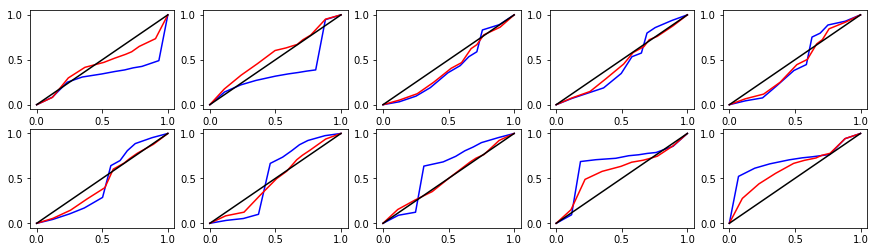

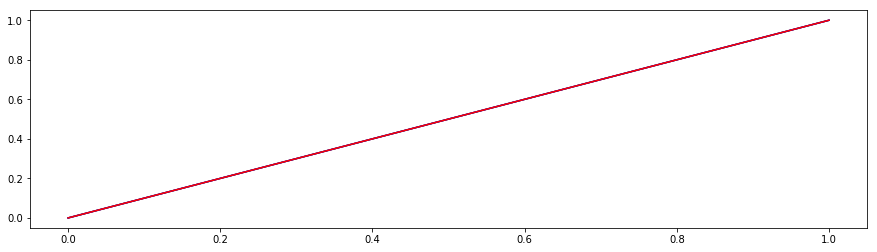

In [39]:
produce_plots(linSVCClassifier, pca_train_x, pca_train_y, pca_test_x, pca_test_y)

# Training SGD Classifier - Recommended. Multi-Core implementation

In [4]:
sgdClassifier = linear_model.SGDClassifier(loss="hinge", penalty='l2',
                alpha=0.0001, l1_ratio=0.15, fit_intercept=True,
                max_iter=1000, tol=1e-4, shuffle=True, verbose=1,
                epsilon=0.1, n_jobs=4, random_state=428, learning_rate='optimal',
                eta0=0.0, power_t=0.5, early_stopping=False, validation_fraction=0.1,
                n_iter_no_change=10, class_weight=None, warm_start=False,
                average=False)
sgdClassifier.fit(pca_train_x, pca_train_y)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1


-- Epoch 1
Norm: 473.39, NNZs: 500, Bias: -3125.944538, T: 50000, Avg. loss: 308.561576Norm: 357.09, NNZs: 500, Bias: -2782.173593, T: 50000, Avg. loss: 371.441443
Total training time: 0.09 seconds.

Total training time: 0.10 seconds.
-- Epoch 2
-- Epoch 2
Norm: 403.72, NNZs: 500, Bias: -2656.247431, T: 50000, Avg. loss: 358.019663
Total training time: 0.14 seconds.
-- Epoch 2
Norm: 372.87, NNZs: 500, Bias: -3039.708832, T: 50000, Avg. loss: 327.114777
Total training time: 0.15 seconds.
-- Epoch 2
Norm: 310.12, NNZs: 500, Bias: -2359.242582, T: 100000, Avg. loss: 175.876147
Total training time: 0.19 seconds.
-- Epoch 3
Norm: 424.02, NNZs: 500, Bias: -2811.687860, T: 100000, Avg. loss: 142.497310
Total training time: 0.20 seconds.
-- Epoch 3
Norm: 328.93, NNZs: 500, Bias: -2729.955857, T: 100000, Avg. loss: 144.122548
Total training time: 0.23 seconds.
-- Epoch 3
Norm: 359.03, NNZs: 500, Bias: -2211.218921, T: 100000, Avg. loss: 167.450020
Total training

Norm: 184.28, NNZs: 500, Bias: -927.239225, T: 950000, Avg. loss: 59.474410Norm: 298.13, NNZs: 500, Bias: -1758.148821, T: 950000, Avg. loss: 77.171372
Total training time: 1.89 seconds.
-- Epoch 20

Total training time: 1.90 seconds.
-- Epoch 20
Norm: 184.34, NNZs: 500, Bias: -743.282979, T: 950000, Avg. loss: 48.386079
Total training time: 1.94 seconds.
-- Epoch 20
Norm: 239.52, NNZs: 500, Bias: -1680.617885, T: 950000, Avg. loss: 76.505955
Total training time: 1.94 seconds.
-- Epoch 20
Norm: 295.64, NNZs: 500, Bias: -1734.172466, T: 1000000, Avg. loss: 76.075779
Total training time: 1.97 seconds.
-- Epoch 21
Norm: 179.88, NNZs: 500, Bias: -895.193091, T: 1000000, Avg. loss: 57.262859
Total training time: 1.98 seconds.
-- Epoch 21
Norm: 237.39, NNZs: 500, Bias: -1656.605024, T: 1000000, Avg. loss: 75.243753
Total training time: 2.02 seconds.
-- Epoch 21
Norm: 178.75, NNZs: 500, Bias: -710.979430, T: 1000000, Avg. loss: 46.201440
Total training time: 2.02 seconds.
-- Epoch 21
Norm: 29

-- Epoch 38
Norm: 211.77, NNZs: 500, Bias: -1382.360939, T: 1800000, Avg. loss: 62.041070
Total training time: 3.32 seconds.
-- Epoch 37
Norm: 131.19, NNZs: 500, Bias: -512.733682, T: 1850000, Avg. loss: 32.591477
Total training time: 3.34 seconds.
-- Epoch 38
Norm: 109.65, NNZs: 500, Bias: -331.124904, T: 1850000, Avg. loss: 21.462222
Total training time: 3.35 seconds.
-- Epoch 38
Norm: 259.09, NNZs: 500, Bias: -1436.948711, T: 1900000, Avg. loss: 62.173980
Total training time: 3.38 seconds.
-- Epoch 39
Norm: 211.78, NNZs: 500, Bias: -1369.415665, T: 1850000, Avg. loss: 61.547311
Total training time: 3.40 seconds.
-- Epoch 38
Norm: 129.00, NNZs: 500, Bias: -496.342731, T: 1900000, Avg. loss: 31.537834
Total training time: 3.41 seconds.
-- Epoch 39
Norm: 106.57, NNZs: 500, Bias: -315.044217, T: 1900000, Avg. loss: 20.514424
Total training time: 3.43 seconds.
-- Epoch 39
Norm: 256.89, NNZs: 500, Bias: -1425.128997, T: 1950000, Avg. loss: 61.600728
Total training time: 3.45 seconds.
-- E

Total training time: 4.69 seconds.
-- Epoch 55
Norm: 51.61, NNZs: 500, Bias: -103.825527, T: 2750000, Avg. loss: 7.178341
Total training time: 4.74 seconds.
-- Epoch 56
Norm: 236.42, NNZs: 500, Bias: -1259.337743, T: 2800000, Avg. loss: 54.102910
Total training time: 4.73 seconds.
-- Epoch 57
Norm: 91.16, NNZs: 500, Bias: -274.089197, T: 2750000, Avg. loss: 17.463070
Total training time: 4.76 seconds.
-- Epoch 56
Norm: 193.32, NNZs: 500, Bias: -1185.651154, T: 2750000, Avg. loss: 52.912120
Total training time: 4.86 seconds.
-- Epoch 56
Norm: 48.39, NNZs: 500, Bias: -94.314038, T: 2800000, Avg. loss: 6.588599
Total training time: 4.92 seconds.
-- Epoch 57
Norm: 235.46, NNZs: 500, Bias: -1251.254135, T: 2850000, Avg. loss: 53.720151
Total training time: 4.92 seconds.
-- Epoch 58
Norm: 89.18, NNZs: 500, Bias: -263.451277, T: 2800000, Avg. loss: 16.853284
Total training time: 4.96 seconds.
-- Epoch 57
Norm: 192.53, NNZs: 500, Bias: -1177.315084, T: 2800000, Avg. loss: 52.485943
Total train

Norm: 219.44, NNZs: 500, Bias: -1132.777525, T: 3700000, Avg. loss: 48.429329
Total training time: 6.36 seconds.
-- Epoch 75
Norm: 2.87, NNZs: 500, Bias: -7.753437, T: 3600000, Avg. loss: 0.942545
Total training time: 6.39 seconds.
-- Epoch 73
Norm: 55.06, NNZs: 500, Bias: -120.781687, T: 3600000, Avg. loss: 8.024894
Total training time: 6.40 seconds.
-- Epoch 73
Norm: 180.30, NNZs: 500, Bias: -1061.461676, T: 3600000, Avg. loss: 47.155405
Total training time: 6.44 seconds.
-- Epoch 73
Norm: 218.44, NNZs: 500, Bias: -1126.738980, T: 3750000, Avg. loss: 48.179460
Total training time: 6.45 seconds.
-- Epoch 76
Norm: 2.63, NNZs: 500, Bias: -7.706463, T: 3650000, Avg. loss: 0.946804
Total training time: 6.48 seconds.
-- Epoch 74
Norm: 52.87, NNZs: 500, Bias: -113.298099, T: 3650000, Avg. loss: 7.577088
Total training time: 6.50 seconds.
-- Epoch 74
Norm: 179.39, NNZs: 500, Bias: -1055.153929, T: 3650000, Avg. loss: 46.895682
Total training time: 6.52 seconds.
-- Epoch 74
Norm: 217.85, NNZs

Norm: 2.10, NNZs: 500, Bias: -6.486545, T: 4400000, Avg. loss: 0.814359
Total training time: 7.85 seconds.
-- Epoch 89
Norm: 205.54, NNZs: 500, Bias: -1029.666718, T: 4650000, Avg. loss: 43.882988
Total training time: 7.85 seconds.
-- Epoch 94
Norm: 169.18, NNZs: 500, Bias: -959.050714, T: 4500000, Avg. loss: 42.476871
Total training time: 7.88 seconds.
-- Epoch 91
Norm: 13.03, NNZs: 500, Bias: -19.524820, T: 4450000, Avg. loss: 1.761007
Total training time: 7.90 seconds.
-- Epoch 90
Norm: 204.81, NNZs: 500, Bias: -1024.874713, T: 4700000, Avg. loss: 43.666706
Total training time: 7.93 seconds.
-- Epoch 95
Norm: 2.16, NNZs: 500, Bias: -6.389659, T: 4450000, Avg. loss: 0.800973
Total training time: 7.94 seconds.
-- Epoch 90
Norm: 168.83, NNZs: 500, Bias: -953.958158, T: 4550000, Avg. loss: 42.232138
Total training time: 7.95 seconds.
-- Epoch 92
Norm: 10.52, NNZs: 500, Bias: -15.882499, T: 4500000, Avg. loss: 1.504032
Total training time: 7.97 seconds.
-- Epoch 91
Norm: 203.88, NNZs: 50

Norm: 160.15, NNZs: 500, Bias: -875.702925, T: 5400000, Avg. loss: 38.709143
Total training time: 9.91 seconds.
-- Epoch 109
Norm: 1.71, NNZs: 500, Bias: -6.015159, T: 5300000, Avg. loss: 0.776674
Total training time: 9.95 seconds.
-- Epoch 107
Norm: 193.44, NNZs: 500, Bias: -946.459019, T: 5600000, Avg. loss: 40.197708
Total training time: 9.96 seconds.
-- Epoch 113
Norm: 1.75, NNZs: 500, Bias: -5.661752, T: 5300000, Avg. loss: 0.712995
Total training time: 9.98 seconds.
-- Epoch 107
Norm: 159.48, NNZs: 500, Bias: -871.533614, T: 5450000, Avg. loss: 38.529817
Total training time: 9.98 seconds.
-- Epoch 110
Norm: 1.82, NNZs: 500, Bias: -5.943842, T: 5350000, Avg. loss: 0.763037
Total training time: 10.02 seconds.
-- Epoch 108
Norm: 193.16, NNZs: 500, Bias: -942.427673, T: 5650000, Avg. loss: 40.064354
Total training time: 10.03 seconds.
-- Epoch 114
Norm: 1.80, NNZs: 500, Bias: -5.629560, T: 5350000, Avg. loss: 0.706417
Total training time: 10.05 seconds.
-- Epoch 108
Norm: 159.16, NNZ

-- Epoch 126
Norm: 1.59, NNZs: 500, Bias: -5.458126, T: 6050000, Avg. loss: 0.702257
Total training time: 11.78 seconds.
-- Epoch 122
Norm: 184.11, NNZs: 500, Bias: -879.997788, T: 6500000, Avg. loss: 37.316443
Total training time: 11.86 seconds.
-- Epoch 131
Norm: 1.60, NNZs: 500, Bias: -5.040633, T: 6100000, Avg. loss: 0.647567
Total training time: 11.87 seconds.
-- Epoch 123
Norm: 151.81, NNZs: 500, Bias: -805.608960, T: 6300000, Avg. loss: 35.506235
Total training time: 11.90 seconds.
-- Epoch 127
Norm: 1.55, NNZs: 500, Bias: -5.435205, T: 6100000, Avg. loss: 0.696302
Total training time: 11.96 seconds.
-- Epoch 123
Norm: 183.73, NNZs: 500, Bias: -876.568432, T: 6550000, Avg. loss: 37.164523
Total training time: 12.03 seconds.
-- Epoch 132
Norm: 1.62, NNZs: 500, Bias: -5.072981, T: 6150000, Avg. loss: 0.644753
Total training time: 12.06 seconds.
-- Epoch 124
Norm: 151.54, NNZs: 500, Bias: -801.990857, T: 6350000, Avg. loss: 35.355484
Total training time: 12.09 seconds.
-- Epoch 128

Norm: 1.48, NNZs: 500, Bias: -4.571923, T: 6900000, Avg. loss: 0.596806
Total training time: 13.82 seconds.
-- Epoch 139
Norm: 175.81, NNZs: 500, Bias: -822.451228, T: 7400000, Avg. loss: 34.834661
Total training time: 13.84 seconds.
-- Epoch 149
Norm: 144.51, NNZs: 500, Bias: -745.107509, T: 7200000, Avg. loss: 32.794305
Total training time: 13.87 seconds.
-- Epoch 145
Norm: 1.40, NNZs: 500, Bias: -4.853523, T: 6950000, Avg. loss: 0.633553
Total training time: 13.96 seconds.
-- Epoch 140
Norm: 175.45, NNZs: 500, Bias: -819.454993, T: 7450000, Avg. loss: 34.680260
Total training time: 14.01 seconds.
-- Epoch 150
Norm: 1.41, NNZs: 500, Bias: -4.633959, T: 6950000, Avg. loss: 0.590828
Total training time: 14.04 seconds.
-- Epoch 140
Norm: 144.10, NNZs: 500, Bias: -741.985419, T: 7250000, Avg. loss: 32.650055
Total training time: 14.09 seconds.
-- Epoch 146
Norm: 1.34, NNZs: 500, Bias: -4.853422, T: 7000000, Avg. loss: 0.632147
Total training time: 14.16 seconds.
-- Epoch 141
Norm: 174.86

Norm: 1.37, NNZs: 500, Bias: -4.250959, T: 7700000, Avg. loss: 0.555467
Total training time: 16.31 seconds.
-- Epoch 155
-- Epoch 155
Norm: 168.71, NNZs: 500, Bias: -774.410110, T: 8250000, Avg. loss: 32.735847
Total training time: 16.29 seconds.
-- Epoch 166
Norm: 138.27, NNZs: 500, Bias: -694.720972, T: 8050000, Avg. loss: 30.539127
Total training time: 16.43 seconds.
-- Epoch 162
Norm: 168.27, NNZs: 500, Bias: -771.756579, T: 8300000, Avg. loss: 32.623275
Total training time: 16.46 seconds.
-- Epoch 167
Norm: 1.23, NNZs: 500, Bias: -4.523453, T: 7750000, Avg. loss: 0.601697
Total training time: 16.46 seconds.Norm: 1.34, NNZs: 500, Bias: -4.315580, T: 7750000, Avg. loss: 0.551965
Total training time: 16.48 seconds.
-- Epoch 156

-- Epoch 156
Norm: 137.90, NNZs: 500, Bias: -691.933738, T: 8100000, Avg. loss: 30.439124
Total training time: 16.59 seconds.
-- Epoch 163
Norm: 1.30, NNZs: 500, Bias: -4.258991, T: 7800000, Avg. loss: 0.555093
Total training time: 16.64 seconds.
-- Epoch 157

Norm: 1.16, NNZs: 500, Bias: -4.232728, T: 8500000, Avg. loss: 0.565943
Total training time: 18.63 seconds.
-- Epoch 171
Norm: 1.20, NNZs: 500, Bias: -3.907521, T: 8550000, Avg. loss: 0.522267
Total training time: 18.73 seconds.
-- Epoch 172
Norm: 161.60, NNZs: 500, Bias: -726.436211, T: 9200000, Avg. loss: 30.665369
Total training time: 18.72 seconds.
-- Epoch 185
Norm: 132.05, NNZs: 500, Bias: -647.065078, T: 8950000, Avg. loss: 28.414837
Total training time: 18.75 seconds.
-- Epoch 180
Norm: 1.12, NNZs: 500, Bias: -4.194089, T: 8550000, Avg. loss: 0.559802
Total training time: 18.80 seconds.
-- Epoch 172
Norm: 1.15, NNZs: 500, Bias: -3.878495, T: 8600000, Avg. loss: 0.520617
Total training time: 18.88 seconds.
-- Epoch 173
Norm: 161.31, NNZs: 500, Bias: -724.041078, T: 9250000, Avg. loss: 30.570699
Total training time: 18.89 seconds.
-- Epoch 186
Norm: 131.82, NNZs: 500, Bias: -644.545086, T: 9000000, Avg. loss: 28.307281
Total training time: 18.93 seconds.
-- Epoch 181
Norm: 1.13, 

-- Epoch 198
Norm: 1.15, NNZs: 500, Bias: -3.725573, T: 9400000, Avg. loss: 0.494647
Total training time: 21.08 seconds.
-- Epoch 189
Norm: 1.01, NNZs: 500, Bias: -3.873617, T: 9400000, Avg. loss: 0.533494
Total training time: 21.15 seconds.
-- Epoch 189
Norm: 154.81, NNZs: 500, Bias: -683.434699, T: 10150000, Avg. loss: 28.801204
Total training time: 21.17 seconds.
-- Epoch 204
Norm: 1.10, NNZs: 500, Bias: -3.721416, T: 9450000, Avg. loss: 0.494217
Total training time: 21.21 seconds.
-- Epoch 190
Norm: 125.98, NNZs: 500, Bias: -601.867587, T: 9900000, Avg. loss: 26.406234
Total training time: 21.22 seconds.
-- Epoch 199
Norm: 0.98, NNZs: 500, Bias: -3.939397, T: 9450000, Avg. loss: 0.526487
Total training time: 21.32 seconds.
-- Epoch 190
Norm: 154.48, NNZs: 500, Bias: -681.285543, T: 10200000, Avg. loss: 28.728967
Total training time: 21.35 seconds.
-- Epoch 205
Norm: 1.11, NNZs: 500, Bias: -3.649687, T: 9500000, Avg. loss: 0.492543
Total training time: 21.41 seconds.
Norm: 125.56, N

Norm: 1.03, NNZs: 500, Bias: -3.701427, T: 10250000, Avg. loss: 0.505813
Total training time: 23.51 seconds.
-- Epoch 206
Norm: 120.32, NNZs: 500, Bias: -560.969842, T: 10850000, Avg. loss: 24.572600
Total training time: 23.56 seconds.
-- Epoch 218
Norm: 148.69, NNZs: 500, Bias: -644.401994, T: 11100000, Avg. loss: 27.148028
Total training time: 23.55 seconds.
-- Epoch 223
Norm: 1.03, NNZs: 500, Bias: -3.489881, T: 10300000, Avg. loss: 0.470286
Total training time: 23.57 seconds.
-- Epoch 207
Norm: 1.00, NNZs: 500, Bias: -3.632430, T: 10300000, Avg. loss: 0.506657
Total training time: 23.60 seconds.
-- Epoch 207
Norm: 120.05, NNZs: 500, Bias: -558.917599, T: 10900000, Avg. loss: 24.510690Norm: 148.41, NNZs: 500, Bias: -642.439002, T: 11150000, Avg. loss: 27.056883
Total training time: 23.63 seconds.

Total training time: 23.62 seconds.
-- Epoch 224
-- Epoch 219
Norm: 1.03, NNZs: 500, Bias: -3.487052, T: 10350000, Avg. loss: 0.470807
Total training time: 23.66 seconds.
-- Epoch 208
Norm

Norm: 0.94, NNZs: 500, Bias: -3.518209, T: 11100000, Avg. loss: 0.485499
Total training time: 24.92 seconds.
-- Epoch 223
Norm: 143.01, NNZs: 500, Bias: -608.711578, T: 12050000, Avg. loss: 25.605711
Total training time: 24.95 seconds.
-- Epoch 242
Norm: 115.02, NNZs: 500, Bias: -523.641687, T: 11800000, Avg. loss: 22.936723
Total training time: 24.99 seconds.
-- Epoch 237
Norm: 0.95, NNZs: 500, Bias: -3.335078, T: 11150000, Avg. loss: 0.453631
Total training time: 25.00 seconds.
-- Epoch 224
Norm: 0.90, NNZs: 500, Bias: -3.534445, T: 11150000, Avg. loss: 0.482136
Total training time: 25.00 seconds.
-- Epoch 224
Norm: 142.57, NNZs: 500, Bias: -606.950232, T: 12100000, Avg. loss: 25.538368
Total training time: 25.02 seconds.
-- Epoch 243
Norm: 114.70, NNZs: 500, Bias: -521.776252, T: 11850000, Avg. loss: 22.858288
Total training time: 25.06 seconds.
-- Epoch 238
Norm: 1.02, NNZs: 500, Bias: -3.313653, T: 11200000, Avg. loss: 0.450461
Total training time: 25.08 seconds.
-- Epoch 225
Norm

-- Epoch 256
Norm: 0.87, NNZs: 500, Bias: -3.355975, T: 12000000, Avg. loss: 0.463816
Total training time: 26.36 seconds.
-- Epoch 241
Norm: 0.94, NNZs: 500, Bias: -3.182758, T: 12000000, Avg. loss: 0.438513
Total training time: 26.40 seconds.
-- Epoch 241
Norm: 137.27, NNZs: 500, Bias: -574.233727, T: 13050000, Avg. loss: 24.124276
Total training time: 26.40 seconds.
-- Epoch 262
Norm: 109.81, NNZs: 500, Bias: -487.584259, T: 12800000, Avg. loss: 21.348164
Total training time: 26.45 seconds.
-- Epoch 257
Norm: 0.83, NNZs: 500, Bias: -3.335998, T: 12050000, Avg. loss: 0.464046
Total training time: 26.45 seconds.
-- Epoch 242
Norm: 0.90, NNZs: 500, Bias: -3.173601, T: 12050000, Avg. loss: 0.436322
Total training time: 26.49 seconds.
-- Epoch 242
Norm: 137.12, NNZs: 500, Bias: -572.552790, T: 13100000, Avg. loss: 24.063968
Total training time: 26.48 seconds.
-- Epoch 263
Norm: 109.62, NNZs: 500, Bias: -485.845655, T: 12850000, Avg. loss: 21.274692
Total training time: 26.52 seconds.
-- E

Norm: 0.88, NNZs: 500, Bias: -3.083164, T: 12750000, Avg. loss: 0.422335
Total training time: 27.81 seconds.
-- Epoch 256
-- Epoch 279
Norm: 105.62, NNZs: 500, Bias: -459.177091, T: 13650000, Avg. loss: 20.090833
Total training time: 27.83 seconds.
-- Epoch 274
Norm: 0.82, NNZs: 500, Bias: -3.227192, T: 12800000, Avg. loss: 0.446945
Total training time: 27.87 seconds.
-- Epoch 257
Norm: 132.67, NNZs: 500, Bias: -545.432105, T: 13950000, Avg. loss: 22.910168
Total training time: 27.87 seconds.
-- Epoch 280
Norm: 0.87, NNZs: 500, Bias: -3.060392, T: 12800000, Avg. loss: 0.421117Norm: 105.34, NNZs: 500, Bias: -457.572830, T: 13700000, Avg. loss: 20.015361
Total training time: 27.90 seconds.

Total training time: 27.90 seconds.
-- Epoch 257
-- Epoch 275
Norm: 0.83, NNZs: 500, Bias: -3.223292, T: 12850000, Avg. loss: 0.447488
Total training time: 27.94 seconds.
-- Epoch 258
Norm: 132.41, NNZs: 500, Bias: -543.891605, T: 14000000, Avg. loss: 22.847888
Total training time: 27.94 seconds.
-- E

Norm: 101.35, NNZs: 500, Bias: -431.061091, T: 14550000, Avg. loss: 18.853360
Total training time: 29.11 seconds.
-- Epoch 292
Norm: 0.80, NNZs: 500, Bias: -2.965726, T: 13550000, Avg. loss: 0.410240
Total training time: 29.12 seconds.
-- Epoch 272
Norm: 0.76, NNZs: 500, Bias: -3.103610, T: 13550000, Avg. loss: 0.438372
Total training time: 29.12 seconds.
-- Epoch 272
Norm: 128.43, NNZs: 500, Bias: -520.001384, T: 14800000, Avg. loss: 21.815598
Total training time: 29.13 seconds.
-- Epoch 297
Norm: 101.12, NNZs: 500, Bias: -429.553081, T: 14600000, Avg. loss: 18.780274
Total training time: 29.18 seconds.
-- Epoch 293
Norm: 0.80, NNZs: 500, Bias: -2.965647, T: 13600000, Avg. loss: 0.410049
Total training time: 29.20 seconds.
-- Epoch 273
Norm: 0.76, NNZs: 500, Bias: -3.129352, T: 13600000, Avg. loss: 0.432977
Total training time: 29.19 seconds.
-- Epoch 273
Norm: 128.18, NNZs: 500, Bias: -518.553987, T: 14850000, Avg. loss: 21.769381
Total training time: 29.21 seconds.
-- Epoch 298
Norm

-- Epoch 288
Norm: 124.10, NNZs: 500, Bias: -494.707482, T: 15700000, Avg. loss: 20.753114
Total training time: 30.61 seconds.
-- Epoch 315
Norm: 97.16, NNZs: 500, Bias: -403.271707, T: 15500000, Avg. loss: 17.629936
Total training time: 30.65 seconds.
-- Epoch 311
Norm: 0.74, NNZs: 500, Bias: -2.994639, T: 14400000, Avg. loss: 0.425182
Total training time: 30.65 seconds.
-- Epoch 289
Norm: 0.81, NNZs: 500, Bias: -2.851363, T: 14400000, Avg. loss: 0.395191
Total training time: 30.67 seconds.
-- Epoch 289
Norm: 123.86, NNZs: 500, Bias: -493.349839, T: 15750000, Avg. loss: 20.697715
Total training time: 30.69 seconds.
-- Epoch 316
Norm: 96.90, NNZs: 500, Bias: -401.869558, T: 15550000, Avg. loss: 17.567161
Total training time: 30.72 seconds.
-- Epoch 312
Norm: 0.73, NNZs: 500, Bias: -2.991127, T: 14450000, Avg. loss: 0.424357
Total training time: 30.74 seconds.
-- Epoch 290
Norm: 0.80, NNZs: 500, Bias: -2.862422, T: 14450000, Avg. loss: 0.398881
Total training time: 30.76 seconds.
-- Epo

Total training time: 32.06 seconds.
-- Epoch 304
Norm: 93.21, NNZs: 500, Bias: -378.591472, T: 16400000, Avg. loss: 16.544148
Total training time: 32.10 seconds.
-- Epoch 329
Norm: 0.75, NNZs: 500, Bias: -2.762016, T: 15150000, Avg. loss: 0.392825
Total training time: 32.12 seconds.
-- Epoch 304
Norm: 119.73, NNZs: 500, Bias: -469.621886, T: 16650000, Avg. loss: 19.693759
Total training time: 32.12 seconds.
-- Epoch 334
Norm: 93.00, NNZs: 500, Bias: -377.261257, T: 16450000, Avg. loss: 16.483978
Total training time: 32.17 seconds.
-- Epoch 330
Norm: 0.70, NNZs: 500, Bias: -2.909313, T: 15200000, Avg. loss: 0.411286
Total training time: 32.17 seconds.
-- Epoch 305
Norm: 119.49, NNZs: 500, Bias: -468.346990, T: 16700000, Avg. loss: 19.640435
Total training time: 32.18 seconds.
-- Epoch 335
Norm: 0.77, NNZs: 500, Bias: -2.723845, T: 15200000, Avg. loss: 0.389086
Total training time: 32.20 seconds.
-- Epoch 305
Norm: 92.81, NNZs: 500, Bias: -375.933258, T: 16500000, Avg. loss: 16.422733
To

Norm: 0.78, NNZs: 500, Bias: -2.681040, T: 15900000, Avg. loss: 0.380520
Total training time: 33.52 seconds.
-- Epoch 319
Norm: 115.71, NNZs: 500, Bias: -447.232138, T: 17550000, Avg. loss: 18.739105
Total training time: 33.51 seconds.
-- Epoch 352
Norm: 89.53, NNZs: 500, Bias: -355.274984, T: 17300000, Avg. loss: 15.523100
Total training time: 33.53 seconds.
-- Epoch 347
Norm: 0.68, NNZs: 500, Bias: -2.829647, T: 15950000, Avg. loss: 0.402522
Total training time: 33.55 seconds.
-- Epoch 320
Norm: 115.55, NNZs: 500, Bias: -446.009994, T: 17600000, Avg. loss: 18.693119
Total training time: 33.59 seconds.
-- Epoch 353
Norm: 89.31, NNZs: 500, Bias: -354.020233, T: 17350000, Avg. loss: 15.469132
Total training time: 33.62 seconds.
-- Epoch 348
Norm: 0.72, NNZs: 500, Bias: -2.684235, T: 15950000, Avg. loss: 0.382226
Total training time: 33.62 seconds.
-- Epoch 320
Norm: 0.68, NNZs: 500, Bias: -2.813362, T: 16000000, Avg. loss: 0.402407
Total training time: 33.63 seconds.
-- Epoch 321
Norm: 

-- Epoch 372
Norm: 0.70, NNZs: 500, Bias: -2.599041, T: 16750000, Avg. loss: 0.373986
Total training time: 35.00 seconds.
-- Epoch 336
Norm: 0.67, NNZs: 500, Bias: -2.746636, T: 16800000, Avg. loss: 0.394970
Total training time: 35.03 seconds.
-- Epoch 337
Norm: 85.49, NNZs: 500, Bias: -330.853437, T: 18300000, Avg. loss: 14.451881
Total training time: 35.04 seconds.
-- Epoch 367
Norm: 111.37, NNZs: 500, Bias: -422.564432, T: 18600000, Avg. loss: 17.698632
Total training time: 35.03 seconds.
-- Epoch 373
Norm: 0.70, NNZs: 500, Bias: -2.596063, T: 16800000, Avg. loss: 0.372718
Total training time: 35.08 seconds.
-- Epoch 337
Norm: 85.28, NNZs: 500, Bias: -329.673723, T: 18350000, Avg. loss: 14.402822
Total training time: 35.11 seconds.
-- Epoch 368
Norm: 0.66, NNZs: 500, Bias: -2.738286, T: 16850000, Avg. loss: 0.393417
Total training time: 35.10 seconds.
-- Epoch 338
Norm: 111.06, NNZs: 500, Bias: -421.455805, T: 18650000, Avg. loss: 17.651989
Total training time: 35.10 seconds.
-- Epo

Norm: 82.14, NNZs: 500, Bias: -311.194824, T: 19150000, Avg. loss: 13.594127
Total training time: 36.25 seconds.
-- Epoch 384
Norm: 0.58, NNZs: 500, Bias: -2.668326, T: 17550000, Avg. loss: 0.386287
Total training time: 36.24 seconds.
-- Epoch 352
Norm: 107.66, NNZs: 500, Bias: -402.608999, T: 19500000, Avg. loss: 16.854465
Total training time: 36.24 seconds.
-- Epoch 391
Norm: 0.66, NNZs: 500, Bias: -2.528073, T: 17550000, Avg. loss: 0.365296
Total training time: 36.29 seconds.
-- Epoch 352
Norm: 81.97, NNZs: 500, Bias: -310.061119, T: 19200000, Avg. loss: 13.548590
Total training time: 36.32 seconds.
-- Epoch 385
Norm: 0.61, NNZs: 500, Bias: -2.680272, T: 17600000, Avg. loss: 0.385727
Total training time: 36.32 seconds.
-- Epoch 353
Norm: 107.46, NNZs: 500, Bias: -401.528902, T: 19550000, Avg. loss: 16.815038
Total training time: 36.32 seconds.
-- Epoch 392
Norm: 0.66, NNZs: 500, Bias: -2.522400, T: 17600000, Avg. loss: 0.366982
Total training time: 36.37 seconds.
-- Epoch 353
Norm: 

-- Epoch 368
Norm: 104.19, NNZs: 500, Bias: -383.580851, T: 20400000, Avg. loss: 16.060020
Total training time: 37.51 seconds.
-- Epoch 409
Norm: 78.80, NNZs: 500, Bias: -291.346594, T: 20050000, Avg. loss: 12.728359
Total training time: 37.54 seconds.
-- Epoch 402
Norm: 0.63, NNZs: 500, Bias: -2.483677, T: 18350000, Avg. loss: 0.359449
Total training time: 37.57 seconds.
-- Epoch 368
Norm: 0.58, NNZs: 500, Bias: -2.613319, T: 18400000, Avg. loss: 0.379198
Total training time: 37.58 seconds.
-- Epoch 369
Norm: 103.98, NNZs: 500, Bias: -382.556171, T: 20450000, Avg. loss: 16.012445
Total training time: 37.58 seconds.
-- Epoch 410
Norm: 78.56, NNZs: 500, Bias: -290.288635, T: 20100000, Avg. loss: 12.679875
Total training time: 37.61 seconds.
-- Epoch 403
Norm: 0.64, NNZs: 500, Bias: -2.461364, T: 18400000, Avg. loss: 0.357232
Total training time: 37.65 seconds.
-- Epoch 369
Norm: 103.80, NNZs: 500, Bias: -381.527661, T: 20500000, Avg. loss: 15.969475
Total training time: 37.64 seconds.
-

Norm: 100.38, NNZs: 500, Bias: -363.489597, T: 21400000, Avg. loss: 15.209539
Total training time: 39.04 seconds.
-- Epoch 429
Norm: 75.10, NNZs: 500, Bias: -270.412138, T: 21050000, Avg. loss: 11.815875
Total training time: 39.07 seconds.
-- Epoch 422
Norm: 0.61, NNZs: 500, Bias: -2.450444, T: 19250000, Avg. loss: 0.352699
Total training time: 39.09 seconds.
-- Epoch 386
Norm: 0.55, NNZs: 500, Bias: -2.530819, T: 19300000, Avg. loss: 0.373357
Total training time: 39.11 seconds.
-- Epoch 387
Norm: 100.21, NNZs: 500, Bias: -362.507606, T: 21450000, Avg. loss: 15.169152
Total training time: 39.12 seconds.
-- Epoch 430
Norm: 74.89, NNZs: 500, Bias: -269.402473, T: 21100000, Avg. loss: 11.775925
Total training time: 39.16 seconds.
-- Epoch 423
Norm: 0.63, NNZs: 500, Bias: -2.411013, T: 19300000, Avg. loss: 0.351586
Total training time: 39.17 seconds.
-- Epoch 387
Norm: 0.56, NNZs: 500, Bias: -2.526681, T: 19350000, Avg. loss: 0.370658
Total training time: 39.19 seconds.
-- Epoch 388
Norm: 

Norm: 71.69, NNZs: 500, Bias: -251.494709, T: 22000000, Avg. loss: 10.995601
Norm: 0.59, NNZs: 500, Bias: -2.371808, T: 20100000, Avg. loss: 0.345564Norm: 96.69, NNZs: 500, Bias: -344.383570, T: 22400000, Avg. loss: 14.405992Total training time: 40.66 seconds.
-- Epoch 441

Total training time: 40.65 seconds.

Total training time: 40.66 seconds.
-- Epoch 449
-- Epoch 403
Norm: 0.58, NNZs: 500, Bias: -2.468609, T: 20150000, Avg. loss: 0.362853
Total training time: 40.69 seconds.
-- Epoch 404
Norm: 71.51, NNZs: 500, Bias: -250.524930, T: 22050000, Avg. loss: 10.945679
Total training time: 40.73 seconds.
-- Epoch 442
Norm: 96.52, NNZs: 500, Bias: -343.448034, T: 22450000, Avg. loss: 14.377455
Total training time: 40.72 seconds.
-- Epoch 450
Norm: 0.56, NNZs: 500, Bias: -2.450282, T: 20200000, Avg. loss: 0.364540
Total training time: 40.77 seconds.
-- Epoch 405
Norm: 96.36, NNZs: 500, Bias: -342.513279, T: 22500000, Avg. loss: 14.328072
Total training time: 40.79 seconds.
-- Epoch 451
Norm

Norm: 0.58, NNZs: 500, Bias: -2.321908, T: 20900000, Avg. loss: 0.340833
Total training time: 42.13 seconds.
-- Epoch 419
Norm: 68.39, NNZs: 500, Bias: -233.437530, T: 22950000, Avg. loss: 10.215471
Total training time: 42.15 seconds.
-- Epoch 460
Norm: 0.54, NNZs: 500, Bias: -2.438359, T: 21000000, Avg. loss: 0.357795
Total training time: 42.16 seconds.
-- Epoch 421
Norm: 93.36, NNZs: 500, Bias: -327.045235, T: 23350000, Avg. loss: 13.677223
Total training time: 42.16 seconds.
-- Epoch 468
Norm: 68.21, NNZs: 500, Bias: -232.515715, T: 23000000, Avg. loss: 10.162579
Total training time: 42.22 seconds.
-- Epoch 461
Norm: 0.58, NNZs: 500, Bias: -2.330499, T: 20950000, Avg. loss: 0.339102
Total training time: 42.22 seconds.
-- Epoch 420
Norm: 0.54, NNZs: 500, Bias: -2.423136, T: 21050000, Avg. loss: 0.358317
Total training time: 42.24 seconds.
-- Epoch 422
Norm: 93.18, NNZs: 500, Bias: -326.158014, T: 23400000, Avg. loss: 13.648290
Total training time: 42.24 seconds.
-- Epoch 469
Norm: 68

Total training time: 43.61 seconds.
-- Epoch 436
Norm: 90.40, NNZs: 500, Bias: -312.185776, T: 24200000, Avg. loss: 13.059170Norm: 65.23, NNZs: 500, Bias: -217.103928, T: 23850000, Avg. loss: 9.501265
Total training time: 43.62 seconds.

Total training time: 43.63 seconds.
-- Epoch 478
-- Epoch 485
Norm: 0.56, NNZs: 500, Bias: -2.251920, T: 21700000, Avg. loss: 0.335633
Total training time: 43.66 seconds.
-- Epoch 435
Norm: 0.53, NNZs: 500, Bias: -2.368487, T: 21800000, Avg. loss: 0.353628
Total training time: 43.69 seconds.
-- Epoch 437
Norm: 65.11, NNZs: 500, Bias: -216.200496, T: 23900000, Avg. loss: 9.466418
Total training time: 43.71 seconds.
-- Epoch 479
Norm: 90.24, NNZs: 500, Bias: -311.325545, T: 24250000, Avg. loss: 13.025866
Total training time: 43.70 seconds.
-- Epoch 486
Norm: 0.55, NNZs: 500, Bias: -2.279111, T: 21750000, Avg. loss: 0.334286
Total training time: 43.75 seconds.
-- Epoch 436
Norm: 0.52, NNZs: 500, Bias: -2.375825, T: 21850000, Avg. loss: 0.353234
Total trai

Norm: 0.51, NNZs: 500, Bias: -2.325330, T: 22650000, Avg. loss: 0.348089Norm: 87.04, NNZs: 500, Bias: -295.401382, T: 25200000, Avg. loss: 12.354493
Total training time: 45.13 seconds.
-- Epoch 505

Total training time: 45.14 seconds.
-- Epoch 454
Norm: 61.84, NNZs: 500, Bias: -199.716555, T: 24850000, Avg. loss: 8.750734
Total training time: 45.15 seconds.
-- Epoch 498
Norm: 0.55, NNZs: 500, Bias: -2.236015, T: 22600000, Avg. loss: 0.330550
Total training time: 45.21 seconds.
-- Epoch 453
Norm: 86.86, NNZs: 500, Bias: -294.585151, T: 25250000, Avg. loss: 12.322072
Total training time: 45.21 seconds.
-- Epoch 506
Norm: 61.68, NNZs: 500, Bias: -198.863936, T: 24900000, Avg. loss: 8.714479
Total training time: 45.23 seconds.
-- Epoch 499
Norm: 0.51, NNZs: 500, Bias: -2.324455, T: 22700000, Avg. loss: 0.347880
Total training time: 45.23 seconds.
-- Epoch 455
Norm: 0.56, NNZs: 500, Bias: -2.232479, T: 22650000, Avg. loss: 0.329291
Total training time: 45.28 seconds.
-- Epoch 454
Norm: 86.6

-- Epoch 470
Norm: 58.67, NNZs: 500, Bias: -183.909971, T: 25800000, Avg. loss: 8.068801
Total training time: 46.62 seconds.
-- Epoch 517
Norm: 83.76, NNZs: 500, Bias: -279.333093, T: 26200000, Avg. loss: 11.683103
Total training time: 46.65 seconds.
-- Epoch 525
Norm: 0.53, NNZs: 500, Bias: -2.178402, T: 23450000, Avg. loss: 0.326676
Total training time: 46.66 seconds.
-- Epoch 470
Norm: 58.51, NNZs: 500, Bias: -183.091402, T: 25850000, Avg. loss: 8.036946
Total training time: 46.69 seconds.
-- Epoch 518
Norm: 0.50, NNZs: 500, Bias: -2.281963, T: 23500000, Avg. loss: 0.342444
Total training time: 46.69 seconds.
-- Epoch 471
Norm: 83.55, NNZs: 500, Bias: -278.561706, T: 26250000, Avg. loss: 11.659067
Total training time: 46.72 seconds.
-- Epoch 526
Norm: 0.53, NNZs: 500, Bias: -2.175865, T: 23500000, Avg. loss: 0.325086
Total training time: 46.74 seconds.
-- Epoch 471
Norm: 58.35, NNZs: 500, Bias: -182.278288, T: 25900000, Avg. loss: 7.996815
Total training time: 46.79 seconds.
-- Epoc

Norm: 55.38, NNZs: 500, Bias: -167.962783, T: 26800000, Avg. loss: 7.381251
Total training time: 48.08 seconds.
-- Epoch 537
Norm: 0.51, NNZs: 500, Bias: -2.227513, T: 24350000, Avg. loss: 0.338716
Total training time: 48.09 seconds.
-- Epoch 488
Norm: 80.55, NNZs: 500, Bias: -263.921877, T: 27200000, Avg. loss: 11.040771
Total training time: 48.10 seconds.
-- Epoch 545
Norm: 0.49, NNZs: 500, Bias: -2.151138, T: 24350000, Avg. loss: 0.322331
Total training time: 48.14 seconds.
-- Epoch 488
Norm: 55.22, NNZs: 500, Bias: -167.183681, T: 26850000, Avg. loss: 7.344739
Total training time: 48.16 seconds.
-- Epoch 538
Norm: 0.46, NNZs: 500, Bias: -2.222213, T: 24400000, Avg. loss: 0.338452
Total training time: 48.16 seconds.
Norm: 80.38, NNZs: 500, Bias: -263.173342, T: 27250000, Avg. loss: 11.019005
Total training time: 48.16 seconds.
-- Epoch 489
-- Epoch 546
Norm: 0.52, NNZs: 500, Bias: -2.144583, T: 24400000, Avg. loss: 0.321321
Total training time: 48.22 seconds.
-- Epoch 489
Norm: 55.0

-- Epoch 563
Norm: 52.24, NNZs: 500, Bias: -153.447856, T: 27750000, Avg. loss: 6.754738
Total training time: 49.41 seconds.
-- Epoch 556
Norm: 0.50, NNZs: 500, Bias: -2.121416, T: 25150000, Avg. loss: 0.318327
Total training time: 49.42 seconds.
-- Epoch 504
Norm: 0.48, NNZs: 500, Bias: -2.189436, T: 25200000, Avg. loss: 0.333485
Total training time: 49.43 seconds.
-- Epoch 505
Norm: 77.52, NNZs: 500, Bias: -249.865045, T: 28150000, Avg. loss: 10.462147
Total training time: 49.44 seconds.
-- Epoch 564
Norm: 52.08, NNZs: 500, Bias: -152.698999, T: 27800000, Avg. loss: 6.725229
Total training time: 49.48 seconds.
-- Epoch 557
Norm: 0.50, NNZs: 500, Bias: -2.084100, T: 25200000, Avg. loss: 0.318693
Total training time: 49.50 seconds.
-- Epoch 505
Norm: 0.47, NNZs: 500, Bias: -2.199771, T: 25250000, Avg. loss: 0.332907
Total training time: 49.51 seconds.
-- Epoch 506
Norm: 77.35, NNZs: 500, Bias: -249.144575, T: 28200000, Avg. loss: 10.431420
Total training time: 49.51 seconds.
-- Epoch 5

-- Epoch 573
Norm: 74.87, NNZs: 500, Bias: -237.722759, T: 29000000, Avg. loss: 9.958606
Total training time: 50.65 seconds.
-- Epoch 581
Norm: 0.48, NNZs: 500, Bias: -2.074540, T: 25950000, Avg. loss: 0.314320
Total training time: 50.70 seconds.
-- Epoch 520
Norm: 0.45, NNZs: 500, Bias: -2.160174, T: 26000000, Avg. loss: 0.330444
Total training time: 50.71 seconds.
-- Epoch 521
Norm: 49.28, NNZs: 500, Bias: -140.223908, T: 28650000, Avg. loss: 6.185137
Total training time: 50.72 seconds.
-- Epoch 574
Norm: 74.71, NNZs: 500, Bias: -237.021306, T: 29050000, Avg. loss: 9.925522
Total training time: 50.72 seconds.
-- Epoch 582
Norm: 0.47, NNZs: 500, Bias: -2.088015, T: 26000000, Avg. loss: 0.314866
Total training time: 50.78 seconds.
-- Epoch 521
Norm: 49.12, NNZs: 500, Bias: -139.504148, T: 28700000, Avg. loss: 6.157323
Total training time: 50.79 seconds.
-- Epoch 575
Norm: 0.44, NNZs: 500, Bias: -2.172096, T: 26050000, Avg. loss: 0.328468
Total training time: 50.78 seconds.
-- Epoch 522

Norm: 71.95, NNZs: 500, Bias: -224.612664, T: 29950000, Avg. loss: 9.407975
Total training time: 52.04 seconds.
-- Epoch 600
Norm: 0.42, NNZs: 500, Bias: -2.127867, T: 26800000, Avg. loss: 0.325494
Total training time: 52.08 seconds.
-- Epoch 537
Norm: 0.48, NNZs: 500, Bias: -2.057095, T: 26700000, Avg. loss: 0.311168
Total training time: 52.09 seconds.
-- Epoch 535
Norm: 46.46, NNZs: 500, Bias: -128.191935, T: 29500000, Avg. loss: 5.670309
Total training time: 52.11 seconds.
-- Epoch 591
Norm: 71.84, NNZs: 500, Bias: -223.923457, T: 30000000, Avg. loss: 9.381765
Total training time: 52.11 seconds.
-- Epoch 601
Norm: 0.43, NNZs: 500, Bias: -2.121905, T: 26850000, Avg. loss: 0.325878
Total training time: 52.16 seconds.
-- Epoch 538
Norm: 46.29, NNZs: 500, Bias: -127.497630, T: 29550000, Avg. loss: 5.639580
Total training time: 52.19 seconds.
-- Epoch 592
Norm: 0.48, NNZs: 500, Bias: -2.066828, T: 26750000, Avg. loss: 0.310734
Total training time: 52.19 seconds.
-- Epoch 536
Norm: 71.71,

Norm: 0.48, NNZs: 500, Bias: -2.019485, T: 27600000, Avg. loss: 0.307772
Total training time: 53.74 seconds.
Norm: 0.43, NNZs: 500, Bias: -2.103320, T: 27650000, Avg. loss: 0.322187-- Epoch 553

Total training time: 53.74 seconds.
-- Epoch 554
Norm: 43.14, NNZs: 500, Bias: -114.562584, T: 30500000, Avg. loss: 5.086486
Total training time: 53.74 seconds.
-- Epoch 611
Norm: 68.82, NNZs: 500, Bias: -210.643659, T: 31000000, Avg. loss: 8.830814
Total training time: 53.73 seconds.
-- Epoch 621
Norm: 42.97, NNZs: 500, Bias: -113.896931, T: 30550000, Avg. loss: 5.056145
Total training time: 53.82 seconds.
-- Epoch 612
Norm: 68.66, NNZs: 500, Bias: -209.994523, T: 31050000, Avg. loss: 8.801735
Total training time: 53.81 seconds.
-- Epoch 622
Norm: 0.45, NNZs: 500, Bias: -2.018036, T: 27650000, Avg. loss: 0.308529
Total training time: 53.83 seconds.
-- Epoch 554
Norm: 0.42, NNZs: 500, Bias: -2.097202, T: 27700000, Avg. loss: 0.321928
Total training time: 53.82 seconds.
-- Epoch 555
Norm: 42.78,

Norm: 0.42, NNZs: 500, Bias: -2.061778, T: 28500000, Avg. loss: 0.318409
Total training time: 55.21 seconds.
-- Epoch 571
Norm: 0.45, NNZs: 500, Bias: -2.004566, T: 28450000, Avg. loss: 0.304529
Total training time: 55.22 seconds.
-- Epoch 570
Norm: 39.92, NNZs: 500, Bias: -102.138287, T: 31450000, Avg. loss: 4.550214
Total training time: 55.24 seconds.
-- Epoch 630
Norm: 65.82, NNZs: 500, Bias: -197.847207, T: 32000000, Avg. loss: 8.302456
Total training time: 55.29 seconds.
-- Epoch 641
Norm: 0.41, NNZs: 500, Bias: -2.057919, T: 28550000, Avg. loss: 0.319091
Total training time: 55.31 seconds.
-- Epoch 572
Norm: 0.43, NNZs: 500, Bias: -1.986656, T: 28500000, Avg. loss: 0.305424
Total training time: 55.32 seconds.
-- Epoch 571
Norm: 39.75, NNZs: 500, Bias: -101.500019, T: 31500000, Avg. loss: 4.525977
Total training time: 55.32 seconds.
-- Epoch 631
Norm: 65.69, NNZs: 500, Bias: -197.214273, T: 32050000, Avg. loss: 8.268317
Total training time: 55.36 seconds.
-- Epoch 642
Norm: 0.40, 

Norm: 36.88, NNZs: 500, Bias: -90.797247, T: 32350000, Avg. loss: 4.065123
Total training time: 56.64 seconds.
-- Epoch 648
Norm: 0.44, NNZs: 500, Bias: -1.970433, T: 29250000, Avg. loss: 0.301998
Total training time: 56.64 seconds.
-- Epoch 586
Norm: 63.18, NNZs: 500, Bias: -186.707965, T: 32900000, Avg. loss: 7.835956
Total training time: 56.66 seconds.
-- Epoch 659
Norm: 0.41, NNZs: 500, Bias: -2.047429, T: 29300000, Avg. loss: 0.316404
Total training time: 56.68 seconds.
-- Epoch 587
Norm: 36.70, NNZs: 500, Bias: -90.182589, T: 32400000, Avg. loss: 4.042519
Total training time: 56.72 seconds.
-- Epoch 649
Norm: 0.44, NNZs: 500, Bias: -1.959520, T: 29300000, Avg. loss: 0.302340
Total training time: 56.75 seconds.
-- Epoch 587
Norm: 63.03, NNZs: 500, Bias: -186.101751, T: 32950000, Avg. loss: 7.814850
Total training time: 56.76 seconds.
-- Epoch 660
Norm: 0.42, NNZs: 500, Bias: -2.080837, T: 29350000, Avg. loss: 0.314821
Total training time: 56.76 seconds.
-- Epoch 588
Norm: 36.53, N

-- Epoch 604
Norm: 33.43, NNZs: 500, Bias: -78.691993, T: 33350000, Avg. loss: 3.553140
Total training time: 58.27 seconds.
-- Epoch 668
Norm: 0.40, NNZs: 500, Bias: -2.006115, T: 30200000, Avg. loss: 0.313109
Total training time: 58.28 seconds.
-- Epoch 605
Norm: 60.21, NNZs: 500, Bias: -174.119637, T: 33950000, Avg. loss: 7.319625
Total training time: 58.28 seconds.
-- Epoch 680
Norm: 0.41, NNZs: 500, Bias: -1.944718, T: 30200000, Avg. loss: 0.300489
Total training time: 58.32 seconds.
-- Epoch 605
Norm: 33.27, NNZs: 500, Bias: -78.096066, T: 33400000, Avg. loss: 3.524522
Total training time: 58.35 seconds.
-- Epoch 669
Norm: 60.06, NNZs: 500, Bias: -173.533350, T: 34000000, Avg. loss: 7.293683
Total training time: 58.35 seconds.
-- Epoch 681
Norm: 0.40, NNZs: 500, Bias: -2.012071, T: 30250000, Avg. loss: 0.312847
Total training time: 58.36 seconds.
-- Epoch 606
Norm: 0.41, NNZs: 500, Bias: -1.928830, T: 30250000, Avg. loss: 0.299205
Total training time: 58.40 seconds.
-- Epoch 606
N

Norm: 0.43, NNZs: 500, Bias: -1.918668, T: 30950000, Avg. loss: 0.296459Norm: 57.73, NNZs: 500, Bias: -164.286346, T: 34800000, Avg. loss: 6.915966
Total training time: 59.62 seconds.
-- Epoch 697

Total training time: 59.65 seconds.
-- Epoch 620
Norm: 30.28, NNZs: 500, Bias: -68.223058, T: 34250000, Avg. loss: 3.103863
Total training time: 59.71 seconds.
-- Epoch 686
Norm: 0.39, NNZs: 500, Bias: -1.988045, T: 31000000, Avg. loss: 0.310186
Total training time: 59.71 seconds.
-- Epoch 621
Norm: 57.61, NNZs: 500, Bias: -163.708618, T: 34850000, Avg. loss: 6.890823
Total training time: 59.71 seconds.
-- Epoch 698
Norm: 0.41, NNZs: 500, Bias: -1.906407, T: 31000000, Avg. loss: 0.297703
Total training time: 59.79 seconds.
-- Epoch 621
Norm: 57.44, NNZs: 500, Bias: -163.149782, T: 34900000, Avg. loss: 6.867849
Total training time: 59.78 seconds.
-- Epoch 699
Norm: 30.11, NNZs: 500, Bias: -67.649177, T: 34300000, Avg. loss: 3.080096
Total training time: 59.79 seconds.
-- Epoch 687
Norm: 0.39,

Norm: 55.05, NNZs: 500, Bias: -153.604936, T: 35750000, Avg. loss: 6.475564
Total training time: 61.16 seconds.
-- Epoch 716
Norm: 27.23, NNZs: 500, Bias: -58.712153, T: 35100000, Avg. loss: 2.696343
Total training time: 61.18 seconds.
-- Epoch 703
Norm: 0.36, NNZs: 500, Bias: -1.981540, T: 31800000, Avg. loss: 0.306982
Total training time: 61.17 seconds.
-- Epoch 637
Norm: 0.43, NNZs: 500, Bias: -1.905409, T: 31750000, Avg. loss: 0.293861
Total training time: 61.24 seconds.
-- Epoch 636
Norm: 54.93, NNZs: 500, Bias: -153.044788, T: 35800000, Avg. loss: 6.446771
Total training time: 61.23 seconds.
-- Epoch 717
Norm: 27.05, NNZs: 500, Bias: -58.159277, T: 35150000, Avg. loss: 2.676029
Total training time: 61.25 seconds.
-- Epoch 704
Norm: 0.38, NNZs: 500, Bias: -1.949493, T: 31850000, Avg. loss: 0.307539
Total training time: 61.25 seconds.
-- Epoch 638
Norm: 54.77, NNZs: 500, Bias: -152.496591, T: 35850000, Avg. loss: 6.426498
Total training time: 61.29 seconds.
-- Epoch 718
Norm: 0.42,

-- Epoch 720
Norm: 0.39, NNZs: 500, Bias: -1.875201, T: 32500000, Avg. loss: 0.292594
Total training time: 62.63 seconds.
-- Epoch 651
Norm: 52.35, NNZs: 500, Bias: -143.261869, T: 36700000, Avg. loss: 6.048953
Total training time: 62.62 seconds.
-- Epoch 735
Norm: 23.92, NNZs: 500, Bias: -49.033204, T: 36000000, Avg. loss: 2.284433
Total training time: 62.66 seconds.
-- Epoch 721
Norm: 0.36, NNZs: 500, Bias: -1.954235, T: 32600000, Avg. loss: 0.304879
Total training time: 62.70 seconds.
-- Epoch 653
Norm: 0.40, NNZs: 500, Bias: -1.884116, T: 32550000, Avg. loss: 0.292595
Total training time: 62.71 seconds.
-- Epoch 652
Norm: 52.23, NNZs: 500, Bias: -142.720561, T: 36750000, Avg. loss: 6.023805
Total training time: 62.72 seconds.
-- Epoch 736
Norm: 23.73, NNZs: 500, Bias: -48.511642, T: 36050000, Avg. loss: 2.262366
Total training time: 62.74 seconds.
-- Epoch 722
Norm: 0.35, NNZs: 500, Bias: -1.938283, T: 32650000, Avg. loss: 0.305345
Total training time: 62.77 seconds.
-- Epoch 654
N

Norm: 20.50, NNZs: 500, Bias: -39.774763, T: 36900000, Avg. loss: 1.889150
Total training time: 64.06 seconds.
-- Epoch 739
Norm: 49.88, NNZs: 500, Bias: -133.732328, T: 37600000, Avg. loss: 5.654290
Total training time: 64.08 seconds.
-- Epoch 753
Norm: 0.35, NNZs: 500, Bias: -1.932305, T: 33400000, Avg. loss: 0.302583
Total training time: 64.09 seconds.
-- Epoch 669
Norm: 0.38, NNZs: 500, Bias: -1.851478, T: 33350000, Avg. loss: 0.289579
Total training time: 64.11 seconds.
-- Epoch 668
Norm: 20.30, NNZs: 500, Bias: -39.277282, T: 36950000, Avg. loss: 1.867170
Total training time: 64.13 seconds.
-- Epoch 740
Norm: 49.75, NNZs: 500, Bias: -133.208489, T: 37650000, Avg. loss: 5.632163
Total training time: 64.15 seconds.
-- Epoch 754
Norm: 0.35, NNZs: 500, Bias: -1.923333, T: 33450000, Avg. loss: 0.303301
Total training time: 64.17 seconds.
-- Epoch 670
Norm: 0.38, NNZs: 500, Bias: -1.839497, T: 33400000, Avg. loss: 0.290435
Total training time: 64.18 seconds.
-- Epoch 669
Norm: 20.10, N

-- Epoch 686
Norm: 0.38, NNZs: 500, Bias: -1.822295, T: 34200000, Avg. loss: 0.288165
Total training time: 65.55 seconds.
-- Epoch 685
Norm: 16.51, NNZs: 500, Bias: -30.020043, T: 37900000, Avg. loss: 1.470105
Total training time: 65.56 seconds.
-- Epoch 759
Norm: 47.11, NNZs: 500, Bias: -123.472796, T: 38600000, Avg. loss: 5.235569
Total training time: 65.57 seconds.
-- Epoch 773
Norm: 0.37, NNZs: 500, Bias: -1.901459, T: 34300000, Avg. loss: 0.299804
Total training time: 65.61 seconds.
-- Epoch 687
Norm: 16.31, NNZs: 500, Bias: -29.544908, T: 37950000, Avg. loss: 1.451769
Total training time: 65.63 seconds.
-- Epoch 760
Norm: 0.39, NNZs: 500, Bias: -1.834586, T: 34250000, Avg. loss: 0.287208
Total training time: 65.65 seconds.
-- Epoch 686
Norm: 46.98, NNZs: 500, Bias: -122.965111, T: 38650000, Avg. loss: 5.213545
Total training time: 65.65 seconds.
-- Epoch 774
Norm: 16.11, NNZs: 500, Bias: -29.071981, T: 38000000, Avg. loss: 1.430095
Total training time: 65.70 seconds.
-- Epoch 761

Norm: 44.77, NNZs: 500, Bias: -115.001608, T: 39450000, Avg. loss: 4.885010
Total training time: 66.93 seconds.
-- Epoch 790
Norm: 0.37, NNZs: 500, Bias: -1.822014, T: 35000000, Avg. loss: 0.286086
Total training time: 66.97 seconds.
-- Epoch 701
Norm: 0.33, NNZs: 500, Bias: -1.892729, T: 35100000, Avg. loss: 0.298181
Total training time: 66.98 seconds.
-- Epoch 703
Norm: 12.78, NNZs: 500, Bias: -21.743102, T: 38800000, Avg. loss: 1.116476
Total training time: 67.01 seconds.
-- Epoch 777
Norm: 44.63, NNZs: 500, Bias: -114.513467, T: 39500000, Avg. loss: 4.864677
Total training time: 67.00 seconds.
-- Epoch 791
Norm: 0.37, NNZs: 500, Bias: -1.814024, T: 35050000, Avg. loss: 0.285222
Total training time: 67.05 seconds.
-- Epoch 702
Norm: 0.32, NNZs: 500, Bias: -1.891031, T: 35150000, Avg. loss: 0.297910
Total training time: 67.06 seconds.
-- Epoch 704
Norm: 44.50, NNZs: 500, Bias: -114.018605, T: 39550000, Avg. loss: 4.845350
Total training time: 67.06 seconds.
-- Epoch 792
Norm: 12.56, 

-- Epoch 719
Norm: 42.02, NNZs: 500, Bias: -105.322882, T: 40450000, Avg. loss: 4.488323
Total training time: 68.42 seconds.
-- Epoch 810
Norm: 0.34, NNZs: 500, Bias: -1.874727, T: 36000000, Avg. loss: 0.295884
Total training time: 68.46 seconds.
-- Epoch 721
Norm: 8.40, NNZs: 500, Bias: -13.243248, T: 39800000, Avg. loss: 0.742944
Total training time: 68.47 seconds.
-- Epoch 797
Norm: 0.36, NNZs: 500, Bias: -1.797316, T: 35950000, Avg. loss: 0.283813
Total training time: 68.48 seconds.
-- Epoch 720
Norm: 41.87, NNZs: 500, Bias: -104.851494, T: 40500000, Avg. loss: 4.464444
Total training time: 68.51 seconds.
-- Epoch 811
Norm: 8.18, NNZs: 500, Bias: -12.839498, T: 39850000, Avg. loss: 0.726342
Total training time: 68.55 seconds.
-- Epoch 798
Norm: 0.35, NNZs: 500, Bias: -1.787862, T: 36000000, Avg. loss: 0.283956
Total training time: 68.57 seconds.
-- Epoch 721
Norm: 0.34, NNZs: 500, Bias: -1.874442, T: 36050000, Avg. loss: 0.295309
Total training time: 68.57 seconds.
-- Epoch 722
Nor

-- Epoch 815
Norm: 39.24, NNZs: 500, Bias: -95.956768, T: 41450000, Avg. loss: 4.098645
Total training time: 69.93 seconds.
-- Epoch 830
Norm: 0.32, NNZs: 500, Bias: -1.843823, T: 36850000, Avg. loss: 0.292718
Total training time: 69.95 seconds.
-- Epoch 738
Norm: 0.36, NNZs: 500, Bias: -1.773643, T: 36800000, Avg. loss: 0.282067
Total training time: 69.97 seconds.
-- Epoch 737
Norm: 4.03, NNZs: 500, Bias: -6.226618, T: 40750000, Avg. loss: 0.435518
Total training time: 70.00 seconds.
-- Epoch 816
Norm: 39.09, NNZs: 500, Bias: -95.499872, T: 41500000, Avg. loss: 4.087517
Total training time: 70.00 seconds.
-- Epoch 831
Norm: 0.31, NNZs: 500, Bias: -1.853043, T: 36900000, Avg. loss: 0.293368
Total training time: 70.03 seconds.
-- Epoch 739
Norm: 0.36, NNZs: 500, Bias: -1.763872, T: 36850000, Avg. loss: 0.281156
Total training time: 70.04 seconds.
-- Epoch 738
Norm: 3.79, NNZs: 500, Bias: -5.916133, T: 40800000, Avg. loss: 0.423859
Total training time: 70.06 seconds.
-- Epoch 817
Norm: 3

-- Epoch 850
Norm: 0.31, NNZs: 500, Bias: -1.820873, T: 37700000, Avg. loss: 0.291836
Total training time: 71.35 seconds.
-- Epoch 755
Norm: 0.34, NNZs: 500, Bias: -1.762882, T: 37700000, Avg. loss: 0.279615
Total training time: 71.42 seconds.
-- Epoch 755
Norm: 0.73, NNZs: 500, Bias: -2.313716, T: 41700000, Avg. loss: 0.274327
Total training time: 71.43 seconds.
-- Epoch 835
Norm: 36.29, NNZs: 500, Bias: -86.444067, T: 42500000, Avg. loss: 3.713010
Total training time: 71.42 seconds.
-- Epoch 851
Norm: 0.31, NNZs: 500, Bias: -1.825110, T: 37750000, Avg. loss: 0.291074
Total training time: 71.43 seconds.
-- Epoch 756
Norm: 0.36, NNZs: 500, Bias: -1.765261, T: 37750000, Avg. loss: 0.279455
Total training time: 71.50 seconds.
-- Epoch 756
Norm: 36.16, NNZs: 500, Bias: -85.993757, T: 42550000, Avg. loss: 3.695414
Total training time: 71.48 seconds.
-- Epoch 852
Norm: 0.68, NNZs: 500, Bias: -2.273449, T: 41750000, Avg. loss: 0.272804
Total training time: 71.50 seconds.
-- Epoch 836
Norm: 0

-- Epoch 868
Norm: 0.30, NNZs: 500, Bias: -1.803814, T: 38550000, Avg. loss: 0.289675
Total training time: 72.68 seconds.
-- Epoch 772
Norm: 0.52, NNZs: 500, Bias: -2.143355, T: 42500000, Avg. loss: 0.268598
Total training time: 72.69 seconds.
-- Epoch 851
Norm: 0.33, NNZs: 500, Bias: -1.732253, T: 38500000, Avg. loss: 0.278466
Total training time: 72.70 seconds.
-- Epoch 771
Norm: 33.77, NNZs: 500, Bias: -78.529483, T: 43400000, Avg. loss: 3.387085
Total training time: 72.69 seconds.
-- Epoch 869
Norm: 0.51, NNZs: 500, Bias: -2.149470, T: 42550000, Avg. loss: 0.269492
Total training time: 72.77 seconds.
-- Epoch 852
Norm: 0.31, NNZs: 500, Bias: -1.803818, T: 38600000, Avg. loss: 0.289035
Total training time: 72.76 seconds.
-- Epoch 773
Norm: 33.63, NNZs: 500, Bias: -78.097246, T: 43450000, Avg. loss: 3.371417
Total training time: 72.77 seconds.
-- Epoch 870
Norm: 0.34, NNZs: 500, Bias: -1.739266, T: 38550000, Avg. loss: 0.277459
Total training time: 72.78 seconds.
-- Epoch 772
Norm: 3

-- Epoch 886
Norm: 0.33, NNZs: 500, Bias: -1.717494, T: 39300000, Avg. loss: 0.276810
Total training time: 74.18 seconds.
-- Epoch 787
Norm: 215.94, NNZs: 500, Bias: -1429.012922, T: 450000, Avg. loss: 87.448818
Total training time: 0.77 seconds.
-- Epoch 10
Norm: 31.25, NNZs: 500, Bias: -70.833714, T: 44300000, Avg. loss: 3.073264
Total training time: 74.19 seconds.
-- Epoch 887
Norm: 0.29, NNZs: 500, Bias: -1.769411, T: 39400000, Avg. loss: 0.287938
Total training time: 74.21 seconds.
-- Epoch 789
Norm: 0.33, NNZs: 500, Bias: -1.726400, T: 39350000, Avg. loss: 0.276431
Total training time: 74.25 seconds.
-- Epoch 788
Norm: 210.59, NNZs: 500, Bias: -1365.979996, T: 500000, Avg. loss: 83.226479
Total training time: 0.83 seconds.
-- Epoch 11
Norm: 31.10, NNZs: 500, Bias: -70.413645, T: 44350000, Avg. loss: 3.056600
Total training time: 74.26 seconds.
-- Epoch 888
Norm: 0.29, NNZs: 500, Bias: -1.778042, T: 39450000, Avg. loss: 0.287392
Total training time: 74.28 seconds.
-- Epoch 790
Nor

-- Epoch 805
Norm: 0.31, NNZs: 500, Bias: -1.708556, T: 40100000, Avg. loss: 0.275650
Total training time: 75.48 seconds.
-- Epoch 803
Norm: 28.68, NNZs: 500, Bias: -63.366682, T: 45200000, Avg. loss: 2.765366
Total training time: 75.47 seconds.
-- Epoch 905
Norm: 155.26, NNZs: 500, Bias: -776.040642, T: 1350000, Avg. loss: 46.075047
Total training time: 2.11 seconds.
-- Epoch 28
Norm: 0.33, NNZs: 500, Bias: -1.721509, T: 40150000, Avg. loss: 0.274670
Total training time: 75.56 seconds.
-- Epoch 804
Norm: 28.55, NNZs: 500, Bias: -62.953864, T: 45250000, Avg. loss: 2.746057
Total training time: 75.55 seconds.
-- Epoch 906
Norm: 0.29, NNZs: 500, Bias: -1.766192, T: 40250000, Avg. loss: 0.285763
Total training time: 75.56 seconds.
-- Epoch 806
Norm: 152.92, NNZs: 500, Bias: -754.705813, T: 1400000, Avg. loss: 44.646869
Total training time: 2.18 seconds.
-- Epoch 29
Norm: 28.39, NNZs: 500, Bias: -62.553209, T: 45300000, Avg. loss: 2.733905
Total training time: 75.62 seconds.
-- Epoch 907
N

-- Epoch 822
Norm: 115.77, NNZs: 500, Bias: -466.284850, T: 2300000, Avg. loss: 27.477610
Total training time: 3.55 seconds.
-- Epoch 47
Norm: 25.83, NNZs: 500, Bias: -55.313794, T: 46200000, Avg. loss: 2.436336
Total training time: 76.97 seconds.
-- Epoch 925
Norm: 0.32, NNZs: 500, Bias: -1.703341, T: 41000000, Avg. loss: 0.273020
Total training time: 76.99 seconds.
-- Epoch 821
Norm: 113.85, NNZs: 500, Bias: -453.978699, T: 2350000, Avg. loss: 26.746302
Total training time: 3.62 seconds.
-- Epoch 48
Norm: 0.28, NNZs: 500, Bias: -1.765621, T: 41100000, Avg. loss: 0.283994
Total training time: 77.04 seconds.
-- Epoch 823
Norm: 25.69, NNZs: 500, Bias: -54.915962, T: 46250000, Avg. loss: 2.420104
Total training time: 77.05 seconds.
-- Epoch 926
Norm: 0.32, NNZs: 500, Bias: -1.699684, T: 41050000, Avg. loss: 0.273949
Total training time: 77.07 seconds.
-- Epoch 822
Norm: 112.26, NNZs: 500, Bias: -441.867134, T: 2400000, Avg. loss: 26.045638
Total training time: 3.69 seconds.
-- Epoch 49
N

Norm: 84.14, NNZs: 500, Bias: -270.479408, T: 3250000, Avg. loss: 15.991297
Total training time: 5.08 seconds.
-- Epoch 66
Norm: 237.38, NNZs: 500, Bias: -1637.983366, T: 400000, Avg. loss: 99.306456
Total training time: 0.65 seconds.
-- Epoch 9
Norm: 22.92, NNZs: 500, Bias: -47.532972, T: 47200000, Avg. loss: 2.114885
Total training time: 78.55 seconds.
-- Epoch 945
Norm: 0.29, NNZs: 500, Bias: -1.742952, T: 41950000, Avg. loss: 0.282660
Total training time: 78.58 seconds.
-- Epoch 840
Norm: 82.59, NNZs: 500, Bias: -261.974710, T: 3300000, Avg. loss: 15.519251
Total training time: 5.20 seconds.
-- Epoch 67
Norm: 22.78, NNZs: 500, Bias: -47.148021, T: 47250000, Avg. loss: 2.098831
Total training time: 78.63 seconds.
-- Epoch 946
Norm: 230.97, NNZs: 500, Bias: -1568.680061, T: 450000, Avg. loss: 94.547766
Total training time: 0.74 seconds.
-- Epoch 10
Norm: 0.29, NNZs: 500, Bias: -1.744384, T: 42000000, Avg. loss: 0.282446
Total training time: 78.66 seconds.
-- Epoch 841
Norm: 80.83, NN

Norm: 170.82, NNZs: 500, Bias: -946.785247, T: 1300000, Avg. loss: 55.338106
Total training time: 2.06 seconds.
-- Epoch 27
Norm: 54.27, NNZs: 500, Bias: -130.915252, T: 4200000, Avg. loss: 7.978072
Total training time: 6.60 seconds.
-- Epoch 85
Norm: 20.10, NNZs: 500, Bias: -40.395854, T: 48150000, Avg. loss: 1.822104
Total training time: 80.01 seconds.
-- Epoch 964
Norm: 0.27, NNZs: 500, Bias: -1.729244, T: 42750000, Avg. loss: 0.281043
Total training time: 80.02 seconds.
-- Epoch 856
Norm: 168.69, NNZs: 500, Bias: -924.823539, T: 1350000, Avg. loss: 53.973338
Total training time: 2.14 seconds.
-- Epoch 28
Norm: 52.74, NNZs: 500, Bias: -124.658268, T: 4250000, Avg. loss: 7.619922
Total training time: 6.67 seconds.
-- Epoch 86
Norm: 19.93, NNZs: 500, Bias: -40.034058, T: 48200000, Avg. loss: 1.802689
Total training time: 80.08 seconds.
-- Epoch 965
Norm: 0.27, NNZs: 500, Bias: -1.730412, T: 42800000, Avg. loss: 0.280522
Total training time: 80.10 seconds.
-- Epoch 857
Norm: 166.14, NN

Norm: 137.87, NNZs: 500, Bias: -656.241076, T: 2150000, Avg. loss: 38.015164
Total training time: 3.53 seconds.
-- Epoch 44
Norm: 23.73, NNZs: 500, Bias: -39.557555, T: 5050000, Avg. loss: 2.742935
Total training time: 8.06 seconds.
-- Epoch 102
Norm: 17.53, NNZs: 500, Bias: -34.216609, T: 49000000, Avg. loss: 1.565905
Total training time: 81.47 seconds.
-- Epoch 981
Norm: 264.10, NNZs: 500, Bias: -1718.976921, T: 650000, Avg. loss: 78.442345
Total training time: 1.14 seconds.
-- Epoch 14
Norm: 136.33, NNZs: 500, Bias: -643.051730, T: 2200000, Avg. loss: 37.222322
Total training time: 3.61 seconds.
-- Epoch 45
Norm: 17.37, NNZs: 500, Bias: -33.860268, T: 49050000, Avg. loss: 1.550987
Total training time: 81.55 seconds.
-- Epoch 982
Norm: 21.68, NNZs: 500, Bias: -35.241382, T: 5100000, Avg. loss: 2.501121
Total training time: 8.15 seconds.
-- Epoch 103
Norm: 260.82, NNZs: 500, Bias: -1684.123328, T: 700000, Avg. loss: 76.708844
Total training time: 1.25 seconds.
-- Epoch 15
Norm: 134.22

Norm: 14.76, NNZs: 500, Bias: -27.884645, T: 49900000, Avg. loss: 1.305020
Total training time: 83.06 seconds.
-- Epoch 999
Norm: 1.63, NNZs: 500, Bias: -5.164968, T: 5900000, Avg. loss: 0.622926
Total training time: 9.68 seconds.
-- Epoch 119
Norm: 112.50, NNZs: 500, Bias: -466.725957, T: 3000000, Avg. loss: 26.963966
Total training time: 5.19 seconds.
-- Epoch 61
Norm: 220.98, NNZs: 500, Bias: -1328.423529, T: 1500000, Avg. loss: 59.433728
Total training time: 2.78 seconds.
-- Epoch 31
Norm: 14.62, NNZs: 500, Bias: -27.535328, T: 49950000, Avg. loss: 1.292495
Total training time: 83.16 seconds.
-- Epoch 1000
Norm: 1.59, NNZs: 500, Bias: -5.133109, T: 5950000, Avg. loss: 0.622643
Total training time: 9.79 seconds.
-- Epoch 120
Norm: 111.16, NNZs: 500, Bias: -457.406119, T: 3050000, Avg. loss: 26.386875
Total training time: 5.30 seconds.
-- Epoch 62
Norm: 219.53, NNZs: 500, Bias: -1313.173425, T: 1550000, Avg. loss: 58.664044
Total training time: 2.88 seconds.
-- Epoch 32
Norm: 14.46, 

-- Epoch 79
Norm: 1.44, NNZs: 500, Bias: -4.777360, T: 6700000, Avg. loss: 0.574980
Total training time: 11.46 seconds.
-- Epoch 135
Norm: 196.36, NNZs: 500, Bias: -1111.071404, T: 2400000, Avg. loss: 49.276668
Total training time: 4.53 seconds.
-- Epoch 49
Norm: 288.99, NNZs: 500, Bias: -1233.242602, T: 850000, Avg. loss: 66.937016
Total training time: 1.62 seconds.
-- Epoch 18
Norm: 88.72, NNZs: 500, Bias: -312.969001, T: 3950000, Avg. loss: 18.097494
Total training time: 7.00 seconds.
-- Epoch 80
Norm: 194.99, NNZs: 500, Bias: -1101.628472, T: 2450000, Avg. loss: 48.842280
Total training time: 4.60 seconds.
-- Epoch 50
Norm: 283.92, NNZs: 500, Bias: -1200.866120, T: 900000, Avg. loss: 65.105776
Total training time: 1.68 seconds.
-- Epoch 19
Norm: 1.40, NNZs: 500, Bias: -4.799631, T: 6750000, Avg. loss: 0.572943
Total training time: 11.55 seconds.
-- Epoch 136
Norm: 87.31, NNZs: 500, Bias: -306.087713, T: 4000000, Avg. loss: 17.695676
Total training time: 7.08 seconds.
-- Epoch 81
No

-- Epoch 35
Norm: 178.73, NNZs: 500, Bias: -965.045822, T: 3300000, Avg. loss: 42.602294
Total training time: 5.95 seconds.
-- Epoch 67
Norm: 69.23, NNZs: 500, Bias: -206.431055, T: 4800000, Avg. loss: 12.022853
Total training time: 8.39 seconds.
-- Epoch 97
Norm: 1.30, NNZs: 500, Bias: -4.323306, T: 7550000, Avg. loss: 0.538288
Total training time: 12.91 seconds.
-- Epoch 152
Norm: 227.50, NNZs: 500, Bias: -828.704658, T: 1750000, Avg. loss: 43.908637
Total training time: 3.05 seconds.
-- Epoch 36
Norm: 178.18, NNZs: 500, Bias: -958.121754, T: 3350000, Avg. loss: 42.300378
Total training time: 6.02 seconds.
-- Epoch 68
Norm: 68.23, NNZs: 500, Bias: -200.803459, T: 4850000, Avg. loss: 11.724598
Total training time: 8.47 seconds.
-- Epoch 98
Norm: 1.26, NNZs: 500, Bias: -4.328662, T: 7600000, Avg. loss: 0.534705
Total training time: 12.98 seconds.
-- Epoch 153
Norm: 224.85, NNZs: 500, Bias: -813.228390, T: 1800000, Avg. loss: 43.029144
Total training time: 3.14 seconds.
-- Epoch 37
Norm

-- Epoch 169
Norm: 185.69, NNZs: 500, Bias: -593.370733, T: 2700000, Avg. loss: 31.037819
Total training time: 4.82 seconds.
-- Epoch 55
Norm: 164.48, NNZs: 500, Bias: -849.801889, T: 4250000, Avg. loss: 37.388238
Total training time: 7.75 seconds.
-- Epoch 86
Norm: 48.68, NNZs: 500, Bias: -115.565520, T: 5700000, Avg. loss: 6.919635
Total training time: 10.22 seconds.Norm: 1.16, NNZs: 500, Bias: -4.083484, T: 8450000, Avg. loss: 0.501751
Total training time: 14.73 seconds.
-- Epoch 170

-- Epoch 115
Norm: 183.58, NNZs: 500, Bias: -583.645607, T: 2750000, Avg. loss: 30.538661
Total training time: 4.90 seconds.
-- Epoch 56
Norm: 163.63, NNZs: 500, Bias: -844.530497, T: 4300000, Avg. loss: 37.139574
Total training time: 7.85 seconds.
-- Epoch 87
Norm: 47.44, NNZs: 500, Bias: -111.101241, T: 5750000, Avg. loss: 6.667091
Total training time: 10.30 seconds.
-- Epoch 116
Norm: 1.17, NNZs: 500, Bias: -4.058557, T: 8500000, Avg. loss: 0.501558
Total training time: 14.82 seconds.
-- Epoch 171
N

-- Epoch 103
Norm: 156.10, NNZs: 500, Bias: -449.179502, T: 3550000, Avg. loss: 23.376646
Total training time: 6.32 seconds.
-- Epoch 72
Norm: 26.75, NNZs: 500, Bias: -47.278983, T: 6550000, Avg. loss: 3.089564
Total training time: 11.68 seconds.
-- Epoch 132
Norm: 1.14, NNZs: 500, Bias: -3.832319, T: 9200000, Avg. loss: 0.480006
Total training time: 16.19 seconds.
-- Epoch 185
Norm: 152.81, NNZs: 500, Bias: -762.982967, T: 5150000, Avg. loss: 33.483375
Total training time: 9.34 seconds.
-- Epoch 104
Norm: 154.25, NNZs: 500, Bias: -442.007524, T: 3600000, Avg. loss: 23.007931
Total training time: 6.42 seconds.
-- Epoch 73
Norm: 1.12, NNZs: 500, Bias: -3.808418, T: 9250000, Avg. loss: 0.480769
Total training time: 16.30 seconds.
-- Epoch 186
Norm: 25.25, NNZs: 500, Bias: -43.851335, T: 6600000, Avg. loss: 2.903378
Total training time: 11.81 seconds.
-- Epoch 133
Norm: 152.77, NNZs: 500, Bias: -434.834060, T: 3650000, Avg. loss: 22.594206
Total training time: 6.49 seconds.
-- Epoch 74
No

Norm: 1.55, NNZs: 500, Bias: -4.830483, T: 7500000, Avg. loss: 0.585859
Total training time: 13.33 seconds.
-- Epoch 151
Norm: 126.24, NNZs: 500, Bias: -322.482058, T: 4550000, Avg. loss: 16.738181
Total training time: 7.99 seconds.
-- Epoch 92
Norm: 1.00, NNZs: 500, Bias: -3.600077, T: 10100000, Avg. loss: 0.452762
Total training time: 17.86 seconds.
-- Epoch 203
Norm: 141.93, NNZs: 500, Bias: -683.201289, T: 6150000, Avg. loss: 29.916811
Total training time: 10.94 seconds.
-- Epoch 124
Norm: 1.52, NNZs: 500, Bias: -4.779986, T: 7550000, Avg. loss: 0.578453
Total training time: 13.42 seconds.
-- Epoch 152
Norm: 124.87, NNZs: 500, Bias: -316.998950, T: 4600000, Avg. loss: 16.458115
Total training time: 8.06 seconds.
-- Epoch 93
Norm: 1.01, NNZs: 500, Bias: -3.598155, T: 10150000, Avg. loss: 0.456131
Total training time: 17.94 seconds.
-- Epoch 204
Norm: 141.16, NNZs: 500, Bias: -679.627216, T: 6200000, Avg. loss: 29.758865
Total training time: 11.01 seconds.
-- Epoch 125
Norm: 123.55, 

Norm: 98.92, NNZs: 500, Bias: -225.114771, T: 5550000, Avg. loss: 11.726737
Total training time: 9.41 seconds.
-- Epoch 112
Norm: 0.93, NNZs: 500, Bias: -3.447577, T: 11000000, Avg. loss: 0.436545
Total training time: 19.27 seconds.
-- Epoch 221
Norm: 132.82, NNZs: 500, Bias: -618.989984, T: 7100000, Avg. loss: 27.080484
Total training time: 12.34 seconds.
-- Epoch 143
Norm: 1.17, NNZs: 500, Bias: -4.319646, T: 8400000, Avg. loss: 0.542874
Total training time: 14.82 seconds.
-- Epoch 169
Norm: 132.21, NNZs: 500, Bias: -615.894258, T: 7150000, Avg. loss: 26.936710
Total training time: 12.42 seconds.
-- Epoch 144
Norm: 97.56, NNZs: 500, Bias: -220.842754, T: 5600000, Avg. loss: 11.511601
Total training time: 9.51 seconds.
-- Epoch 113
Norm: 0.90, NNZs: 500, Bias: -3.429315, T: 11050000, Avg. loss: 0.435015
Total training time: 19.38 seconds.
-- Epoch 222
Norm: 1.16, NNZs: 500, Bias: -4.322057, T: 8450000, Avg. loss: 0.533624
Total training time: 14.91 seconds.
-- Epoch 170
Norm: 131.68, 

-- Epoch 185
Norm: 124.92, NNZs: 500, Bias: -565.944197, T: 8000000, Avg. loss: 24.710930
Total training time: 13.72 seconds.
-- Epoch 161
Norm: 0.89, NNZs: 500, Bias: -3.227028, T: 11850000, Avg. loss: 0.422007
Total training time: 20.71 seconds.
-- Epoch 238
Norm: 74.85, NNZs: 500, Bias: -151.042151, T: 6500000, Avg. loss: 7.974416
Total training time: 10.86 seconds.
-- Epoch 131
Norm: 1.05, NNZs: 500, Bias: -4.037374, T: 9250000, Avg. loss: 0.509833
Total training time: 16.24 seconds.
-- Epoch 186
Norm: 124.44, NNZs: 500, Bias: -563.194409, T: 8050000, Avg. loss: 24.608246
Total training time: 13.82 seconds.
-- Epoch 162
Norm: 0.90, NNZs: 500, Bias: -3.226272, T: 11900000, Avg. loss: 0.420732
Total training time: 20.79 seconds.
-- Epoch 239
Norm: 73.61, NNZs: 500, Bias: -147.546734, T: 6550000, Avg. loss: 7.786367
Total training time: 10.93 seconds.
-- Epoch 132
Norm: 1.11, NNZs: 500, Bias: -3.968465, T: 9300000, Avg. loss: 0.507505
Total training time: 16.31 seconds.
-- Epoch 187
N

-- Epoch 202
Norm: 0.88, NNZs: 500, Bias: -3.079350, T: 12700000, Avg. loss: 0.406965
Total training time: 22.12 seconds.
-- Epoch 255
Norm: 117.21, NNZs: 500, Bias: -516.341034, T: 8950000, Avg. loss: 22.532383
Total training time: 15.20 seconds.
-- Epoch 180
Norm: 51.72, NNZs: 500, Bias: -90.579479, T: 7450000, Avg. loss: 4.890954
Total training time: 12.28 seconds.
-- Epoch 150
Norm: 1.03, NNZs: 500, Bias: -3.825399, T: 10100000, Avg. loss: 0.483433
Total training time: 17.70 seconds.
-- Epoch 203
Norm: 0.84, NNZs: 500, Bias: -3.091122, T: 12750000, Avg. loss: 0.402172
Total training time: 22.21 seconds.
-- Epoch 256
Norm: 50.49, NNZs: 500, Bias: -87.736827, T: 7500000, Avg. loss: 4.771995
Total training time: 12.35 seconds.
-- Epoch 151
Norm: 116.80, NNZs: 500, Bias: -513.889993, T: 9000000, Avg. loss: 22.420678
Total training time: 15.28 seconds.
-- Epoch 181
Norm: 1.04, NNZs: 500, Bias: -3.799753, T: 10150000, Avg. loss: 0.483821
Total training time: 17.77 seconds.
-- Epoch 204
N

Norm: 110.62, NNZs: 500, Bias: -474.156322, T: 9850000, Avg. loss: 20.673047
Total training time: 16.67 seconds.
-- Epoch 198
Norm: 28.55, NNZs: 500, Bias: -41.952137, T: 8400000, Avg. loss: 2.449036
Total training time: 13.78 seconds.
-- Epoch 169
Norm: 0.79, NNZs: 500, Bias: -2.972685, T: 13550000, Avg. loss: 0.396283
Total training time: 23.64 seconds.
-- Epoch 272
Norm: 0.99, NNZs: 500, Bias: -3.635624, T: 10950000, Avg. loss: 0.461368
Total training time: 19.18 seconds.
-- Epoch 220
Norm: 110.25, NNZs: 500, Bias: -471.934742, T: 9900000, Avg. loss: 20.598205
Total training time: 16.78 seconds.
-- Epoch 199
Norm: 27.29, NNZs: 500, Bias: -39.735197, T: 8450000, Avg. loss: 2.337137
Total training time: 13.87 seconds.
-- Epoch 170
Norm: 0.83, NNZs: 500, Bias: -2.971947, T: 13600000, Avg. loss: 0.395051
Total training time: 23.73 seconds.
-- Epoch 273
Norm: 0.94, NNZs: 500, Bias: -3.614787, T: 11000000, Avg. loss: 0.460784
Total training time: 19.29 seconds.
-- Epoch 221
Norm: 109.88, 

Norm: 0.75, NNZs: 500, Bias: -2.861891, T: 14400000, Avg. loss: 0.384858
Total training time: 25.20 seconds.
-- Epoch 289
Norm: 104.07, NNZs: 500, Bias: -433.817346, T: 10800000, Avg. loss: 18.912480
Total training time: 18.28 seconds.
-- Epoch 217
Norm: 0.93, NNZs: 500, Bias: -3.417115, T: 11800000, Avg. loss: 0.447786
Total training time: 20.72 seconds.
-- Epoch 237
Norm: 5.18, NNZs: 500, Bias: -7.666705, T: 9350000, Avg. loss: 0.643785
Total training time: 15.38 seconds.
-- Epoch 188
Norm: 0.77, NNZs: 500, Bias: -2.867449, T: 14450000, Avg. loss: 0.384125
Total training time: 25.29 seconds.
-- Epoch 290
Norm: 103.87, NNZs: 500, Bias: -431.767812, T: 10850000, Avg. loss: 18.817685
Total training time: 18.35 seconds.
-- Epoch 218
Norm: 0.90, NNZs: 500, Bias: -3.449217, T: 11850000, Avg. loss: 0.450227
Total training time: 20.80 seconds.
-- Epoch 238
Norm: 4.22, NNZs: 500, Bias: -6.661833, T: 9400000, Avg. loss: 0.591889
Total training time: 15.45 seconds.
-- Epoch 189
Norm: 103.47, NN

Norm: 0.85, NNZs: 500, Bias: -3.306359, T: 12650000, Avg. loss: 0.429378Norm: 97.98, NNZs: 500, Bias: -397.055796, T: 11750000, Avg. loss: 17.302522
Total training time: 19.67 seconds.
-- Epoch 236
Norm: 1.44, NNZs: 500, Bias: -3.978685, T: 10250000, Avg. loss: 0.434332
Total training time: 16.75 seconds.
-- Epoch 206

Total training time: 22.12 seconds.
-- Epoch 254
Norm: 0.73, NNZs: 500, Bias: -2.774560, T: 15300000, Avg. loss: 0.376259
Total training time: 26.65 seconds.
-- Epoch 307
Norm: 97.69, NNZs: 500, Bias: -395.202817, T: 11800000, Avg. loss: 17.210659
Total training time: 19.74 seconds.
-- Epoch 237
Norm: 1.45, NNZs: 500, Bias: -3.973881, T: 10300000, Avg. loss: 0.434829
Total training time: 16.83 seconds.
-- Epoch 207
Norm: 0.85, NNZs: 500, Bias: -3.290527, T: 12700000, Avg. loss: 0.430636
Total training time: 22.20 seconds.
-- Epoch 255
Norm: 0.72, NNZs: 500, Bias: -2.755020, T: 15350000, Avg. loss: 0.373253
Total training time: 26.73 seconds.
-- Epoch 308
Norm: 97.41, NNZ

-- Epoch 271
Norm: 92.62, NNZs: 500, Bias: -364.995213, T: 12650000, Avg. loss: 15.894884
Total training time: 21.13 seconds.
-- Epoch 254
Norm: 0.68, NNZs: 500, Bias: -2.725678, T: 16150000, Avg. loss: 0.363842
Total training time: 28.11 seconds.
-- Epoch 324
Norm: 1.37, NNZs: 500, Bias: -3.814535, T: 11150000, Avg. loss: 0.416309
Total training time: 18.27 seconds.
-- Epoch 224
Norm: 92.31, NNZs: 500, Bias: -363.289616, T: 12700000, Avg. loss: 15.827774
Total training time: 21.22 seconds.
-- Epoch 255
Norm: 0.88, NNZs: 500, Bias: -3.150888, T: 13550000, Avg. loss: 0.419483
Total training time: 23.65 seconds.
-- Epoch 272
Norm: 0.67, NNZs: 500, Bias: -2.702157, T: 16200000, Avg. loss: 0.366186
Total training time: 28.21 seconds.
-- Epoch 325
Norm: 1.36, NNZs: 500, Bias: -3.734024, T: 11200000, Avg. loss: 0.417216
Total training time: 18.36 seconds.
-- Epoch 225
Norm: 0.83, NNZs: 500, Bias: -3.161945, T: 13600000, Avg. loss: 0.419083
Total training time: 23.74 seconds.
-- Epoch 273
Nor

Norm: 86.75, NNZs: 500, Bias: -332.155463, T: 13650000, Avg. loss: 14.460282
Total training time: 22.80 seconds.
-- Epoch 274
Norm: 0.81, NNZs: 500, Bias: -3.062257, T: 14450000, Avg. loss: 0.407817
Total training time: 25.24 seconds.
-- Epoch 290
Norm: 1.31, NNZs: 500, Bias: -3.616399, T: 12100000, Avg. loss: 0.401114
Total training time: 19.93 seconds.
-- Epoch 243
Norm: 86.56, NNZs: 500, Bias: -330.556292, T: 13700000, Avg. loss: 14.395923
Total training time: 22.88 seconds.
-- Epoch 275
Norm: 0.69, NNZs: 500, Bias: -2.624181, T: 17100000, Avg. loss: 0.356123
Total training time: 29.81 seconds.
-- Epoch 343
Norm: 0.78, NNZs: 500, Bias: -3.073326, T: 14500000, Avg. loss: 0.405580
Total training time: 25.33 seconds.
-- Epoch 291
Norm: 1.28, NNZs: 500, Bias: -3.605596, T: 12150000, Avg. loss: 0.402464
Total training time: 20.00 seconds.
-- Epoch 244
Norm: 86.27, NNZs: 500, Bias: -328.989899, T: 13750000, Avg. loss: 14.338931
Total training time: 22.94 seconds.
-- Epoch 276
Norm: 0.66, 

-- Epoch 359
Norm: 1.24, NNZs: 500, Bias: -3.462498, T: 12950000, Avg. loss: 0.386502
Total training time: 21.27 seconds.
-- Epoch 260
Norm: 81.57, NNZs: 500, Bias: -303.221892, T: 14600000, Avg. loss: 13.218513
Total training time: 24.21 seconds.
-- Epoch 293
Norm: 0.76, NNZs: 500, Bias: -2.972441, T: 15300000, Avg. loss: 0.394158
Total training time: 26.66 seconds.
-- Epoch 307
Norm: 1.24, NNZs: 500, Bias: -3.457846, T: 13000000, Avg. loss: 0.387383
Total training time: 21.35 seconds.
-- Epoch 261
Norm: 0.63, NNZs: 500, Bias: -2.530455, T: 17950000, Avg. loss: 0.350137
Total training time: 31.23 seconds.
-- Epoch 360Norm: 81.21, NNZs: 500, Bias: -301.781227, T: 14650000, Avg. loss: 13.135585
Total training time: 24.29 seconds.

-- Epoch 294
Norm: 0.74, NNZs: 500, Bias: -2.946379, T: 15350000, Avg. loss: 0.393691
Total training time: 26.75 seconds.
-- Epoch 308
Norm: 1.23, NNZs: 500, Bias: -3.430250, T: 13050000, Avg. loss: 0.386816
Total training time: 21.43 seconds.
-- Epoch 262
Nor

Norm: 0.69, NNZs: 500, Bias: -2.905948, T: 16100000, Avg. loss: 0.387029
Total training time: 27.93 seconds.
-- Epoch 323
Norm: 1.22, NNZs: 500, Bias: -3.363354, T: 13800000, Avg. loss: 0.375989
Total training time: 22.60 seconds.
-- Epoch 277
Norm: 76.76, NNZs: 500, Bias: -277.650318, T: 15500000, Avg. loss: 12.107662
Total training time: 25.54 seconds.
-- Epoch 311
Norm: 0.61, NNZs: 500, Bias: -2.496255, T: 18750000, Avg. loss: 0.344189
Total training time: 32.49 seconds.
-- Epoch 376
Norm: 0.71, NNZs: 500, Bias: -2.904057, T: 16150000, Avg. loss: 0.385148
Total training time: 28.01 seconds.
-- Epoch 324
Norm: 1.21, NNZs: 500, Bias: -3.321394, T: 13850000, Avg. loss: 0.373460
Total training time: 22.68 seconds.
-- Epoch 278
Norm: 76.40, NNZs: 500, Bias: -276.305431, T: 15550000, Avg. loss: 12.044761
Total training time: 25.61 seconds.
-- Epoch 312
Norm: 0.60, NNZs: 500, Bias: -2.482394, T: 18800000, Avg. loss: 0.343606
Total training time: 32.57 seconds.
-- Epoch 377
Norm: 0.73, NNZs

Norm: 71.57, NNZs: 500, Bias: -251.070505, T: 16500000, Avg. loss: 10.956891
Total training time: 26.97 seconds.
-- Epoch 331
Norm: 1.15, NNZs: 500, Bias: -3.181923, T: 14750000, Avg. loss: 0.366524
Total training time: 24.07 seconds.
-- Epoch 296
Norm: 0.68, NNZs: 500, Bias: -2.801773, T: 17050000, Avg. loss: 0.376083
Total training time: 29.44 seconds.
-- Epoch 342
Norm: 0.57, NNZs: 500, Bias: -2.414446, T: 19650000, Avg. loss: 0.338595
Total training time: 33.96 seconds.
-- Epoch 394
Norm: 71.32, NNZs: 500, Bias: -249.785239, T: 16550000, Avg. loss: 10.899073
Total training time: 27.05 seconds.
-- Epoch 332
Norm: 1.15, NNZs: 500, Bias: -3.190764, T: 14800000, Avg. loss: 0.364574
Total training time: 24.16 seconds.
-- Epoch 297
Norm: 0.68, NNZs: 500, Bias: -2.773074, T: 17100000, Avg. loss: 0.374390
Total training time: 29.52 seconds.
-- Epoch 343
Norm: 0.58, NNZs: 500, Bias: -2.419514, T: 19700000, Avg. loss: 0.337580
Total training time: 34.04 seconds.
-- Epoch 395
Norm: 71.12, NNZ

Norm: 67.10, NNZs: 500, Bias: -228.598777, T: 17400000, Avg. loss: 9.982609
Total training time: 28.29 seconds.
-- Epoch 349
Norm: 0.68, NNZs: 500, Bias: -2.732275, T: 17850000, Avg. loss: 0.368366
Total training time: 30.76 seconds.
-- Epoch 358
Norm: 0.57, NNZs: 500, Bias: -2.363425, T: 20450000, Avg. loss: 0.333625
Total training time: 35.28 seconds.
-- Epoch 410
Norm: 1.09, NNZs: 500, Bias: -3.099762, T: 15600000, Avg. loss: 0.355703
Total training time: 25.43 seconds.
-- Epoch 313
Norm: 66.85, NNZs: 500, Bias: -227.390768, T: 17450000, Avg. loss: 9.937133
Total training time: 28.37 seconds.
-- Epoch 350
Norm: 0.66, NNZs: 500, Bias: -2.724992, T: 17900000, Avg. loss: 0.369294
Total training time: 30.83 seconds.
-- Epoch 359
Norm: 0.56, NNZs: 500, Bias: -2.369271, T: 20500000, Avg. loss: 0.332972
Total training time: 35.37 seconds.
-- Epoch 411
Norm: 1.11, NNZs: 500, Bias: -3.118976, T: 15650000, Avg. loss: 0.356480
Total training time: 25.52 seconds.
-- Epoch 314
Norm: 66.60, NNZs:

-- Epoch 367
Norm: 0.63, NNZs: 500, Bias: -2.642463, T: 18650000, Avg. loss: 0.362672
Total training time: 32.17 seconds.
-- Epoch 374
Norm: 1.09, NNZs: 500, Bias: -3.018505, T: 16400000, Avg. loss: 0.348097
Total training time: 26.82 seconds.
-- Epoch 329
Norm: 0.57, NNZs: 500, Bias: -2.325768, T: 21250000, Avg. loss: 0.326944
Total training time: 36.73 seconds.
-- Epoch 426
Norm: 62.48, NNZs: 500, Bias: -206.231186, T: 18350000, Avg. loss: 9.020727
Total training time: 29.81 seconds.
-- Epoch 368
Norm: 0.62, NNZs: 500, Bias: -2.644082, T: 18700000, Avg. loss: 0.360833
Total training time: 32.26 seconds.
-- Epoch 375
Norm: 1.06, NNZs: 500, Bias: -3.046501, T: 16450000, Avg. loss: 0.346922
Total training time: 26.91 seconds.
-- Epoch 330
Norm: 0.55, NNZs: 500, Bias: -2.349266, T: 21300000, Avg. loss: 0.328091
Total training time: 36.81 seconds.
-- Epoch 427
Norm: 62.25, NNZs: 500, Bias: -205.088905, T: 18400000, Avg. loss: 8.974259
Total training time: 29.89 seconds.
-- Epoch 369
Norm:

Norm: 0.62, NNZs: 500, Bias: -2.575265, T: 19500000, Avg. loss: 0.356520
Total training time: 33.70 seconds.
-- Epoch 391
Norm: 58.22, NNZs: 500, Bias: -186.198478, T: 19250000, Avg. loss: 8.158049
Total training time: 31.31 seconds.
-- Epoch 386
Norm: 1.06, NNZs: 500, Bias: -2.979253, T: 17250000, Avg. loss: 0.341491
Total training time: 28.41 seconds.
-- Epoch 346
Norm: 0.54, NNZs: 500, Bias: -2.282260, T: 22100000, Avg. loss: 0.324233
Total training time: 38.30 seconds.
-- Epoch 443
Norm: 0.61, NNZs: 500, Bias: -2.587593, T: 19550000, Avg. loss: 0.355343
Total training time: 33.83 seconds.
-- Epoch 392
Norm: 57.99, NNZs: 500, Bias: -185.113720, T: 19300000, Avg. loss: 8.112581
Total training time: 31.45 seconds.
-- Epoch 387
Norm: 0.53, NNZs: 500, Bias: -2.273678, T: 22150000, Avg. loss: 0.323558
Total training time: 38.38 seconds.
-- Epoch 444
Norm: 1.01, NNZs: 500, Bias: -2.949733, T: 17300000, Avg. loss: 0.342548
Total training time: 28.53 seconds.
-- Epoch 347
Norm: 0.62, NNZs: 

Norm: 54.03, NNZs: 500, Bias: -167.191074, T: 20150000, Avg. loss: 7.345606
Total training time: 32.70 seconds.
-- Epoch 404
Norm: 0.52, NNZs: 500, Bias: -2.234302, T: 22900000, Avg. loss: 0.319759
Total training time: 39.64 seconds.
-- Epoch 459
Norm: 0.99, NNZs: 500, Bias: -2.894162, T: 18100000, Avg. loss: 0.336859
Total training time: 29.79 seconds.
-- Epoch 363
Norm: 0.60, NNZs: 500, Bias: -2.563327, T: 20350000, Avg. loss: 0.351088
Total training time: 35.14 seconds.
-- Epoch 408
Norm: 53.83, NNZs: 500, Bias: -166.155210, T: 20200000, Avg. loss: 7.298211
Total training time: 32.77 seconds.
-- Epoch 405
Norm: 0.98, NNZs: 500, Bias: -2.884213, T: 18150000, Avg. loss: 0.335705
Total training time: 29.86 seconds.
-- Epoch 364
Norm: 0.52, NNZs: 500, Bias: -2.245627, T: 22950000, Avg. loss: 0.319566
Total training time: 39.72 seconds.
-- Epoch 460
Norm: 0.61, NNZs: 500, Bias: -2.532380, T: 20400000, Avg. loss: 0.350216
Total training time: 35.22 seconds.
-- Epoch 409
Norm: 53.55, NNZs:

Norm: 311.49, NNZs: 500, Bias: -2931.228785, T: 100000, Avg. loss: 132.925056
Total training time: 0.16 seconds.
-- Epoch 3
Norm: 0.48, NNZs: 500, Bias: -2.211364, T: 23800000, Avg. loss: 0.315474
Total training time: 41.05 seconds.
-- Epoch 477
Norm: 0.58, NNZs: 500, Bias: -2.488432, T: 21250000, Avg. loss: 0.344819
Total training time: 36.59 seconds.
-- Epoch 426
Norm: 49.47, NNZs: 500, Bias: -147.175279, T: 21150000, Avg. loss: 6.485933
Total training time: 34.16 seconds.
-- Epoch 424
Norm: 305.08, NNZs: 500, Bias: -2767.103531, T: 150000, Avg. loss: 119.778382
Total training time: 0.25 seconds.
-- Epoch 4
Norm: 0.49, NNZs: 500, Bias: -2.189533, T: 23850000, Avg. loss: 0.315590
Total training time: 41.14 seconds.
-- Epoch 478
Norm: 49.23, NNZs: 500, Bias: -146.209140, T: 21200000, Avg. loss: 6.447627
Total training time: 34.23 seconds.
-- Epoch 425
Norm: 0.58, NNZs: 500, Bias: -2.467270, T: 21300000, Avg. loss: 0.344980
Total training time: 36.68 seconds.
-- Epoch 427
Norm: 294.96, 

-- Epoch 23
Norm: 0.48, NNZs: 500, Bias: -2.166683, T: 24700000, Avg. loss: 0.311614
Total training time: 42.72 seconds.
-- Epoch 495
Norm: 0.54, NNZs: 500, Bias: -2.426696, T: 22100000, Avg. loss: 0.339332
Total training time: 38.25 seconds.
-- Epoch 443
Norm: 45.14, NNZs: 500, Bias: -129.169913, T: 22100000, Avg. loss: 5.713534
Total training time: 35.83 seconds.
-- Epoch 443
Norm: 245.46, NNZs: 500, Bias: -1924.992259, T: 1150000, Avg. loss: 76.210525
Total training time: 1.89 seconds.
-- Epoch 24
Norm: 0.49, NNZs: 500, Bias: -2.143636, T: 24750000, Avg. loss: 0.311393
Total training time: 42.81 seconds.
-- Epoch 496
Norm: 0.54, NNZs: 500, Bias: -2.427169, T: 22150000, Avg. loss: 0.339091
Total training time: 38.33 seconds.
-- Epoch 444
Norm: 44.90, NNZs: 500, Bias: -128.253348, T: 22150000, Avg. loss: 5.680987
Total training time: 35.90 seconds.
-- Epoch 444
Norm: 244.69, NNZs: 500, Bias: -1907.297559, T: 1200000, Avg. loss: 75.525680
Total training time: 1.97 seconds.
-- Epoch 25


Norm: 0.46, NNZs: 500, Bias: -2.098318, T: 25550000, Avg. loss: 0.308225
Total training time: 44.19 seconds.
-- Epoch 512
Norm: 0.54, NNZs: 500, Bias: -2.404256, T: 22900000, Avg. loss: 0.335793
Total training time: 39.69 seconds.
-- Epoch 459
Norm: 41.01, NNZs: 500, Bias: -112.959607, T: 23000000, Avg. loss: 5.025553
Total training time: 37.30 seconds.
-- Epoch 461
Norm: 228.71, NNZs: 500, Bias: -1685.631802, T: 2050000, Avg. loss: 66.169799
Total training time: 3.36 seconds.
-- Epoch 42
Norm: 0.55, NNZs: 500, Bias: -2.376349, T: 22950000, Avg. loss: 0.335810
Total training time: 39.79 seconds.
-- Epoch 460
Norm: 0.46, NNZs: 500, Bias: -2.108500, T: 25600000, Avg. loss: 0.308093
Total training time: 44.30 seconds.
-- Epoch 513
Norm: 40.78, NNZs: 500, Bias: -112.082339, T: 23050000, Avg. loss: 4.986452
Total training time: 37.38 seconds.
-- Epoch 462
Norm: 227.82, NNZs: 500, Bias: -1675.698187, T: 2100000, Avg. loss: 65.748907
Total training time: 3.44 seconds.
-- Epoch 43
Norm: 0.51, 

-- Epoch 15
Norm: 0.47, NNZs: 500, Bias: -2.085744, T: 26300000, Avg. loss: 0.304712
Total training time: 45.65 seconds.
Norm: 37.14, NNZs: 500, Bias: -98.338566, T: 23850000, Avg. loss: 4.402312
Total training time: 38.71 seconds.
-- Epoch 527
-- Epoch 478
Norm: 218.00, NNZs: 500, Bias: -1535.421909, T: 2950000, Avg. loss: 59.844605
Total training time: 4.84 seconds.
-- Epoch 60
Norm: 277.13, NNZs: 500, Bias: -2065.018458, T: 750000, Avg. loss: 88.498869
Total training time: 1.22 seconds.
-- Epoch 16
Norm: 36.91, NNZs: 500, Bias: -97.496702, T: 23900000, Avg. loss: 4.365240
Total training time: 38.79 seconds.
-- Epoch 479
Norm: 0.48, NNZs: 500, Bias: -2.078523, T: 26350000, Avg. loss: 0.305095
Total training time: 45.74 seconds.
-- Epoch 528
Norm: 217.54, NNZs: 500, Bias: -1528.490149, T: 3000000, Avg. loss: 59.666779
Total training time: 4.90 seconds.
-- Epoch 61
Norm: 274.23, NNZs: 500, Bias: -2036.300731, T: 800000, Avg. loss: 87.158696
Total training time: 1.29 seconds.
-- Epoch 1

Norm: 33.27, NNZs: 500, Bias: -84.348251, T: 24700000, Avg. loss: 3.799025
Total training time: 40.18 seconds.
-- Epoch 495
Norm: 0.46, NNZs: 500, Bias: -2.064626, T: 27100000, Avg. loss: 0.303072
Total training time: 47.16 seconds.
-- Epoch 543
Norm: 245.75, NNZs: 500, Bias: -1728.380628, T: 1600000, Avg. loss: 72.941842
Total training time: 2.67 seconds.
-- Epoch 33
Norm: 209.96, NNZs: 500, Bias: -1431.279217, T: 3800000, Avg. loss: 55.671539
Total training time: 6.30 seconds.
-- Epoch 77
Norm: 33.05, NNZs: 500, Bias: -83.543426, T: 24750000, Avg. loss: 3.771683
Total training time: 40.26 seconds.
-- Epoch 496
Norm: 0.46, NNZs: 500, Bias: -2.081956, T: 27150000, Avg. loss: 0.302196
Total training time: 47.24 seconds.
-- Epoch 544Norm: 245.09, NNZs: 500, Bias: -1714.674003, T: 1650000, Avg. loss: 72.304858

Total training time: 2.74 seconds.
-- Epoch 34
Norm: 209.58, NNZs: 500, Bias: -1425.902919, T: 3850000, Avg. loss: 55.461875
Total training time: 6.36 seconds.
-- Epoch 78
Norm: 32

Norm: 0.44, NNZs: 500, Bias: -2.024143, T: 27950000, Avg. loss: 0.299987
Total training time: 48.53 seconds.
-- Epoch 560
Norm: 225.89, NNZs: 500, Bias: -1522.611768, T: 2550000, Avg. loss: 63.849869
Total training time: 4.07 seconds.
-- Epoch 52
Norm: 28.60, NNZs: 500, Bias: -68.713980, T: 25700000, Avg. loss: 3.134293
Total training time: 41.65 seconds.
-- Epoch 515
Norm: 203.16, NNZs: 500, Bias: -1339.705097, T: 4750000, Avg. loss: 51.926777
Total training time: 7.71 seconds.
-- Epoch 96
Norm: 0.44, NNZs: 500, Bias: -2.026287, T: 28000000, Avg. loss: 0.299099
Total training time: 48.61 seconds.
-- Epoch 561
Norm: 224.89, NNZs: 500, Bias: -1514.089205, T: 2600000, Avg. loss: 63.461358
Total training time: 4.14 seconds.
-- Epoch 53
Norm: 28.36, NNZs: 500, Bias: -67.960278, T: 25750000, Avg. loss: 3.098781
Total training time: 41.71 seconds.
-- Epoch 516
Norm: 202.42, NNZs: 500, Bias: -1335.479889, T: 4800000, Avg. loss: 51.714510
Total training time: 7.79 seconds.
-- Epoch 97
Norm: 0.

Norm: 212.72, NNZs: 500, Bias: -1389.841071, T: 3450000, Avg. loss: 57.992632
Total training time: 5.54 seconds.
-- Epoch 70
Norm: 24.30, NNZs: 500, Bias: -55.363196, T: 26600000, Avg. loss: 2.563538
Total training time: 43.13 seconds.
-- Epoch 533
Norm: 197.09, NNZs: 500, Bias: -1268.786065, T: 5650000, Avg. loss: 49.057292
Total training time: 9.19 seconds.
-- Epoch 114
Norm: 0.43, NNZs: 500, Bias: -1.988012, T: 28800000, Avg. loss: 0.297039
Total training time: 50.10 seconds.
-- Epoch 577
Norm: 212.72, NNZs: 500, Bias: -1383.436953, T: 3500000, Avg. loss: 57.767823
Total training time: 5.62 seconds.
-- Epoch 71
Norm: 24.06, NNZs: 500, Bias: -54.643228, T: 26650000, Avg. loss: 2.532099
Total training time: 43.21 seconds.
-- Epoch 534
Norm: 197.00, NNZs: 500, Bias: -1265.156967, T: 5700000, Avg. loss: 48.893108
Total training time: 9.29 seconds.
-- Epoch 115
Norm: 211.91, NNZs: 500, Bias: -1377.251414, T: 3550000, Avg. loss: 57.465245
Total training time: 5.69 seconds.
-- Epoch 72
Nor

-- Epoch 593
Norm: 191.74, NNZs: 500, Bias: -1205.369998, T: 6600000, Avg. loss: 46.500402
Total training time: 10.65 seconds.
-- Epoch 133
Norm: 202.50, NNZs: 500, Bias: -1283.364333, T: 4400000, Avg. loss: 53.425924
Total training time: 7.03 seconds.
-- Epoch 89
Norm: 19.61, NNZs: 500, Bias: -42.026666, T: 27550000, Avg. loss: 1.993117
Total training time: 44.63 seconds.
-- Epoch 552
Norm: 0.42, NNZs: 500, Bias: -1.978114, T: 29650000, Avg. loss: 0.294066
Total training time: 51.57 seconds.
-- Epoch 594
Norm: 201.75, NNZs: 500, Bias: -1278.470194, T: 4450000, Avg. loss: 53.191928
Total training time: 7.10 seconds.
-- Epoch 90
Norm: 191.29, NNZs: 500, Bias: -1202.324118, T: 6650000, Avg. loss: 46.379473
Total training time: 10.72 seconds.
-- Epoch 134
Norm: 19.35, NNZs: 500, Bias: -41.350699, T: 27600000, Avg. loss: 1.965248
Total training time: 44.70 seconds.
-- Epoch 553
Norm: 0.42, NNZs: 500, Bias: -1.970348, T: 29700000, Avg. loss: 0.294181
Total training time: 51.66 seconds.
-- E

Total training time: 46.07 seconds.
-- Epoch 569
Norm: 0.41, NNZs: 500, Bias: -1.950663, T: 30400000, Avg. loss: 0.292349
Total training time: 53.03 seconds.
-- Epoch 609
Norm: 193.73, NNZs: 500, Bias: -1198.161857, T: 5350000, Avg. loss: 49.754204
Total training time: 8.57 seconds.
-- Epoch 108
Norm: 187.10, NNZs: 500, Bias: -1150.606412, T: 7550000, Avg. loss: 44.329913
Total training time: 12.20 seconds.
-- Epoch 152
Norm: 15.00, NNZs: 500, Bias: -30.099454, T: 28450000, Avg. loss: 1.482359
Total training time: 46.16 seconds.
-- Epoch 570
Norm: 186.85, NNZs: 500, Bias: -1147.924277, T: 7600000, Avg. loss: 44.204827
Total training time: 12.27 seconds.
-- Epoch 153
Norm: 0.42, NNZs: 500, Bias: -1.958544, T: 30450000, Avg. loss: 0.291515
Total training time: 53.15 seconds.
-- Epoch 610
Norm: 193.09, NNZs: 500, Bias: -1194.153438, T: 5400000, Avg. loss: 49.554867
Total training time: 8.65 seconds.
-- Epoch 109
Norm: 14.73, NNZs: 500, Bias: -29.464524, T: 28500000, Avg. loss: 1.456367
To

-- Epoch 170
Norm: 0.40, NNZs: 500, Bias: -1.930601, T: 31250000, Avg. loss: 0.290071
Total training time: 54.52 seconds.
-- Epoch 626
Norm: 9.91, NNZs: 500, Bias: -18.368176, T: 29400000, Avg. loss: 0.975625
Total training time: 47.65 seconds.
-- Epoch 589
Norm: 182.61, NNZs: 500, Bias: -1102.496358, T: 8500000, Avg. loss: 42.394109
Total training time: 13.73 seconds.
-- Epoch 171
Norm: 186.01, NNZs: 500, Bias: -1127.197514, T: 6300000, Avg. loss: 46.723581
Total training time: 10.11 seconds.
-- Epoch 127
Norm: 0.40, NNZs: 500, Bias: -1.911754, T: 31300000, Avg. loss: 0.289959
Total training time: 54.62 seconds.
-- Epoch 627
Norm: 9.63, NNZs: 500, Bias: -17.783309, T: 29450000, Avg. loss: 0.950743
Total training time: 47.72 seconds.
-- Epoch 590
Norm: 182.44, NNZs: 500, Bias: -1100.108431, T: 8550000, Avg. loss: 42.310031
Total training time: 13.81 seconds.
-- Epoch 172
Norm: 185.73, NNZs: 500, Bias: -1123.754686, T: 6350000, Avg. loss: 46.568325
Total training time: 10.19 seconds.
--

Norm: 0.40, NNZs: 500, Bias: -1.901839, T: 32050000, Avg. loss: 0.287370
Total training time: 55.99 seconds.
-- Epoch 642
Norm: 179.87, NNZs: 500, Bias: -1069.347384, T: 7200000, Avg. loss: 44.261326
Total training time: 11.52 seconds.
-- Epoch 145
Norm: 5.13, NNZs: 500, Bias: -8.888122, T: 30250000, Avg. loss: 0.562919
Total training time: 49.09 seconds.
-- Epoch 606
Norm: 179.18, NNZs: 500, Bias: -1066.047660, T: 9300000, Avg. loss: 40.950973
Total training time: 15.15 seconds.
-- Epoch 187
Norm: 0.39, NNZs: 500, Bias: -1.907449, T: 32100000, Avg. loss: 0.287528
Total training time: 56.08 seconds.
-- Epoch 643
Norm: 179.62, NNZs: 500, Bias: -1066.341782, T: 7250000, Avg. loss: 44.126000
Total training time: 11.58 seconds.
-- Epoch 146
Norm: 4.85, NNZs: 500, Bias: -8.378131, T: 30300000, Avg. loss: 0.541286
Total training time: 49.16 seconds.
-- Epoch 607
Norm: 179.00, NNZs: 500, Bias: -1063.871952, T: 9350000, Avg. loss: 40.840283
Total training time: 15.22 seconds.
-- Epoch 188
Norm

-- Epoch 206
Norm: 0.83, NNZs: 500, Bias: -2.502912, T: 31150000, Avg. loss: 0.289289
Total training time: 50.53 seconds.
-- Epoch 624
Norm: 173.79, NNZs: 500, Bias: -1015.852326, T: 8150000, Avg. loss: 41.971886
Total training time: 12.97 seconds.
-- Epoch 164
Norm: 0.39, NNZs: 500, Bias: -1.876068, T: 32950000, Avg. loss: 0.284315
Total training time: 57.51 seconds.
-- Epoch 660
Norm: 175.30, NNZs: 500, Bias: -1024.724486, T: 10300000, Avg. loss: 39.308253
Total training time: 16.64 seconds.
-- Epoch 207
Norm: 173.52, NNZs: 500, Bias: -1013.210438, T: 8200000, Avg. loss: 41.865525
Total training time: 13.05 seconds.
-- Epoch 165
Norm: 0.77, NNZs: 500, Bias: -2.435218, T: 31200000, Avg. loss: 0.286342
Total training time: 50.63 seconds.
-- Epoch 625
Norm: 0.37, NNZs: 500, Bias: -1.885762, T: 33000000, Avg. loss: 0.284951
Total training time: 57.58 seconds.
-- Epoch 661
Norm: 175.11, NNZs: 500, Bias: -1022.767225, T: 10350000, Avg. loss: 39.231172
Total training time: 16.71 seconds.
--

-- Epoch 181
Norm: 0.63, NNZs: 500, Bias: -2.281830, T: 31900000, Avg. loss: 0.281116
Total training time: 51.97 seconds.
-- Epoch 639
Norm: 0.38, NNZs: 500, Bias: -1.870099, T: 33700000, Avg. loss: 0.282772
Total training time: 58.90 seconds.
-- Epoch 675
Norm: 172.00, NNZs: 500, Bias: -990.901763, T: 11200000, Avg. loss: 37.957445
Total training time: 18.04 seconds.
-- Epoch 225
Norm: 168.82, NNZs: 500, Bias: -970.708292, T: 9050000, Avg. loss: 40.063331
Total training time: 14.46 seconds.
-- Epoch 182
Norm: 0.37, NNZs: 500, Bias: -1.855285, T: 33750000, Avg. loss: 0.283412
Total training time: 58.99 seconds.
-- Epoch 676
Norm: 0.63, NNZs: 500, Bias: -2.286522, T: 31950000, Avg. loss: 0.279661
Total training time: 52.05 seconds.
-- Epoch 640
Norm: 171.84, NNZs: 500, Bias: -989.101478, T: 11250000, Avg. loss: 37.889538
Total training time: 18.14 seconds.
-- Epoch 226
Norm: 168.57, NNZs: 500, Bias: -968.334974, T: 9100000, Avg. loss: 39.966241
Total training time: 14.55 seconds.
-- Epo

Norm: 0.61, NNZs: 500, Bias: -2.224241, T: 32750000, Avg. loss: 0.279065
Total training time: 53.40 seconds.
-- Epoch 656
Norm: 0.34, NNZs: 500, Bias: -1.849067, T: 34550000, Avg. loss: 0.281926
Total training time: 60.37 seconds.
-- Epoch 692
Norm: 168.97, NNZs: 500, Bias: -959.736690, T: 12100000, Avg. loss: 36.739362
Total training time: 19.49 seconds.
-- Epoch 243
Norm: 164.29, NNZs: 500, Bias: -929.937290, T: 9950000, Avg. loss: 38.358109
Total training time: 15.88 seconds.
-- Epoch 200
Norm: 0.60, NNZs: 500, Bias: -2.223638, T: 32800000, Avg. loss: 0.278713
Total training time: 53.49 seconds.
-- Epoch 657
Norm: 168.83, NNZs: 500, Bias: -958.071714, T: 12150000, Avg. loss: 36.663867
Total training time: 19.56 seconds.
-- Epoch 244
Norm: 164.16, NNZs: 500, Bias: -927.764175, T: 10000000, Avg. loss: 38.251452
Total training time: 15.97 seconds.
-- Epoch 201
Norm: 0.37, NNZs: 500, Bias: -1.853982, T: 34600000, Avg. loss: 0.281077
Total training time: 60.48 seconds.
-- Epoch 693
Norm:

-- Epoch 673
Norm: 166.06, NNZs: 500, Bias: -930.865469, T: 13000000, Avg. loss: 35.599866
Total training time: 21.14 seconds.
-- Epoch 261
Norm: 0.35, NNZs: 500, Bias: -1.817910, T: 35400000, Avg. loss: 0.279072
Total training time: 62.04 seconds.
-- Epoch 709
Norm: 159.78, NNZs: 500, Bias: -890.826351, T: 10900000, Avg. loss: 36.697414
Total training time: 17.57 seconds.
-- Epoch 219
Norm: 0.61, NNZs: 500, Bias: -2.215677, T: 33650000, Avg. loss: 0.277428
Total training time: 55.15 seconds.
-- Epoch 674
Norm: 165.82, NNZs: 500, Bias: -929.336186, T: 13050000, Avg. loss: 35.523956
Total training time: 21.23 seconds.
-- Epoch 262
Norm: 0.35, NNZs: 500, Bias: -1.824683, T: 35450000, Avg. loss: 0.278943
Total training time: 62.13 seconds.
-- Epoch 710
Norm: 159.45, NNZs: 500, Bias: -888.885072, T: 10950000, Avg. loss: 36.602733
Total training time: 17.65 seconds.
-- Epoch 220
Norm: 0.58, NNZs: 500, Bias: -2.211225, T: 33700000, Avg. loss: 0.277364
Total training time: 55.22 seconds.
-- E

-- Epoch 690
Norm: 0.36, NNZs: 500, Bias: -1.797960, T: 36200000, Avg. loss: 0.277868
Total training time: 63.52 seconds.
-- Epoch 725
Norm: 163.34, NNZs: 500, Bias: -903.962979, T: 13900000, Avg. loss: 34.546651
Total training time: 22.64 seconds.
-- Epoch 279
Norm: 155.91, NNZs: 500, Bias: -856.852773, T: 11800000, Avg. loss: 35.265691
Total training time: 19.04 seconds.
-- Epoch 237
Norm: 0.59, NNZs: 500, Bias: -2.182644, T: 34500000, Avg. loss: 0.275545
Total training time: 56.64 seconds.
-- Epoch 691
Norm: 163.09, NNZs: 500, Bias: -902.539732, T: 13950000, Avg. loss: 34.468642
Total training time: 22.71 seconds.
-- Epoch 280
Norm: 0.35, NNZs: 500, Bias: -1.795475, T: 36250000, Avg. loss: 0.277832
Total training time: 63.59 seconds.
-- Epoch 726
Norm: 155.64, NNZs: 500, Bias: -855.054192, T: 11850000, Avg. loss: 35.187367
Total training time: 19.13 seconds.
-- Epoch 238
Norm: 0.58, NNZs: 500, Bias: -2.178010, T: 34550000, Avg. loss: 0.274470
Total training time: 56.71 seconds.
-- E

-- Epoch 708
Norm: 0.34, NNZs: 500, Bias: -1.786698, T: 37100000, Avg. loss: 0.275803
Total training time: 64.98 seconds.
-- Epoch 743
Norm: 151.86, NNZs: 500, Bias: -822.095795, T: 12800000, Avg. loss: 33.802594
Total training time: 20.50 seconds.
-- Epoch 257
Norm: 160.31, NNZs: 500, Bias: -874.749159, T: 14950000, Avg. loss: 33.391368
Total training time: 24.13 seconds.
-- Epoch 300
Norm: 0.57, NNZs: 500, Bias: -2.164585, T: 35400000, Avg. loss: 0.273503
Total training time: 58.08 seconds.
-- Epoch 709
Norm: 0.33, NNZs: 500, Bias: -1.780772, T: 37150000, Avg. loss: 0.275993
Total training time: 65.06 seconds.
-- Epoch 744
Norm: 151.61, NNZs: 500, Bias: -820.440605, T: 12850000, Avg. loss: 33.736763
Total training time: 20.57 seconds.
-- Epoch 258
Norm: 160.18, NNZs: 500, Bias: -873.408381, T: 15000000, Avg. loss: 33.339863
Total training time: 24.19 seconds.
-- Epoch 301
Norm: 0.57, NNZs: 500, Bias: -2.167964, T: 35450000, Avg. loss: 0.273663
Total training time: 58.16 seconds.
-- E

-- Epoch 762
Norm: 157.47, NNZs: 500, Bias: -847.561867, T: 16000000, Avg. loss: 32.311191
Total training time: 25.57 seconds.
-- Epoch 321
Norm: 147.48, NNZs: 500, Bias: -786.988306, T: 13900000, Avg. loss: 32.339259
Total training time: 21.99 seconds.
-- Epoch 279
Norm: 0.33, NNZs: 500, Bias: -1.777046, T: 38100000, Avg. loss: 0.273649
Total training time: 66.52 seconds.
-- Epoch 763
Norm: 157.40, NNZs: 500, Bias: -846.301418, T: 16050000, Avg. loss: 32.268400
Total training time: 25.64 seconds.
-- Epoch 322
Norm: 147.20, NNZs: 500, Bias: -785.477455, T: 13950000, Avg. loss: 32.272472
Total training time: 22.05 seconds.
-- Epoch 280
Norm: 157.16, NNZs: 500, Bias: -845.077198, T: 16100000, Avg. loss: 32.219756
Total training time: 25.70 seconds.
-- Epoch 323
Norm: 0.33, NNZs: 500, Bias: -1.758688, T: 38150000, Avg. loss: 0.273845
Total training time: 66.59 seconds.
-- Epoch 764
Norm: 146.97, NNZs: 500, Bias: -783.964833, T: 14000000, Avg. loss: 32.197172
Total training time: 22.12 sec

Norm: 0.32, NNZs: 500, Bias: -1.745671, T: 39150000, Avg. loss: 0.272529
Total training time: 68.19 seconds.
-- Epoch 784
Norm: 154.29, NNZs: 500, Bias: -817.480274, T: 17250000, Avg. loss: 31.137808
Total training time: 27.32 seconds.
-- Epoch 346
Norm: 142.94, NNZs: 500, Bias: -751.828423, T: 15100000, Avg. loss: 30.868085
Total training time: 23.72 seconds.
-- Epoch 303
Norm: 154.13, NNZs: 500, Bias: -816.331296, T: 17300000, Avg. loss: 31.095702
Total training time: 27.40 seconds.
-- Epoch 347
Norm: 0.32, NNZs: 500, Bias: -1.735209, T: 39200000, Avg. loss: 0.272139
Total training time: 68.28 seconds.
-- Epoch 785
Norm: 142.83, NNZs: 500, Bias: -750.413004, T: 15150000, Avg. loss: 30.806823
Total training time: 23.79 seconds.
-- Epoch 304
Norm: 154.06, NNZs: 500, Bias: -815.168297, T: 17350000, Avg. loss: 31.043671
Total training time: 27.47 seconds.
-- Epoch 348
Norm: 0.32, NNZs: 500, Bias: -1.749997, T: 39250000, Avg. loss: 0.271271
Total training time: 68.35 seconds.
-- Epoch 786

Norm: 0.31, NNZs: 500, Bias: -1.712453, T: 40300000, Avg. loss: 0.270134
Total training time: 69.93 seconds.
-- Epoch 807
Norm: 151.19, NNZs: 500, Bias: -788.480624, T: 18550000, Avg. loss: 30.004169
Total training time: 29.09 seconds.
-- Epoch 372
Norm: 138.52, NNZs: 500, Bias: -716.813239, T: 16400000, Avg. loss: 29.402530
Total training time: 25.49 seconds.
-- Epoch 329
Norm: 0.31, NNZs: 500, Bias: -1.715178, T: 40350000, Avg. loss: 0.270003
Total training time: 70.02 seconds.
-- Epoch 808
Norm: 151.00, NNZs: 500, Bias: -787.421758, T: 18600000, Avg. loss: 29.964911
Total training time: 29.16 seconds.
-- Epoch 373
Norm: 138.31, NNZs: 500, Bias: -715.533000, T: 16450000, Avg. loss: 29.350186
Total training time: 25.57 seconds.
-- Epoch 330
Norm: 0.30, NNZs: 500, Bias: -1.714689, T: 40400000, Avg. loss: 0.270350
Total training time: 70.09 seconds.
-- Epoch 809
Norm: 150.83, NNZs: 500, Bias: -786.360895, T: 18650000, Avg. loss: 29.913916
Total training time: 29.24 seconds.
-- Epoch 374

Norm: 0.30, NNZs: 500, Bias: -1.710896, T: 41350000, Avg. loss: 0.267697
Total training time: 71.42 seconds.
-- Epoch 828
Norm: 148.55, NNZs: 500, Bias: -765.555144, T: 19650000, Avg. loss: 29.113794
Total training time: 30.55 seconds.
-- Epoch 394
Norm: 134.83, NNZs: 500, Bias: -688.150657, T: 17550000, Avg. loss: 28.207556
Total training time: 26.98 seconds.
-- Epoch 352
Norm: 148.48, NNZs: 500, Bias: -764.536125, T: 19700000, Avg. loss: 29.076863
Total training time: 30.71 seconds.
-- Epoch 395
Norm: 0.30, NNZs: 500, Bias: -1.705100, T: 41400000, Avg. loss: 0.268397
Total training time: 71.61 seconds.
-- Epoch 829
Norm: 134.64, NNZs: 500, Bias: -686.955309, T: 17600000, Avg. loss: 28.159911
Total training time: 27.12 seconds.
-- Epoch 353
Norm: 148.36, NNZs: 500, Bias: -763.527318, T: 19750000, Avg. loss: 29.035851
Total training time: 30.80 seconds.
-- Epoch 396
Norm: 0.30, NNZs: 500, Bias: -1.713307, T: 41450000, Avg. loss: 0.267460
Total training time: 71.69 seconds.
-- Epoch 830

-- Epoch 418
Norm: 0.30, NNZs: 500, Bias: -1.701629, T: 42450000, Avg. loss: 0.266389
Total training time: 73.13 seconds.
-- Epoch 850
Norm: 131.02, NNZs: 500, Bias: -660.268867, T: 18750000, Avg. loss: 27.052252
Total training time: 28.65 seconds.
-- Epoch 376
Norm: 145.76, NNZs: 500, Bias: -741.040085, T: 20900000, Avg. loss: 28.153083
Total training time: 32.29 seconds.
-- Epoch 419
Norm: 0.30, NNZs: 500, Bias: -1.694805, T: 42500000, Avg. loss: 0.266379
Total training time: 73.21 seconds.
-- Epoch 851
Norm: 130.88, NNZs: 500, Bias: -659.145636, T: 18800000, Avg. loss: 27.005746
Total training time: 28.72 seconds.
-- Epoch 377
Norm: 145.64, NNZs: 500, Bias: -740.092940, T: 20950000, Avg. loss: 28.119778
Total training time: 32.35 seconds.
-- Epoch 420
Norm: 0.30, NNZs: 500, Bias: -1.708917, T: 42550000, Avg. loss: 0.266421
Total training time: 73.28 seconds.
-- Epoch 852
Norm: 130.70, NNZs: 500, Bias: -658.030691, T: 18850000, Avg. loss: 26.964101
Total training time: 28.78 seconds.

-- Epoch 443
Norm: 127.32, NNZs: 500, Bias: -633.110608, T: 20000000, Avg. loss: 25.919115
Total training time: 30.28 seconds.
-- Epoch 401
Norm: 0.29, NNZs: 500, Bias: -1.676239, T: 43600000, Avg. loss: 0.264975
Total training time: 74.79 seconds.
-- Epoch 873
Norm: 143.09, NNZs: 500, Bias: -717.989218, T: 22150000, Avg. loss: 27.260235
Total training time: 33.98 seconds.
-- Epoch 444
Norm: 127.26, NNZs: 500, Bias: -632.044000, T: 20050000, Avg. loss: 25.882000
Total training time: 30.39 seconds.
-- Epoch 402
Norm: 0.29, NNZs: 500, Bias: -1.681279, T: 43650000, Avg. loss: 0.264902
Total training time: 74.92 seconds.
-- Epoch 874
Norm: 143.02, NNZs: 500, Bias: -717.088251, T: 22200000, Avg. loss: 27.224984
Total training time: 34.16 seconds.
-- Epoch 445
Norm: 127.06, NNZs: 500, Bias: -631.008937, T: 20100000, Avg. loss: 25.831663
Total training time: 30.54 seconds.
-- Epoch 403
Norm: 0.28, NNZs: 500, Bias: -1.673717, T: 43700000, Avg. loss: 0.264997
Total training time: 75.10 seconds.

-- Epoch 426
Norm: 0.29, NNZs: 500, Bias: -1.649792, T: 44750000, Avg. loss: 0.262727
Total training time: 76.91 seconds.
-- Epoch 896
Norm: 140.51, NNZs: 500, Bias: -696.245189, T: 23400000, Avg. loss: 26.416154
Total training time: 36.05 seconds.
-- Epoch 469
Norm: 123.72, NNZs: 500, Bias: -606.657623, T: 21300000, Avg. loss: 24.823812
Total training time: 32.44 seconds.
-- Epoch 427
Norm: 0.28, NNZs: 500, Bias: -1.650908, T: 44800000, Avg. loss: 0.263119
Total training time: 76.98 seconds.
-- Epoch 897
Norm: 140.48, NNZs: 500, Bias: -695.386305, T: 23450000, Avg. loss: 26.386353
Total training time: 36.11 seconds.
-- Epoch 470
Norm: 123.60, NNZs: 500, Bias: -605.669622, T: 21350000, Avg. loss: 24.787076
Total training time: 32.50 seconds.
-- Epoch 428
Norm: 0.29, NNZs: 500, Bias: -1.662056, T: 44850000, Avg. loss: 0.262605
Total training time: 77.04 seconds.
-- Epoch 898
Norm: 140.38, NNZs: 500, Bias: -694.542907, T: 23500000, Avg. loss: 26.353522
Total training time: 36.17 seconds.

Norm: 137.77, NNZs: 500, Bias: -672.451719, T: 24850000, Avg. loss: 25.489405
Total training time: 38.28 seconds.
-- Epoch 498
Norm: 119.98, NNZs: 500, Bias: -579.042296, T: 22750000, Avg. loss: 23.685525
Total training time: 34.67 seconds.
-- Epoch 456
Norm: 137.73, NNZs: 500, Bias: -671.646935, T: 24900000, Avg. loss: 25.460223
Total training time: 38.33 seconds.
-- Epoch 499
Norm: 119.84, NNZs: 500, Bias: -578.125551, T: 22800000, Avg. loss: 23.647832
Total training time: 34.73 seconds.
-- Epoch 457
Norm: 137.62, NNZs: 500, Bias: -670.856603, T: 24950000, Avg. loss: 25.411749
Total training time: 38.38 seconds.
-- Epoch 500
Norm: 119.66, NNZs: 500, Bias: -577.218241, T: 22850000, Avg. loss: 23.603893
Total training time: 34.78 seconds.
-- Epoch 458
Norm: 137.51, NNZs: 500, Bias: -670.070248, T: 25000000, Avg. loss: 25.403711
Total training time: 38.43 seconds.
-- Epoch 501
Norm: 119.60, NNZs: 500, Bias: -576.289332, T: 22900000, Avg. loss: 23.570900
Total training time: 34.83 second

-- Epoch 533
Norm: 115.62, NNZs: 500, Bias: -548.062877, T: 24500000, Avg. loss: 22.403110
Total training time: 36.95 seconds.
-- Epoch 491
Norm: 134.49, NNZs: 500, Bias: -644.841187, T: 26650000, Avg. loss: 24.423412
Total training time: 40.59 seconds.
-- Epoch 534
Norm: 115.55, NNZs: 500, Bias: -547.202984, T: 24550000, Avg. loss: 22.370872
Total training time: 37.00 seconds.
-- Epoch 492
Norm: 134.43, NNZs: 500, Bias: -644.095188, T: 26700000, Avg. loss: 24.396009
Total training time: 40.64 seconds.
-- Epoch 535
Norm: 115.39, NNZs: 500, Bias: -546.360292, T: 24600000, Avg. loss: 22.333289
Total training time: 37.05 seconds.
-- Epoch 493
Norm: 134.35, NNZs: 500, Bias: -643.356584, T: 26750000, Avg. loss: 24.367326
Total training time: 40.69 seconds.
-- Epoch 536
Norm: 115.26, NNZs: 500, Bias: -545.515254, T: 24650000, Avg. loss: 22.296823
Total training time: 37.13 seconds.
-- Epoch 494
Norm: 134.23, NNZs: 500, Bias: -642.626439, T: 26800000, Avg. loss: 24.337812
Total training time:

Total training time: 43.07 seconds.
-- Epoch 567
Norm: 111.64, NNZs: 500, Bias: -520.094014, T: 26200000, Avg. loss: 21.245624
Total training time: 39.53 seconds.
-- Epoch 525
Norm: 131.56, NNZs: 500, Bias: -620.476022, T: 28350000, Avg. loss: 23.472284
Total training time: 43.18 seconds.
-- Epoch 568
Norm: 111.53, NNZs: 500, Bias: -519.297864, T: 26250000, Avg. loss: 21.214335
Total training time: 39.64 seconds.
-- Epoch 526
Norm: 131.49, NNZs: 500, Bias: -619.780361, T: 28400000, Avg. loss: 23.454290
Total training time: 43.29 seconds.
-- Epoch 569
Norm: 111.45, NNZs: 500, Bias: -518.499403, T: 26300000, Avg. loss: 21.187364
Total training time: 39.74 seconds.
-- Epoch 527
Norm: 131.42, NNZs: 500, Bias: -619.084172, T: 28450000, Avg. loss: 23.422012
Total training time: 43.39 seconds.
-- Epoch 570
Norm: 111.36, NNZs: 500, Bias: -517.702479, T: 26350000, Avg. loss: 21.149575
Total training time: 39.85 seconds.
-- Epoch 528
Norm: 131.32, NNZs: 500, Bias: -618.396564, T: 28500000, Avg. 

Norm: 128.81, NNZs: 500, Bias: -597.566114, T: 30050000, Avg. loss: 22.596548
Total training time: 45.44 seconds.
-- Epoch 602
Norm: 107.83, NNZs: 500, Bias: -493.188506, T: 27950000, Avg. loss: 20.137185
Total training time: 41.87 seconds.
-- Epoch 560
Norm: 128.72, NNZs: 500, Bias: -596.915425, T: 30100000, Avg. loss: 22.570510
Total training time: 45.50 seconds.
-- Epoch 603
Norm: 107.72, NNZs: 500, Bias: -492.448215, T: 28000000, Avg. loss: 20.111609
Total training time: 41.92 seconds.
-- Epoch 561
Norm: 128.65, NNZs: 500, Bias: -596.261168, T: 30150000, Avg. loss: 22.543257
Total training time: 45.55 seconds.
-- Epoch 604
Norm: 107.60, NNZs: 500, Bias: -491.708193, T: 28050000, Avg. loss: 20.077697
Total training time: 41.97 seconds.
-- Epoch 562
Norm: 128.60, NNZs: 500, Bias: -595.605023, T: 30200000, Avg. loss: 22.519476
Total training time: 45.60 seconds.
-- Epoch 605
Norm: 107.50, NNZs: 500, Bias: -490.967367, T: 28100000, Avg. loss: 20.046532
Total training time: 42.03 second

Norm: 126.07, NNZs: 500, Bias: -575.350509, T: 31800000, Avg. loss: 21.740180
Total training time: 47.43 seconds.
-- Epoch 637
Norm: 104.24, NNZs: 500, Bias: -468.699232, T: 29650000, Avg. loss: 19.130229
Total training time: 43.82 seconds.
-- Epoch 594
Norm: 125.98, NNZs: 500, Bias: -574.736848, T: 31850000, Avg. loss: 21.714176
Total training time: 47.49 seconds.
-- Epoch 638
Norm: 104.10, NNZs: 500, Bias: -468.009109, T: 29700000, Avg. loss: 19.101243
Total training time: 43.88 seconds.
-- Epoch 595
Norm: 125.93, NNZs: 500, Bias: -574.117880, T: 31900000, Avg. loss: 21.687700
Total training time: 47.54 seconds.
-- Epoch 639
Norm: 104.06, NNZs: 500, Bias: -467.299974, T: 29750000, Avg. loss: 19.072319
Total training time: 43.93 seconds.
-- Epoch 596
Norm: 125.85, NNZs: 500, Bias: -573.504264, T: 31950000, Avg. loss: 21.666485
Total training time: 47.60 seconds.
-- Epoch 640
Norm: 103.90, NNZs: 500, Bias: -466.615186, T: 29800000, Avg. loss: 19.045674
Total training time: 43.99 second

Norm: 123.70, NNZs: 500, Bias: -556.113402, T: 33400000, Avg. loss: 20.999182
Total training time: 49.35 seconds.
-- Epoch 669
Norm: 101.03, NNZs: 500, Bias: -446.947723, T: 31250000, Avg. loss: 18.232993
Total training time: 45.79 seconds.
-- Epoch 626
Norm: 123.61, NNZs: 500, Bias: -555.530629, T: 33450000, Avg. loss: 20.975963
Total training time: 49.45 seconds.
-- Epoch 670
Norm: 100.90, NNZs: 500, Bias: -446.294503, T: 31300000, Avg. loss: 18.206891
Total training time: 45.87 seconds.
-- Epoch 627
Norm: 123.53, NNZs: 500, Bias: -554.948719, T: 33500000, Avg. loss: 20.954576
Total training time: 49.51 seconds.
-- Epoch 671
Norm: 100.84, NNZs: 500, Bias: -445.625103, T: 31350000, Avg. loss: 18.183608
Total training time: 45.93 seconds.
-- Epoch 628
Norm: 123.43, NNZs: 500, Bias: -554.369763, T: 33550000, Avg. loss: 20.926652
Total training time: 49.58 seconds.
-- Epoch 672
Norm: 100.71, NNZs: 500, Bias: -444.974937, T: 31400000, Avg. loss: 18.155944
Total training time: 46.00 second

Norm: 97.72, NNZs: 500, Bias: -425.084822, T: 32950000, Avg. loss: 17.339980
Total training time: 47.85 seconds.
-- Epoch 660
Norm: 121.15, NNZs: 500, Bias: -536.148802, T: 35150000, Avg. loss: 20.228049
Total training time: 51.49 seconds.
-- Epoch 704
Norm: 97.63, NNZs: 500, Bias: -424.458609, T: 33000000, Avg. loss: 17.314673
Total training time: 47.91 seconds.
-- Epoch 661
Norm: 121.04, NNZs: 500, Bias: -535.602405, T: 35200000, Avg. loss: 20.207481
Total training time: 51.54 seconds.
-- Epoch 705
Norm: 97.54, NNZs: 500, Bias: -423.833954, T: 33050000, Avg. loss: 17.288114
Total training time: 47.97 seconds.
-- Epoch 662
Norm: 121.00, NNZs: 500, Bias: -535.040603, T: 35250000, Avg. loss: 20.185982
Total training time: 51.59 seconds.
-- Epoch 706
Norm: 97.47, NNZs: 500, Bias: -423.205110, T: 33100000, Avg. loss: 17.258979
Total training time: 48.02 seconds.
-- Epoch 663
Norm: 120.90, NNZs: 500, Bias: -534.492635, T: 35300000, Avg. loss: 20.166394
Total training time: 51.65 seconds.
-

-- Epoch 694
Norm: 118.70, NNZs: 500, Bias: -517.733607, T: 36850000, Avg. loss: 19.522985
Total training time: 53.38 seconds.
-- Epoch 738
Norm: 94.48, NNZs: 500, Bias: -403.773928, T: 34700000, Avg. loss: 16.462217
Total training time: 49.81 seconds.
-- Epoch 695
Norm: 118.65, NNZs: 500, Bias: -517.201285, T: 36900000, Avg. loss: 19.499188
Total training time: 53.44 seconds.
-- Epoch 739
Norm: 94.39, NNZs: 500, Bias: -403.180989, T: 34750000, Avg. loss: 16.440671
Total training time: 49.86 seconds.
-- Epoch 696
Norm: 118.58, NNZs: 500, Bias: -516.675098, T: 36950000, Avg. loss: 19.481232
Total training time: 53.49 seconds.
-- Epoch 740
Norm: 94.30, NNZs: 500, Bias: -402.589210, T: 34800000, Avg. loss: 16.412056
Total training time: 49.91 seconds.
-- Epoch 697
Norm: 118.49, NNZs: 500, Bias: -516.152870, T: 37000000, Avg. loss: 19.454932
Total training time: 53.54 seconds.
-- Epoch 741
Norm: 94.18, NNZs: 500, Bias: -402.006599, T: 34850000, Avg. loss: 16.393342
Total training time: 49.

-- Epoch 774
Norm: 91.38, NNZs: 500, Bias: -383.555729, T: 36450000, Avg. loss: 15.636978
Total training time: 51.64 seconds.
-- Epoch 730
Norm: 116.15, NNZs: 500, Bias: -498.671454, T: 38700000, Avg. loss: 18.789874
Total training time: 55.30 seconds.
-- Epoch 775
Norm: 91.28, NNZs: 500, Bias: -382.996723, T: 36500000, Avg. loss: 15.607474
Total training time: 51.69 seconds.
-- Epoch 731
Norm: 116.09, NNZs: 500, Bias: -498.167402, T: 38750000, Avg. loss: 18.769383
Total training time: 55.35 seconds.
-- Epoch 776
Norm: 91.20, NNZs: 500, Bias: -382.433823, T: 36550000, Avg. loss: 15.590278
Total training time: 51.75 seconds.
-- Epoch 732
Norm: 116.00, NNZs: 500, Bias: -497.670694, T: 38800000, Avg. loss: 18.751422
Total training time: 55.40 seconds.
-- Epoch 777
Norm: 91.13, NNZs: 500, Bias: -381.868972, T: 36600000, Avg. loss: 15.564610
Total training time: 51.80 seconds.
-- Epoch 733
Norm: 115.90, NNZs: 500, Bias: -497.178753, T: 38850000, Avg. loss: 18.728882
Total training time: 55.

-- Epoch 763
Norm: 113.87, NNZs: 500, Bias: -482.471676, T: 40350000, Avg. loss: 18.167411
Total training time: 56.98 seconds.
-- Epoch 808
Norm: 88.46, NNZs: 500, Bias: -364.875377, T: 38150000, Avg. loss: 14.868586
Total training time: 53.41 seconds.
-- Epoch 764
Norm: 113.86, NNZs: 500, Bias: -481.979552, T: 40400000, Avg. loss: 18.149005
Total training time: 57.04 seconds.
-- Epoch 809
Norm: 88.35, NNZs: 500, Bias: -364.343629, T: 38200000, Avg. loss: 14.851319
Total training time: 53.46 seconds.
-- Epoch 765
Norm: 113.76, NNZs: 500, Bias: -481.508079, T: 40450000, Avg. loss: 18.129355
Total training time: 57.09 seconds.
-- Epoch 810
Norm: 88.29, NNZs: 500, Bias: -363.802385, T: 38250000, Avg. loss: 14.829265
Total training time: 53.51 seconds.
-- Epoch 766
Norm: 113.71, NNZs: 500, Bias: -481.024833, T: 40500000, Avg. loss: 18.111247
Total training time: 57.13 seconds.
-- Epoch 811
Norm: 88.17, NNZs: 500, Bias: -363.275942, T: 38300000, Avg. loss: 14.805934
Total training time: 53.

Norm: 85.68, NNZs: 500, Bias: -347.570482, T: 39800000, Avg. loss: 14.167801
Total training time: 55.50 seconds.
-- Epoch 797
Norm: 111.67, NNZs: 500, Bias: -466.473863, T: 42050000, Avg. loss: 17.559134
Total training time: 59.14 seconds.
-- Epoch 842
Norm: 85.62, NNZs: 500, Bias: -347.053233, T: 39850000, Avg. loss: 14.143233
Total training time: 55.56 seconds.
-- Epoch 798
Norm: 111.61, NNZs: 500, Bias: -466.012312, T: 42100000, Avg. loss: 17.539585
Total training time: 59.20 seconds.
-- Epoch 843
Norm: 85.52, NNZs: 500, Bias: -346.546916, T: 39900000, Avg. loss: 14.123830
Total training time: 55.63 seconds.
-- Epoch 799
Norm: 111.54, NNZs: 500, Bias: -465.554635, T: 42150000, Avg. loss: 17.519182
Total training time: 59.26 seconds.
-- Epoch 844
Norm: 85.45, NNZs: 500, Bias: -346.030718, T: 39950000, Avg. loss: 14.099060
Total training time: 55.69 seconds.
-- Epoch 800
Norm: 111.49, NNZs: 500, Bias: -465.091805, T: 42200000, Avg. loss: 17.503908
Total training time: 59.31 seconds.
-

Norm: 109.42, NNZs: 500, Bias: -450.709291, T: 43800000, Avg. loss: 16.950835
Total training time: 61.03 seconds.
-- Epoch 877
Norm: 82.85, NNZs: 500, Bias: -330.022268, T: 41550000, Avg. loss: 13.446427
Total training time: 57.42 seconds.
-- Epoch 832
Norm: 109.38, NNZs: 500, Bias: -450.261835, T: 43850000, Avg. loss: 16.940124
Total training time: 61.09 seconds.
-- Epoch 878
Norm: 82.78, NNZs: 500, Bias: -329.529194, T: 41600000, Avg. loss: 13.429488
Total training time: 57.48 seconds.
-- Epoch 833
Norm: 109.30, NNZs: 500, Bias: -449.826064, T: 43900000, Avg. loss: 16.918808
Total training time: 61.14 seconds.
-- Epoch 879
Norm: 82.70, NNZs: 500, Bias: -329.041754, T: 41650000, Avg. loss: 13.409677
Total training time: 57.53 seconds.
-- Epoch 834
Norm: 109.25, NNZs: 500, Bias: -449.383498, T: 43950000, Avg. loss: 16.906588
Total training time: 61.19 seconds.
-- Epoch 880
Norm: 82.61, NNZs: 500, Bias: -328.554182, T: 41700000, Avg. loss: 13.390339
Total training time: 57.58 seconds.
-

-- Epoch 865
Norm: 107.29, NNZs: 500, Bias: -436.014419, T: 45500000, Avg. loss: 16.395372
Total training time: 62.83 seconds.
-- Epoch 911
Norm: 80.16, NNZs: 500, Bias: -313.714228, T: 43250000, Avg. loss: 12.784695
Total training time: 59.23 seconds.
-- Epoch 866
Norm: 107.25, NNZs: 500, Bias: -435.587847, T: 45550000, Avg. loss: 16.378945
Total training time: 62.88 seconds.
-- Epoch 912
Norm: 80.07, NNZs: 500, Bias: -313.246997, T: 43300000, Avg. loss: 12.766227
Total training time: 59.28 seconds.
-- Epoch 867
Norm: 107.18, NNZs: 500, Bias: -435.166795, T: 45600000, Avg. loss: 16.359292
Total training time: 62.93 seconds.
-- Epoch 913
Norm: 79.97, NNZs: 500, Bias: -312.783306, T: 43350000, Avg. loss: 12.746511
Total training time: 59.34 seconds.
-- Epoch 868
Norm: 107.13, NNZs: 500, Bias: -434.740718, T: 45650000, Avg. loss: 16.347361
Total training time: 62.99 seconds.
-- Epoch 914
Norm: 79.92, NNZs: 500, Bias: -312.309083, T: 43400000, Avg. loss: 12.726352
Total training time: 59.

-- Epoch 900
Norm: 105.15, NNZs: 500, Bias: -421.483144, T: 47250000, Avg. loss: 15.839384
Total training time: 64.82 seconds.
-- Epoch 946
Norm: 77.40, NNZs: 500, Bias: -297.638944, T: 45000000, Avg. loss: 12.132570
Total training time: 61.23 seconds.
-- Epoch 901
Norm: 105.11, NNZs: 500, Bias: -421.071305, T: 47300000, Avg. loss: 15.826256
Total training time: 64.87 seconds.
-- Epoch 947
Norm: 77.33, NNZs: 500, Bias: -297.187868, T: 45050000, Avg. loss: 12.110197
Total training time: 61.28 seconds.
-- Epoch 902
Norm: 105.04, NNZs: 500, Bias: -420.667086, T: 47350000, Avg. loss: 15.803696
Total training time: 64.93 seconds.
-- Epoch 948
Norm: 77.23, NNZs: 500, Bias: -296.743505, T: 45100000, Avg. loss: 12.095084
Total training time: 61.33 seconds.
-- Epoch 903
Norm: 104.97, NNZs: 500, Bias: -420.262022, T: 47400000, Avg. loss: 15.796352
Total training time: 64.98 seconds.
-- Epoch 949
Norm: 77.16, NNZs: 500, Bias: -296.292321, T: 45150000, Avg. loss: 12.078396
Total training time: 61.

-- Epoch 935
Norm: 103.09, NNZs: 500, Bias: -407.499658, T: 49000000, Avg. loss: 15.309276
Total training time: 66.92 seconds.
-- Epoch 981
Norm: 74.72, NNZs: 500, Bias: -282.213818, T: 46750000, Avg. loss: 11.504156
Total training time: 63.34 seconds.
-- Epoch 936
Norm: 103.02, NNZs: 500, Bias: -407.109865, T: 49050000, Avg. loss: 15.296685
Total training time: 66.99 seconds.
-- Epoch 982
Norm: 74.65, NNZs: 500, Bias: -281.781548, T: 46800000, Avg. loss: 11.485898
Total training time: 63.40 seconds.
-- Epoch 937
Norm: 102.96, NNZs: 500, Bias: -406.720872, T: 49100000, Avg. loss: 15.278094
Total training time: 67.04 seconds.
-- Epoch 983
Norm: 74.56, NNZs: 500, Bias: -281.353362, T: 46850000, Avg. loss: 11.468212
Total training time: 63.45 seconds.
-- Epoch 938
Norm: 102.90, NNZs: 500, Bias: -406.330243, T: 49150000, Avg. loss: 15.263305
Total training time: 67.10 seconds.
-- Epoch 984
Norm: 74.48, NNZs: 500, Bias: -280.923289, T: 46900000, Avg. loss: 11.451079
Total training time: 63.

-- Epoch 980
Norm: 71.34, NNZs: 500, Bias: -263.274576, T: 49000000, Avg. loss: 10.733675
Total training time: 65.74 seconds.
-- Epoch 981
Norm: 71.26, NNZs: 500, Bias: -262.866629, T: 49050000, Avg. loss: 10.719170
Total training time: 65.79 seconds.
-- Epoch 982
Norm: 71.20, NNZs: 500, Bias: -262.452986, T: 49100000, Avg. loss: 10.700023
Total training time: 65.84 seconds.
-- Epoch 983
Norm: 71.10, NNZs: 500, Bias: -262.049942, T: 49150000, Avg. loss: 10.683975
Total training time: 65.88 seconds.
-- Epoch 984
Norm: 71.02, NNZs: 500, Bias: -261.641205, T: 49200000, Avg. loss: 10.669064
Total training time: 65.93 seconds.
-- Epoch 985
Norm: 70.96, NNZs: 500, Bias: -261.229430, T: 49250000, Avg. loss: 10.651614
Total training time: 65.98 seconds.
-- Epoch 986
Norm: 70.87, NNZs: 500, Bias: -260.827206, T: 49300000, Avg. loss: 10.636277
Total training time: 66.03 seconds.
-- Epoch 987
Norm: 70.80, NNZs: 500, Bias: -260.417890, T: 49350000, Avg. loss: 10.618788
Total training time: 66.07 s

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  3.1min finished
c:\python\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=10, n_jobs=4, penalty='l2',
       power_t=0.5, random_state=428, shuffle=True, tol=0.0001,
       validation_fraction=0.1, verbose=1, warm_start=False)

0 - Train: 0.35	Test: 0.42
1 - Train: 0.39	Test: 0.52
2 - Train: 0.44	Test: 0.48
3 - Train: 0.46	Test: 0.47
4 - Train: 0.53	Test: 0.51
5 - Train: 0.48	Test: 0.48
6 - Train: 0.56	Test: 0.53
7 - Train: 0.60	Test: 0.52
8 - Train: 0.56	Test: 0.54
9 - Train: 0.62	Test: 0.53


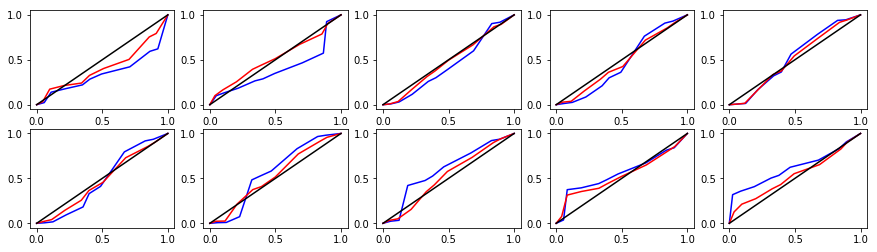

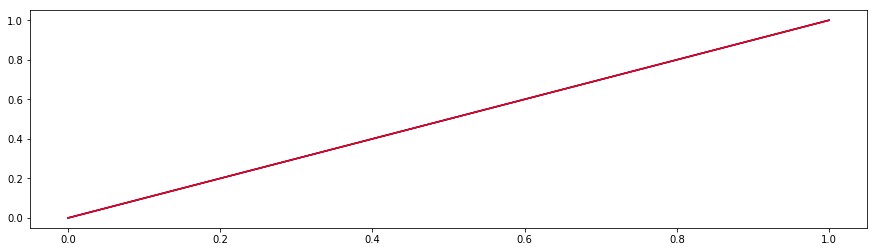

In [15]:
produce_plots(sgdClassifier, pca_train_x, pca_train_y, pca_test_x, pca_test_y)

# PCA 1500 on SGD Classifier

c:\python\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\python\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\python\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\python\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


-- Epoch 1-- Epoch 1
-- Epoch 1
-- Epoch 1

Norm: 483.60, NNZs: 1500, Bias: -3090.740804, T: 50000, Avg. loss: 305.918629
Total training time: 0.22 seconds.
-- Epoch 2
Norm: 425.80, NNZs: 1500, Bias: -2640.385901, T: 50000, Avg. loss: 357.739887
Total training time: 0.21 seconds.
-- Epoch 2
Norm: 388.30, NNZs: 1500, Bias: -3104.919878, T: 50000, Avg. loss: 328.072176
Total training time: 0.27 seconds.
-- Epoch 2
Norm: 375.38, NNZs: 1500, Bias: -2778.384021, T: 50000, Avg. loss: 379.930693
Total training time: 0.26 seconds.
-- Epoch 2
Norm: 433.37, NNZs: 1500, Bias: -2776.836343, T: 100000, Avg. loss: 140.434951
Total training time: 0.41 seconds.
-- Epoch 3
Norm: 375.05, NNZs: 1500, Bias: -2196.866603, T: 100000, Avg. loss: 165.463952
Total training time: 0.42 seconds.
-- Epoch 3
Norm: 323.50, NNZs: 1500, Bias: -2355.669812, T: 100000, Avg. loss: 175.044381
Total training time: 0.43 seconds.
-- Epoch 3
Norm: 342.83, NNZs: 1500, Bias: -2793.798363, T: 100000, Avg. loss: 146.660068
Total 

-- Epoch 19
Norm: 212.75, NNZs: 1500, Bias: -994.215547, T: 850000, Avg. loss: 63.213099
Total training time: 3.38 seconds.
-- Epoch 18
Norm: 260.02, NNZs: 1500, Bias: -1767.683210, T: 900000, Avg. loss: 79.817935
Total training time: 3.43 seconds.
-- Epoch 19
Norm: 210.43, NNZs: 1500, Bias: -765.880737, T: 900000, Avg. loss: 48.956692
Total training time: 3.45 seconds.
-- Epoch 19
Norm: 308.61, NNZs: 1500, Bias: -1725.517110, T: 950000, Avg. loss: 74.824483
Total training time: 3.56 seconds.
-- Epoch 20
Norm: 209.04, NNZs: 1500, Bias: -958.217255, T: 900000, Avg. loss: 60.759149
Total training time: 3.57 seconds.
-- Epoch 19
Norm: 258.37, NNZs: 1500, Bias: -1742.240830, T: 950000, Avg. loss: 78.588622
Total training time: 3.61 seconds.
-- Epoch 20
Norm: 205.67, NNZs: 1500, Bias: -731.710714, T: 950000, Avg. loss: 46.660602
Total training time: 3.65 seconds.
-- Epoch 20
Norm: 306.57, NNZs: 1500, Bias: -1701.540176, T: 1000000, Avg. loss: 73.698721
Total training time: 3.75 seconds.
-- 

-- Epoch 35
Norm: 234.72, NNZs: 1500, Bias: -1456.421888, T: 1750000, Avg. loss: 64.759878
Total training time: 6.57 seconds.
-- Epoch 36
Norm: 163.18, NNZs: 1500, Bias: -562.531312, T: 1700000, Avg. loss: 34.928659
Total training time: 6.60 seconds.
-- Epoch 35
Norm: 274.50, NNZs: 1500, Bias: -1429.966759, T: 1800000, Avg. loss: 60.896451
Total training time: 6.65 seconds.
-- Epoch 37
Norm: 144.56, NNZs: 1500, Bias: -355.358875, T: 1750000, Avg. loss: 22.226606
Total training time: 6.70 seconds.
-- Epoch 36
Norm: 232.93, NNZs: 1500, Bias: -1443.393697, T: 1800000, Avg. loss: 64.099271
Total training time: 6.77 seconds.
-- Epoch 37
Norm: 160.92, NNZs: 1500, Bias: -544.787995, T: 1750000, Avg. loss: 33.761257
Total training time: 6.80 seconds.
-- Epoch 36
Norm: 273.18, NNZs: 1500, Bias: -1417.356997, T: 1850000, Avg. loss: 60.364233
Total training time: 6.85 seconds.
-- Epoch 38
Norm: 141.76, NNZs: 1500, Bias: -338.501547, T: 1800000, Avg. loss: 21.132063
Total training time: 6.89 secon

Norm: 130.93, NNZs: 1500, Bias: -329.573501, T: 2500000, Avg. loss: 20.248493Norm: 217.78, NNZs: 1500, Bias: -1272.402518, T: 2600000, Avg. loss: 56.127127
Total training time: 9.77 seconds.
-- Epoch 53

Total training time: 9.76 seconds.
-- Epoch 51
Norm: 253.05, NNZs: 1500, Bias: -1253.134281, T: 2650000, Avg. loss: 52.891265
Total training time: 9.83 seconds.
-- Epoch 54
Norm: 98.52, NNZs: 1500, Bias: -140.830540, T: 2550000, Avg. loss: 8.896568
Total training time: 9.84 seconds.
-- Epoch 52
Norm: 129.07, NNZs: 1500, Bias: -317.898440, T: 2550000, Avg. loss: 19.502657
Total training time: 10.03 seconds.
-- Epoch 52
Norm: 216.82, NNZs: 1500, Bias: -1263.597327, T: 2650000, Avg. loss: 55.724471
Total training time: 10.06 seconds.
-- Epoch 54
Norm: 252.08, NNZs: 1500, Bias: -1244.613411, T: 2700000, Avg. loss: 52.548999
Total training time: 10.13 seconds.
-- Epoch 55
Norm: 95.70, NNZs: 1500, Bias: -130.694135, T: 2600000, Avg. loss: 8.298066
Total training time: 10.16 seconds.
-- Epoch

Norm: 99.86, NNZs: 1500, Bias: -162.184100, T: 3350000, Avg. loss: 9.995421
Total training time: 13.16 seconds.
-- Epoch 68
Norm: 237.86, NNZs: 1500, Bias: -1126.897825, T: 3500000, Avg. loss: 47.295646
Total training time: 13.22 seconds.
-- Epoch 71
Norm: 48.66, NNZs: 1500, Bias: -23.896033, T: 3400000, Avg. loss: 1.984640
Total training time: 13.33 seconds.
-- Epoch 69
Norm: 205.13, NNZs: 1500, Bias: -1134.896864, T: 3500000, Avg. loss: 49.757710
Total training time: 13.35 seconds.
-- Epoch 71
Norm: 98.05, NNZs: 1500, Bias: -154.154311, T: 3400000, Avg. loss: 9.503632
Total training time: 13.41 seconds.
-- Epoch 69
Norm: 236.58, NNZs: 1500, Bias: -1120.593061, T: 3550000, Avg. loss: 47.001582
Total training time: 13.45 seconds.
-- Epoch 72
Norm: 204.75, NNZs: 1500, Bias: -1128.311787, T: 3550000, Avg. loss: 49.460089
Total training time: 13.54 seconds.
-- Epoch 72
Norm: 45.84, NNZs: 1500, Bias: -21.538765, T: 3450000, Avg. loss: 1.819908
Total training time: 13.53 seconds.
-- Epoch 7

Norm: 21.19, NNZs: 1500, Bias: -9.089852, T: 4150000, Avg. loss: 0.941734
Total training time: 16.45 seconds.
-- Epoch 84
Norm: 195.50, NNZs: 1500, Bias: -1034.818453, T: 4350000, Avg. loss: 45.175141
Total training time: 16.54 seconds.
-- Epoch 88
Norm: 224.07, NNZs: 1500, Bias: -1024.058220, T: 4400000, Avg. loss: 42.735275
Total training time: 16.57 seconds.
-- Epoch 89
Norm: 66.26, NNZs: 1500, Bias: -52.139135, T: 4200000, Avg. loss: 3.545754
Total training time: 16.57 seconds.
-- Epoch 85
Norm: 20.29, NNZs: 1500, Bias: -8.728554, T: 4200000, Avg. loss: 0.915598
Total training time: 16.64 seconds.
-- Epoch 85
Norm: 194.91, NNZs: 1500, Bias: -1029.584664, T: 4400000, Avg. loss: 44.939096
Total training time: 16.71 seconds.
-- Epoch 89
Norm: 223.50, NNZs: 1500, Bias: -1018.972188, T: 4450000, Avg. loss: 42.538657
Total training time: 16.74 seconds.
-- Epoch 90
Norm: 64.01, NNZs: 1500, Bias: -47.718289, T: 4250000, Avg. loss: 3.307106
Total training time: 16.79 seconds.
-- Epoch 86
No

-- Epoch 100
Norm: 33.27, NNZs: 1500, Bias: -13.436359, T: 5000000, Avg. loss: 1.237668
Total training time: 19.78 seconds.
-- Epoch 101
Norm: 213.34, NNZs: 1500, Bias: -940.852303, T: 5300000, Avg. loss: 39.104134
Total training time: 19.86 seconds.
-- Epoch 107
Norm: 186.93, NNZs: 1500, Bias: -948.640169, T: 5250000, Avg. loss: 41.277048
Total training time: 19.87 seconds.
-- Epoch 106
Norm: 11.57, NNZs: 1500, Bias: -6.673268, T: 5000000, Avg. loss: 0.747527
Total training time: 19.90 seconds.
-- Epoch 101
Norm: 31.70, NNZs: 1500, Bias: -12.692181, T: 5050000, Avg. loss: 1.191828
Total training time: 19.98 seconds.
-- Epoch 102
Norm: 212.57, NNZs: 1500, Bias: -936.721972, T: 5350000, Avg. loss: 38.898527
Total training time: 20.07 seconds.
-- Epoch 108
Norm: 186.50, NNZs: 1500, Bias: -944.302983, T: 5300000, Avg. loss: 41.071104
Total training time: 20.10 seconds.
-- Epoch 107
Norm: 11.30, NNZs: 1500, Bias: -6.422636, T: 5050000, Avg. loss: 0.735895
Total training time: 20.12 seconds

-- Epoch 117
Norm: 203.90, NNZs: 1500, Bias: -871.202221, T: 6200000, Avg. loss: 36.053727
Total training time: 23.18 seconds.
-- Epoch 125
Norm: 8.32, NNZs: 1500, Bias: -5.701568, T: 5800000, Avg. loss: 0.660204
Total training time: 23.19 seconds.
-- Epoch 117
Norm: 179.56, NNZs: 1500, Bias: -876.419095, T: 6150000, Avg. loss: 37.991679
Total training time: 23.29 seconds.
-- Epoch 124
Norm: 203.42, NNZs: 1500, Bias: -867.642907, T: 6250000, Avg. loss: 35.926370
Total training time: 23.37 seconds.
-- Epoch 126
Norm: 16.15, NNZs: 1500, Bias: -7.045042, T: 5850000, Avg. loss: 0.781097
Total training time: 23.37 seconds.
-- Epoch 118
Norm: 8.19, NNZs: 1500, Bias: -5.658188, T: 5850000, Avg. loss: 0.654277
Total training time: 23.39 seconds.
-- Epoch 118
Norm: 179.01, NNZs: 1500, Bias: -872.764713, T: 6200000, Avg. loss: 37.827968
Total training time: 23.49 seconds.
-- Epoch 125
Norm: 202.82, NNZs: 1500, Bias: -864.146799, T: 6300000, Avg. loss: 35.753577
Total training time: 23.54 seconds

Norm: 195.58, NNZs: 1500, Bias: -811.347059, T: 7100000, Avg. loss: 33.504611
Total training time: 26.49 seconds.
-- Epoch 143
Norm: 10.38, NNZs: 1500, Bias: -5.667389, T: 6600000, Avg. loss: 0.671296
Total training time: 26.48 seconds.
-- Epoch 133
Norm: 173.16, NNZs: 1500, Bias: -817.611254, T: 7000000, Avg. loss: 35.374154
Total training time: 26.50 seconds.
-- Epoch 141
Norm: 6.78, NNZs: 1500, Bias: -5.107760, T: 6600000, Avg. loss: 0.604232
Total training time: 26.59 seconds.
-- Epoch 133
Norm: 172.80, NNZs: 1500, Bias: -814.384567, T: 7050000, Avg. loss: 35.193513
Total training time: 26.70 seconds.
-- Epoch 142
Norm: 10.13, NNZs: 1500, Bias: -5.705265, T: 6650000, Avg. loss: 0.671737
Total training time: 26.70 seconds.
-- Epoch 134
Norm: 195.24, NNZs: 1500, Bias: -808.237325, T: 7150000, Avg. loss: 33.328580
Total training time: 26.72 seconds.
-- Epoch 144
Norm: 6.72, NNZs: 1500, Bias: -5.089765, T: 6650000, Avg. loss: 0.597095
Total training time: 26.78 seconds.
-- Epoch 134
No

Norm: 5.95, NNZs: 1500, Bias: -4.729246, T: 7350000, Avg. loss: 0.561246
Total training time: 29.75 seconds.
-- Epoch 148
Norm: 167.41, NNZs: 1500, Bias: -765.725860, T: 7850000, Avg. loss: 33.030607
Total training time: 29.79 seconds.
-- Epoch 158
Norm: 7.63, NNZs: 1500, Bias: -5.001335, T: 7400000, Avg. loss: 0.614302
Total training time: 29.88 seconds.
-- Epoch 149
Norm: 188.47, NNZs: 1500, Bias: -758.840930, T: 8000000, Avg. loss: 31.226811
Total training time: 29.91 seconds.
-- Epoch 161
Norm: 167.16, NNZs: 1500, Bias: -762.841173, T: 7900000, Avg. loss: 32.895976
Total training time: 29.95 seconds.
-- Epoch 159
Norm: 5.92, NNZs: 1500, Bias: -4.678921, T: 7400000, Avg. loss: 0.561031
Total training time: 29.97 seconds.
-- Epoch 149
Norm: 188.02, NNZs: 1500, Bias: -756.124479, T: 8050000, Avg. loss: 31.114172
Total training time: 30.07 seconds.
-- Epoch 162
Norm: 7.53, NNZs: 1500, Bias: -5.036186, T: 7450000, Avg. loss: 0.607097
Total training time: 30.07 seconds.
-- Epoch 150
Norm

Norm: 162.10, NNZs: 1500, Bias: -716.701374, T: 8750000, Avg. loss: 30.827832
Total training time: 32.86 seconds.
-- Epoch 176
Norm: 5.32, NNZs: 1500, Bias: -4.383479, T: 8150000, Avg. loss: 0.527603
Total training time: 32.85 seconds.
-- Epoch 164
Norm: 6.26, NNZs: 1500, Bias: -4.636308, T: 8200000, Avg. loss: 0.571177
Total training time: 32.89 seconds.
-- Epoch 165
Norm: 181.77, NNZs: 1500, Bias: -712.228262, T: 8900000, Avg. loss: 29.212132
Total training time: 32.93 seconds.
-- Epoch 179
Norm: 161.80, NNZs: 1500, Bias: -714.135444, T: 8800000, Avg. loss: 30.731181
Total training time: 33.02 seconds.
-- Epoch 177
Norm: 5.28, NNZs: 1500, Bias: -4.351738, T: 8200000, Avg. loss: 0.529787
Total training time: 33.03 seconds.
-- Epoch 165
Norm: 6.22, NNZs: 1500, Bias: -4.614443, T: 8250000, Avg. loss: 0.566832
Total training time: 33.07 seconds.
-- Epoch 166
Norm: 181.39, NNZs: 1500, Bias: -709.793846, T: 8950000, Avg. loss: 29.111326
Total training time: 33.10 seconds.
-- Epoch 180
Norm

Norm: 5.45, NNZs: 1500, Bias: -4.229735, T: 9000000, Avg. loss: 0.537315
Total training time: 35.92 seconds.
-- Epoch 181
Norm: 4.87, NNZs: 1500, Bias: -4.095900, T: 8950000, Avg. loss: 0.498756
Total training time: 35.92 seconds.
-- Epoch 180
Norm: 175.70, NNZs: 1500, Bias: -670.295479, T: 9800000, Avg. loss: 27.427305
Total training time: 36.00 seconds.
-- Epoch 197
Norm: 156.68, NNZs: 1500, Bias: -670.380652, T: 9700000, Avg. loss: 28.735586
Total training time: 36.03 seconds.
-- Epoch 195
Norm: 5.39, NNZs: 1500, Bias: -4.291770, T: 9050000, Avg. loss: 0.533938
Total training time: 36.10 seconds.
-- Epoch 182
Norm: 4.87, NNZs: 1500, Bias: -4.082377, T: 9000000, Avg. loss: 0.501342
Total training time: 36.13 seconds.
-- Epoch 181
Norm: 175.44, NNZs: 1500, Bias: -668.068833, T: 9850000, Avg. loss: 27.328616
Total training time: 36.16 seconds.
-- Epoch 198
Norm: 156.43, NNZs: 1500, Bias: -668.068290, T: 9750000, Avg. loss: 28.662426
Total training time: 36.20 seconds.
-- Epoch 196
Norm

-- Epoch 197
Norm: 170.14, NNZs: 1500, Bias: -632.207641, T: 10700000, Avg. loss: 25.810344
Total training time: 39.01 seconds.
-- Epoch 215
Norm: 4.52, NNZs: 1500, Bias: -3.830832, T: 9750000, Avg. loss: 0.476788
Total training time: 39.04 seconds.
-- Epoch 196
Norm: 152.11, NNZs: 1500, Bias: -630.603059, T: 10600000, Avg. loss: 27.002139
Total training time: 39.09 seconds.
-- Epoch 213
Norm: 169.81, NNZs: 1500, Bias: -630.199368, T: 10750000, Avg. loss: 25.726949
Total training time: 39.17 seconds.
-- Epoch 216
Norm: 4.92, NNZs: 1500, Bias: -4.053539, T: 9850000, Avg. loss: 0.511813
Total training time: 39.17 seconds.
-- Epoch 198
Norm: 151.82, NNZs: 1500, Bias: -628.507280, T: 10650000, Avg. loss: 26.910733
Total training time: 39.26 seconds.
-- Epoch 214
Norm: 4.49, NNZs: 1500, Bias: -3.827740, T: 9800000, Avg. loss: 0.480053
Total training time: 39.24 seconds.
-- Epoch 197
Norm: 169.50, NNZs: 1500, Bias: -628.197689, T: 10800000, Avg. loss: 25.630816
Total training time: 39.34 sec

-- Epoch 212
Norm: 164.67, NNZs: 1500, Bias: -595.504169, T: 11650000, Avg. loss: 24.255525
Total training time: 42.22 seconds.
-- Epoch 234
Norm: 4.46, NNZs: 1500, Bias: -3.819289, T: 10650000, Avg. loss: 0.490425
Total training time: 42.22 seconds.
-- Epoch 214
Norm: 147.43, NNZs: 1500, Bias: -592.301966, T: 11550000, Avg. loss: 25.304778
Total training time: 42.28 seconds.
-- Epoch 232
Norm: 4.23, NNZs: 1500, Bias: -3.665015, T: 10600000, Avg. loss: 0.455840
Total training time: 42.29 seconds.
-- Epoch 213
Norm: 164.39, NNZs: 1500, Bias: -593.661897, T: 11700000, Avg. loss: 24.165661
Total training time: 42.38 seconds.
-- Epoch 235
Norm: 4.43, NNZs: 1500, Bias: -3.811809, T: 10700000, Avg. loss: 0.487718
Total training time: 42.40 seconds.
-- Epoch 215
Norm: 147.23, NNZs: 1500, Bias: -590.369603, T: 11600000, Avg. loss: 25.206042
Total training time: 42.43 seconds.
-- Epoch 233
Norm: 4.21, NNZs: 1500, Bias: -3.633101, T: 10650000, Avg. loss: 0.457285
Total training time: 42.49 secon

Norm: 143.51, NNZs: 1500, Bias: -560.723357, T: 12400000, Avg. loss: 23.905786
Total training time: 45.17 seconds.
-- Epoch 249
Norm: 4.03, NNZs: 1500, Bias: -3.488020, T: 11350000, Avg. loss: 0.439173
Total training time: 45.17 seconds.
-- Epoch 228
Norm: 4.20, NNZs: 1500, Bias: -3.640367, T: 11450000, Avg. loss: 0.469153
Total training time: 45.24 seconds.
-- Epoch 230
Norm: 159.91, NNZs: 1500, Bias: -563.512641, T: 12550000, Avg. loss: 22.898487
Total training time: 45.26 seconds.
-- Epoch 252
Norm: 143.26, NNZs: 1500, Bias: -558.941659, T: 12450000, Avg. loss: 23.833227
Total training time: 45.33 seconds.
-- Epoch 250
Norm: 4.02, NNZs: 1500, Bias: -3.505500, T: 11400000, Avg. loss: 0.440020
Total training time: 45.35 seconds.
-- Epoch 229
Norm: 159.58, NNZs: 1500, Bias: -561.828405, T: 12600000, Avg. loss: 22.816020
Total training time: 45.43 seconds.
-- Epoch 253
Norm: 4.17, NNZs: 1500, Bias: -3.647310, T: 11500000, Avg. loss: 0.470101
Total training time: 45.46 seconds.
-- Epoch 

-- Epoch 244
Norm: 3.94, NNZs: 1500, Bias: -3.472627, T: 12250000, Avg. loss: 0.456151
Total training time: 48.33 seconds.
-- Epoch 246
Norm: 139.33, NNZs: 1500, Bias: -528.011011, T: 13350000, Avg. loss: 22.474276
Total training time: 48.41 seconds.
-- Epoch 268
Norm: 155.16, NNZs: 1500, Bias: -532.284192, T: 13500000, Avg. loss: 21.575786
Total training time: 48.47 seconds.
-- Epoch 271
Norm: 3.83, NNZs: 1500, Bias: -3.320963, T: 12200000, Avg. loss: 0.424708
Total training time: 48.49 seconds.
-- Epoch 245
Norm: 3.93, NNZs: 1500, Bias: -3.470304, T: 12300000, Avg. loss: 0.452137
Total training time: 48.52 seconds.
-- Epoch 247
Norm: 139.11, NNZs: 1500, Bias: -526.358042, T: 13400000, Avg. loss: 22.394668
Total training time: 48.58 seconds.
-- Epoch 269
Norm: 154.89, NNZs: 1500, Bias: -530.712396, T: 13550000, Avg. loss: 21.514842
Total training time: 48.65 seconds.
-- Epoch 272
Norm: 3.80, NNZs: 1500, Bias: -3.329986, T: 12250000, Avg. loss: 0.425316
Total training time: 48.69 secon

Norm: 3.64, NNZs: 1500, Bias: -3.176083, T: 12950000, Avg. loss: 0.414162
Total training time: 51.40 seconds.
-- Epoch 260
Norm: 135.54, NNZs: 1500, Bias: -499.210932, T: 14250000, Avg. loss: 21.201538
Total training time: 51.45 seconds.
-- Epoch 286
Norm: 150.83, NNZs: 1500, Bias: -504.804179, T: 14400000, Avg. loss: 20.401459
Total training time: 51.56 seconds.
-- Epoch 289
Norm: 3.76, NNZs: 1500, Bias: -3.344009, T: 13100000, Avg. loss: 0.437588
Total training time: 51.57 seconds.
-- Epoch 263
Norm: 3.62, NNZs: 1500, Bias: -3.199909, T: 13000000, Avg. loss: 0.412645
Total training time: 51.61 seconds.
-- Epoch 261
Norm: 135.35, NNZs: 1500, Bias: -497.664268, T: 14300000, Avg. loss: 21.135158
Total training time: 51.63 seconds.
-- Epoch 287
Norm: 150.58, NNZs: 1500, Bias: -503.338039, T: 14450000, Avg. loss: 20.343809
Total training time: 51.74 seconds.
-- Epoch 290
Norm: 3.74, NNZs: 1500, Bias: -3.358367, T: 13150000, Avg. loss: 0.439243
Total training time: 51.77 seconds.
-- Epoch 

Norm: 3.59, NNZs: 1500, Bias: -3.224410, T: 13850000, Avg. loss: 0.429263
Total training time: 54.47 seconds.
-- Epoch 278
Norm: 132.06, NNZs: 1500, Bias: -472.230621, T: 15150000, Avg. loss: 20.016093
Total training time: 54.53 seconds.
-- Epoch 304
Norm: 3.48, NNZs: 1500, Bias: -3.097280, T: 13750000, Avg. loss: 0.401928
Total training time: 54.54 seconds.
-- Epoch 276
Norm: 146.83, NNZs: 1500, Bias: -479.064344, T: 15300000, Avg. loss: 19.330633
Total training time: 54.59 seconds.
-- Epoch 307
Norm: 3.57, NNZs: 1500, Bias: -3.192049, T: 13900000, Avg. loss: 0.429859
Total training time: 54.67 seconds.
-- Epoch 279
Norm: 131.84, NNZs: 1500, Bias: -470.788276, T: 15200000, Avg. loss: 19.956942
Total training time: 54.69 seconds.
-- Epoch 305
Norm: 146.61, NNZs: 1500, Bias: -477.684319, T: 15350000, Avg. loss: 19.278505
Total training time: 54.76 seconds.
-- Epoch 308
Norm: 3.47, NNZs: 1500, Bias: -3.097309, T: 13800000, Avg. loss: 0.399614
Total training time: 54.75 seconds.
-- Epoch 

Norm: 3.38, NNZs: 1500, Bias: -2.989926, T: 14500000, Avg. loss: 0.394530
Total training time: 57.51 seconds.
-- Epoch 291
Norm: 143.02, NNZs: 1500, Bias: -454.894637, T: 16200000, Avg. loss: 18.315871
Total training time: 57.64 seconds.
-- Epoch 325
Norm: 128.66, NNZs: 1500, Bias: -446.910727, T: 16050000, Avg. loss: 18.913734
Total training time: 57.65 seconds.
-- Epoch 322
Norm: 3.44, NNZs: 1500, Bias: -3.103814, T: 14650000, Avg. loss: 0.413390
Total training time: 57.64 seconds.
-- Epoch 294
Norm: 3.38, NNZs: 1500, Bias: -3.008533, T: 14550000, Avg. loss: 0.390993
Total training time: 57.72 seconds.
-- Epoch 292
Norm: 128.44, NNZs: 1500, Bias: -445.559607, T: 16100000, Avg. loss: 18.843513
Total training time: 57.84 seconds.
-- Epoch 323
Norm: 142.84, NNZs: 1500, Bias: -453.585030, T: 16250000, Avg. loss: 18.268115
Total training time: 57.84 seconds.
-- Epoch 326
Norm: 3.43, NNZs: 1500, Bias: -3.120161, T: 14700000, Avg. loss: 0.415890
Total training time: 57.84 seconds.
-- Epoch 

-- Epoch 340
Norm: 139.41, NNZs: 1500, Bias: -432.109435, T: 17100000, Avg. loss: 17.371916
Total training time: 61.10 seconds.
-- Epoch 343
Norm: 3.28, NNZs: 1500, Bias: -2.939014, T: 15300000, Avg. loss: 0.383258
Total training time: 61.08 seconds.
-- Epoch 307
Norm: 3.31, NNZs: 1500, Bias: -3.072227, T: 15450000, Avg. loss: 0.405546
Total training time: 61.19 seconds.
-- Epoch 310
Norm: 125.26, NNZs: 1500, Bias: -421.761844, T: 17000000, Avg. loss: 17.811849
Total training time: 61.38 seconds.
-- Epoch 341
Norm: 139.20, NNZs: 1500, Bias: -430.885526, T: 17150000, Avg. loss: 17.318705
Total training time: 61.39 seconds.
-- Epoch 344
Norm: 3.27, NNZs: 1500, Bias: -2.921360, T: 15350000, Avg. loss: 0.381944
Total training time: 61.41 seconds.
-- Epoch 308
Norm: 3.30, NNZs: 1500, Bias: -3.041224, T: 15500000, Avg. loss: 0.405766
Total training time: 61.57 seconds.
-- Epoch 311
Norm: 125.09, NNZs: 1500, Bias: -420.479052, T: 17050000, Avg. loss: 17.754253
Total training time: 61.73 secon

Norm: 3.14, NNZs: 1500, Bias: -2.811879, T: 16100000, Avg. loss: 0.375065
Total training time: 66.54 seconds.
-- Epoch 323
Norm: 122.38, NNZs: 1500, Bias: -400.480959, T: 17850000, Avg. loss: 16.888129
Total training time: 66.58 seconds.
-- Epoch 358
Norm: 135.98, NNZs: 1500, Bias: -410.570310, T: 18000000, Avg. loss: 16.464927
Total training time: 66.59 seconds.
-- Epoch 361
Norm: 3.19, NNZs: 1500, Bias: -2.941096, T: 16250000, Avg. loss: 0.397827
Total training time: 66.62 seconds.
-- Epoch 326
Norm: 122.20, NNZs: 1500, Bias: -399.268138, T: 17900000, Avg. loss: 16.831668
Total training time: 66.76 seconds.
-- Epoch 359
Norm: 3.14, NNZs: 1500, Bias: -2.853402, T: 16150000, Avg. loss: 0.373715
Total training time: 66.75 seconds.
-- Epoch 324
Norm: 135.76, NNZs: 1500, Bias: -409.419211, T: 18050000, Avg. loss: 16.421354
Total training time: 66.77 seconds.
-- Epoch 362
Norm: 3.19, NNZs: 1500, Bias: -2.949142, T: 16300000, Avg. loss: 0.395311
Total training time: 66.84 seconds.
-- Epoch 

Norm: 119.47, NNZs: 1500, Bias: -379.085514, T: 18750000, Avg. loss: 15.953806
Total training time: 70.11 seconds.
-- Epoch 376
Norm: 3.03, NNZs: 1500, Bias: -2.772219, T: 16900000, Avg. loss: 0.367145
Total training time: 70.10 seconds.
-- Epoch 339
Norm: 3.07, NNZs: 1500, Bias: -2.869445, T: 17050000, Avg. loss: 0.385966
Total training time: 70.25 seconds.
-- Epoch 342
Norm: 132.46, NNZs: 1500, Bias: -389.076841, T: 18950000, Avg. loss: 15.573666
Total training time: 70.28 seconds.
-- Epoch 380
Norm: 119.28, NNZs: 1500, Bias: -377.939389, T: 18800000, Avg. loss: 15.906459
Total training time: 70.31 seconds.
-- Epoch 377
Norm: 3.03, NNZs: 1500, Bias: -2.753886, T: 16950000, Avg. loss: 0.367136
Total training time: 70.34 seconds.
-- Epoch 340
Norm: 132.26, NNZs: 1500, Bias: -387.983876, T: 19000000, Avg. loss: 15.518459
Total training time: 70.48 seconds.
-- Epoch 381
Norm: 3.06, NNZs: 1500, Bias: -2.870018, T: 17100000, Avg. loss: 0.387054
Total training time: 70.47 seconds.
-- Epoch 

-- Epoch 397
Norm: 2.97, NNZs: 1500, Bias: -2.784711, T: 17800000, Avg. loss: 0.382180
Total training time: 73.65 seconds.
-- Epoch 357
Norm: 116.64, NNZs: 1500, Bias: -358.768187, T: 19650000, Avg. loss: 15.068836
Total training time: 73.71 seconds.
-- Epoch 394
Norm: 2.93, NNZs: 1500, Bias: -2.672568, T: 17700000, Avg. loss: 0.359275
Total training time: 73.70 seconds.
-- Epoch 355
Norm: 129.21, NNZs: 1500, Bias: -369.783396, T: 19850000, Avg. loss: 14.770176
Total training time: 73.84 seconds.
-- Epoch 398
Norm: 116.49, NNZs: 1500, Bias: -357.665845, T: 19700000, Avg. loss: 15.025148
Total training time: 73.89 seconds.
-- Epoch 395
Norm: 2.97, NNZs: 1500, Bias: -2.809407, T: 17850000, Avg. loss: 0.379904
Total training time: 73.88 seconds.
-- Epoch 358
Norm: 2.91, NNZs: 1500, Bias: -2.712609, T: 17750000, Avg. loss: 0.360756
Total training time: 73.92 seconds.
-- Epoch 356
Norm: 129.04, NNZs: 1500, Bias: -368.738433, T: 19900000, Avg. loss: 14.725134
Total training time: 74.00 secon

Norm: 2.85, NNZs: 1500, Bias: -2.624096, T: 18450000, Avg. loss: 0.354093
Total training time: 77.38 seconds.
-- Epoch 370
Norm: 114.00, NNZs: 1500, Bias: -340.496396, T: 20500000, Avg. loss: 14.280619
Total training time: 77.45 seconds.
-- Epoch 411
Norm: 126.20, NNZs: 1500, Bias: -352.431056, T: 20700000, Avg. loss: 14.055078
Total training time: 77.52 seconds.
-- Epoch 415
Norm: 2.90, NNZs: 1500, Bias: -2.735908, T: 18600000, Avg. loss: 0.372503
Total training time: 77.71 seconds.
-- Epoch 373
Norm: 113.83, NNZs: 1500, Bias: -339.452370, T: 20550000, Avg. loss: 14.231742
Total training time: 77.73 seconds.
-- Epoch 412
Norm: 2.84, NNZs: 1500, Bias: -2.638707, T: 18500000, Avg. loss: 0.353995
Total training time: 77.74 seconds.
-- Epoch 371
Norm: 126.04, NNZs: 1500, Bias: -351.430844, T: 20750000, Avg. loss: 14.003702
Total training time: 77.81 seconds.
-- Epoch 416
Norm: 113.73, NNZs: 1500, Bias: -338.390930, T: 20600000, Avg. loss: 14.179679
Total training time: 77.95 seconds.
-- E

-- Epoch 429
Norm: 2.77, NNZs: 1500, Bias: -2.593424, T: 19250000, Avg. loss: 0.347716
Total training time: 81.86 seconds.
-- Epoch 386
Norm: 2.79, NNZs: 1500, Bias: -2.652084, T: 19350000, Avg. loss: 0.367708
Total training time: 81.89 seconds.
-- Epoch 388
Norm: 123.05, NNZs: 1500, Bias: -333.905541, T: 21650000, Avg. loss: 13.287113
Total training time: 81.99 seconds.
-- Epoch 434
Norm: 111.15, NNZs: 1500, Bias: -321.017996, T: 21450000, Avg. loss: 13.438389
Total training time: 82.04 seconds.
-- Epoch 430
Norm: 2.75, NNZs: 1500, Bias: -2.568517, T: 19300000, Avg. loss: 0.347840
Total training time: 82.09 seconds.
-- Epoch 387
Norm: 2.79, NNZs: 1500, Bias: -2.658295, T: 19400000, Avg. loss: 0.364460
Total training time: 82.11 seconds.
-- Epoch 389
Norm: 122.86, NNZs: 1500, Bias: -332.964429, T: 21700000, Avg. loss: 13.243443
Total training time: 82.18 seconds.
-- Epoch 435
Norm: 110.99, NNZs: 1500, Bias: -320.024342, T: 21500000, Avg. loss: 13.397883
Total training time: 82.20 secon

Norm: 120.29, NNZs: 1500, Bias: -318.082162, T: 22500000, Avg. loss: 12.632982
Total training time: 86.53 seconds.
-- Epoch 451
Norm: 2.67, NNZs: 1500, Bias: -2.520810, T: 20000000, Avg. loss: 0.343419
Total training time: 86.51 seconds.
-- Epoch 401
Norm: 108.69, NNZs: 1500, Bias: -304.366271, T: 22300000, Avg. loss: 12.718863
Total training time: 86.64 seconds.
-- Epoch 447
Norm: 2.74, NNZs: 1500, Bias: -2.613944, T: 20150000, Avg. loss: 0.360411
Total training time: 86.67 seconds.
-- Epoch 404
Norm: 120.11, NNZs: 1500, Bias: -317.180520, T: 22550000, Avg. loss: 12.584012
Total training time: 86.85 seconds.
-- Epoch 452
Norm: 2.67, NNZs: 1500, Bias: -2.525816, T: 20050000, Avg. loss: 0.343050
Total training time: 86.92 seconds.
-- Epoch 402
Norm: 108.57, NNZs: 1500, Bias: -303.398809, T: 22350000, Avg. loss: 12.673461
Total training time: 87.01 seconds.
-- Epoch 448
Norm: 2.73, NNZs: 1500, Bias: -2.603997, T: 20200000, Avg. loss: 0.360629
Total training time: 87.06 seconds.
-- Epoch 

Norm: 2.61, NNZs: 1500, Bias: -2.441438, T: 20800000, Avg. loss: 0.338764
Total training time: 90.97 seconds.
-- Epoch 417
Norm: 117.27, NNZs: 1500, Bias: -301.172331, T: 23450000, Avg. loss: 11.939105
Total training time: 91.03 seconds.
-- Epoch 470
Norm: 2.65, NNZs: 1500, Bias: -2.568044, T: 20950000, Avg. loss: 0.355412
Total training time: 91.04 seconds.
-- Epoch 420
Norm: 106.01, NNZs: 1500, Bias: -286.556959, T: 23250000, Avg. loss: 11.951349
Total training time: 91.17 seconds.
-- Epoch 466
Norm: 2.61, NNZs: 1500, Bias: -2.455868, T: 20850000, Avg. loss: 0.337723
Total training time: 91.22 seconds.
-- Epoch 418
Norm: 117.09, NNZs: 1500, Bias: -300.313579, T: 23500000, Avg. loss: 11.906579
Total training time: 91.25 seconds.
-- Epoch 471
Norm: 2.64, NNZs: 1500, Bias: -2.569948, T: 21000000, Avg. loss: 0.354475
Total training time: 91.28 seconds.
-- Epoch 421
Norm: 105.87, NNZs: 1500, Bias: -285.644012, T: 23300000, Avg. loss: 11.913502
Total training time: 91.37 seconds.
-- Epoch 

Norm: 2.56, NNZs: 1500, Bias: -2.504848, T: 21700000, Avg. loss: 0.351084
Total training time: 94.99 seconds.
-- Epoch 435
Norm: 103.63, NNZs: 1500, Bias: -271.309629, T: 24100000, Avg. loss: 11.301570
Total training time: 95.09 seconds.
-- Epoch 483
Norm: 114.52, NNZs: 1500, Bias: -285.833539, T: 24350000, Avg. loss: 11.314058
Total training time: 95.12 seconds.
-- Epoch 488
Norm: 2.55, NNZs: 1500, Bias: -2.422196, T: 21600000, Avg. loss: 0.334472
Total training time: 95.16 seconds.
-- Epoch 433
Norm: 2.56, NNZs: 1500, Bias: -2.505789, T: 21750000, Avg. loss: 0.349530
Total training time: 95.30 seconds.
-- Epoch 436
Norm: 103.51, NNZs: 1500, Bias: -270.422626, T: 24150000, Avg. loss: 11.262635
Total training time: 95.36 seconds.
-- Epoch 484
Norm: 114.32, NNZs: 1500, Bias: -285.020441, T: 24400000, Avg. loss: 11.276426
Total training time: 95.36 seconds.
-- Epoch 489
Norm: 2.53, NNZs: 1500, Bias: -2.416176, T: 21650000, Avg. loss: 0.334426
Total training time: 95.45 seconds.
-- Epoch 

Norm: 101.16, NNZs: 1500, Bias: -255.804267, T: 25000000, Avg. loss: 10.634543
Total training time: 98.54 seconds.
-- Epoch 501
Norm: 111.77, NNZs: 1500, Bias: -271.145709, T: 25250000, Avg. loss: 10.706978
Total training time: 98.57 seconds.
-- Epoch 506
Norm: 2.50, NNZs: 1500, Bias: -2.465565, T: 22500000, Avg. loss: 0.347083
Total training time: 98.65 seconds.
-- Epoch 451
Norm: 2.49, NNZs: 1500, Bias: -2.397720, T: 22400000, Avg. loss: 0.328757
Total training time: 98.74 seconds.
-- Epoch 449
Norm: 101.03, NNZs: 1500, Bias: -254.959939, T: 25050000, Avg. loss: 10.600030
Total training time: 98.77 seconds.
-- Epoch 502
Norm: 111.62, NNZs: 1500, Bias: -270.348510, T: 25300000, Avg. loss: 10.675538
Total training time: 98.79 seconds.
-- Epoch 507
Norm: 2.48, NNZs: 1500, Bias: -2.468233, T: 22550000, Avg. loss: 0.346801
Total training time: 98.84 seconds.
-- Epoch 452
Norm: 100.89, NNZs: 1500, Bias: -254.118088, T: 25100000, Avg. loss: 10.562992
Total training time: 98.93 seconds.
-- E

-- Epoch 466
Norm: 109.11, NNZs: 1500, Bias: -257.030983, T: 26150000, Avg. loss: 10.131260
Total training time: 101.60 seconds.
-- Epoch 524
Norm: 98.76, NNZs: 1500, Bias: -240.905822, T: 25900000, Avg. loss: 9.998143
Total training time: 101.62 seconds.
-- Epoch 519
Norm: 2.43, NNZs: 1500, Bias: -2.329188, T: 23150000, Avg. loss: 0.325459
Total training time: 101.65 seconds.
-- Epoch 464
Norm: 2.43, NNZs: 1500, Bias: -2.438899, T: 23300000, Avg. loss: 0.343151
Total training time: 101.72 seconds.
-- Epoch 467
Norm: 108.97, NNZs: 1500, Bias: -256.261206, T: 26200000, Avg. loss: 10.101556
Total training time: 101.75 seconds.
-- Epoch 525
Norm: 98.62, NNZs: 1500, Bias: -240.100439, T: 25950000, Avg. loss: 9.967220
Total training time: 101.79 seconds.
-- Epoch 520
Norm: 2.43, NNZs: 1500, Bias: -2.325717, T: 23200000, Avg. loss: 0.322741
Total training time: 101.84 seconds.
-- Epoch 465
Norm: 108.81, NNZs: 1500, Bias: -255.504695, T: 26250000, Avg. loss: 10.073606
Total training time: 101

Norm: 2.37, NNZs: 1500, Bias: -2.302810, T: 23900000, Avg. loss: 0.320954
Total training time: 104.57 seconds.
-- Epoch 479
Norm: 106.49, NNZs: 1500, Bias: -243.473107, T: 27050000, Avg. loss: 9.584119
Total training time: 104.64 seconds.
-- Epoch 542
Norm: 2.39, NNZs: 1500, Bias: -2.383715, T: 24050000, Avg. loss: 0.336766
Total training time: 104.66 seconds.
-- Epoch 482
Norm: 96.42, NNZs: 1500, Bias: -226.583775, T: 26800000, Avg. loss: 9.389906
Total training time: 104.68 seconds.
-- Epoch 537
Norm: 2.37, NNZs: 1500, Bias: -2.301145, T: 23950000, Avg. loss: 0.320949
Total training time: 104.82 seconds.
-- Epoch 480
Norm: 106.34, NNZs: 1500, Bias: -242.739974, T: 27100000, Avg. loss: 9.555685
Total training time: 104.89 seconds.
-- Epoch 543
Norm: 96.29, NNZs: 1500, Bias: -225.802437, T: 26850000, Avg. loss: 9.353040
Total training time: 104.92 seconds.
-- Epoch 538
Norm: 2.38, NNZs: 1500, Bias: -2.409047, T: 24100000, Avg. loss: 0.336756
Total training time: 104.91 seconds.
-- Epoc

Norm: 2.29, NNZs: 1500, Bias: -2.246286, T: 24700000, Avg. loss: 0.317303
Total training time: 107.92 seconds.
-- Epoch 495
Norm: 2.33, NNZs: 1500, Bias: -2.344437, T: 24850000, Avg. loss: 0.333999
Total training time: 107.95 seconds.
-- Epoch 498
Norm: 103.80, NNZs: 1500, Bias: -229.712179, T: 28000000, Avg. loss: 9.027185
Total training time: 107.99 seconds.
-- Epoch 561
Norm: 93.95, NNZs: 1500, Bias: -212.064892, T: 27750000, Avg. loss: 8.773556
Total training time: 108.10 seconds.
-- Epoch 556
Norm: 2.28, NNZs: 1500, Bias: -2.274983, T: 24750000, Avg. loss: 0.317180
Total training time: 108.11 seconds.
-- Epoch 496
Norm: 2.34, NNZs: 1500, Bias: -2.333208, T: 24900000, Avg. loss: 0.332015
Total training time: 108.13 seconds.
-- Epoch 499
Norm: 103.64, NNZs: 1500, Bias: -229.009634, T: 28050000, Avg. loss: 8.999061
Total training time: 108.15 seconds.
-- Epoch 562
Norm: 93.82, NNZs: 1500, Bias: -211.316398, T: 27800000, Avg. loss: 8.742268
Total training time: 108.27 seconds.
-- Epoc

Norm: 91.77, NNZs: 1500, Bias: -199.559545, T: 28600000, Avg. loss: 8.247380
Total training time: 111.19 seconds.
-- Epoch 573
Norm: 101.23, NNZs: 1500, Bias: -217.196217, T: 28900000, Avg. loss: 8.519723
Total training time: 111.25 seconds.
-- Epoch 579
Norm: 2.24, NNZs: 1500, Bias: -2.228624, T: 25500000, Avg. loss: 0.315735
Total training time: 111.26 seconds.
-- Epoch 511
Norm: 229.10, NNZs: 1500, Bias: -1370.582896, T: 500000, Avg. loss: 82.733025
Total training time: 1.95 seconds.
-- Epoch 11
Norm: 91.64, NNZs: 1500, Bias: -198.839232, T: 28650000, Avg. loss: 8.213785
Total training time: 111.37 seconds.
-- Epoch 574
Norm: 101.09, NNZs: 1500, Bias: -216.514469, T: 28950000, Avg. loss: 8.494614
Total training time: 111.43 seconds.
-- Epoch 580
Norm: 225.68, NNZs: 1500, Bias: -1313.486946, T: 550000, Avg. loss: 78.909730
Total training time: 2.16 seconds.
-- Epoch 12
Norm: 2.24, NNZs: 1500, Bias: -2.223522, T: 25550000, Avg. loss: 0.314075
Total training time: 111.49 seconds.
-- Ep

Norm: 89.60, NNZs: 1500, Bias: -187.492884, T: 29450000, Avg. loss: 7.735263
Total training time: 114.51 seconds.
-- Epoch 590
Norm: 98.87, NNZs: 1500, Bias: -205.784625, T: 29750000, Avg. loss: 8.063960
Total training time: 114.54 seconds.
-- Epoch 596
Norm: 2.20, NNZs: 1500, Bias: -2.185523, T: 26250000, Avg. loss: 0.311189
Total training time: 114.61 seconds.
-- Epoch 526
Norm: 177.15, NNZs: 1500, Bias: -781.350759, T: 1350000, Avg. loss: 45.634743
Total training time: 5.30 seconds.
-- Epoch 28
Norm: 89.47, NNZs: 1500, Bias: -186.800476, T: 29500000, Avg. loss: 7.703483
Total training time: 114.68 seconds.
-- Epoch 591
Norm: 98.72, NNZs: 1500, Bias: -205.133769, T: 29800000, Avg. loss: 8.029311
Total training time: 114.70 seconds.
-- Epoch 597
Norm: 175.06, NNZs: 1500, Bias: -760.031019, T: 1400000, Avg. loss: 44.226890
Total training time: 5.46 seconds.
-- Epoch 29
Norm: 2.19, NNZs: 1500, Bias: -2.196171, T: 26300000, Avg. loss: 0.311018
Total training time: 114.80 seconds.
-- Epoc

-- Epoch 541
Norm: 96.38, NNZs: 1500, Bias: -194.138033, T: 30650000, Avg. loss: 7.593344
Total training time: 117.50 seconds.
-- Epoch 614
Norm: 87.29, NNZs: 1500, Bias: -175.179835, T: 30350000, Avg. loss: 7.217911
Total training time: 117.50 seconds.
-- Epoch 608
Norm: 145.11, NNZs: 1500, Bias: -497.699401, T: 2200000, Avg. loss: 28.598768
Total training time: 8.19 seconds.
-- Epoch 45
Norm: 96.25, NNZs: 1500, Bias: -193.498121, T: 30700000, Avg. loss: 7.565322
Total training time: 117.65 seconds.
-- Epoch 615
Norm: 87.17, NNZs: 1500, Bias: -174.508917, T: 30400000, Avg. loss: 7.191450
Total training time: 117.66 seconds.
-- Epoch 609
Norm: 2.15, NNZs: 1500, Bias: -2.179505, T: 27050000, Avg. loss: 0.308161
Total training time: 117.65 seconds.
-- Epoch 542
Norm: 143.67, NNZs: 1500, Bias: -484.751806, T: 2250000, Avg. loss: 27.880826
Total training time: 8.36 seconds.
-- Epoch 46
Norm: 96.11, NNZs: 1500, Bias: -192.866098, T: 30750000, Avg. loss: 7.544222
Total training time: 117.82 

Norm: 93.93, NNZs: 1500, Bias: -182.897488, T: 31550000, Avg. loss: 7.143036
Total training time: 120.42 seconds.
-- Epoch 632
Norm: 85.00, NNZs: 1500, Bias: -163.313704, T: 31250000, Avg. loss: 6.724729
Total training time: 120.43 seconds.
-- Epoch 626
Norm: 2.10, NNZs: 1500, Bias: -2.144352, T: 27800000, Avg. loss: 0.306051
Total training time: 120.49 seconds.
-- Epoch 557
Norm: 118.33, NNZs: 1500, Bias: -303.724757, T: 3100000, Avg. loss: 17.305286
Total training time: 11.20 seconds.
-- Epoch 63
Norm: 93.81, NNZs: 1500, Bias: -182.280882, T: 31600000, Avg. loss: 7.118562
Total training time: 120.58 seconds.
-- Epoch 633
Norm: 84.87, NNZs: 1500, Bias: -162.669770, T: 31300000, Avg. loss: 6.690144
Total training time: 120.59 seconds.
-- Epoch 627
Norm: 2.10, NNZs: 1500, Bias: -2.149727, T: 27850000, Avg. loss: 0.305125
Total training time: 120.67 seconds.
-- Epoch 558
Norm: 116.89, NNZs: 1500, Bias: -294.864459, T: 3150000, Avg. loss: 16.809645
Total training time: 11.37 seconds.
-- E

-- Epoch 572
Norm: 91.54, NNZs: 1500, Bias: -172.036059, T: 32450000, Avg. loss: 6.708027
Total training time: 123.32 seconds.
-- Epoch 650
Norm: 82.70, NNZs: 1500, Bias: -151.882605, T: 32150000, Avg. loss: 6.247877
Total training time: 123.35 seconds.
-- Epoch 644
Norm: 95.18, NNZs: 1500, Bias: -172.142421, T: 3950000, Avg. loss: 9.837696
Total training time: 14.04 seconds.
-- Epoch 80
Norm: 91.41, NNZs: 1500, Bias: -171.446405, T: 32500000, Avg. loss: 6.686830
Total training time: 123.47 seconds.
-- Epoch 651
Norm: 2.06, NNZs: 1500, Bias: -2.107143, T: 28600000, Avg. loss: 0.302584
Total training time: 123.48 seconds.
-- Epoch 573
Norm: 82.56, NNZs: 1500, Bias: -151.263508, T: 32200000, Avg. loss: 6.217094
Total training time: 123.52 seconds.
-- Epoch 645
Norm: 93.73, NNZs: 1500, Bias: -165.601699, T: 4000000, Avg. loss: 9.453861
Total training time: 14.21 seconds.
-- Epoch 81
Norm: 91.27, NNZs: 1500, Bias: -170.857630, T: 32550000, Avg. loss: 6.661072
Total training time: 123.64 se

Norm: 2.03, NNZs: 1500, Bias: -2.085800, T: 29300000, Avg. loss: 0.300676
Total training time: 126.23 seconds.
-- Epoch 587
Norm: 70.95, NNZs: 1500, Bias: -75.311792, T: 4800000, Avg. loss: 4.490249
Total training time: 16.98 seconds.
-- Epoch 97
Norm: 89.17, NNZs: 1500, Bias: -161.553639, T: 33350000, Avg. loss: 6.293455
Total training time: 126.33 seconds.
-- Epoch 668
Norm: 80.40, NNZs: 1500, Bias: -140.863275, T: 33050000, Avg. loss: 5.786715
Total training time: 126.39 seconds.
-- Epoch 662
Norm: 2.03, NNZs: 1500, Bias: -2.095348, T: 29350000, Avg. loss: 0.300354
Total training time: 126.42 seconds.
-- Epoch 588
Norm: 69.44, NNZs: 1500, Bias: -70.662658, T: 4850000, Avg. loss: 4.238703
Total training time: 17.15 seconds.
-- Epoch 98
Norm: 89.04, NNZs: 1500, Bias: -160.986168, T: 33400000, Avg. loss: 6.268688
Total training time: 126.49 seconds.
-- Epoch 669
Norm: 80.26, NNZs: 1500, Bias: -140.266159, T: 33100000, Avg. loss: 5.760410
Total training time: 126.55 seconds.
-- Epoch 66

Norm: 42.61, NNZs: 1500, Bias: -19.706642, T: 5650000, Avg. loss: 1.510242
Total training time: 19.89 seconds.
-- Epoch 114
Norm: 86.83, NNZs: 1500, Bias: -151.428376, T: 34250000, Avg. loss: 5.891241
Total training time: 129.28 seconds.
-- Epoch 686
Norm: 1.98, NNZs: 1500, Bias: -2.068586, T: 30100000, Avg. loss: 0.298311
Total training time: 129.27 seconds.
-- Epoch 603
Norm: 78.14, NNZs: 1500, Bias: -130.214774, T: 33950000, Avg. loss: 5.342663
Total training time: 129.30 seconds.
-- Epoch 680
Norm: 40.94, NNZs: 1500, Bias: -18.196325, T: 5700000, Avg. loss: 1.421345
Total training time: 20.06 seconds.
-- Epoch 115
Norm: 86.70, NNZs: 1500, Bias: -150.876391, T: 34300000, Avg. loss: 5.870460
Total training time: 129.44 seconds.
-- Epoch 687
Norm: 78.02, NNZs: 1500, Bias: -129.631720, T: 34000000, Avg. loss: 5.322707
Total training time: 129.47 seconds.
-- Epoch 681
Norm: 1.99, NNZs: 1500, Bias: -2.063275, T: 30150000, Avg. loss: 0.297160
Total training time: 129.45 seconds.
-- Epoch 

-- Epoch 618
Norm: 84.51, NNZs: 1500, Bias: -141.649841, T: 35150000, Avg. loss: 5.503443
Total training time: 132.32 seconds.
-- Epoch 704
Norm: 20.74, NNZs: 1500, Bias: -7.808889, T: 6500000, Avg. loss: 0.745037
Total training time: 23.04 seconds.
-- Epoch 131
Norm: 75.90, NNZs: 1500, Bias: -119.938149, T: 34850000, Avg. loss: 4.925490
Total training time: 132.39 seconds.
-- Epoch 698
Norm: 1.94, NNZs: 1500, Bias: -2.046329, T: 30900000, Avg. loss: 0.295241
Total training time: 132.42 seconds.
-- Epoch 619
Norm: 84.39, NNZs: 1500, Bias: -141.114819, T: 35200000, Avg. loss: 5.484737
Total training time: 132.48 seconds.
-- Epoch 705
Norm: 75.77, NNZs: 1500, Bias: -119.382757, T: 34900000, Avg. loss: 4.900952
Total training time: 132.55 seconds.
-- Epoch 699
Norm: 19.89, NNZs: 1500, Bias: -7.508541, T: 6550000, Avg. loss: 0.730631
Total training time: 23.21 seconds.
-- Epoch 132
Norm: 1.94, NNZs: 1500, Bias: -2.046652, T: 30950000, Avg. loss: 0.296644
Total training time: 132.61 seconds

Norm: 82.23, NNZs: 1500, Bias: -132.196331, T: 36050000, Avg. loss: 5.137262
Total training time: 135.28 seconds.
-- Epoch 722
Norm: 1.92, NNZs: 1500, Bias: -1.994101, T: 31650000, Avg. loss: 0.294404
Total training time: 135.28 seconds.
-- Epoch 634
Norm: 11.36, NNZs: 1500, Bias: -5.335087, T: 7300000, Avg. loss: 0.572022
Total training time: 25.99 seconds.
-- Epoch 147
Norm: 73.61, NNZs: 1500, Bias: -110.064205, T: 35750000, Avg. loss: 4.515858
Total training time: 135.37 seconds.
-- Epoch 716
Norm: 82.10, NNZs: 1500, Bias: -131.682418, T: 36100000, Avg. loss: 5.108445
Total training time: 135.44 seconds.
-- Epoch 723
Norm: 1.92, NNZs: 1500, Bias: -2.010200, T: 31700000, Avg. loss: 0.292271
Total training time: 135.47 seconds.
-- Epoch 635
Norm: 10.98, NNZs: 1500, Bias: -5.258618, T: 7350000, Avg. loss: 0.571017
Total training time: 26.17 seconds.
-- Epoch 148
Norm: 73.49, NNZs: 1500, Bias: -109.522777, T: 35800000, Avg. loss: 4.494304
Total training time: 135.53 seconds.
-- Epoch 71

-- Epoch 162
Norm: 1.90, NNZs: 1500, Bias: -1.986846, T: 32400000, Avg. loss: 0.292222
Total training time: 138.06 seconds.
-- Epoch 649
Norm: 71.48, NNZs: 1500, Bias: -101.053648, T: 36600000, Avg. loss: 4.148528
Total training time: 138.10 seconds.
-- Epoch 733
Norm: 79.95, NNZs: 1500, Bias: -123.073728, T: 36950000, Avg. loss: 4.771154
Total training time: 138.18 seconds.
-- Epoch 740
Norm: 7.40, NNZs: 1500, Bias: -4.604427, T: 8100000, Avg. loss: 0.514516
Total training time: 28.89 seconds.
-- Epoch 163
Norm: 1.89, NNZs: 1500, Bias: -1.982538, T: 32450000, Avg. loss: 0.291782
Total training time: 138.26 seconds.
-- Epoch 650
Norm: 71.34, NNZs: 1500, Bias: -100.538997, T: 36650000, Avg. loss: 4.131605
Total training time: 138.29 seconds.
-- Epoch 734
Norm: 79.82, NNZs: 1500, Bias: -122.575845, T: 37000000, Avg. loss: 4.751719
Total training time: 138.34 seconds.
-- Epoch 741
Norm: 7.24, NNZs: 1500, Bias: -4.536748, T: 8150000, Avg. loss: 0.513794
Total training time: 29.07 seconds.


Norm: 1.84, NNZs: 1500, Bias: -1.989887, T: 33200000, Avg. loss: 0.289916
Total training time: 141.12 seconds.
-- Epoch 665
Norm: 5.64, NNZs: 1500, Bias: -4.189440, T: 8900000, Avg. loss: 0.484096
Total training time: 31.85 seconds.
-- Epoch 179
Norm: 69.03, NNZs: 1500, Bias: -91.399140, T: 37550000, Avg. loss: 3.761153
Total training time: 141.26 seconds.
-- Epoch 752
Norm: 77.56, NNZs: 1500, Bias: -113.779709, T: 37900000, Avg. loss: 4.411435
Total training time: 141.27 seconds.
-- Epoch 759
Norm: 1.84, NNZs: 1500, Bias: -1.969428, T: 33250000, Avg. loss: 0.290782
Total training time: 141.31 seconds.
-- Epoch 666
Norm: 5.57, NNZs: 1500, Bias: -4.161499, T: 8950000, Avg. loss: 0.480315
Total training time: 32.04 seconds.
-- Epoch 180
Norm: 68.91, NNZs: 1500, Bias: -90.899617, T: 37600000, Avg. loss: 3.736082
Total training time: 141.42 seconds.
-- Epoch 753
Norm: 77.45, NNZs: 1500, Bias: -113.291922, T: 37950000, Avg. loss: 4.393625
Total training time: 141.43 seconds.
-- Epoch 760
No

-- Epoch 769
Norm: 4.77, NNZs: 1500, Bias: -3.904742, T: 9700000, Avg. loss: 0.459500
Total training time: 34.79 seconds.
-- Epoch 195
Norm: 1.80, NNZs: 1500, Bias: -1.966309, T: 34000000, Avg. loss: 0.288599
Total training time: 144.12 seconds.
-- Epoch 681
Norm: 75.32, NNZs: 1500, Bias: -105.282320, T: 38800000, Avg. loss: 4.081795
Total training time: 144.15 seconds.
-- Epoch 777
Norm: 66.68, NNZs: 1500, Bias: -82.645107, T: 38450000, Avg. loss: 3.405343
Total training time: 144.18 seconds.
-- Epoch 770
Norm: 75.20, NNZs: 1500, Bias: -104.821295, T: 38850000, Avg. loss: 4.060155
Total training time: 144.30 seconds.
-- Epoch 778
Norm: 4.75, NNZs: 1500, Bias: -3.895456, T: 9750000, Avg. loss: 0.458556
Total training time: 34.98 seconds.
-- Epoch 196
Norm: 1.79, NNZs: 1500, Bias: -1.961303, T: 34050000, Avg. loss: 0.287178
Total training time: 144.30 seconds.
-- Epoch 682
Norm: 66.55, NNZs: 1500, Bias: -82.169474, T: 38500000, Avg. loss: 3.388017
Total training time: 144.34 seconds.
--

Norm: 73.08, NNZs: 1500, Bias: -97.097490, T: 39700000, Avg. loss: 3.764323
Total training time: 147.10 seconds.
-- Epoch 795
Norm: 4.24, NNZs: 1500, Bias: -3.669964, T: 10500000, Avg. loss: 0.439434
Total training time: 37.79 seconds.
-- Epoch 211
Norm: 64.29, NNZs: 1500, Bias: -74.277715, T: 39350000, Avg. loss: 3.070110
Total training time: 147.16 seconds.
-- Epoch 788
Norm: 1.77, NNZs: 1500, Bias: -1.940262, T: 34800000, Avg. loss: 0.284621
Total training time: 147.18 seconds.
-- Epoch 697
Norm: 72.96, NNZs: 1500, Bias: -96.648160, T: 39750000, Avg. loss: 3.748221
Total training time: 147.26 seconds.
-- Epoch 796
Norm: 4.21, NNZs: 1500, Bias: -3.646261, T: 10550000, Avg. loss: 0.438091
Total training time: 37.98 seconds.
-- Epoch 212
Norm: 64.15, NNZs: 1500, Bias: -73.830987, T: 39400000, Avg. loss: 3.053186
Total training time: 147.33 seconds.
-- Epoch 789
Norm: 1.77, NNZs: 1500, Bias: -1.941118, T: 34850000, Avg. loss: 0.284961
Total training time: 147.36 seconds.
-- Epoch 698
No

Norm: 61.86, NNZs: 1500, Bias: -66.303888, T: 40250000, Avg. loss: 2.751467
Total training time: 150.09 seconds.
-- Epoch 806
Norm: 70.71, NNZs: 1500, Bias: -88.781866, T: 40650000, Avg. loss: 3.446847
Total training time: 150.13 seconds.
-- Epoch 814
Norm: 1.74, NNZs: 1500, Bias: -1.929881, T: 35600000, Avg. loss: 0.284446
Total training time: 150.15 seconds.
-- Epoch 713
Norm: 3.88, NNZs: 1500, Bias: -3.533170, T: 11350000, Avg. loss: 0.421425
Total training time: 40.89 seconds.
-- Epoch 228
Norm: 61.72, NNZs: 1500, Bias: -65.875336, T: 40300000, Avg. loss: 2.732529
Total training time: 150.25 seconds.
-- Epoch 807
Norm: 70.58, NNZs: 1500, Bias: -88.357780, T: 40700000, Avg. loss: 3.427722
Total training time: 150.29 seconds.
-- Epoch 815
Norm: 1.74, NNZs: 1500, Bias: -1.903206, T: 35650000, Avg. loss: 0.284136
Total training time: 150.34 seconds.
-- Epoch 714
Norm: 3.88, NNZs: 1500, Bias: -3.527740, T: 11400000, Avg. loss: 0.421138
Total training time: 41.07 seconds.
-- Epoch 229
No

Norm: 68.31, NNZs: 1500, Bias: -80.825807, T: 41600000, Avg. loss: 3.142259
Total training time: 153.14 seconds.
-- Epoch 833Norm: 1.72, NNZs: 1500, Bias: -1.904331, T: 36400000, Avg. loss: 0.282881

Total training time: 153.12 seconds.
-- Epoch 729
Norm: 59.25, NNZs: 1500, Bias: -58.316940, T: 41200000, Avg. loss: 2.439471
Total training time: 153.16 seconds.
-- Epoch 825
Norm: 3.66, NNZs: 1500, Bias: -3.367852, T: 12150000, Avg. loss: 0.412172
Total training time: 43.84 seconds.
-- Epoch 244
Norm: 68.18, NNZs: 1500, Bias: -80.413801, T: 41650000, Avg. loss: 3.126740
Total training time: 153.30 seconds.
-- Epoch 834
Norm: 59.12, NNZs: 1500, Bias: -57.903128, T: 41250000, Avg. loss: 2.418948
Total training time: 153.32 seconds.
-- Epoch 826
Norm: 1.72, NNZs: 1500, Bias: -1.904596, T: 36450000, Avg. loss: 0.281577
Total training time: 153.31 seconds.
-- Epoch 730
Norm: 3.65, NNZs: 1500, Bias: -3.339133, T: 12200000, Avg. loss: 0.410765
Total training time: 44.03 seconds.
-- Epoch 245
No

Norm: 1.69, NNZs: 1500, Bias: -1.877970, T: 37200000, Avg. loss: 0.280634
Total training time: 156.09 seconds.
-- Epoch 745
Norm: 65.91, NNZs: 1500, Bias: -73.194793, T: 42550000, Avg. loss: 2.851690
Total training time: 156.15 seconds.
-- Epoch 852
Norm: 56.59, NNZs: 1500, Bias: -50.793691, T: 42150000, Avg. loss: 2.144896
Total training time: 156.22 seconds.
-- Epoch 844
Norm: 3.46, NNZs: 1500, Bias: -3.209067, T: 13000000, Avg. loss: 0.396792
Total training time: 46.92 seconds.
-- Epoch 261
Norm: 1.69, NNZs: 1500, Bias: -1.877168, T: 37250000, Avg. loss: 0.280151
Total training time: 156.28 seconds.
-- Epoch 746
Norm: 65.77, NNZs: 1500, Bias: -72.816180, T: 42600000, Avg. loss: 2.836696
Total training time: 156.31 seconds.
-- Epoch 853
Norm: 56.45, NNZs: 1500, Bias: -50.415984, T: 42200000, Avg. loss: 2.128784
Total training time: 156.38 seconds.
-- Epoch 845
Norm: 3.44, NNZs: 1500, Bias: -3.208344, T: 13050000, Avg. loss: 0.398310
Total training time: 47.10 seconds.
-- Epoch 262
No

Norm: 1.66, NNZs: 1500, Bias: -1.867028, T: 38000000, Avg. loss: 0.279414
Total training time: 159.10 seconds.
-- Epoch 761
Norm: 53.99, NNZs: 1500, Bias: -44.159302, T: 43050000, Avg. loss: 1.890727
Total training time: 159.14 seconds.
-- Epoch 862
Norm: 63.47, NNZs: 1500, Bias: -65.939121, T: 43500000, Avg. loss: 2.578597
Total training time: 159.17 seconds.
-- Epoch 871
Norm: 3.30, NNZs: 1500, Bias: -3.112614, T: 13800000, Avg. loss: 0.383646
Total training time: 49.86 seconds.
-- Epoch 277
Norm: 53.85, NNZs: 1500, Bias: -43.805507, T: 43100000, Avg. loss: 1.875541
Total training time: 159.30 seconds.
-- Epoch 863
Norm: 1.65, NNZs: 1500, Bias: -1.866505, T: 38050000, Avg. loss: 0.278474
Total training time: 159.29 seconds.
-- Epoch 762
Norm: 63.34, NNZs: 1500, Bias: -65.563017, T: 43550000, Avg. loss: 2.566259
Total training time: 159.33 seconds.
-- Epoch 872
Norm: 3.29, NNZs: 1500, Bias: -3.113359, T: 13850000, Avg. loss: 0.386791
Total training time: 50.05 seconds.
-- Epoch 278
No

-- Epoch 777
Norm: 3.17, NNZs: 1500, Bias: -3.001831, T: 14600000, Avg. loss: 0.377300
Total training time: 52.79 seconds.
-- Epoch 293
Norm: 61.02, NNZs: 1500, Bias: -59.017848, T: 44450000, Avg. loss: 2.321330
Total training time: 162.17 seconds.
-- Epoch 890
Norm: 51.17, NNZs: 1500, Bias: -37.708486, T: 44000000, Avg. loss: 1.644502
Total training time: 162.23 seconds.
-- Epoch 881
Norm: 1.64, NNZs: 1500, Bias: -1.833806, T: 38850000, Avg. loss: 0.276859
Total training time: 162.25 seconds.
-- Epoch 778
Norm: 3.17, NNZs: 1500, Bias: -3.005200, T: 14650000, Avg. loss: 0.376948
Total training time: 52.98 seconds.
-- Epoch 294
Norm: 60.89, NNZs: 1500, Bias: -58.670913, T: 44500000, Avg. loss: 2.306018
Total training time: 162.33 seconds.
-- Epoch 891
Norm: 51.02, NNZs: 1500, Bias: -37.388216, T: 44050000, Avg. loss: 1.628911
Total training time: 162.39 seconds.
-- Epoch 882
Norm: 1.63, NNZs: 1500, Bias: -1.845634, T: 38900000, Avg. loss: 0.276797
Total training time: 162.44 seconds.
--

Norm: 48.56, NNZs: 1500, Bias: -32.466216, T: 44850000, Avg. loss: 1.446370
Total training time: 164.99 seconds.
-- Epoch 898
Norm: 58.65, NNZs: 1500, Bias: -52.838780, T: 45350000, Avg. loss: 2.093488
Total training time: 165.02 seconds.
-- Epoch 908
Norm: 1.60, NNZs: 1500, Bias: -1.825554, T: 39600000, Avg. loss: 0.275538
Total training time: 165.01 seconds.
-- Epoch 793
Norm: 3.07, NNZs: 1500, Bias: -2.917734, T: 15400000, Avg. loss: 0.367828
Total training time: 55.72 seconds.
-- Epoch 309
Norm: 48.41, NNZs: 1500, Bias: -32.170959, T: 44900000, Avg. loss: 1.435000
Total training time: 165.16 seconds.
-- Epoch 899
Norm: 58.51, NNZs: 1500, Bias: -52.507322, T: 45400000, Avg. loss: 2.081217
Total training time: 165.18 seconds.
-- Epoch 909
Norm: 1.60, NNZs: 1500, Bias: -1.843725, T: 39650000, Avg. loss: 0.275697
Total training time: 165.19 seconds.
-- Epoch 794
Norm: 3.07, NNZs: 1500, Bias: -2.911927, T: 15450000, Avg. loss: 0.366779
Total training time: 55.90 seconds.
-- Epoch 310
No

-- Epoch 324
Norm: 1.58, NNZs: 1500, Bias: -1.820827, T: 40350000, Avg. loss: 0.273879
Total training time: 167.82 seconds.
-- Epoch 808
Norm: 56.26, NNZs: 1500, Bias: -46.984435, T: 46250000, Avg. loss: 1.879890
Total training time: 167.90 seconds.
-- Epoch 926
Norm: 45.74, NNZs: 1500, Bias: -27.490489, T: 45750000, Avg. loss: 1.261346
Total training time: 167.93 seconds.
-- Epoch 916
Norm: 2.94, NNZs: 1500, Bias: -2.836291, T: 16200000, Avg. loss: 0.362549
Total training time: 58.64 seconds.
-- Epoch 325
Norm: 1.58, NNZs: 1500, Bias: -1.817847, T: 40400000, Avg. loss: 0.274221
Total training time: 168.00 seconds.
-- Epoch 809
Norm: 56.12, NNZs: 1500, Bias: -46.676064, T: 46300000, Avg. loss: 1.870309
Total training time: 168.06 seconds.
-- Epoch 927
Norm: 45.58, NNZs: 1500, Bias: -27.231402, T: 45800000, Avg. loss: 1.254947
Total training time: 168.10 seconds.
-- Epoch 917
Norm: 2.93, NNZs: 1500, Bias: -2.863983, T: 16250000, Avg. loss: 0.360229
Total training time: 58.82 seconds.
--

Norm: 42.84, NNZs: 1500, Bias: -23.183021, T: 46650000, Avg. loss: 1.100917
Total training time: 170.85 seconds.
-- Epoch 934
Norm: 2.85, NNZs: 1500, Bias: -2.735525, T: 17000000, Avg. loss: 0.355902
Total training time: 61.53 seconds.
-- Epoch 341
Norm: 53.72, NNZs: 1500, Bias: -41.185919, T: 47200000, Avg. loss: 1.668513
Total training time: 170.94 seconds.
-- Epoch 945
Norm: 1.56, NNZs: 1500, Bias: -1.800488, T: 41200000, Avg. loss: 0.273209
Total training time: 170.96 seconds.
-- Epoch 825
Norm: 42.68, NNZs: 1500, Bias: -22.964064, T: 46700000, Avg. loss: 1.093582
Total training time: 171.01 seconds.
-- Epoch 935
Norm: 2.86, NNZs: 1500, Bias: -2.764342, T: 17050000, Avg. loss: 0.352944
Total training time: 61.71 seconds.
-- Epoch 342
Norm: 53.59, NNZs: 1500, Bias: -40.887568, T: 47250000, Avg. loss: 1.657727
Total training time: 171.10 seconds.
-- Epoch 946
Norm: 1.56, NNZs: 1500, Bias: -1.790794, T: 41250000, Avg. loss: 0.273142
Total training time: 171.15 seconds.
-- Epoch 826
No

-- Epoch 962
Norm: 2.75, NNZs: 1500, Bias: -2.679800, T: 17800000, Avg. loss: 0.348013
Total training time: 64.98 seconds.
-- Epoch 357
Norm: 39.90, NNZs: 1500, Bias: -19.543691, T: 47550000, Avg. loss: 0.966067
Total training time: 174.35 seconds.
-- Epoch 952
Norm: 264.58, NNZs: 1500, Bias: -1769.969429, T: 350000, Avg. loss: 106.902588
Total training time: 1.61 seconds.
-- Epoch 8
Norm: 51.28, NNZs: 1500, Bias: -36.082588, T: 48100000, Avg. loss: 1.487656
Total training time: 174.39 seconds.
-- Epoch 963
Norm: 2.74, NNZs: 1500, Bias: -2.674191, T: 17850000, Avg. loss: 0.347761
Total training time: 65.16 seconds.
-- Epoch 358
Norm: 258.25, NNZs: 1500, Bias: -1691.151718, T: 400000, Avg. loss: 101.683211
Total training time: 1.78 seconds.
-- Epoch 9
Norm: 39.74, NNZs: 1500, Bias: -19.364816, T: 47600000, Avg. loss: 0.959265
Total training time: 174.52 seconds.
-- Epoch 953
Norm: 51.15, NNZs: 1500, Bias: -35.809137, T: 48150000, Avg. loss: 1.477229
Total training time: 174.56 seconds.


-- Epoch 372
Norm: 201.33, NNZs: 1500, Bias: -1045.590902, T: 1200000, Avg. loss: 60.276557
Total training time: 4.75 seconds.
-- Epoch 25
Norm: 37.12, NNZs: 1500, Bias: -16.728697, T: 48400000, Avg. loss: 0.858565
Total training time: 177.49 seconds.
-- Epoch 969
Norm: 48.95, NNZs: 1500, Bias: -31.638892, T: 48950000, Avg. loss: 1.332978
Total training time: 177.50 seconds.
-- Epoch 980
Norm: 2.69, NNZs: 1500, Bias: -2.627195, T: 18600000, Avg. loss: 0.342932
Total training time: 68.28 seconds.
-- Epoch 373
Norm: 198.93, NNZs: 1500, Bias: -1021.802638, T: 1250000, Avg. loss: 58.970836
Total training time: 4.92 seconds.
-- Epoch 26
Norm: 36.95, NNZs: 1500, Bias: -16.576915, T: 48450000, Avg. loss: 0.850852
Total training time: 177.66 seconds.
-- Epoch 970
Norm: 48.81, NNZs: 1500, Bias: -31.391011, T: 49000000, Avg. loss: 1.320439
Total training time: 177.67 seconds.
-- Epoch 981
Norm: 2.68, NNZs: 1500, Bias: -2.640129, T: 18650000, Avg. loss: 0.340855
Total training time: 68.49 seconds

Norm: 2.61, NNZs: 1500, Bias: -2.582313, T: 19350000, Avg. loss: 0.336843
Total training time: 71.16 seconds.
-- Epoch 388
Norm: 46.44, NNZs: 1500, Bias: -27.382790, T: 49850000, Avg. loss: 1.180671
Total training time: 180.52 seconds.
-- Epoch 998
Norm: 168.06, NNZs: 1500, Bias: -721.627788, T: 2100000, Avg. loss: 41.019771
Total training time: 7.86 seconds.
-- Epoch 43
Norm: 34.21, NNZs: 1500, Bias: -14.289651, T: 49300000, Avg. loss: 0.761602
Total training time: 180.61 seconds.
-- Epoch 987
Norm: 2.59, NNZs: 1500, Bias: -2.562168, T: 19400000, Avg. loss: 0.337582
Total training time: 71.34 seconds.
-- Epoch 389
Norm: 46.30, NNZs: 1500, Bias: -27.158229, T: 49900000, Avg. loss: 1.173848
Total training time: 180.70 seconds.
-- Epoch 999
Norm: 166.67, NNZs: 1500, Bias: -708.101296, T: 2150000, Avg. loss: 40.238022
Total training time: 8.03 seconds.
-- Epoch 44
Norm: 34.05, NNZs: 1500, Bias: -14.170039, T: 49350000, Avg. loss: 0.757340
Total training time: 180.78 seconds.
-- Epoch 988


-- Epoch 404
Norm: 416.09, NNZs: 1500, Bias: -2151.574796, T: 150000, Avg. loss: 129.124581
Total training time: 0.50 seconds.
-- Epoch 4
Norm: 285.62, NNZs: 1500, Bias: -1754.014159, T: 750000, Avg. loss: 78.773577
Total training time: 2.66 seconds.
-- Epoch 16
Norm: 144.57, NNZs: 1500, Bias: -518.297917, T: 3000000, Avg. loss: 29.178757
Total training time: 11.02 seconds.
-- Epoch 61
Norm: 394.27, NNZs: 1500, Bias: -1984.425967, T: 200000, Avg. loss: 115.809750
Total training time: 0.66 seconds.
-- Epoch 5
Norm: 2.51, NNZs: 1500, Bias: -2.507279, T: 20200000, Avg. loss: 0.330037
Total training time: 74.48 seconds.
-- Epoch 405
Norm: 283.26, NNZs: 1500, Bias: -1723.519410, T: 800000, Avg. loss: 77.310405
Total training time: 2.82 seconds.
-- Epoch 17
Norm: 143.46, NNZs: 1500, Bias: -508.954923, T: 3050000, Avg. loss: 28.614083
Total training time: 11.20 seconds.
-- Epoch 62
Norm: 378.30, NNZs: 1500, Bias: -1855.277441, T: 250000, Avg. loss: 105.961151
Total training time: 0.84 seconds

-- Epoch 419
Norm: 277.77, NNZs: 1500, Bias: -1033.147481, T: 1050000, Avg. loss: 54.608668
Total training time: 4.04 seconds.
-- Epoch 22
Norm: 126.39, NNZs: 1500, Bias: -378.514778, T: 3850000, Avg. loss: 21.180146
Total training time: 14.52 seconds.
-- Epoch 78
Norm: 247.79, NNZs: 1500, Bias: -1385.116702, T: 1650000, Avg. loss: 60.866238
Total training time: 6.24 seconds.
-- Epoch 34
Norm: 2.47, NNZs: 1500, Bias: -2.486472, T: 20950000, Avg. loss: 0.326769
Total training time: 77.98 seconds.
-- Epoch 420
Norm: 274.09, NNZs: 1500, Bias: -1007.180308, T: 1100000, Avg. loss: 53.021146
Total training time: 4.22 seconds.
-- Epoch 23
Norm: 125.48, NNZs: 1500, Bias: -371.323741, T: 3900000, Avg. loss: 20.753736
Total training time: 14.69 seconds.
-- Epoch 79
Norm: 246.18, NNZs: 1500, Bias: -1371.253940, T: 1700000, Avg. loss: 60.270719
Total training time: 6.43 seconds.
-- Epoch 35
Norm: 2.48, NNZs: 1500, Bias: -2.478841, T: 21000000, Avg. loss: 0.326124
Total training time: 78.18 seconds

-- Epoch 50
Norm: 2.41, NNZs: 1500, Bias: -2.456744, T: 21700000, Avg. loss: 0.323709
Total training time: 80.96 seconds.
-- Epoch 435
Norm: 225.13, NNZs: 1500, Bias: -692.636781, T: 1950000, Avg. loss: 35.570394
Total training time: 7.20 seconds.
-- Epoch 40
Norm: 110.43, NNZs: 1500, Bias: -268.891595, T: 4700000, Avg. loss: 14.931921
Total training time: 17.60 seconds.
-- Epoch 95
Norm: 227.73, NNZs: 1500, Bias: -1192.490054, T: 2500000, Avg. loss: 51.956024
Total training time: 9.37 seconds.
-- Epoch 51
Norm: 2.41, NNZs: 1500, Bias: -2.451656, T: 21750000, Avg. loss: 0.322239
Total training time: 81.16 seconds.Norm: 222.59, NNZs: 1500, Bias: -679.055454, T: 2000000, Avg. loss: 34.873424

Total training time: 7.36 seconds.
-- Epoch 436
-- Epoch 41
Norm: 109.47, NNZs: 1500, Bias: -263.173996, T: 4750000, Avg. loss: 14.644618
Total training time: 17.77 seconds.
-- Epoch 96
Norm: 226.74, NNZs: 1500, Bias: -1183.356756, T: 2550000, Avg. loss: 51.472612
Total training time: 9.56 seconds.


-- Epoch 450
Norm: 190.07, NNZs: 1500, Bias: -500.715082, T: 2800000, Avg. loss: 25.275259
Total training time: 10.29 seconds.
-- Epoch 57
Norm: 213.99, NNZs: 1500, Bias: -1064.728041, T: 3300000, Avg. loss: 46.047588
Total training time: 12.40 seconds.
-- Epoch 67
Norm: 95.29, NNZs: 1500, Bias: -180.159355, T: 5550000, Avg. loss: 10.028021
Total training time: 20.82 seconds.
-- Epoch 112
Norm: 2.34, NNZs: 1500, Bias: -2.377745, T: 22500000, Avg. loss: 0.320037
Total training time: 84.26 seconds.
-- Epoch 451
Norm: 188.32, NNZs: 1500, Bias: -491.489932, T: 2850000, Avg. loss: 24.771660
Total training time: 10.47 seconds.
-- Epoch 58
Norm: 213.52, NNZs: 1500, Bias: -1057.771026, T: 3350000, Avg. loss: 45.762494
Total training time: 12.59 seconds.
-- Epoch 68
Norm: 94.37, NNZs: 1500, Bias: -175.498641, T: 5600000, Avg. loss: 9.748301
Total training time: 21.01 seconds.
-- Epoch 113
Norm: 186.72, NNZs: 1500, Bias: -482.382845, T: 2900000, Avg. loss: 24.310889
Total training time: 10.64 se

-- Epoch 75
Norm: 2.28, NNZs: 1500, Bias: -2.355073, T: 23250000, Avg. loss: 0.315411
Total training time: 87.49 seconds.
-- Epoch 466
Norm: 201.37, NNZs: 1500, Bias: -954.510511, T: 4200000, Avg. loss: 41.023690
Total training time: 15.86 seconds.
-- Epoch 85
Norm: 79.67, NNZs: 1500, Bias: -108.003562, T: 6400000, Avg. loss: 6.060276
Total training time: 24.16 seconds.
-- Epoch 129
Norm: 158.83, NNZs: 1500, Bias: -351.486912, T: 3750000, Avg. loss: 17.474100
Total training time: 13.86 seconds.
-- Epoch 76
Norm: 2.27, NNZs: 1500, Bias: -2.344326, T: 23300000, Avg. loss: 0.317514
Total training time: 87.70 seconds.
-- Epoch 467
Norm: 201.13, NNZs: 1500, Bias: -949.038975, T: 4250000, Avg. loss: 40.822199
Total training time: 16.06 seconds.
-- Epoch 86
Norm: 78.67, NNZs: 1500, Bias: -104.274844, T: 6450000, Avg. loss: 5.876767
Total training time: 24.37 seconds.
-- Epoch 130
Norm: 157.18, NNZs: 1500, Bias: -344.958064, T: 3800000, Avg. loss: 17.119146
Total training time: 14.08 seconds.


Norm: 62.40, NNZs: 1500, Bias: -52.030461, T: 7250000, Avg. loss: 3.109744
Total training time: 27.64 seconds.
-- Epoch 146
Norm: 134.91, NNZs: 1500, Bias: -251.541069, T: 4600000, Avg. loss: 12.387602
Total training time: 17.34 seconds.
-- Epoch 93
Norm: 2.24, NNZs: 1500, Bias: -2.295573, T: 24050000, Avg. loss: 0.313542
Total training time: 91.15 seconds.
-- Epoch 482
Norm: 191.57, NNZs: 1500, Bias: -866.212159, T: 5100000, Avg. loss: 37.086159
Total training time: 19.52 seconds.
-- Epoch 103
Norm: 61.28, NNZs: 1500, Bias: -49.365710, T: 7300000, Avg. loss: 2.971665
Total training time: 27.84 seconds.
-- Epoch 147
Norm: 133.55, NNZs: 1500, Bias: -246.409962, T: 4650000, Avg. loss: 12.119526
Total training time: 17.55 seconds.
-- Epoch 94
Norm: 2.24, NNZs: 1500, Bias: -2.282282, T: 24100000, Avg. loss: 0.311452
Total training time: 91.39 seconds.
-- Epoch 483
Norm: 190.75, NNZs: 1500, Bias: -861.859599, T: 5150000, Avg. loss: 36.902671
Total training time: 19.72 seconds.
-- Epoch 104


Norm: 2.20, NNZs: 1500, Bias: -2.271148, T: 24800000, Avg. loss: 0.308038Norm: 42.30, NNZs: 1500, Bias: -19.129278, T: 8100000, Avg. loss: 1.420202
Total training time: 30.93 seconds.
-- Epoch 163

Total training time: 94.36 seconds.
-- Epoch 497
Norm: 182.81, NNZs: 1500, Bias: -796.670913, T: 5950000, Avg. loss: 33.990326
Total training time: 22.69 seconds.
-- Epoch 120
Norm: 111.92, NNZs: 1500, Bias: -168.787352, T: 5500000, Avg. loss: 8.238361
Total training time: 20.61 seconds.
-- Epoch 111
Norm: 41.13, NNZs: 1500, Bias: -18.042829, T: 8150000, Avg. loss: 1.358518
Total training time: 31.11 seconds.
-- Epoch 164
Norm: 2.20, NNZs: 1500, Bias: -2.283226, T: 24850000, Avg. loss: 0.308800Norm: 182.55, NNZs: 1500, Bias: -792.855858, T: 6000000, Avg. loss: 33.819939
Total training time: 22.87 seconds.
-- Epoch 121

Total training time: 94.56 seconds.
-- Epoch 498
Norm: 110.63, NNZs: 1500, Bias: -164.793672, T: 5550000, Avg. loss: 8.071780
Total training time: 20.79 seconds.
-- Epoch 112


Norm: 91.69, NNZs: 1500, Bias: -107.190542, T: 6350000, Avg. loss: 5.281599
Total training time: 24.03 seconds.
-- Epoch 128
Norm: 175.67, NNZs: 1500, Bias: -736.598037, T: 6800000, Avg. loss: 31.330136
Total training time: 26.16 seconds.
-- Epoch 137
Norm: 25.99, NNZs: 1500, Bias: -9.104054, T: 8900000, Avg. loss: 0.815726
Total training time: 34.46 seconds.
-- Epoch 179
Norm: 90.55, NNZs: 1500, Bias: -103.998789, T: 6400000, Avg. loss: 5.123484
Total training time: 24.22 seconds.
-- Epoch 129
Norm: 2.15, NNZs: 1500, Bias: -2.233353, T: 25600000, Avg. loss: 0.305853
Total training time: 98.03 seconds.
-- Epoch 513
Norm: 175.27, NNZs: 1500, Bias: -733.311967, T: 6850000, Avg. loss: 31.179694
Total training time: 26.35 seconds.
-- Epoch 138
Norm: 25.19, NNZs: 1500, Bias: -8.756814, T: 8950000, Avg. loss: 0.793065
Total training time: 34.68 seconds.
-- Epoch 180
Norm: 89.40, NNZs: 1500, Bias: -100.866353, T: 6450000, Avg. loss: 4.972277
Total training time: 24.44 seconds.
-- Epoch 130
No

-- Epoch 527
Norm: 169.02, NNZs: 1500, Bias: -683.913917, T: 7650000, Avg. loss: 28.987428
Total training time: 29.68 seconds.
-- Epoch 154
Norm: 15.89, NNZs: 1500, Bias: -5.774276, T: 9700000, Avg. loss: 0.589266
Total training time: 38.03 seconds.
-- Epoch 195
Norm: 71.02, NNZs: 1500, Bias: -57.647921, T: 7250000, Avg. loss: 2.951341
Total training time: 27.68 seconds.
-- Epoch 146
Norm: 2.10, NNZs: 1500, Bias: -2.202475, T: 26350000, Avg. loss: 0.303990
Total training time: 101.51 seconds.
-- Epoch 528
Norm: 168.62, NNZs: 1500, Bias: -681.012542, T: 7700000, Avg. loss: 28.869912
Total training time: 29.84 seconds.
-- Epoch 155
Norm: 15.43, NNZs: 1500, Bias: -5.685805, T: 9750000, Avg. loss: 0.579546
Total training time: 38.21 seconds.
-- Epoch 196
Norm: 69.87, NNZs: 1500, Bias: -55.394296, T: 7300000, Avg. loss: 2.851077
Total training time: 27.85 seconds.
-- Epoch 147
Norm: 168.33, NNZs: 1500, Bias: -678.106848, T: 7750000, Avg. loss: 28.727265
Total training time: 30.01 seconds.
-

Norm: 51.58, NNZs: 1500, Bias: -27.506027, T: 8100000, Avg. loss: 1.578476
Total training time: 30.63 seconds.
-- Epoch 163
Norm: 10.26, NNZs: 1500, Bias: -4.520192, T: 10500000, Avg. loss: 0.504309
Total training time: 41.03 seconds.
-- Epoch 211
Norm: 2.07, NNZs: 1500, Bias: -2.167981, T: 27100000, Avg. loss: 0.299883
Total training time: 104.44 seconds.
-- Epoch 543
Norm: 162.31, NNZs: 1500, Bias: -631.804009, T: 8600000, Avg. loss: 26.688114
Total training time: 32.89 seconds.
-- Epoch 173
Norm: 10.02, NNZs: 1500, Bias: -4.505892, T: 10550000, Avg. loss: 0.495435
Total training time: 41.21 seconds.
-- Epoch 212
Norm: 50.46, NNZs: 1500, Bias: -26.305851, T: 8150000, Avg. loss: 1.520580
Total training time: 30.82 seconds.
-- Epoch 164
Norm: 2.07, NNZs: 1500, Bias: -2.185298, T: 27150000, Avg. loss: 0.299436
Total training time: 104.63 seconds.
-- Epoch 544
Norm: 162.07, NNZs: 1500, Bias: -629.207340, T: 8650000, Avg. loss: 26.567650
Total training time: 33.06 seconds.
-- Epoch 174
No

-- Epoch 227
Norm: 156.81, NNZs: 1500, Bias: -590.048379, T: 9450000, Avg. loss: 24.874782
Total training time: 36.07 seconds.
-- Epoch 190
Norm: 2.03, NNZs: 1500, Bias: -2.133573, T: 27900000, Avg. loss: 0.297944
Total training time: 107.78 seconds.
-- Epoch 559
Norm: 33.58, NNZs: 1500, Bias: -12.861011, T: 9000000, Avg. loss: 0.876792
Total training time: 34.05 seconds.
-- Epoch 181
Norm: 7.15, NNZs: 1500, Bias: -3.939639, T: 11350000, Avg. loss: 0.460171
Total training time: 44.48 seconds.
-- Epoch 228
Norm: 156.49, NNZs: 1500, Bias: -587.717260, T: 9500000, Avg. loss: 24.763171
Total training time: 36.24 seconds.
-- Epoch 191
Norm: 2.03, NNZs: 1500, Bias: -2.155072, T: 27950000, Avg. loss: 0.298046
Total training time: 107.96 seconds.
-- Epoch 560
Norm: 32.72, NNZs: 1500, Bias: -12.407923, T: 9050000, Avg. loss: 0.852399
Total training time: 34.24 seconds.
-- Epoch 182
Norm: 7.03, NNZs: 1500, Bias: -3.962554, T: 11400000, Avg. loss: 0.457373
Total training time: 44.66 seconds.
-- E

Norm: 5.66, NNZs: 1500, Bias: -3.703318, T: 12100000, Avg. loss: 0.439797
Total training time: 47.42 seconds.
-- Epoch 243
Norm: 151.36, NNZs: 1500, Bias: -549.935649, T: 10350000, Avg. loss: 23.109910
Total training time: 39.20 seconds.
-- Epoch 208
Norm: 282.78, NNZs: 1500, Bias: -2257.061038, T: 550000, Avg. loss: 90.400451
Total training time: 1.93 seconds.
-- Epoch 12
Norm: 21.55, NNZs: 1500, Bias: -7.681121, T: 9850000, Avg. loss: 0.589105
Total training time: 37.12 seconds.
-- Epoch 198
Norm: 5.59, NNZs: 1500, Bias: -3.677770, T: 12150000, Avg. loss: 0.442312
Total training time: 47.60 seconds.
-- Epoch 244
Norm: 279.41, NNZs: 1500, Bias: -2221.056867, T: 600000, Avg. loss: 88.764394
Total training time: 2.11 seconds.
-- Epoch 13
Norm: 151.03, NNZs: 1500, Bias: -547.826978, T: 10400000, Avg. loss: 23.017850
Total training time: 39.38 seconds.
-- Epoch 209
Norm: 21.01, NNZs: 1500, Bias: -7.432942, T: 9900000, Avg. loss: 0.582194
Total training time: 37.31 seconds.
-- Epoch 199
No

-- Epoch 213
Norm: 256.86, NNZs: 1500, Bias: -1869.240130, T: 1400000, Avg. loss: 73.147187
Total training time: 4.95 seconds.
-- Epoch 29
Norm: 146.55, NNZs: 1500, Bias: -515.296657, T: 11200000, Avg. loss: 21.602624
Total training time: 42.30 seconds.
-- Epoch 225
Norm: 4.74, NNZs: 1500, Bias: -3.512797, T: 12900000, Avg. loss: 0.422472
Total training time: 50.65 seconds.
-- Epoch 259
Norm: 14.47, NNZs: 1500, Bias: -5.458343, T: 10650000, Avg. loss: 0.474841
Total training time: 40.26 seconds.
-- Epoch 214
Norm: 256.01, NNZs: 1500, Bias: -1854.691099, T: 1450000, Avg. loss: 72.477400
Total training time: 5.12 seconds.
-- Epoch 30
Norm: 146.32, NNZs: 1500, Bias: -513.333354, T: 11250000, Avg. loss: 21.514080
Total training time: 42.46 seconds.
-- Epoch 226
Norm: 4.70, NNZs: 1500, Bias: -3.499671, T: 12950000, Avg. loss: 0.423339
Total training time: 50.84 seconds.
-- Epoch 260
Norm: 255.20, NNZs: 1500, Bias: -1840.641853, T: 1500000, Avg. loss: 71.868159
Total training time: 5.29 seco

Norm: 10.18, NNZs: 1500, Bias: -4.593931, T: 11450000, Avg. loss: 0.419950
Total training time: 43.49 seconds.
-- Epoch 230
Norm: 141.84, NNZs: 1500, Bias: -481.503156, T: 12100000, Avg. loss: 20.129917
Total training time: 45.63 seconds.
-- Epoch 243
Norm: 4.18, NNZs: 1500, Bias: -3.342247, T: 13700000, Avg. loss: 0.413721
Total training time: 53.92 seconds.
-- Epoch 275
Norm: 242.88, NNZs: 1500, Bias: -1663.871709, T: 2300000, Avg. loss: 64.415749
Total training time: 8.37 seconds.
-- Epoch 47
Norm: 9.99, NNZs: 1500, Bias: -4.513714, T: 11500000, Avg. loss: 0.416820
Total training time: 43.69 seconds.
-- Epoch 231
Norm: 141.56, NNZs: 1500, Bias: -479.714384, T: 12150000, Avg. loss: 20.042056
Total training time: 45.80 seconds.
-- Epoch 244
Norm: 242.46, NNZs: 1500, Bias: -1654.967918, T: 2350000, Avg. loss: 64.055651
Total training time: 8.56 seconds.
-- Epoch 48
Norm: 4.15, NNZs: 1500, Bias: -3.334263, T: 13750000, Avg. loss: 0.410933
Total training time: 54.14 seconds.
-- Epoch 276

-- Epoch 290
Norm: 7.72, NNZs: 1500, Bias: -4.065139, T: 12250000, Avg. loss: 0.391243
Total training time: 46.63 seconds.
-- Epoch 246
Norm: 137.65, NNZs: 1500, Bias: -451.946420, T: 12950000, Avg. loss: 18.853046
Total training time: 48.74 seconds.
-- Epoch 260
Norm: 234.01, NNZs: 1500, Bias: -1534.159507, T: 3150000, Avg. loss: 59.126547
Total training time: 11.47 seconds.
-- Epoch 64
Norm: 3.79, NNZs: 1500, Bias: -3.239617, T: 14500000, Avg. loss: 0.401301
Total training time: 57.14 seconds.
-- Epoch 291
Norm: 233.85, NNZs: 1500, Bias: -1527.628651, T: 3200000, Avg. loss: 58.836625
Total training time: 11.64 seconds.
-- Epoch 65
Norm: 137.38, NNZs: 1500, Bias: -450.281857, T: 13000000, Avg. loss: 18.775996
Total training time: 48.92 seconds.
-- Epoch 261
Norm: 7.61, NNZs: 1500, Bias: -4.048008, T: 12300000, Avg. loss: 0.388669
Total training time: 46.81 seconds.
-- Epoch 247
Norm: 3.78, NNZs: 1500, Bias: -3.209318, T: 14550000, Avg. loss: 0.398911
Total training time: 57.34 seconds

-- Epoch 306
Norm: 227.14, NNZs: 1500, Bias: -1430.754046, T: 4050000, Avg. loss: 54.834525
Total training time: 14.61 seconds.
-- Epoch 82
Norm: 133.42, NNZs: 1500, Bias: -422.830287, T: 13850000, Avg. loss: 17.589359
Total training time: 51.93 seconds.
-- Epoch 278
Norm: 6.22, NNZs: 1500, Bias: -3.751805, T: 13100000, Avg. loss: 0.374228
Total training time: 49.86 seconds.
-- Epoch 263
Norm: 3.55, NNZs: 1500, Bias: -3.133086, T: 15300000, Avg. loss: 0.387909
Total training time: 60.29 seconds.
-- Epoch 307
Norm: 226.44, NNZs: 1500, Bias: -1425.771270, T: 4100000, Avg. loss: 54.622827
Total training time: 14.77 seconds.
-- Epoch 83
Norm: 133.20, NNZs: 1500, Bias: -421.272158, T: 13900000, Avg. loss: 17.521999
Total training time: 52.09 seconds.
-- Epoch 279
Norm: 6.15, NNZs: 1500, Bias: -3.799687, T: 13150000, Avg. loss: 0.372748
Total training time: 50.04 seconds.
-- Epoch 264
Norm: 3.54, NNZs: 1500, Bias: -3.082858, T: 15350000, Avg. loss: 0.387758
Total training time: 60.49 seconds

-- Epoch 278
Norm: 129.66, NNZs: 1500, Bias: -397.120915, T: 14700000, Avg. loss: 16.485982
Total training time: 54.98 seconds.
-- Epoch 295
Norm: 3.36, NNZs: 1500, Bias: -3.044139, T: 16050000, Avg. loss: 0.380396
Total training time: 63.32 seconds.
-- Epoch 322
Norm: 220.60, NNZs: 1500, Bias: -1348.568320, T: 4950000, Avg. loss: 51.505829
Total training time: 17.83 seconds.
-- Epoch 100
Norm: 5.38, NNZs: 1500, Bias: -3.618230, T: 13900000, Avg. loss: 0.364573
Total training time: 53.03 seconds.
-- Epoch 279
Norm: 129.43, NNZs: 1500, Bias: -395.661565, T: 14750000, Avg. loss: 16.426476
Total training time: 55.17 seconds.
-- Epoch 296
Norm: 3.35, NNZs: 1500, Bias: -3.029222, T: 16100000, Avg. loss: 0.381530
Total training time: 63.54 seconds.
-- Epoch 323
Norm: 220.84, NNZs: 1500, Bias: -1344.366576, T: 5000000, Avg. loss: 51.321237
Total training time: 18.03 seconds.
-- Epoch 101
Norm: 5.34, NNZs: 1500, Bias: -3.581628, T: 13950000, Avg. loss: 0.361648
Total training time: 53.23 secon

-- Epoch 294
Norm: 126.03, NNZs: 1500, Bias: -372.972674, T: 15550000, Avg. loss: 15.437995
Total training time: 58.03 seconds.
-- Epoch 312
Norm: 215.60, NNZs: 1500, Bias: -1283.784685, T: 5800000, Avg. loss: 48.882440
Total training time: 20.83 seconds.
-- Epoch 117
Norm: 125.86, NNZs: 1500, Bias: -371.583949, T: 15600000, Avg. loss: 15.386805
Total training time: 58.19 seconds.
-- Epoch 313
Norm: 3.22, NNZs: 1500, Bias: -2.979298, T: 16850000, Avg. loss: 0.372807
Total training time: 66.49 seconds.
-- Epoch 338
Norm: 4.84, NNZs: 1500, Bias: -3.443877, T: 14700000, Avg. loss: 0.353635
Total training time: 56.11 seconds.
-- Epoch 295
Norm: 215.48, NNZs: 1500, Bias: -1280.252512, T: 5850000, Avg. loss: 48.773215
Total training time: 21.01 seconds.
-- Epoch 118
Norm: 125.68, NNZs: 1500, Bias: -370.202266, T: 15650000, Avg. loss: 15.324864
Total training time: 58.37 seconds.
-- Epoch 314
Norm: 4.82, NNZs: 1500, Bias: -3.395764, T: 14750000, Avg. loss: 0.352533
Total training time: 56.29 

-- Epoch 310
Norm: 211.24, NNZs: 1500, Bias: -1227.978788, T: 6650000, Avg. loss: 46.636305
Total training time: 23.90 seconds.
-- Epoch 134
Norm: 3.10, NNZs: 1500, Bias: -2.894344, T: 17600000, Avg. loss: 0.365877
Total training time: 69.50 seconds.
-- Epoch 353
Norm: 122.36, NNZs: 1500, Bias: -348.902992, T: 16450000, Avg. loss: 14.422041
Total training time: 61.28 seconds.
-- Epoch 330
Norm: 4.49, NNZs: 1500, Bias: -3.325561, T: 15500000, Avg. loss: 0.345569
Total training time: 59.22 seconds.
-- Epoch 311
Norm: 211.34, NNZs: 1500, Bias: -1224.867804, T: 6700000, Avg. loss: 46.532659
Total training time: 24.07 seconds.
-- Epoch 135
Norm: 3.09, NNZs: 1500, Bias: -2.881878, T: 17650000, Avg. loss: 0.364431
Total training time: 69.71 seconds.
-- Epoch 354
Norm: 122.14, NNZs: 1500, Bias: -347.616247, T: 16500000, Avg. loss: 14.357939
Total training time: 61.48 seconds.
-- Epoch 331
Norm: 211.12, NNZs: 1500, Bias: -1221.834772, T: 6750000, Avg. loss: 46.386051
Total training time: 24.24 

Norm: 118.97, NNZs: 1500, Bias: -327.478383, T: 17300000, Avg. loss: 13.501326
Total training time: 64.27 seconds.
-- Epoch 347
Norm: 4.24, NNZs: 1500, Bias: -3.213015, T: 16300000, Avg. loss: 0.338731
Total training time: 62.17 seconds.
-- Epoch 327
Norm: 2.98, NNZs: 1500, Bias: -2.806807, T: 18400000, Avg. loss: 0.361594
Total training time: 72.59 seconds.
-- Epoch 369
Norm: 207.16, NNZs: 1500, Bias: -1173.564155, T: 7600000, Avg. loss: 44.469250
Total training time: 27.13 seconds.
-- Epoch 153
Norm: 118.74, NNZs: 1500, Bias: -326.265185, T: 17350000, Avg. loss: 13.453891
Total training time: 64.45 seconds.
-- Epoch 348
Norm: 4.23, NNZs: 1500, Bias: -3.236917, T: 16350000, Avg. loss: 0.334924
Total training time: 62.35 seconds.
-- Epoch 328
Norm: 2.98, NNZs: 1500, Bias: -2.827423, T: 18450000, Avg. loss: 0.361185
Total training time: 72.79 seconds.
-- Epoch 370
Norm: 206.93, NNZs: 1500, Bias: -1170.900958, T: 7650000, Avg. loss: 44.357505
Total training time: 27.31 seconds.
-- Epoch 

Norm: 4.04, NNZs: 1500, Bias: -3.140297, T: 17100000, Avg. loss: 0.331189
Total training time: 65.26 seconds.
-- Epoch 343
Norm: 2.91, NNZs: 1500, Bias: -2.780352, T: 19150000, Avg. loss: 0.352284
Total training time: 75.68 seconds.
-- Epoch 384
Norm: 203.83, NNZs: 1500, Bias: -1130.451942, T: 8450000, Avg. loss: 42.737096
Total training time: 30.16 seconds.
-- Epoch 170
Norm: 115.47, NNZs: 1500, Bias: -306.027085, T: 18200000, Avg. loss: 12.586270
Total training time: 67.50 seconds.
-- Epoch 365
Norm: 4.02, NNZs: 1500, Bias: -3.161906, T: 17150000, Avg. loss: 0.329926
Total training time: 65.45 seconds.
-- Epoch 344
Norm: 2.90, NNZs: 1500, Bias: -2.761592, T: 19200000, Avg. loss: 0.352572
Total training time: 75.88 seconds.
-- Epoch 385
Norm: 203.49, NNZs: 1500, Bias: -1128.082828, T: 8500000, Avg. loss: 42.660316
Total training time: 30.34 seconds.
-- Epoch 171
Norm: 115.33, NNZs: 1500, Bias: -304.848035, T: 18250000, Avg. loss: 12.541729
Total training time: 67.68 seconds.
-- Epoch 

-- Epoch 188
Norm: 112.25, NNZs: 1500, Bias: -286.824128, T: 19050000, Avg. loss: 11.772728
Total training time: 70.54 seconds.
-- Epoch 382
Norm: 2.83, NNZs: 1500, Bias: -2.712803, T: 19950000, Avg. loss: 0.349048
Total training time: 78.84 seconds.
-- Epoch 400
Norm: 3.88, NNZs: 1500, Bias: -3.110218, T: 17950000, Avg. loss: 0.325682
Total training time: 68.45 seconds.
-- Epoch 360
Norm: 200.15, NNZs: 1500, Bias: -1087.261415, T: 9400000, Avg. loss: 41.006649
Total training time: 33.41 seconds.
-- Epoch 189
Norm: 112.10, NNZs: 1500, Bias: -285.712263, T: 19100000, Avg. loss: 11.726813
Total training time: 70.71 seconds.
-- Epoch 383
Norm: 3.88, NNZs: 1500, Bias: -3.106241, T: 18000000, Avg. loss: 0.322938Norm: 2.82, NNZs: 1500, Bias: -2.716813, T: 20000000, Avg. loss: 0.348432
Total training time: 79.02 seconds.
-- Epoch 401

Total training time: 68.63 seconds.
-- Epoch 361
Norm: 200.01, NNZs: 1500, Bias: -1085.104829, T: 9450000, Avg. loss: 40.932262
Total training time: 33.59 secon

Norm: 109.16, NNZs: 1500, Bias: -268.544403, T: 19900000, Avg. loss: 11.001004
Total training time: 73.66 seconds.
-- Epoch 399
Norm: 197.02, NNZs: 1500, Bias: -1052.248052, T: 10250000, Avg. loss: 39.660347
Total training time: 36.46 seconds.
-- Epoch 206
Norm: 3.74, NNZs: 1500, Bias: -3.025025, T: 18750000, Avg. loss: 0.319551
Total training time: 71.62 seconds.
-- Epoch 376
Norm: 2.75, NNZs: 1500, Bias: -2.655776, T: 20750000, Avg. loss: 0.343863
Total training time: 82.03 seconds.
-- Epoch 416
Norm: 108.97, NNZs: 1500, Bias: -267.498540, T: 19950000, Avg. loss: 10.960050
Total training time: 73.83 seconds.
-- Epoch 400
Norm: 3.72, NNZs: 1500, Bias: -3.010637, T: 18800000, Avg. loss: 0.318100
Total training time: 71.82 seconds.
-- Epoch 377
Norm: 196.85, NNZs: 1500, Bias: -1050.279429, T: 10300000, Avg. loss: 39.565734
Total training time: 36.66 seconds.
-- Epoch 207
Norm: 2.74, NNZs: 1500, Bias: -2.647113, T: 20800000, Avg. loss: 0.342456
Total training time: 82.22 seconds.
-- Epoc

Norm: 2.66, NNZs: 1500, Bias: -2.590023, T: 21500000, Avg. loss: 0.340284
Total training time: 85.09 seconds.
-- Epoch 431
Norm: 194.16, NNZs: 1500, Bias: -1020.066992, T: 11100000, Avg. loss: 38.376289
Total training time: 39.54 seconds.
-- Epoch 223
Norm: 288.91, NNZs: 1500, Bias: -1972.062125, T: 700000, Avg. loss: 83.547843
Total training time: 2.52 seconds.
-- Epoch 15
Norm: 105.90, NNZs: 1500, Bias: -250.156634, T: 20800000, Avg. loss: 10.224309
Total training time: 76.87 seconds.
-- Epoch 417
Norm: 194.07, NNZs: 1500, Bias: -1018.237995, T: 11150000, Avg. loss: 38.297548
Total training time: 39.72 seconds.
-- Epoch 224
Norm: 2.65, NNZs: 1500, Bias: -2.620709, T: 21550000, Avg. loss: 0.339374
Total training time: 85.31 seconds.
-- Epoch 432
Norm: 105.68, NNZs: 1500, Bias: -249.175633, T: 20850000, Avg. loss: 10.186722
Total training time: 77.06 seconds.
-- Epoch 418
Norm: 285.40, NNZs: 1500, Bias: -1941.615973, T: 750000, Avg. loss: 82.063196
Total training time: 2.72 seconds.
--

-- Epoch 31
Norm: 103.07, NNZs: 1500, Bias: -234.558205, T: 21600000, Avg. loss: 9.568859
Total training time: 79.88 seconds.
-- Epoch 433
Norm: 191.51, NNZs: 1500, Bias: -990.305211, T: 11950000, Avg. loss: 37.192924
Total training time: 42.63 seconds.
-- Epoch 240
Norm: 2.62, NNZs: 1500, Bias: -2.554642, T: 22250000, Avg. loss: 0.333302
Total training time: 88.24 seconds.
-- Epoch 446
Norm: 256.92, NNZs: 1500, Bias: -1620.696660, T: 1550000, Avg. loss: 67.314476
Total training time: 5.65 seconds.
-- Epoch 32
Norm: 102.87, NNZs: 1500, Bias: -233.615829, T: 21650000, Avg. loss: 9.528209
Total training time: 80.05 seconds.
-- Epoch 434
Norm: 191.38, NNZs: 1500, Bias: -988.617797, T: 12000000, Avg. loss: 37.125441
Total training time: 42.80 seconds.
-- Epoch 241
Norm: 2.60, NNZs: 1500, Bias: -2.583823, T: 22300000, Avg. loss: 0.333359
Total training time: 88.44 seconds.
-- Epoch 447
Norm: 255.55, NNZs: 1500, Bias: -1606.735092, T: 1600000, Avg. loss: 66.659131
Total training time: 5.83 s

-- Epoch 460
Norm: 240.47, NNZs: 1500, Bias: -1437.879117, T: 2350000, Avg. loss: 59.189124
Total training time: 8.56 seconds.
-- Epoch 48
Norm: 100.01, NNZs: 1500, Bias: -218.750201, T: 22450000, Avg. loss: 8.912618
Total training time: 82.93 seconds.
-- Epoch 450
Norm: 188.80, NNZs: 1500, Bias: -962.674360, T: 12800000, Avg. loss: 36.097828
Total training time: 45.71 seconds.
-- Epoch 257
Norm: 239.71, NNZs: 1500, Bias: -1428.640210, T: 2400000, Avg. loss: 58.810761
Total training time: 8.72 seconds.
-- Epoch 49
Norm: 2.54, NNZs: 1500, Bias: -2.507814, T: 23000000, Avg. loss: 0.333823
Total training time: 91.35 seconds.
-- Epoch 461
Norm: 99.84, NNZs: 1500, Bias: -217.842572, T: 22500000, Avg. loss: 8.875910
Total training time: 83.11 seconds.
-- Epoch 451
Norm: 188.65, NNZs: 1500, Bias: -961.105641, T: 12850000, Avg. loss: 36.055300
Total training time: 45.93 seconds.
-- Epoch 258
Norm: 238.96, NNZs: 1500, Bias: -1419.592485, T: 2450000, Avg. loss: 58.433543
Total training time: 8.9

-- Epoch 278
Norm: 224.41, NNZs: 1500, Bias: -1270.266143, T: 3450000, Avg. loss: 51.858293
Total training time: 12.19 seconds.
-- Epoch 70
Norm: 96.18, NNZs: 1500, Bias: -199.294362, T: 23550000, Avg. loss: 8.110536
Total training time: 86.62 seconds.
-- Epoch 472
Norm: 185.81, NNZs: 1500, Bias: -929.518189, T: 13900000, Avg. loss: 34.809969
Total training time: 49.35 seconds.
-- Epoch 279
Norm: 224.32, NNZs: 1500, Bias: -1263.913684, T: 3500000, Avg. loss: 51.624946
Total training time: 12.34 seconds.
-- Epoch 71
Norm: 96.02, NNZs: 1500, Bias: -198.430772, T: 23600000, Avg. loss: 8.071628
Total training time: 86.77 seconds.
-- Epoch 473
Norm: 185.58, NNZs: 1500, Bias: -928.095661, T: 13950000, Avg. loss: 34.735342
Total training time: 49.51 seconds.
-- Epoch 280
Norm: 223.53, NNZs: 1500, Bias: -1257.776158, T: 3550000, Avg. loss: 51.339725
Total training time: 12.50 seconds.
-- Epoch 72
Norm: 95.86, NNZs: 1500, Bias: -197.570718, T: 23650000, Avg. loss: 8.035132
Total training time: 

Norm: 212.81, NNZs: 1500, Bias: -1150.131432, T: 4550000, Avg. loss: 46.710389
Total training time: 15.50 seconds.
-- Epoch 92
Norm: 92.40, NNZs: 1500, Bias: -180.914717, T: 24650000, Avg. loss: 7.348206
Total training time: 89.97 seconds.
-- Epoch 494
Norm: 182.89, NNZs: 1500, Bias: -898.972539, T: 15000000, Avg. loss: 33.615266
Total training time: 52.71 seconds.
-- Epoch 301
Norm: 212.49, NNZs: 1500, Bias: -1145.376318, T: 4600000, Avg. loss: 46.505004
Total training time: 15.67 seconds.
-- Epoch 93
Norm: 92.24, NNZs: 1500, Bias: -180.101794, T: 24700000, Avg. loss: 7.309664
Total training time: 90.13 seconds.
-- Epoch 495
Norm: 182.87, NNZs: 1500, Bias: -897.616915, T: 15050000, Avg. loss: 33.536213
Total training time: 52.88 seconds.
-- Epoch 302
Norm: 211.80, NNZs: 1500, Bias: -1140.745971, T: 4650000, Avg. loss: 46.267568
Total training time: 15.83 seconds.
-- Epoch 94
Norm: 92.07, NNZs: 1500, Bias: -179.290907, T: 24750000, Avg. loss: 7.281317
Total training time: 90.27 seconds

-- Epoch 114
Norm: 180.11, NNZs: 1500, Bias: -870.647806, T: 16100000, Avg. loss: 32.492649
Total training time: 56.01 seconds.
-- Epoch 323
Norm: 88.70, NNZs: 1500, Bias: -163.519629, T: 25750000, Avg. loss: 6.625561
Total training time: 93.40 seconds.
-- Epoch 516
Norm: 180.03, NNZs: 1500, Bias: -869.397648, T: 16150000, Avg. loss: 32.452254
Total training time: 56.16 seconds.
-- Epoch 324
Norm: 203.12, NNZs: 1500, Bias: -1052.822775, T: 5700000, Avg. loss: 42.590283
Total training time: 19.11 seconds.
-- Epoch 115
Norm: 88.53, NNZs: 1500, Bias: -162.754970, T: 25800000, Avg. loss: 6.596582
Total training time: 93.58 seconds.
-- Epoch 517
Norm: 202.64, NNZs: 1500, Bias: -1049.079835, T: 5750000, Avg. loss: 42.425059
Total training time: 19.26 seconds.
-- Epoch 116
Norm: 179.85, NNZs: 1500, Bias: -868.174228, T: 16200000, Avg. loss: 32.394346
Total training time: 56.32 seconds.
-- Epoch 325
Norm: 88.37, NNZs: 1500, Bias: -161.985191, T: 25850000, Avg. loss: 6.568205
Total training tim

Norm: 177.45, NNZs: 1500, Bias: -843.065351, T: 17250000, Avg. loss: 31.419568
Total training time: 59.65 seconds.
-- Epoch 346
Norm: 85.06, NNZs: 1500, Bias: -147.045747, T: 26850000, Avg. loss: 5.947602
Total training time: 96.95 seconds.
-- Epoch 538
Norm: 194.81, NNZs: 1500, Bias: -973.863191, T: 6850000, Avg. loss: 39.253777
Total training time: 22.70 seconds.
-- Epoch 138
Norm: 177.31, NNZs: 1500, Bias: -841.915806, T: 17300000, Avg. loss: 31.371109
Total training time: 59.81 seconds.
-- Epoch 347
Norm: 84.89, NNZs: 1500, Bias: -146.321299, T: 26900000, Avg. loss: 5.926189
Total training time: 97.11 seconds.
-- Epoch 539
Norm: 194.49, NNZs: 1500, Bias: -970.743575, T: 6900000, Avg. loss: 39.107635
Total training time: 22.86 seconds.
-- Epoch 139
Norm: 177.24, NNZs: 1500, Bias: -840.754535, T: 17350000, Avg. loss: 31.318112
Total training time: 59.96 seconds.
-- Epoch 348
Norm: 84.74, NNZs: 1500, Bias: -145.589310, T: 26950000, Avg. loss: 5.890130
Total training time: 97.25 second

Norm: 187.97, NNZs: 1500, Bias: -910.148612, T: 7950000, Avg. loss: 36.561196
Total training time: 26.47 seconds.
-- Epoch 160
Norm: 81.35, NNZs: 1500, Bias: -130.725825, T: 28000000, Avg. loss: 5.284577
Total training time: 100.91 seconds.
-- Epoch 561
Norm: 174.87, NNZs: 1500, Bias: -817.324874, T: 18400000, Avg. loss: 30.412643
Total training time: 63.69 seconds.
-- Epoch 369
Norm: 187.81, NNZs: 1500, Bias: -907.445390, T: 8000000, Avg. loss: 36.437142
Total training time: 26.66 seconds.
-- Epoch 161
Norm: 81.18, NNZs: 1500, Bias: -130.040757, T: 28050000, Avg. loss: 5.263165
Total training time: 101.06 seconds.
-- Epoch 562
Norm: 174.71, NNZs: 1500, Bias: -816.253527, T: 18450000, Avg. loss: 30.366621
Total training time: 63.84 seconds.
-- Epoch 370
Norm: 187.60, NNZs: 1500, Bias: -904.769205, T: 8050000, Avg. loss: 36.333831
Total training time: 26.79 seconds.
-- Epoch 162
Norm: 81.03, NNZs: 1500, Bias: -129.351558, T: 28100000, Avg. loss: 5.228840
Total training time: 101.21 seco

Norm: 181.72, NNZs: 1500, Bias: -852.554183, T: 9100000, Avg. loss: 34.146108
Total training time: 29.94 seconds.
-- Epoch 183
Norm: 172.37, NNZs: 1500, Bias: -793.197152, T: 19550000, Avg. loss: 29.469955
Total training time: 67.09 seconds.
Norm: 77.65, NNZs: 1500, Bias: -115.320038, T: 29150000, Avg. loss: 4.662350-- Epoch 392
Total training time: 104.36 seconds.

-- Epoch 584
Norm: 181.42, NNZs: 1500, Bias: -850.231080, T: 9150000, Avg. loss: 34.057072
Total training time: 30.09 seconds.
-- Epoch 184
Norm: 77.49, NNZs: 1500, Bias: -114.671898, T: 29200000, Avg. loss: 4.638307
Total training time: 104.50 seconds.
-- Epoch 585
Norm: 172.29, NNZs: 1500, Bias: -792.178060, T: 19600000, Avg. loss: 29.424650
Total training time: 67.23 seconds.
-- Epoch 393
Norm: 181.14, NNZs: 1500, Bias: -847.918389, T: 9200000, Avg. loss: 33.948579
Total training time: 30.24 seconds.
-- Epoch 185
Norm: 77.33, NNZs: 1500, Bias: -114.020430, T: 29250000, Avg. loss: 4.612014
Total training time: 104.63 seco

-- Epoch 413
Norm: 176.38, NNZs: 1500, Bias: -804.076565, T: 10200000, Avg. loss: 32.127311
Total training time: 33.28 seconds.
-- Epoch 205
Norm: 74.08, NNZs: 1500, Bias: -101.428806, T: 30250000, Avg. loss: 4.106198
Total training time: 107.65 seconds.
-- Epoch 606
Norm: 170.13, NNZs: 1500, Bias: -771.441202, T: 20650000, Avg. loss: 28.621387
Total training time: 70.41 seconds.
-- Epoch 414
Norm: 176.15, NNZs: 1500, Bias: -802.002438, T: 10250000, Avg. loss: 32.029562
Total training time: 33.42 seconds.
-- Epoch 206
Norm: 73.92, NNZs: 1500, Bias: -100.813118, T: 30300000, Avg. loss: 4.078864
Total training time: 107.80 seconds.
-- Epoch 607
Norm: 170.07, NNZs: 1500, Bias: -770.472410, T: 20700000, Avg. loss: 28.592164
Total training time: 70.56 seconds.
-- Epoch 415
Norm: 175.77, NNZs: 1500, Bias: -799.971532, T: 10300000, Avg. loss: 31.948202
Total training time: 33.57 seconds.
-- Epoch 207
Norm: 73.76, NNZs: 1500, Bias: -100.203401, T: 30350000, Avg. loss: 4.056137
Total training t

Norm: 167.98, NNZs: 1500, Bias: -750.846730, T: 21750000, Avg. loss: 27.826404
Total training time: 73.69 seconds.
-- Epoch 436
Norm: 70.49, NNZs: 1500, Bias: -88.339089, T: 31350000, Avg. loss: 3.585467
Total training time: 110.98 seconds.
-- Epoch 628
Norm: 171.30, NNZs: 1500, Bias: -758.850026, T: 11350000, Avg. loss: 30.235775
Total training time: 36.70 seconds.
-- Epoch 228
Norm: 167.89, NNZs: 1500, Bias: -749.933818, T: 21800000, Avg. loss: 27.797518
Total training time: 73.84 seconds.
-- Epoch 437
Norm: 70.33, NNZs: 1500, Bias: -87.760611, T: 31400000, Avg. loss: 3.565108
Total training time: 111.12 seconds.
-- Epoch 629
Norm: 171.11, NNZs: 1500, Bias: -756.988080, T: 11400000, Avg. loss: 30.151694
Total training time: 36.84 seconds.
-- Epoch 229
Norm: 167.79, NNZs: 1500, Bias: -749.026646, T: 21850000, Avg. loss: 27.763108
Total training time: 73.98 seconds.
-- Epoch 438
Norm: 70.16, NNZs: 1500, Bias: -87.184341, T: 31450000, Avg. loss: 3.535752
Total training time: 111.27 seco

Norm: 166.82, NNZs: 1500, Bias: -719.814248, T: 12450000, Avg. loss: 28.616221
Total training time: 39.75 seconds.
-- Epoch 250
Norm: 165.94, NNZs: 1500, Bias: -731.292958, T: 22850000, Avg. loss: 27.069116
Total training time: 76.81 seconds.
-- Epoch 458
Norm: 66.86, NNZs: 1500, Bias: -76.042119, T: 32450000, Avg. loss: 3.100252
Total training time: 114.13 seconds.
-- Epoch 650
Norm: 166.71, NNZs: 1500, Bias: -718.107749, T: 12500000, Avg. loss: 28.530967
Total training time: 39.89 seconds.
-- Epoch 251
Norm: 165.87, NNZs: 1500, Bias: -730.423505, T: 22900000, Avg. loss: 27.030741
Total training time: 76.95 seconds.
-- Epoch 459
Norm: 66.70, NNZs: 1500, Bias: -75.501108, T: 32500000, Avg. loss: 3.078905
Total training time: 114.28 seconds.
-- Epoch 651
Norm: 166.46, NNZs: 1500, Bias: -716.437684, T: 12550000, Avg. loss: 28.479809
Total training time: 40.02 seconds.
-- Epoch 252
Norm: 165.76, NNZs: 1500, Bias: -729.563791, T: 22950000, Avg. loss: 27.015856
Total training time: 77.09 se

-- Epoch 672
Norm: 163.86, NNZs: 1500, Bias: -711.872372, T: 24000000, Avg. loss: 26.313693
Total training time: 80.06 seconds.
-- Epoch 481
Norm: 162.53, NNZs: 1500, Bias: -682.644082, T: 13600000, Avg. loss: 27.076708
Total training time: 43.01 seconds.
-- Epoch 273
Norm: 62.99, NNZs: 1500, Bias: -64.064412, T: 33600000, Avg. loss: 2.635644
Total training time: 117.36 seconds.
-- Epoch 673
Norm: 163.71, NNZs: 1500, Bias: -711.062404, T: 24050000, Avg. loss: 26.288437
Total training time: 80.19 seconds.
-- Epoch 482
Norm: 162.32, NNZs: 1500, Bias: -681.109512, T: 13650000, Avg. loss: 27.018111
Total training time: 43.15 seconds.
-- Epoch 274
Norm: 62.82, NNZs: 1500, Bias: -63.571046, T: 33650000, Avg. loss: 2.617010
Total training time: 117.51 seconds.
-- Epoch 674
Norm: 163.63, NNZs: 1500, Bias: -710.239997, T: 24100000, Avg. loss: 26.253827
Total training time: 80.33 seconds.
-- Epoch 483
Norm: 162.18, NNZs: 1500, Bias: -679.564482, T: 13700000, Avg. loss: 26.948533
Total training t

Norm: 161.74, NNZs: 1500, Bias: -693.414743, T: 25150000, Avg. loss: 25.610188
Total training time: 83.28 seconds.
-- Epoch 504
Norm: 59.02, NNZs: 1500, Bias: -53.037208, T: 34750000, Avg. loss: 2.214063
Total training time: 120.60 seconds.
-- Epoch 696
Norm: 158.52, NNZs: 1500, Bias: -648.598843, T: 14750000, Avg. loss: 25.666877
Total training time: 46.26 seconds.
-- Epoch 296
Norm: 161.68, NNZs: 1500, Bias: -692.625508, T: 25200000, Avg. loss: 25.580342
Total training time: 83.42 seconds.
-- Epoch 505
Norm: 58.84, NNZs: 1500, Bias: -52.587470, T: 34800000, Avg. loss: 2.194536
Total training time: 120.74 seconds.
-- Epoch 697
Norm: 158.33, NNZs: 1500, Bias: -647.187741, T: 14800000, Avg. loss: 25.601983
Total training time: 46.41 seconds.
-- Epoch 297
Norm: 161.56, NNZs: 1500, Bias: -691.852893, T: 25250000, Avg. loss: 25.545373
Total training time: 83.55 seconds.
-- Epoch 506
Norm: 158.18, NNZs: 1500, Bias: -645.771308, T: 14850000, Avg. loss: 25.544313
Total training time: 46.55 se

Norm: 55.30, NNZs: 1500, Bias: -43.845234, T: 35800000, Avg. loss: 1.869484
Total training time: 123.62 seconds.
-- Epoch 717
Norm: 159.89, NNZs: 1500, Bias: -676.537188, T: 26250000, Avg. loss: 24.956626
Total training time: 86.36 seconds.
-- Epoch 526
Norm: 154.86, NNZs: 1500, Bias: -618.537105, T: 15850000, Avg. loss: 24.432614
Total training time: 49.33 seconds.
-- Epoch 318
Norm: 55.12, NNZs: 1500, Bias: -43.424596, T: 35850000, Avg. loss: 1.853085
Total training time: 123.76 seconds.
-- Epoch 718
Norm: 159.79, NNZs: 1500, Bias: -675.792030, T: 26300000, Avg. loss: 24.928198
Total training time: 86.50 seconds.
-- Epoch 527
Norm: 154.71, NNZs: 1500, Bias: -617.220039, T: 15900000, Avg. loss: 24.375843
Total training time: 49.47 seconds.
-- Epoch 319
Norm: 54.94, NNZs: 1500, Bias: -43.011228, T: 35900000, Avg. loss: 1.840729
Total training time: 123.91 seconds.
-- Epoch 719
Norm: 159.67, NNZs: 1500, Bias: -675.053218, T: 26350000, Avg. loss: 24.900656
Total training time: 86.64 seco

Norm: 51.09, NNZs: 1500, Bias: -34.837095, T: 36950000, Avg. loss: 1.537645
Total training time: 126.92 seconds.
-- Epoch 740
Norm: 151.23, NNZs: 1500, Bias: -589.352746, T: 17000000, Avg. loss: 23.229127
Total training time: 52.59 seconds.
-- Epoch 341
Norm: 157.84, NNZs: 1500, Bias: -658.966460, T: 27450000, Avg. loss: 24.281476
Total training time: 89.67 seconds.
-- Epoch 550
Norm: 50.91, NNZs: 1500, Bias: -34.474430, T: 37000000, Avg. loss: 1.525715
Total training time: 127.06 seconds.
-- Epoch 741
Norm: 151.11, NNZs: 1500, Bias: -588.122244, T: 17050000, Avg. loss: 23.190566
Total training time: 52.73 seconds.
-- Epoch 342
Norm: 157.76, NNZs: 1500, Bias: -658.249107, T: 27500000, Avg. loss: 24.253881
Total training time: 89.82 seconds.
-- Epoch 551
Norm: 50.72, NNZs: 1500, Bias: -34.112791, T: 37050000, Avg. loss: 1.511733
Total training time: 127.21 seconds.
-- Epoch 742
Norm: 151.05, NNZs: 1500, Bias: -586.882532, T: 17100000, Avg. loss: 23.125140
Total training time: 52.87 seco

-- Epoch 761
Norm: 156.06, NNZs: 1500, Bias: -643.534882, T: 28550000, Avg. loss: 23.691313
Total training time: 93.53 seconds.
-- Epoch 572
Norm: 148.00, NNZs: 1500, Bias: -563.289958, T: 18100000, Avg. loss: 22.171304
Total training time: 56.47 seconds.
-- Epoch 363
Norm: 46.91, NNZs: 1500, Bias: -27.443470, T: 38050000, Avg. loss: 1.271047
Total training time: 130.83 seconds.
-- Epoch 762
Norm: 147.89, NNZs: 1500, Bias: -562.137486, T: 18150000, Avg. loss: 22.109095
Total training time: 56.61 seconds.
-- Epoch 364
Norm: 155.99, NNZs: 1500, Bias: -642.846892, T: 28600000, Avg. loss: 23.661059
Total training time: 93.68 seconds.
-- Epoch 573
Norm: 46.71, NNZs: 1500, Bias: -27.141695, T: 38100000, Avg. loss: 1.258125
Total training time: 130.98 seconds.
-- Epoch 763
Norm: 147.73, NNZs: 1500, Bias: -561.000247, T: 18200000, Avg. loss: 22.065085
Total training time: 56.75 seconds.
-- Epoch 365
Norm: 155.91, NNZs: 1500, Bias: -642.159417, T: 28650000, Avg. loss: 23.638492
Total training t

-- Epoch 594
Norm: 144.95, NNZs: 1500, Bias: -538.828941, T: 19200000, Avg. loss: 21.153642
Total training time: 61.04 seconds.
-- Epoch 385
Norm: 42.80, NNZs: 1500, Bias: -21.595021, T: 39100000, Avg. loss: 1.058439
Total training time: 135.48 seconds.
-- Epoch 783
Norm: 144.83, NNZs: 1500, Bias: -537.745543, T: 19250000, Avg. loss: 21.127106
Total training time: 61.27 seconds.
-- Epoch 386
Norm: 154.31, NNZs: 1500, Bias: -628.036567, T: 29700000, Avg. loss: 23.079634
Total training time: 98.34 seconds.
-- Epoch 595
Norm: 42.60, NNZs: 1500, Bias: -21.356050, T: 39150000, Avg. loss: 1.050699
Total training time: 135.69 seconds.
-- Epoch 784
Norm: 144.68, NNZs: 1500, Bias: -536.677879, T: 19300000, Avg. loss: 21.074294
Total training time: 61.45 seconds.
-- Epoch 387
Norm: 154.19, NNZs: 1500, Bias: -627.387983, T: 29750000, Avg. loss: 23.071161
Total training time: 98.52 seconds.
-- Epoch 596
Norm: 42.41, NNZs: 1500, Bias: -21.105132, T: 39200000, Avg. loss: 1.042081
Total training time

Norm: 141.90, NNZs: 1500, Bias: -514.779307, T: 20350000, Avg. loss: 20.176200
Total training time: 64.61 seconds.
-- Epoch 408
Norm: 152.60, NNZs: 1500, Bias: -613.805540, T: 30800000, Avg. loss: 22.544569
Total training time: 101.71 seconds.
-- Epoch 617
Norm: 38.45, NNZs: 1500, Bias: -16.805124, T: 40200000, Avg. loss: 0.882065
Total training time: 139.02 seconds.
-- Epoch 805
Norm: 141.80, NNZs: 1500, Bias: -513.758504, T: 20400000, Avg. loss: 20.137598
Total training time: 64.77 seconds.
-- Epoch 409
Norm: 152.50, NNZs: 1500, Bias: -613.177829, T: 30850000, Avg. loss: 22.525044
Total training time: 101.86 seconds.
-- Epoch 618
Norm: 38.26, NNZs: 1500, Bias: -16.615202, T: 40250000, Avg. loss: 0.875040
Total training time: 139.18 seconds.
-- Epoch 806
Norm: 141.63, NNZs: 1500, Bias: -512.759309, T: 20450000, Avg. loss: 20.099045
Total training time: 64.94 seconds.
-- Epoch 410
Norm: 152.42, NNZs: 1500, Bias: -612.544322, T: 30900000, Avg. loss: 22.495065
Total training time: 102.04

Norm: 150.95, NNZs: 1500, Bias: -600.092983, T: 31900000, Avg. loss: 22.021653
Total training time: 105.11 seconds.
-- Epoch 639
Norm: 34.37, NNZs: 1500, Bias: -13.376734, T: 41250000, Avg. loss: 0.748896
Total training time: 142.39 seconds.
-- Epoch 826
Norm: 139.02, NNZs: 1500, Bias: -493.099902, T: 21450000, Avg. loss: 19.290028
Total training time: 68.05 seconds.
-- Epoch 430
Norm: 150.86, NNZs: 1500, Bias: -599.485006, T: 31950000, Avg. loss: 21.996533
Total training time: 105.25 seconds.
-- Epoch 640
Norm: 138.95, NNZs: 1500, Bias: -492.125769, T: 21500000, Avg. loss: 19.254151
Total training time: 68.20 seconds.
-- Epoch 431
Norm: 34.18, NNZs: 1500, Bias: -13.239368, T: 41300000, Avg. loss: 0.743066
Total training time: 142.54 seconds.
-- Epoch 827
Norm: 138.79, NNZs: 1500, Bias: -491.179466, T: 21550000, Avg. loss: 19.213116
Total training time: 68.33 seconds.
-- Epoch 432
Norm: 150.78, NNZs: 1500, Bias: -598.875178, T: 32000000, Avg. loss: 21.970844
Total training time: 105.40

-- Epoch 451
Norm: 149.35, NNZs: 1500, Bias: -586.859480, T: 33000000, Avg. loss: 21.514381
Total training time: 108.41 seconds.
-- Epoch 661
Norm: 30.46, NNZs: 1500, Bias: -10.848910, T: 42300000, Avg. loss: 0.642670
Total training time: 145.70 seconds.
-- Epoch 847
Norm: 136.35, NNZs: 1500, Bias: -472.533614, T: 22550000, Avg. loss: 18.461320
Total training time: 71.38 seconds.
-- Epoch 452
Norm: 149.28, NNZs: 1500, Bias: -586.269651, T: 33050000, Avg. loss: 21.487487
Total training time: 108.56 seconds.
-- Epoch 662
Norm: 30.28, NNZs: 1500, Bias: -10.748034, T: 42350000, Avg. loss: 0.636747
Total training time: 145.86 seconds.
-- Epoch 848
Norm: 136.23, NNZs: 1500, Bias: -471.625580, T: 22600000, Avg. loss: 18.421045
Total training time: 71.54 seconds.
-- Epoch 453
Norm: 149.20, NNZs: 1500, Bias: -585.681606, T: 33100000, Avg. loss: 21.470143
Total training time: 108.71 seconds.
-- Epoch 663
Norm: 30.10, NNZs: 1500, Bias: -10.649396, T: 42400000, Avg. loss: 0.634958
Total training t

-- Epoch 474
Norm: 147.73, NNZs: 1500, Bias: -573.509072, T: 34150000, Avg. loss: 21.004856
Total training time: 112.08 seconds.
-- Epoch 684
Norm: 26.64, NNZs: 1500, Bias: -8.844733, T: 43400000, Avg. loss: 0.555173
Total training time: 149.37 seconds.
-- Epoch 869
Norm: 133.61, NNZs: 1500, Bias: -452.152829, T: 23700000, Avg. loss: 17.638340
Total training time: 75.07 seconds.
-- Epoch 475
Norm: 147.68, NNZs: 1500, Bias: -572.933528, T: 34200000, Avg. loss: 20.984433
Total training time: 112.33 seconds.
-- Epoch 685
Norm: 26.47, NNZs: 1500, Bias: -8.765285, T: 43450000, Avg. loss: 0.551953
Total training time: 149.63 seconds.
-- Epoch 870
Norm: 133.48, NNZs: 1500, Bias: -451.293000, T: 23750000, Avg. loss: 17.599703
Total training time: 75.34 seconds.
-- Epoch 476
Norm: 147.60, NNZs: 1500, Bias: -572.368466, T: 34250000, Avg. loss: 20.963543
Total training time: 112.49 seconds.
-- Epoch 686
Norm: 26.31, NNZs: 1500, Bias: -8.680641, T: 43500000, Avg. loss: 0.547588
Total training time

Norm: 146.22, NNZs: 1500, Bias: -561.169781, T: 35250000, Avg. loss: 20.535908
Total training time: 115.37 seconds.
-- Epoch 706
Norm: 23.28, NNZs: 1500, Bias: -7.380488, T: 44450000, Avg. loss: 0.487529
Total training time: 152.68 seconds.
-- Epoch 890
Norm: 131.08, NNZs: 1500, Bias: -433.614682, T: 24800000, Avg. loss: 16.880069
Total training time: 78.36 seconds.
-- Epoch 497
Norm: 146.13, NNZs: 1500, Bias: -560.623229, T: 35300000, Avg. loss: 20.515894
Total training time: 115.51 seconds.
-- Epoch 707
Norm: 23.13, NNZs: 1500, Bias: -7.306970, T: 44500000, Avg. loss: 0.485985
Total training time: 152.83 seconds.
-- Epoch 891
Norm: 130.96, NNZs: 1500, Bias: -432.796575, T: 24850000, Avg. loss: 16.853321
Total training time: 78.50 seconds.
-- Epoch 498
Norm: 146.08, NNZs: 1500, Bias: -560.068969, T: 35350000, Avg. loss: 20.489952
Total training time: 115.65 seconds.
-- Epoch 708
Norm: 22.98, NNZs: 1500, Bias: -7.245663, T: 44550000, Avg. loss: 0.483680
Total training time: 152.97 seco

-- Epoch 910
Norm: 128.63, NNZs: 1500, Bias: -415.935477, T: 25900000, Avg. loss: 16.170135
Total training time: 81.50 seconds.
-- Epoch 519
Norm: 144.68, NNZs: 1500, Bias: -549.242389, T: 36350000, Avg. loss: 20.079360
Total training time: 118.56 seconds.
-- Epoch 728
Norm: 20.21, NNZs: 1500, Bias: -6.213601, T: 45500000, Avg. loss: 0.433347
Total training time: 155.90 seconds.
-- Epoch 911
Norm: 144.60, NNZs: 1500, Bias: -548.713198, T: 36400000, Avg. loss: 20.054388
Total training time: 118.71 seconds.
-- Epoch 729
Norm: 128.52, NNZs: 1500, Bias: -415.150158, T: 25950000, Avg. loss: 16.134493
Total training time: 81.66 seconds.
-- Epoch 520
Norm: 20.06, NNZs: 1500, Bias: -6.172963, T: 45550000, Avg. loss: 0.431765
Total training time: 156.07 seconds.
-- Epoch 912
Norm: 144.56, NNZs: 1500, Bias: -548.172643, T: 36450000, Avg. loss: 20.041531
Total training time: 118.86 seconds.
-- Epoch 730
Norm: 128.42, NNZs: 1500, Bias: -414.364418, T: 26000000, Avg. loss: 16.103729
Total training 

Norm: 126.27, NNZs: 1500, Bias: -399.033388, T: 27000000, Avg. loss: 15.485264
Total training time: 84.74 seconds.
-- Epoch 541
Norm: 17.41, NNZs: 1500, Bias: -5.277764, T: 46550000, Avg. loss: 0.390078
Total training time: 159.14 seconds.
-- Epoch 932
Norm: 143.15, NNZs: 1500, Bias: -537.162475, T: 37500000, Avg. loss: 19.620644
Total training time: 121.91 seconds.
-- Epoch 751
Norm: 126.17, NNZs: 1500, Bias: -398.282634, T: 27050000, Avg. loss: 15.451903
Total training time: 84.89 seconds.
-- Epoch 542
Norm: 17.29, NNZs: 1500, Bias: -5.242979, T: 46600000, Avg. loss: 0.386936
Total training time: 159.29 seconds.
-- Epoch 933
Norm: 143.06, NNZs: 1500, Bias: -536.650290, T: 37550000, Avg. loss: 19.597692
Total training time: 122.04 seconds.
-- Epoch 752
Norm: 126.05, NNZs: 1500, Bias: -397.536226, T: 27100000, Avg. loss: 15.427436
Total training time: 85.03 seconds.
-- Epoch 543
Norm: 17.16, NNZs: 1500, Bias: -5.207595, T: 46650000, Avg. loss: 0.384129
Total training time: 159.44 secon

Norm: 14.90, NNZs: 1500, Bias: -4.543770, T: 47600000, Avg. loss: 0.352790
Total training time: 162.49 seconds.
-- Epoch 953
Norm: 123.87, NNZs: 1500, Bias: -382.137689, T: 28150000, Avg. loss: 14.804317
Total training time: 88.19 seconds.
-- Epoch 564
Norm: 141.64, NNZs: 1500, Bias: -525.467466, T: 38650000, Avg. loss: 19.174264
Total training time: 125.26 seconds.
-- Epoch 774
Norm: 14.78, NNZs: 1500, Bias: -4.510176, T: 47650000, Avg. loss: 0.351842
Total training time: 162.65 seconds.
-- Epoch 954
Norm: 123.76, NNZs: 1500, Bias: -381.420062, T: 28200000, Avg. loss: 14.774305
Total training time: 88.34 seconds.
-- Epoch 565
Norm: 141.60, NNZs: 1500, Bias: -524.960947, T: 38700000, Avg. loss: 19.154486
Total training time: 125.40 seconds.
-- Epoch 775
Norm: 14.67, NNZs: 1500, Bias: -4.486051, T: 47700000, Avg. loss: 0.350602
Total training time: 162.81 seconds.
-- Epoch 955
Norm: 123.65, NNZs: 1500, Bias: -380.707596, T: 28250000, Avg. loss: 14.744331
Total training time: 88.48 secon

-- Epoch 586
Norm: 140.26, NNZs: 1500, Bias: -514.609000, T: 39750000, Avg. loss: 18.760365
Total training time: 128.42 seconds.
-- Epoch 796
Norm: 12.66, NNZs: 1500, Bias: -3.936074, T: 48650000, Avg. loss: 0.325209
Total training time: 165.79 seconds.
-- Epoch 974
Norm: 121.50, NNZs: 1500, Bias: -365.978195, T: 29300000, Avg. loss: 14.150917
Total training time: 91.49 seconds.
-- Epoch 587
Norm: 140.19, NNZs: 1500, Bias: -514.123286, T: 39800000, Avg. loss: 18.746107
Total training time: 128.56 seconds.
-- Epoch 797
Norm: 12.56, NNZs: 1500, Bias: -3.911010, T: 48700000, Avg. loss: 0.322420
Total training time: 165.95 seconds.
-- Epoch 975
Norm: 121.39, NNZs: 1500, Bias: -365.293128, T: 29350000, Avg. loss: 14.125684
Total training time: 91.62 seconds.
-- Epoch 588
Norm: 140.13, NNZs: 1500, Bias: -513.637176, T: 39850000, Avg. loss: 18.724993
Total training time: 128.71 seconds.
-- Epoch 798
Norm: 121.30, NNZs: 1500, Bias: -364.606164, T: 29400000, Avg. loss: 14.101881
Total training 

-- Epoch 819
Norm: 10.77, NNZs: 1500, Bias: -3.493416, T: 49650000, Avg. loss: 0.304399
Total training time: 168.96 seconds.
-- Epoch 994
Norm: 119.21, NNZs: 1500, Bias: -350.484676, T: 30450000, Avg. loss: 13.534268
Total training time: 94.75 seconds.
-- Epoch 610
Norm: 138.77, NNZs: 1500, Bias: -503.122253, T: 40950000, Avg. loss: 18.321296
Total training time: 131.84 seconds.
-- Epoch 820
Norm: 10.68, NNZs: 1500, Bias: -3.475503, T: 49700000, Avg. loss: 0.302165
Total training time: 169.12 seconds.
-- Epoch 995
Norm: 119.11, NNZs: 1500, Bias: -349.826126, T: 30500000, Avg. loss: 13.507383
Total training time: 94.90 seconds.
-- Epoch 611
Norm: 138.69, NNZs: 1500, Bias: -502.657349, T: 41000000, Avg. loss: 18.311698
Total training time: 131.99 seconds.
-- Epoch 821
Norm: 10.59, NNZs: 1500, Bias: -3.453587, T: 49750000, Avg. loss: 0.301514
Total training time: 169.28 seconds.
-- Epoch 996
Norm: 119.03, NNZs: 1500, Bias: -349.163090, T: 30550000, Avg. loss: 13.479967
Total training time

Norm: 116.50, NNZs: 1500, Bias: -332.461011, T: 31850000, Avg. loss: 12.811010
Total training time: 98.46 seconds.
-- Epoch 638
Norm: 137.01, NNZs: 1500, Bias: -490.179205, T: 42350000, Avg. loss: 17.836689
Total training time: 135.55 seconds.
-- Epoch 848
Norm: 116.41, NNZs: 1500, Bias: -331.830123, T: 31900000, Avg. loss: 12.781302
Total training time: 98.59 seconds.
-- Epoch 639
Norm: 136.95, NNZs: 1500, Bias: -489.723753, T: 42400000, Avg. loss: 17.816904
Total training time: 135.69 seconds.
-- Epoch 849
Norm: 116.30, NNZs: 1500, Bias: -331.209623, T: 31950000, Avg. loss: 12.759043
Total training time: 98.72 seconds.
-- Epoch 640
Norm: 136.91, NNZs: 1500, Bias: -489.263188, T: 42450000, Avg. loss: 17.799792
Total training time: 135.82 seconds.
-- Epoch 850
Norm: 116.22, NNZs: 1500, Bias: -330.579473, T: 32000000, Avg. loss: 12.737900
Total training time: 98.84 seconds.
-- Epoch 641
Norm: 136.83, NNZs: 1500, Bias: -488.817991, T: 42500000, Avg. loss: 17.786174
Total training time: 1

Norm: 113.50, NNZs: 1500, Bias: -312.887631, T: 33450000, Avg. loss: 12.030342
Total training time: 102.65 seconds.
-- Epoch 670
Norm: 135.11, NNZs: 1500, Bias: -475.911245, T: 43950000, Avg. loss: 17.299389
Total training time: 139.76 seconds.
-- Epoch 880
Norm: 113.40, NNZs: 1500, Bias: -312.294971, T: 33500000, Avg. loss: 12.001889
Total training time: 102.78 seconds.
-- Epoch 671
Norm: 135.06, NNZs: 1500, Bias: -475.472374, T: 44000000, Avg. loss: 17.280907
Total training time: 139.89 seconds.
-- Epoch 881
Norm: 113.31, NNZs: 1500, Bias: -311.699618, T: 33550000, Avg. loss: 11.982084
Total training time: 102.92 seconds.
-- Epoch 672
Norm: 134.99, NNZs: 1500, Bias: -475.038540, T: 44050000, Avg. loss: 17.264122
Total training time: 140.02 seconds.
-- Epoch 882
Norm: 113.22, NNZs: 1500, Bias: -311.108113, T: 33600000, Avg. loss: 11.956049
Total training time: 103.04 seconds.
-- Epoch 673
Norm: 134.94, NNZs: 1500, Bias: -474.599301, T: 44100000, Avg. loss: 17.246395
Total training tim

Norm: 110.48, NNZs: 1500, Bias: -293.759775, T: 35100000, Avg. loss: 11.269510
Total training time: 106.91 seconds.
-- Epoch 703
Norm: 133.18, NNZs: 1500, Bias: -461.768260, T: 45600000, Avg. loss: 16.758041
Total training time: 144.00 seconds.
-- Epoch 913
Norm: 110.37, NNZs: 1500, Bias: -293.203780, T: 35150000, Avg. loss: 11.243415
Total training time: 107.03 seconds.
-- Epoch 704
Norm: 133.14, NNZs: 1500, Bias: -461.344375, T: 45650000, Avg. loss: 16.746432
Total training time: 144.13 seconds.
-- Epoch 914
Norm: 110.29, NNZs: 1500, Bias: -292.638052, T: 35200000, Avg. loss: 11.224247
Total training time: 107.15 seconds.
-- Epoch 705
Norm: 133.07, NNZs: 1500, Bias: -460.926649, T: 45700000, Avg. loss: 16.730503
Total training time: 144.25 seconds.
-- Epoch 915
Norm: 110.19, NNZs: 1500, Bias: -292.077095, T: 35250000, Avg. loss: 11.202478
Total training time: 107.28 seconds.
-- Epoch 706
Norm: 133.02, NNZs: 1500, Bias: -460.506541, T: 45750000, Avg. loss: 16.712555
Total training tim

Norm: 107.54, NNZs: 1500, Bias: -275.606294, T: 36750000, Avg. loss: 10.548991
Total training time: 111.31 seconds.
-- Epoch 736
Norm: 131.30, NNZs: 1500, Bias: -448.157638, T: 47250000, Avg. loss: 16.247210
Total training time: 148.41 seconds.
-- Epoch 946
Norm: 107.44, NNZs: 1500, Bias: -275.077148, T: 36800000, Avg. loss: 10.526736
Total training time: 111.45 seconds.
-- Epoch 737
Norm: 131.26, NNZs: 1500, Bias: -447.746857, T: 47300000, Avg. loss: 16.232924
Total training time: 148.55 seconds.
-- Epoch 947
Norm: 107.36, NNZs: 1500, Bias: -274.537033, T: 36850000, Avg. loss: 10.506384
Total training time: 111.57 seconds.
-- Epoch 738
Norm: 131.20, NNZs: 1500, Bias: -447.344329, T: 47350000, Avg. loss: 16.209919
Total training time: 148.68 seconds.
-- Epoch 948
Norm: 107.28, NNZs: 1500, Bias: -274.000645, T: 36900000, Avg. loss: 10.480811
Total training time: 111.71 seconds.
-- Epoch 739
Norm: 131.14, NNZs: 1500, Bias: -446.942011, T: 47400000, Avg. loss: 16.203761
Total training tim

Norm: 104.78, NNZs: 1500, Bias: -258.845110, T: 38350000, Avg. loss: 9.886445
Total training time: 115.45 seconds.
-- Epoch 768
Norm: 129.55, NNZs: 1500, Bias: -435.423534, T: 48850000, Avg. loss: 15.764684
Total training time: 152.55 seconds.
-- Epoch 978
Norm: 104.71, NNZs: 1500, Bias: -258.327861, T: 38400000, Avg. loss: 9.867356
Total training time: 115.58 seconds.
-- Epoch 769
Norm: 129.50, NNZs: 1500, Bias: -435.031110, T: 48900000, Avg. loss: 15.752732
Total training time: 152.68 seconds.
-- Epoch 979
Norm: 104.61, NNZs: 1500, Bias: -257.825599, T: 38450000, Avg. loss: 9.838590
Total training time: 115.71 seconds.
-- Epoch 770
Norm: 129.45, NNZs: 1500, Bias: -434.641332, T: 48950000, Avg. loss: 15.737216
Total training time: 152.82 seconds.
-- Epoch 980
Norm: 104.54, NNZs: 1500, Bias: -257.306835, T: 38500000, Avg. loss: 9.823113
Total training time: 115.84 seconds.
-- Epoch 771
Norm: 129.41, NNZs: 1500, Bias: -434.247879, T: 49000000, Avg. loss: 15.723487
Total training time: 1

Norm: 101.45, NNZs: 1500, Bias: -238.959285, T: 40350000, Avg. loss: 9.100609
Total training time: 120.42 seconds.
-- Epoch 808
Norm: 101.35, NNZs: 1500, Bias: -238.483510, T: 40400000, Avg. loss: 9.076860
Total training time: 120.54 seconds.
-- Epoch 809
Norm: 101.28, NNZs: 1500, Bias: -237.995449, T: 40450000, Avg. loss: 9.063012
Total training time: 120.65 seconds.
-- Epoch 810
Norm: 101.19, NNZs: 1500, Bias: -237.518862, T: 40500000, Avg. loss: 9.044528
Total training time: 120.76 seconds.
-- Epoch 811
Norm: 101.11, NNZs: 1500, Bias: -237.037675, T: 40550000, Avg. loss: 9.022687
Total training time: 120.87 seconds.
-- Epoch 812
Norm: 101.03, NNZs: 1500, Bias: -236.555858, T: 40600000, Avg. loss: 9.007382
Total training time: 120.98 seconds.
-- Epoch 813
Norm: 100.94, NNZs: 1500, Bias: -236.082273, T: 40650000, Avg. loss: 8.982199
Total training time: 121.09 seconds.
-- Epoch 814
Norm: 100.87, NNZs: 1500, Bias: -235.599431, T: 40700000, Avg. loss: 8.962420
Total training time: 121.2

Norm: 96.14, NNZs: 1500, Bias: -208.490251, T: 43650000, Avg. loss: 7.905013
Total training time: 127.95 seconds.
-- Epoch 874
Norm: 96.05, NNZs: 1500, Bias: -208.054083, T: 43700000, Avg. loss: 7.887660
Total training time: 128.07 seconds.
-- Epoch 875
Norm: 95.97, NNZs: 1500, Bias: -207.614755, T: 43750000, Avg. loss: 7.871459
Total training time: 128.19 seconds.
-- Epoch 876
Norm: 95.90, NNZs: 1500, Bias: -207.174789, T: 43800000, Avg. loss: 7.852254
Total training time: 128.30 seconds.
-- Epoch 877
Norm: 95.82, NNZs: 1500, Bias: -206.736235, T: 43850000, Avg. loss: 7.836663
Total training time: 128.41 seconds.
-- Epoch 878
Norm: 95.73, NNZs: 1500, Bias: -206.300689, T: 43900000, Avg. loss: 7.819348
Total training time: 128.52 seconds.
-- Epoch 879
Norm: 95.66, NNZs: 1500, Bias: -205.859038, T: 43950000, Avg. loss: 7.802847
Total training time: 128.64 seconds.
-- Epoch 880
Norm: 95.58, NNZs: 1500, Bias: -205.421985, T: 44000000, Avg. loss: 7.785343
Total training time: 128.76 second

Norm: 91.04, NNZs: 1500, Bias: -181.043419, T: 46900000, Avg. loss: 6.836072
Total training time: 135.43 seconds.
-- Epoch 939
Norm: 90.96, NNZs: 1500, Bias: -180.637033, T: 46950000, Avg. loss: 6.821069
Total training time: 135.55 seconds.
-- Epoch 940
Norm: 90.88, NNZs: 1500, Bias: -180.235128, T: 47000000, Avg. loss: 6.804525
Total training time: 135.68 seconds.
-- Epoch 941
Norm: 90.81, NNZs: 1500, Bias: -179.829186, T: 47050000, Avg. loss: 6.785399
Total training time: 135.80 seconds.
-- Epoch 942
Norm: 90.73, NNZs: 1500, Bias: -179.426437, T: 47100000, Avg. loss: 6.771450
Total training time: 135.93 seconds.
-- Epoch 943
Norm: 90.65, NNZs: 1500, Bias: -179.027295, T: 47150000, Avg. loss: 6.758143
Total training time: 136.05 seconds.
-- Epoch 944
Norm: 90.58, NNZs: 1500, Bias: -178.621577, T: 47200000, Avg. loss: 6.739176
Total training time: 136.18 seconds.
-- Epoch 945
Norm: 90.50, NNZs: 1500, Bias: -178.222857, T: 47250000, Avg. loss: 6.726153
Total training time: 136.29 second

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  6.6min finished
c:\python\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0 - Train: 0.36	Test: 0.48
1 - Train: 0.35	Test: 0.49
2 - Train: 0.42	Test: 0.46
3 - Train: 0.47	Test: 0.50
4 - Train: 0.49	Test: 0.49
5 - Train: 0.50	Test: 0.51
6 - Train: 0.55	Test: 0.48
7 - Train: 0.63	Test: 0.49
8 - Train: 0.60	Test: 0.56
9 - Train: 0.63	Test: 0.54


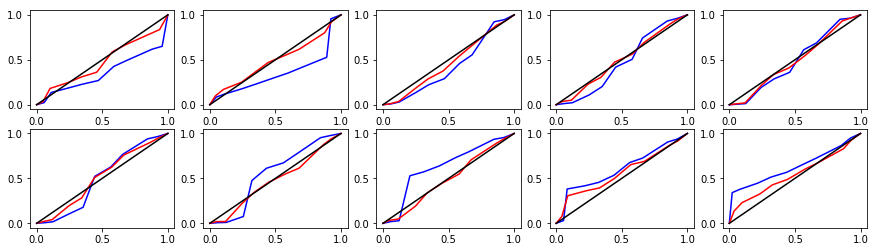

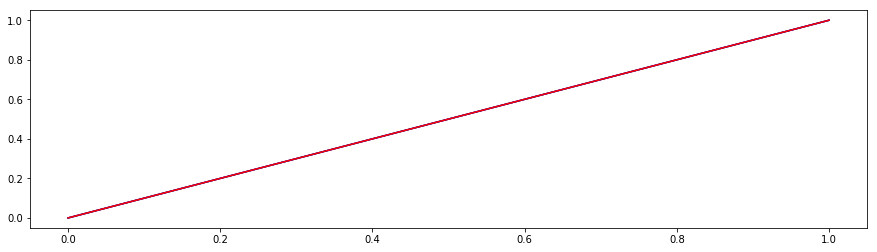

In [19]:
pca_train_1000_x, pca_train_1000_y, pca_test_1000_x, pca_test_1000_y = scale_flatten_n_pca(train_images, train_labels, test_images, test_labels, m=1500)
sgdClassifier1000 = linear_model.SGDClassifier(loss="hinge", penalty='l2',
                alpha=0.0001, l1_ratio=0.15, fit_intercept=True,
                max_iter=1000, tol=1e-4, shuffle=True, verbose=1,
                epsilon=0.1, n_jobs=4, random_state=428, learning_rate='optimal',
                eta0=0.0, power_t=0.5, early_stopping=False, validation_fraction=0.1,
                n_iter_no_change=10, class_weight=None, warm_start=False,
                average=False)
sgdClassifier1000.fit(pca_train_1000_x, pca_train_1000_y)
produce_plots(sgdClassifier1000, pca_train_1000_x, pca_train_1000_y, pca_test_1000_x, pca_test_1000_y)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


-- Epoch 1
-- Epoch 1-- Epoch 1

-- Epoch 1
Norm: 372.87, NNZs: 500, Bias: -3039.708832, T: 50000, Avg. loss: 327.114777
Total training time: 0.14 seconds.
-- Epoch 2
Norm: 357.09, NNZs: 500, Bias: -2782.173593, T: 50000, Avg. loss: 371.441443
Total training time: 0.14 seconds.
-- Epoch 2
Norm: 403.72, NNZs: 500, Bias: -2656.247431, T: 50000, Avg. loss: 358.019663
Total training time: 0.14 seconds.
-- Epoch 2
Norm: 473.39, NNZs: 500, Bias: -3125.944538, T: 50000, Avg. loss: 308.561576
Total training time: 0.17 seconds.
-- Epoch 2
Norm: 328.93, NNZs: 500, Bias: -2729.955857, T: 100000, Avg. loss: 144.122548
Total training time: 0.29 seconds.
-- Epoch 3
Norm: 310.12, NNZs: 500, Bias: -2359.242582, T: 100000, Avg. loss: 175.876147
Total training time: 0.29 seconds.
-- Epoch 3
Norm: 359.03, NNZs: 500, Bias: -2211.218921, T: 100000, Avg. loss: 167.450020
Total training time: 0.29 seconds.
-- Epoch 3
Norm: 424.02, NNZs: 500, Bias: -2811.687860, T: 100000, Avg. loss: 142.497310
Total training

-- Epoch 19
Norm: 184.28, NNZs: 500, Bias: -927.239225, T: 950000, Avg. loss: 59.474410
Total training time: 1.89 seconds.
-- Epoch 20
Norm: 237.39, NNZs: 500, Bias: -1656.605024, T: 1000000, Avg. loss: 75.243753
Total training time: 1.90 seconds.
-- Epoch 21
Norm: 184.34, NNZs: 500, Bias: -743.282979, T: 950000, Avg. loss: 48.386079
Total training time: 1.94 seconds.
-- Epoch 20
Norm: 298.13, NNZs: 500, Bias: -1758.148821, T: 950000, Avg. loss: 77.171372
Total training time: 1.94 seconds.
-- Epoch 20
Norm: 235.02, NNZs: 500, Bias: -1633.825194, T: 1050000, Avg. loss: 74.125489
Total training time: 1.98 seconds.
-- Epoch 22
Norm: 179.88, NNZs: 500, Bias: -895.193091, T: 1000000, Avg. loss: 57.262859
Total training time: 1.99 seconds.
-- Epoch 21
Norm: 178.75, NNZs: 500, Bias: -710.979430, T: 1000000, Avg. loss: 46.201440
Total training time: 2.01 seconds.
-- Epoch 21
Norm: 295.64, NNZs: 500, Bias: -1734.172466, T: 1000000, Avg. loss: 76.075779
Total training time: 2.01 seconds.
-- Epoc

Norm: 133.33, NNZs: 500, Bias: -529.619758, T: 1800000, Avg. loss: 33.536389
Total training time: 3.56 seconds.
-- Epoch 37
Norm: 210.62, NNZs: 500, Bias: -1357.013644, T: 1900000, Avg. loss: 60.884536
Total training time: 3.60 seconds.
-- Epoch 39
Norm: 261.54, NNZs: 500, Bias: -1461.957253, T: 1800000, Avg. loss: 63.272478
Total training time: 3.58 seconds.
-- Epoch 37
Norm: 112.81, NNZs: 500, Bias: -347.627073, T: 1800000, Avg. loss: 22.520869
Total training time: 3.61 seconds.
-- Epoch 37
Norm: 131.19, NNZs: 500, Bias: -512.733682, T: 1850000, Avg. loss: 32.591477
Total training time: 3.64 seconds.
-- Epoch 38
Norm: 209.00, NNZs: 500, Bias: -1345.008786, T: 1950000, Avg. loss: 60.315597
Total training time: 3.67 seconds.
-- Epoch 40
Norm: 260.33, NNZs: 500, Bias: -1449.281431, T: 1850000, Avg. loss: 62.698961
Total training time: 3.65 seconds.
-- Epoch 38
Norm: 109.65, NNZs: 500, Bias: -331.124904, T: 1850000, Avg. loss: 21.462222
Total training time: 3.68 seconds.
-- Epoch 38
Norm

Norm: 95.35, NNZs: 500, Bias: -295.910904, T: 2650000, Avg. loss: 18.821656
Total training time: 4.87 seconds.
-- Epoch 54
Norm: 239.11, NNZs: 500, Bias: -1284.567364, T: 2650000, Avg. loss: 55.198487
Total training time: 4.88 seconds.
-- Epoch 54
Norm: 193.32, NNZs: 500, Bias: -1185.651154, T: 2750000, Avg. loss: 52.912120
Total training time: 4.90 seconds.
-- Epoch 56
Norm: 58.12, NNZs: 500, Bias: -123.684486, T: 2650000, Avg. loss: 8.419494
Total training time: 4.89 seconds.
-- Epoch 54
Norm: 93.38, NNZs: 500, Bias: -284.838813, T: 2700000, Avg. loss: 18.145494
Total training time: 4.95 seconds.
-- Epoch 55
Norm: 238.25, NNZs: 500, Bias: -1275.986691, T: 2700000, Avg. loss: 54.851006
Total training time: 4.95 seconds.
-- Epoch 55
Norm: 192.53, NNZs: 500, Bias: -1177.315084, T: 2800000, Avg. loss: 52.485943
Total training time: 4.98 seconds.
Norm: 54.87, NNZs: 500, Bias: -113.611358, T: 2700000, Avg. loss: 7.780082
Total training time: 4.97 seconds.
-- Epoch 55
-- Epoch 57
Norm: 91.1

-- Epoch 71
Norm: 59.72, NNZs: 500, Bias: -136.077431, T: 3500000, Avg. loss: 8.975588
Total training time: 6.37 seconds.
-- Epoch 71
Norm: 221.79, NNZs: 500, Bias: -1151.544149, T: 3550000, Avg. loss: 49.265879
Total training time: 6.39 seconds.
-- Epoch 72
Norm: 179.39, NNZs: 500, Bias: -1055.153929, T: 3650000, Avg. loss: 46.895682
Total training time: 6.44 seconds.
-- Epoch 74
Norm: 57.30, NNZs: 500, Bias: -128.382676, T: 3550000, Avg. loss: 8.511333
Total training time: 6.46 seconds.
-- Epoch 72
Norm: 3.13, NNZs: 500, Bias: -8.098001, T: 3550000, Avg. loss: 0.968878
Total training time: 6.47 seconds.
-- Epoch 72
Norm: 220.62, NNZs: 500, Bias: -1145.275141, T: 3600000, Avg. loss: 48.976963
Total training time: 6.47 seconds.
-- Epoch 73
Norm: 178.96, NNZs: 500, Bias: -1048.855318, T: 3700000, Avg. loss: 46.594756
Total training time: 6.52 seconds.
-- Epoch 75
Norm: 55.06, NNZs: 500, Bias: -120.781687, T: 3600000, Avg. loss: 8.024894
Total training time: 6.53 seconds.
-- Epoch 73
Nor

-- Epoch 88
Norm: 169.18, NNZs: 500, Bias: -959.050714, T: 4500000, Avg. loss: 42.476871
Total training time: 8.06 seconds.
-- Epoch 91
Norm: 208.12, NNZs: 500, Bias: -1049.471003, T: 4450000, Avg. loss: 44.761517
Total training time: 8.08 seconds.
-- Epoch 90
Norm: 2.32, NNZs: 500, Bias: -6.602204, T: 4300000, Avg. loss: 0.824020
Total training time: 8.09 seconds.
-- Epoch 87
Norm: 15.72, NNZs: 500, Bias: -23.537625, T: 4400000, Avg. loss: 2.020412
Total training time: 8.12 seconds.
-- Epoch 89
Norm: 168.83, NNZs: 500, Bias: -953.958158, T: 4550000, Avg. loss: 42.232138
Total training time: 8.15 seconds.
-- Epoch 92
Norm: 2.13, NNZs: 500, Bias: -6.699160, T: 4350000, Avg. loss: 0.814714
Total training time: 8.18 seconds.
-- Epoch 88
Norm: 207.38, NNZs: 500, Bias: -1044.451320, T: 4500000, Avg. loss: 44.548561
Total training time: 8.17 seconds.
-- Epoch 91
Norm: 13.03, NNZs: 500, Bias: -19.524820, T: 4450000, Avg. loss: 1.761007
Total training time: 8.20 seconds.
-- Epoch 90
Norm: 168.

Norm: 1.90, NNZs: 500, Bias: -5.893048, T: 5100000, Avg. loss: 0.731916
Total training time: 9.64 seconds.
-- Epoch 103
Norm: 196.33, NNZs: 500, Bias: -966.877093, T: 5350000, Avg. loss: 41.075128
Total training time: 9.65 seconds.
-- Epoch 108
Norm: 1.81, NNZs: 500, Bias: -6.064044, T: 5200000, Avg. loss: 0.782195
Total training time: 9.66 seconds.
-- Epoch 105
Norm: 159.48, NNZs: 500, Bias: -871.533614, T: 5450000, Avg. loss: 38.529817
Total training time: 9.68 seconds.
-- Epoch 110
Norm: 1.89, NNZs: 500, Bias: -5.836323, T: 5150000, Avg. loss: 0.727411
Total training time: 9.74 seconds.
-- Epoch 104
Norm: 196.16, NNZs: 500, Bias: -962.628656, T: 5400000, Avg. loss: 40.954797
Total training time: 9.74 seconds.
-- Epoch 109
Norm: 1.79, NNZs: 500, Bias: -6.132526, T: 5250000, Avg. loss: 0.773977
Total training time: 9.76 seconds.
-- Epoch 106
Norm: 159.16, NNZs: 500, Bias: -867.344652, T: 5500000, Avg. loss: 38.306217
Total training time: 9.77 seconds.
-- Epoch 111
Norm: 195.50, NNZs: 

-- Epoch 126
Norm: 151.54, NNZs: 500, Bias: -801.990857, T: 6350000, Avg. loss: 35.355484
Total training time: 11.31 seconds.
-- Epoch 128
Norm: 1.66, NNZs: 500, Bias: -5.236506, T: 5950000, Avg. loss: 0.655677
Total training time: 11.35 seconds.
-- Epoch 120
Norm: 186.11, NNZs: 500, Bias: -893.900924, T: 6300000, Avg. loss: 37.891949
Total training time: 11.38 seconds.
-- Epoch 127
Norm: 150.96, NNZs: 500, Bias: -798.460453, T: 6400000, Avg. loss: 35.208076
Total training time: 11.40 seconds.
-- Epoch 129
Norm: 1.59, NNZs: 500, Bias: -5.458126, T: 6050000, Avg. loss: 0.702257
Total training time: 11.40 seconds.
-- Epoch 122
Norm: 1.63, NNZs: 500, Bias: -5.121227, T: 6000000, Avg. loss: 0.655134
Total training time: 11.44 seconds.
-- Epoch 121
Norm: 185.79, NNZs: 500, Bias: -890.344121, T: 6350000, Avg. loss: 37.764406
Total training time: 11.44 seconds.
-- Epoch 128
Norm: 150.42, NNZs: 500, Bias: -794.954180, T: 6450000, Avg. loss: 35.027416
Total training time: 11.48 seconds.
-- Epoc

Norm: 1.50, NNZs: 500, Bias: -4.698463, T: 6800000, Avg. loss: 0.607366
Total training time: 13.15 seconds.
-- Epoch 137
-- Epoch 138
Norm: 143.40, NNZs: 500, Bias: -735.779086, T: 7350000, Avg. loss: 32.392019
Total training time: 13.22 seconds.
-- Epoch 148
Norm: 177.08, NNZs: 500, Bias: -831.531620, T: 7250000, Avg. loss: 35.216716
Total training time: 13.21 seconds.
-- Epoch 146
Norm: 1.45, NNZs: 500, Bias: -4.702598, T: 6850000, Avg. loss: 0.600690
Total training time: 13.25 seconds.
-- Epoch 138
Norm: 1.44, NNZs: 500, Bias: -4.853314, T: 6900000, Avg. loss: 0.650092
Total training time: 13.28 seconds.
-- Epoch 139
Norm: 142.91, NNZs: 500, Bias: -732.735452, T: 7400000, Avg. loss: 32.268459
Total training time: 13.31 seconds.
-- Epoch 149
Norm: 176.78, NNZs: 500, Bias: -828.457045, T: 7300000, Avg. loss: 35.066986
Total training time: 13.31 seconds.
-- Epoch 147
Norm: 1.48, NNZs: 500, Bias: -4.571923, T: 6900000, Avg. loss: 0.596806
Total training time: 13.37 seconds.
-- Epoch 139

-- Epoch 155
Norm: 136.43, NNZs: 500, Bias: -680.958742, T: 8300000, Avg. loss: 29.931547
Total training time: 15.28 seconds.
-- Epoch 167
Norm: 169.44, NNZs: 500, Bias: -779.804620, T: 8150000, Avg. loss: 32.975038
Total training time: 15.27 seconds.
-- Epoch 164
Norm: 1.37, NNZs: 500, Bias: -4.287294, T: 7650000, Avg. loss: 0.559244
Total training time: 15.29 seconds.
-- Epoch 154
Norm: 1.23, NNZs: 500, Bias: -4.523453, T: 7750000, Avg. loss: 0.601697
Total training time: 15.31 seconds.
-- Epoch 156
Norm: 136.13, NNZs: 500, Bias: -678.246873, T: 8350000, Avg. loss: 29.814605
Total training time: 15.36 seconds.
-- Epoch 168
Norm: 169.16, NNZs: 500, Bias: -777.080837, T: 8200000, Avg. loss: 32.877048
Total training time: 15.34 seconds.
-- Epoch 165
Norm: 1.26, NNZs: 500, Bias: -4.525960, T: 7800000, Avg. loss: 0.591311
Total training time: 15.39 seconds.
-- Epoch 157
Norm: 1.37, NNZs: 500, Bias: -4.250959, T: 7700000, Avg. loss: 0.555467
Total training time: 15.38 seconds.
-- Epoch 155

Norm: 1.19, NNZs: 500, Bias: -3.982660, T: 8450000, Avg. loss: 0.527824
Total training time: 16.79 seconds.
-- Epoch 170
Norm: 130.28, NNZs: 500, Bias: -634.730652, T: 9200000, Avg. loss: 27.875817
Total training time: 16.82 seconds.
-- Epoch 185
Norm: 1.12, NNZs: 500, Bias: -4.194089, T: 8550000, Avg. loss: 0.559802
Total training time: 16.82 seconds.
-- Epoch 172
Norm: 162.66, NNZs: 500, Bias: -733.663718, T: 9050000, Avg. loss: 30.979293
Total training time: 16.82 seconds.
-- Epoch 182
Norm: 1.20, NNZs: 500, Bias: -3.931974, T: 8500000, Avg. loss: 0.524877
Total training time: 16.88 seconds.
-- Epoch 171
Norm: 130.01, NNZs: 500, Bias: -632.287715, T: 9250000, Avg. loss: 27.762588
Total training time: 16.90 seconds.
-- Epoch 186
Norm: 1.13, NNZs: 500, Bias: -4.198940, T: 8600000, Avg. loss: 0.554803
Total training time: 16.90 seconds.
-- Epoch 173
Norm: 162.21, NNZs: 500, Bias: -731.263016, T: 9100000, Avg. loss: 30.882987
Total training time: 16.90 seconds.
-- Epoch 183
Norm: 129.74

-- Epoch 186
Norm: 156.61, NNZs: 500, Bias: -694.314643, T: 9900000, Avg. loss: 29.287299
Total training time: 18.41 seconds.
-- Epoch 199
Norm: 1.05, NNZs: 500, Bias: -3.964148, T: 9350000, Avg. loss: 0.529093
Total training time: 18.43 seconds.
-- Epoch 188
Norm: 124.68, NNZs: 500, Bias: -592.943209, T: 10100000, Avg. loss: 26.018374
Total training time: 18.49 seconds.
-- Epoch 203
Norm: 1.15, NNZs: 500, Bias: -3.746717, T: 9300000, Avg. loss: 0.498296
Total training time: 18.51 seconds.
-- Epoch 187
Norm: 156.18, NNZs: 500, Bias: -692.130440, T: 9950000, Avg. loss: 29.190526
Total training time: 18.50 seconds.
-- Epoch 200
Norm: 1.01, NNZs: 500, Bias: -3.873617, T: 9400000, Avg. loss: 0.533494
Total training time: 18.53 seconds.
-- Epoch 189
Norm: 124.46, NNZs: 500, Bias: -590.720208, T: 10150000, Avg. loss: 25.913334
Total training time: 18.57 seconds.
-- Epoch 204
Norm: 155.83, NNZs: 500, Bias: -689.939251, T: 10000000, Avg. loss: 29.099123
Total training time: 18.57 seconds.
-- E

-- Epoch 204
Norm: 150.51, NNZs: 500, Bias: -656.354311, T: 10800000, Avg. loss: 27.647052
Total training time: 19.81 seconds.
-- Epoch 217
Norm: 119.49, NNZs: 500, Bias: -554.847042, T: 11000000, Avg. loss: 24.324192
Total training time: 19.84 seconds.
-- Epoch 221
Norm: 1.05, NNZs: 500, Bias: -3.562173, T: 10100000, Avg. loss: 0.475930
Total training time: 19.87 seconds.
-- Epoch 203
Norm: 0.98, NNZs: 500, Bias: -3.734732, T: 10200000, Avg. loss: 0.501947
Total training time: 19.91 seconds.
-- Epoch 205
Norm: 119.21, NNZs: 500, Bias: -552.827284, T: 11050000, Avg. loss: 24.234402
Total training time: 19.92 seconds.
-- Epoch 222
Norm: 150.25, NNZs: 500, Bias: -654.325791, T: 10850000, Avg. loss: 27.567420
Total training time: 19.90 seconds.
-- Epoch 218
Norm: 1.03, NNZs: 500, Bias: -3.563151, T: 10150000, Avg. loss: 0.475720
Total training time: 19.95 seconds.
-- Epoch 204
Norm: 118.85, NNZs: 500, Bias: -550.834710, T: 11100000, Avg. loss: 24.139067
Total training time: 19.99 seconds.

Norm: 0.93, NNZs: 500, Bias: -3.557045, T: 11000000, Avg. loss: 0.485294
Total training time: 21.28 seconds.
-- Epoch 221
Norm: 144.74, NNZs: 500, Bias: -619.657497, T: 11750000, Avg. loss: 26.088138
Total training time: 21.29 seconds.
-- Epoch 236
Norm: 113.95, NNZs: 500, Bias: -516.182455, T: 12000000, Avg. loss: 22.595648
Total training time: 21.33 seconds.
-- Epoch 241
Norm: 1.00, NNZs: 500, Bias: -3.403027, T: 10950000, Avg. loss: 0.455872
Total training time: 21.32 seconds.
-- Epoch 220
Norm: 144.50, NNZs: 500, Bias: -617.801249, T: 11800000, Avg. loss: 26.004911
Total training time: 21.36 seconds.
Norm: 0.93, NNZs: 500, Bias: -3.556076, T: 11050000, Avg. loss: 0.484797
Total training time: 21.38 seconds.
-- Epoch 222
-- Epoch 237
Norm: 113.73, NNZs: 500, Bias: -514.328268, T: 12050000, Avg. loss: 22.525067
Total training time: 21.40 seconds.
-- Epoch 242
Norm: 1.00, NNZs: 500, Bias: -3.339335, T: 11000000, Avg. loss: 0.457996
Total training time: 21.41 seconds.
-- Epoch 221
Norm

Norm: 0.89, NNZs: 500, Bias: -3.393584, T: 11800000, Avg. loss: 0.466309
Total training time: 22.64 seconds.
-- Epoch 237
Norm: 139.52, NNZs: 500, Bias: -587.678362, T: 12650000, Avg. loss: 24.712080
Total training time: 22.63 seconds.
-- Epoch 254
Norm: 0.94, NNZs: 500, Bias: -3.248609, T: 11750000, Avg. loss: 0.438904
Total training time: 22.66 seconds.
-- Epoch 236
Norm: 109.31, NNZs: 500, Bias: -484.141777, T: 12900000, Avg. loss: 21.189036
Total training time: 22.69 seconds.
-- Epoch 259
Norm: 139.17, NNZs: 500, Bias: -585.989372, T: 12700000, Avg. loss: 24.636087
Total training time: 22.71 seconds.
-- Epoch 255
Norm: 0.86, NNZs: 500, Bias: -3.383496, T: 11850000, Avg. loss: 0.470040
Total training time: 22.73 seconds.
-- Epoch 238
Norm: 0.94, NNZs: 500, Bias: -3.223168, T: 11800000, Avg. loss: 0.441215
Total training time: 22.73 seconds.
-- Epoch 237
Norm: 109.02, NNZs: 500, Bias: -482.438995, T: 12950000, Avg. loss: 21.111527
Total training time: 22.76 seconds.
-- Epoch 260
Norm

-- Epoch 278
Norm: 134.29, NNZs: 500, Bias: -554.780876, T: 13650000, Avg. loss: 23.301472
Total training time: 24.08 seconds.
-- Epoch 274
Norm: 0.89, NNZs: 500, Bias: -3.096607, T: 12650000, Avg. loss: 0.423993
Total training time: 24.10 seconds.
-- Epoch 254
Norm: 0.81, NNZs: 500, Bias: -3.252299, T: 12700000, Avg. loss: 0.449894
Total training time: 24.12 seconds.
-- Epoch 255
Norm: 104.42, NNZs: 500, Bias: -451.174514, T: 13900000, Avg. loss: 19.734129
Total training time: 24.17 seconds.
-- Epoch 279
Norm: 133.93, NNZs: 500, Bias: -553.230017, T: 13700000, Avg. loss: 23.242137
Total training time: 24.16 seconds.
-- Epoch 275
Norm: 0.91, NNZs: 500, Bias: -3.060353, T: 12700000, Avg. loss: 0.425689
Total training time: 24.18 seconds.
-- Epoch 255
Norm: 0.82, NNZs: 500, Bias: -3.245238, T: 12750000, Avg. loss: 0.451915
Total training time: 24.23 seconds.
-- Epoch 256
Norm: 104.20, NNZs: 500, Bias: -449.587553, T: 13950000, Avg. loss: 19.657548
Total training time: 24.26 seconds.
-- E

Norm: 0.79, NNZs: 500, Bias: -3.108113, T: 13500000, Avg. loss: 0.437823
Total training time: 25.57 seconds.
-- Epoch 271
Norm: 129.41, NNZs: 500, Bias: -525.843080, T: 14600000, Avg. loss: 22.071885
Total training time: 25.63 seconds.
-- Epoch 293
Norm: 0.85, NNZs: 500, Bias: -2.944299, T: 13500000, Avg. loss: 0.410993
Total training time: 25.63 seconds.
-- Epoch 271
Norm: 100.22, NNZs: 500, Bias: -423.570371, T: 14800000, Avg. loss: 18.517060
Total training time: 25.67 seconds.
-- Epoch 297
Norm: 0.76, NNZs: 500, Bias: -3.103610, T: 13550000, Avg. loss: 0.438372
Total training time: 25.67 seconds.
-- Epoch 272
Norm: 129.07, NNZs: 500, Bias: -524.397709, T: 14650000, Avg. loss: 22.013628
Total training time: 25.71 seconds.
-- Epoch 294
Norm: 0.80, NNZs: 500, Bias: -2.965726, T: 13550000, Avg. loss: 0.410240
Total training time: 25.73 seconds.Norm: 99.96, NNZs: 500, Bias: -422.095254, T: 14850000, Avg. loss: 18.459004
-- Epoch 272

Total training time: 25.74 seconds.
-- Epoch 298
Norm:

Norm: 0.74, NNZs: 500, Bias: -2.994639, T: 14400000, Avg. loss: 0.425182
Total training time: 27.24 seconds.
-- Epoch 289
Norm: 95.75, NNZs: 500, Bias: -394.898342, T: 15800000, Avg. loss: 17.265327
Total training time: 27.28 seconds.
-- Epoch 317
Norm: 124.76, NNZs: 500, Bias: -498.828155, T: 15550000, Avg. loss: 20.927338
Total training time: 27.27 seconds.
-- Epoch 312
Norm: 0.81, NNZs: 500, Bias: -2.851363, T: 14400000, Avg. loss: 0.395191
Total training time: 27.29 seconds.
-- Epoch 289
Norm: 0.73, NNZs: 500, Bias: -2.991127, T: 14450000, Avg. loss: 0.424357
Total training time: 27.32 seconds.
-- Epoch 290
Norm: 124.57, NNZs: 500, Bias: -497.442706, T: 15600000, Avg. loss: 20.862448
Total training time: 27.33 seconds.
-- Epoch 313
Norm: 95.56, NNZs: 500, Bias: -393.508177, T: 15850000, Avg. loss: 17.191688
Total training time: 27.37 seconds.
-- Epoch 318
Norm: 0.80, NNZs: 500, Bias: -2.862422, T: 14450000, Avg. loss: 0.398881
Total training time: 27.37 seconds.
-- Epoch 290
Norm: 

Norm: 120.13, NNZs: 500, Bias: -472.202398, T: 16550000, Avg. loss: 19.800922Norm: 91.55, NNZs: 500, Bias: -368.068104, T: 16800000, Avg. loss: 16.089473
Total training time: 28.72 seconds.

Total training time: 28.74 seconds.
-- Epoch 332
-- Epoch 337
Norm: 0.73, NNZs: 500, Bias: -2.767792, T: 15300000, Avg. loss: 0.387412
Total training time: 28.74 seconds.
-- Epoch 307
Norm: 0.70, NNZs: 500, Bias: -2.864342, T: 15350000, Avg. loss: 0.408717
Total training time: 28.75 seconds.
-- Epoch 308
Norm: 91.30, NNZs: 500, Bias: -366.781363, T: 16850000, Avg. loss: 16.026683
Total training time: 28.81 seconds.
-- Epoch 338
Norm: 119.94, NNZs: 500, Bias: -470.908397, T: 16600000, Avg. loss: 19.746965
Total training time: 28.79 seconds.
-- Epoch 333
Norm: 0.74, NNZs: 500, Bias: -2.729886, T: 15350000, Avg. loss: 0.388449
Total training time: 28.81 seconds.
-- Epoch 308
Norm: 0.71, NNZs: 500, Bias: -2.857175, T: 15400000, Avg. loss: 0.410367
Total training time: 28.82 seconds.
-- Epoch 309
Norm: 

Norm: 88.07, NNZs: 500, Bias: -346.566136, T: 17650000, Avg. loss: 15.152215
Total training time: 30.03 seconds.
-- Epoch 354
Norm: 0.66, NNZs: 500, Bias: -2.827055, T: 16100000, Avg. loss: 0.400509
Total training time: 30.03 seconds.
-- Epoch 323
Norm: 116.18, NNZs: 500, Bias: -449.652633, T: 17450000, Avg. loss: 18.844080
Total training time: 30.02 seconds.
-- Epoch 350
Norm: 0.72, NNZs: 500, Bias: -2.629496, T: 16100000, Avg. loss: 0.381028
Total training time: 30.07 seconds.
-- Epoch 323
Norm: 87.86, NNZs: 500, Bias: -345.337352, T: 17700000, Avg. loss: 15.080689
Total training time: 30.10 seconds.
-- Epoch 355
Norm: 115.96, NNZs: 500, Bias: -448.435563, T: 17500000, Avg. loss: 18.801233
Total training time: 30.09 seconds.
-- Epoch 351
Norm: 0.64, NNZs: 500, Bias: -2.806652, T: 16150000, Avg. loss: 0.403242
Total training time: 30.11 seconds.
-- Epoch 324
Norm: 0.74, NNZs: 500, Bias: -2.685945, T: 16150000, Avg. loss: 0.378300
Total training time: 30.15 seconds.
-- Epoch 324
Norm: 

-- Epoch 367
Norm: 0.66, NNZs: 500, Bias: -2.738286, T: 16850000, Avg. loss: 0.393417
Total training time: 31.28 seconds.
-- Epoch 338
Norm: 0.69, NNZs: 500, Bias: -2.632310, T: 16850000, Avg. loss: 0.371691
Total training time: 31.28 seconds.
-- Epoch 338
Norm: 84.49, NNZs: 500, Bias: -324.972579, T: 18550000, Avg. loss: 14.201509
Total training time: 31.30 seconds.
-- Epoch 372
Norm: 112.31, NNZs: 500, Bias: -428.318946, T: 18350000, Avg. loss: 17.945937
Total training time: 31.32 seconds.
-- Epoch 368
Norm: 0.64, NNZs: 500, Bias: -2.723480, T: 16900000, Avg. loss: 0.393268
Total training time: 31.35 seconds.
-- Epoch 339
Norm: 84.30, NNZs: 500, Bias: -323.805523, T: 18600000, Avg. loss: 14.155849
Total training time: 31.37 seconds.
-- Epoch 373
Norm: 0.67, NNZs: 500, Bias: -2.593193, T: 16900000, Avg. loss: 0.372188
Total training time: 31.36 seconds.
-- Epoch 339
Norm: 112.15, NNZs: 500, Bias: -427.153328, T: 18400000, Avg. loss: 17.889947
Total training time: 31.38 seconds.
-- Epo

Norm: 0.62, NNZs: 500, Bias: -2.633808, T: 17700000, Avg. loss: 0.387132
Total training time: 32.79 seconds.
-- Epoch 355
Norm: 108.70, NNZs: 500, Bias: -408.044065, T: 19250000, Avg. loss: 17.084236
Total training time: 32.78 seconds.
-- Epoch 386
Norm: 80.86, NNZs: 500, Bias: -303.352758, T: 19500000, Avg. loss: 13.258502
Total training time: 32.82 seconds.
-- Epoch 391
Norm: 0.68, NNZs: 500, Bias: -2.502070, T: 17700000, Avg. loss: 0.364083
Total training time: 32.87 seconds.
-- Epoch 355
Norm: 108.47, NNZs: 500, Bias: -406.958253, T: 19300000, Avg. loss: 17.038365
Total training time: 32.88 seconds.
-- Epoch 387
Norm: 0.62, NNZs: 500, Bias: -2.671047, T: 17750000, Avg. loss: 0.381865
Total training time: 32.90 seconds.
-- Epoch 356
Norm: 80.68, NNZs: 500, Bias: -302.243994, T: 19550000, Avg. loss: 13.213267
Total training time: 32.92 seconds.
-- Epoch 392
Norm: 0.67, NNZs: 500, Bias: -2.529739, T: 17750000, Avg. loss: 0.364953
Total training time: 32.96 seconds.
-- Epoch 356
Norm: 

-- Epoch 371
Norm: 104.95, NNZs: 500, Bias: -387.730932, T: 20200000, Avg. loss: 16.227698
Total training time: 34.37 seconds.
-- Epoch 405
Norm: 77.29, NNZs: 500, Bias: -282.845652, T: 20450000, Avg. loss: 12.364463
Total training time: 34.44 seconds.
-- Epoch 410
Norm: 0.57, NNZs: 500, Bias: -2.608928, T: 18600000, Avg. loss: 0.376695
Total training time: 34.47 seconds.
-- Epoch 373
Norm: 104.78, NNZs: 500, Bias: -386.683796, T: 20250000, Avg. loss: 16.192194
Total training time: 34.46 seconds.
-- Epoch 406
Norm: 0.67, NNZs: 500, Bias: -2.453957, T: 18550000, Avg. loss: 0.357753
Total training time: 34.48 seconds.
-- Epoch 372
Norm: 77.11, NNZs: 500, Bias: -281.794696, T: 20500000, Avg. loss: 12.315251
Total training time: 34.51 seconds.
-- Epoch 411
Norm: 104.60, NNZs: 500, Bias: -385.643186, T: 20300000, Avg. loss: 16.143276
Total training time: 34.53 seconds.
-- Epoch 407
Norm: 0.58, NNZs: 500, Bias: -2.561672, T: 18650000, Avg. loss: 0.377844
Total training time: 34.55 seconds.
-

-- Epoch 388
Norm: 74.16, NNZs: 500, Bias: -265.354025, T: 21300000, Avg. loss: 11.603155
Total training time: 35.91 seconds.
-- Epoch 427
Norm: 0.63, NNZs: 500, Bias: -2.411013, T: 19300000, Avg. loss: 0.351586
Total training time: 35.90 seconds.
-- Epoch 387
Norm: 101.55, NNZs: 500, Bias: -369.398533, T: 21100000, Avg. loss: 15.461440
Total training time: 35.89 seconds.
-- Epoch 423
Norm: 0.58, NNZs: 500, Bias: -2.521018, T: 19400000, Avg. loss: 0.370696
Total training time: 35.96 seconds.
-- Epoch 389
Norm: 73.99, NNZs: 500, Bias: -264.345854, T: 21350000, Avg. loss: 11.551554
Total training time: 35.99 seconds.
-- Epoch 428
Norm: 101.34, NNZs: 500, Bias: -368.411585, T: 21150000, Avg. loss: 15.421088
Total training time: 35.97 seconds.
-- Epoch 424
Norm: 0.61, NNZs: 500, Bias: -2.417208, T: 19350000, Avg. loss: 0.351539
Total training time: 35.99 seconds.
-- Epoch 388
Norm: 0.58, NNZs: 500, Bias: -2.537483, T: 19450000, Avg. loss: 0.369323
Total training time: 36.04 seconds.
-- Epo

Norm: 98.14, NNZs: 500, Bias: -351.916893, T: 22000000, Avg. loss: 14.729296
Total training time: 37.41 seconds.
-- Epoch 441
Norm: 0.58, NNZs: 500, Bias: -2.468609, T: 20150000, Avg. loss: 0.362853
Total training time: 37.44 seconds.
-- Epoch 404
Norm: 0.59, NNZs: 500, Bias: -2.371808, T: 20100000, Avg. loss: 0.345564
Total training time: 37.44 seconds.
-- Epoch 403
Norm: 70.99, NNZs: 500, Bias: -247.622899, T: 22200000, Avg. loss: 10.825905
Total training time: 37.47 seconds.
-- Epoch 445
Norm: 97.95, NNZs: 500, Bias: -350.967100, T: 22050000, Avg. loss: 14.688032
Total training time: 37.48 seconds.
-- Epoch 442
Norm: 0.56, NNZs: 500, Bias: -2.450282, T: 20200000, Avg. loss: 0.364540
Total training time: 37.52 seconds.
-- Epoch 405
Norm: 0.59, NNZs: 500, Bias: -2.368813, T: 20150000, Avg. loss: 0.345839
Total training time: 37.52 seconds.
-- Epoch 404
Norm: 70.83, NNZs: 500, Bias: -246.658284, T: 22250000, Avg. loss: 10.784632
Total training time: 37.54 seconds.
-- Epoch 446
Norm: 97

-- Epoch 420
Norm: 94.96, NNZs: 500, Bias: -335.151409, T: 22900000, Avg. loss: 14.020572
Total training time: 38.89 seconds.
-- Epoch 459
Norm: 0.58, NNZs: 500, Bias: -2.321908, T: 20900000, Avg. loss: 0.340833
Total training time: 38.91 seconds.
-- Epoch 419
Norm: 67.86, NNZs: 500, Bias: -230.669393, T: 23100000, Avg. loss: 10.086487
Total training time: 38.94 seconds.
-- Epoch 463
Norm: 94.78, NNZs: 500, Bias: -334.241543, T: 22950000, Avg. loss: 13.984593
Total training time: 38.99 seconds.
-- Epoch 460
Norm: 0.54, NNZs: 500, Bias: -2.438359, T: 21000000, Avg. loss: 0.357795
Total training time: 39.03 seconds.
-- Epoch 421
Norm: 0.58, NNZs: 500, Bias: -2.330499, T: 20950000, Avg. loss: 0.339102
Total training time: 39.04 seconds.
-- Epoch 420
Norm: 67.66, NNZs: 500, Bias: -229.756126, T: 23150000, Avg. loss: 10.044535
Total training time: 39.07 seconds.
-- Epoch 464
Norm: 94.59, NNZs: 500, Bias: -333.339731, T: 23000000, Avg. loss: 13.945864
Total training time: 39.07 seconds.
-- E

-- Epoch 479
Norm: 0.52, NNZs: 500, Bias: -2.375825, T: 21850000, Avg. loss: 0.353234
Total training time: 40.59 seconds.
-- Epoch 438
Norm: 0.57, NNZs: 500, Bias: -2.257530, T: 21800000, Avg. loss: 0.333881
Total training time: 40.64 seconds.
-- Epoch 437
Norm: 64.38, NNZs: 500, Bias: -212.679784, T: 24100000, Avg. loss: 9.316633
Total training time: 40.66 seconds.
-- Epoch 483
Norm: 91.26, NNZs: 500, Bias: -316.498044, T: 23950000, Avg. loss: 13.238791
Total training time: 40.65 seconds.
-- Epoch 480
Norm: 0.54, NNZs: 500, Bias: -2.357089, T: 21900000, Avg. loss: 0.352001
Total training time: 40.68 seconds.
-- Epoch 439
Norm: 0.56, NNZs: 500, Bias: -2.260306, T: 21850000, Avg. loss: 0.333983
Total training time: 40.71 seconds.
-- Epoch 438
Norm: 64.22, NNZs: 500, Bias: -211.797755, T: 24150000, Avg. loss: 9.276700
Total training time: 40.73 seconds.
-- Epoch 484
Norm: 91.10, NNZs: 500, Bias: -315.628429, T: 24000000, Avg. loss: 13.203326
Total training time: 40.72 seconds.
-- Epoch 4

Norm: 61.15, NNZs: 500, Bias: -196.339096, T: 25050000, Avg. loss: 8.604659
Total training time: 42.10 seconds.
-- Epoch 502
Norm: 88.03, NNZs: 500, Bias: -300.362101, T: 24900000, Avg. loss: 12.571843
Total training time: 42.10 seconds.
-- Epoch 499
Norm: 0.50, NNZs: 500, Bias: -2.341621, T: 22750000, Avg. loss: 0.346458
Total training time: 42.12 seconds.
-- Epoch 456
Norm: 0.55, NNZs: 500, Bias: -2.221492, T: 22700000, Avg. loss: 0.331309
Total training time: 42.14 seconds.
-- Epoch 455
Norm: 60.99, NNZs: 500, Bias: -195.494449, T: 25100000, Avg. loss: 8.566062
Total training time: 42.20 seconds.
-- Epoch 503
Norm: 87.89, NNZs: 500, Bias: -299.524830, T: 24950000, Avg. loss: 12.533930
Total training time: 42.20 seconds.
-- Epoch 500
Norm: 0.50, NNZs: 500, Bias: -2.310005, T: 22800000, Avg. loss: 0.347081
Total training time: 42.22 seconds.
-- Epoch 457
Norm: 0.54, NNZs: 500, Bias: -2.237783, T: 22750000, Avg. loss: 0.328366
Total training time: 42.26 seconds.
-- Epoch 456
Norm: 87.6

-- Epoch 474
Norm: 0.54, NNZs: 500, Bias: -2.167364, T: 23550000, Avg. loss: 0.325738
Total training time: 43.59 seconds.
-- Epoch 472
Norm: 84.71, NNZs: 500, Bias: -284.089169, T: 25900000, Avg. loss: 11.886285
Total training time: 43.60 seconds.
-- Epoch 519
Norm: 57.84, NNZs: 500, Bias: -179.857210, T: 26050000, Avg. loss: 7.894607
Total training time: 43.63 seconds.
-- Epoch 522
Norm: 0.48, NNZs: 500, Bias: -2.251489, T: 23700000, Avg. loss: 0.342148
Total training time: 43.68 seconds.
-- Epoch 475
Norm: 84.55, NNZs: 500, Bias: -283.291525, T: 25950000, Avg. loss: 11.853719
Total training time: 43.67 seconds.
-- Epoch 520
Norm: 0.53, NNZs: 500, Bias: -2.138559, T: 23600000, Avg. loss: 0.324398Norm: 57.68, NNZs: 500, Bias: -179.051110, T: 26100000, Avg. loss: 7.857013
Total training time: 43.69 seconds.

Total training time: 43.68 seconds.
-- Epoch 523
-- Epoch 473
Norm: 0.46, NNZs: 500, Bias: -2.271262, T: 23750000, Avg. loss: 0.341938
Total training time: 43.75 seconds.
-- Epoch 4

Norm: 54.58, NNZs: 500, Bias: -164.077700, T: 27050000, Avg. loss: 7.213060
Total training time: 45.19 seconds.
-- Epoch 542
Norm: 81.46, NNZs: 500, Bias: -268.492861, T: 26900000, Avg. loss: 11.237773
Total training time: 45.20 seconds.
-- Epoch 539
Norm: 0.50, NNZs: 500, Bias: -2.135591, T: 24450000, Avg. loss: 0.323136
Total training time: 45.21 seconds.
-- Epoch 490
Norm: 0.47, NNZs: 500, Bias: -2.216180, T: 24550000, Avg. loss: 0.337407
Total training time: 45.22 seconds.
-- Epoch 492
Norm: 54.41, NNZs: 500, Bias: -163.308384, T: 27100000, Avg. loss: 7.180387
Total training time: 45.27 seconds.
-- Epoch 543
Norm: 81.30, NNZs: 500, Bias: -267.729286, T: 26950000, Avg. loss: 11.197372
Total training time: 45.27 seconds.
-- Epoch 540
Norm: 0.52, NNZs: 500, Bias: -2.118843, T: 24500000, Avg. loss: 0.320660
Total training time: 45.28 seconds.
-- Epoch 491
Norm: 0.47, NNZs: 500, Bias: -2.229639, T: 24600000, Avg. loss: 0.337052
Total training time: 45.30 seconds.
-- Epoch 493
Norm: 54.2

-- Epoch 557
Norm: 0.46, NNZs: 500, Bias: -2.212014, T: 25350000, Avg. loss: 0.332435
Total training time: 46.64 seconds.
-- Epoch 508
Norm: 51.77, NNZs: 500, Bias: -151.202476, T: 27900000, Avg. loss: 6.657137
Total training time: 46.66 seconds.
-- Epoch 559
Norm: 0.48, NNZs: 500, Bias: -2.112628, T: 25250000, Avg. loss: 0.317995
Total training time: 46.65 seconds.
-- Epoch 506
Norm: 78.48, NNZs: 500, Bias: -254.243813, T: 27850000, Avg. loss: 10.642789
Total training time: 46.69 seconds.
-- Epoch 558
Norm: 0.47, NNZs: 500, Bias: -2.200589, T: 25400000, Avg. loss: 0.331921
Total training time: 46.72 seconds.
-- Epoch 509
Norm: 51.58, NNZs: 500, Bias: -150.468032, T: 27950000, Avg. loss: 6.624844
Total training time: 46.73 seconds.
-- Epoch 560
Norm: 0.50, NNZs: 500, Bias: -2.097185, T: 25300000, Avg. loss: 0.315660
Total training time: 46.73 seconds.
-- Epoch 507
Norm: 78.30, NNZs: 500, Bias: -253.517375, T: 27900000, Avg. loss: 10.607952
Total training time: 46.75 seconds.
-- Epoch 5

-- Epoch 525
Norm: 0.48, NNZs: 500, Bias: -2.064959, T: 26100000, Avg. loss: 0.315012
Total training time: 48.07 seconds.
-- Epoch 523
Norm: 48.46, NNZs: 500, Bias: -136.636860, T: 28900000, Avg. loss: 6.032373
Total training time: 48.09 seconds.
-- Epoch 579
Norm: 75.46, NNZs: 500, Bias: -240.553848, T: 28800000, Avg. loss: 10.070098
Total training time: 48.10 seconds.
-- Epoch 577
Norm: 0.42, NNZs: 500, Bias: -2.151847, T: 26250000, Avg. loss: 0.328659
Total training time: 48.15 seconds.
-- Epoch 526
Norm: 48.31, NNZs: 500, Bias: -135.920210, T: 28950000, Avg. loss: 5.996892
Total training time: 48.16 seconds.
-- Epoch 580
Norm: 0.46, NNZs: 500, Bias: -2.067266, T: 26150000, Avg. loss: 0.312853
Total training time: 48.16 seconds.
-- Epoch 524
Norm: 75.33, NNZs: 500, Bias: -239.836426, T: 28850000, Avg. loss: 10.041377
Total training time: 48.17 seconds.
-- Epoch 578
Norm: 48.14, NNZs: 500, Bias: -135.213087, T: 29000000, Avg. loss: 5.969152
Total training time: 48.23 seconds.
-- Epoc

Norm: 0.43, NNZs: 500, Bias: -2.114537, T: 27100000, Avg. loss: 0.325604
Total training time: 49.50 seconds.
-- Epoch 543
Norm: 45.13, NNZs: 500, Bias: -122.674507, T: 29900000, Avg. loss: 5.431801
Total training time: 49.52 seconds.
-- Epoch 599
Norm: 72.41, NNZs: 500, Bias: -226.651464, T: 29800000, Avg. loss: 9.492471
Total training time: 49.52 seconds.
-- Epoch 597
Norm: 0.48, NNZs: 500, Bias: -2.047766, T: 27000000, Avg. loss: 0.309188
Total training time: 49.54 seconds.
-- Epoch 541
Norm: 44.96, NNZs: 500, Bias: -121.991818, T: 29950000, Avg. loss: 5.404369
Total training time: 49.60 seconds.
-- Epoch 600
Norm: 0.41, NNZs: 500, Bias: -2.121178, T: 27150000, Avg. loss: 0.324822
Total training time: 49.59 seconds.
-- Epoch 544
Norm: 72.28, NNZs: 500, Bias: -225.964478, T: 29850000, Avg. loss: 9.465354
Total training time: 49.59 seconds.
-- Epoch 598
Norm: 0.48, NNZs: 500, Bias: -2.040369, T: 27050000, Avg. loss: 0.309850
Total training time: 49.62 seconds.
-- Epoch 542
Norm: 44.80,

Norm: 69.72, NNZs: 500, Bias: -214.575150, T: 30700000, Avg. loss: 8.993449
Total training time: 50.92 seconds.
-- Epoch 615
Norm: 42.11, NNZs: 500, Bias: -110.589441, T: 30800000, Avg. loss: 4.916507
Total training time: 50.94 seconds.
-- Epoch 617
Norm: 0.46, NNZs: 500, Bias: -1.996113, T: 27800000, Avg. loss: 0.308057
Total training time: 50.95 seconds.
-- Epoch 557
Norm: 0.41, NNZs: 500, Bias: -2.103284, T: 27950000, Avg. loss: 0.321578
Total training time: 51.01 seconds.
-- Epoch 560
Norm: 69.56, NNZs: 500, Bias: -213.920340, T: 30750000, Avg. loss: 8.969132
Total training time: 51.00 seconds.
-- Epoch 616
Norm: 41.95, NNZs: 500, Bias: -109.929622, T: 30850000, Avg. loss: 4.890320
Total training time: 51.03 seconds.
-- Epoch 618
Norm: 0.46, NNZs: 500, Bias: -2.010114, T: 27850000, Avg. loss: 0.307063
Total training time: 51.03 seconds.
-- Epoch 558
Norm: 69.39, NNZs: 500, Bias: -213.268859, T: 30800000, Avg. loss: 8.937363
Total training time: 51.07 seconds.
-- Epoch 617
Norm: 41.

-- Epoch 573
Norm: 66.88, NNZs: 500, Bias: -202.269411, T: 31650000, Avg. loss: 8.484443
Total training time: 52.34 seconds.
-- Epoch 634
Norm: 38.91, NNZs: 500, Bias: -98.312743, T: 31750000, Avg. loss: 4.389750
Total training time: 52.39 seconds.
-- Epoch 636
Norm: 0.40, NNZs: 500, Bias: -2.073301, T: 28750000, Avg. loss: 0.318907
Total training time: 52.40 seconds.
-- Epoch 576
Norm: 0.43, NNZs: 500, Bias: -2.005830, T: 28650000, Avg. loss: 0.304130
Total training time: 52.41 seconds.
-- Epoch 574
Norm: 66.74, NNZs: 500, Bias: -201.630142, T: 31700000, Avg. loss: 8.454418
Total training time: 52.42 seconds.
-- Epoch 635
Norm: 38.75, NNZs: 500, Bias: -97.675474, T: 31800000, Avg. loss: 4.364899
Total training time: 52.45 seconds.
-- Epoch 637
Norm: 0.41, NNZs: 500, Bias: -2.052813, T: 28800000, Avg. loss: 0.317464
Total training time: 52.47 seconds.
-- Epoch 577
Norm: 0.44, NNZs: 500, Bias: -1.995016, T: 28700000, Avg. loss: 0.303641
Total training time: 52.49 seconds.
-- Epoch 575
N

-- Epoch 593
Norm: 63.92, NNZs: 500, Bias: -189.764530, T: 32650000, Avg. loss: 7.965472
Total training time: 53.83 seconds.
-- Epoch 654
Norm: 35.49, NNZs: 500, Bias: -85.901156, T: 32750000, Avg. loss: 3.860664
Total training time: 53.91 seconds.
-- Epoch 656
Norm: 0.39, NNZs: 500, Bias: -2.042760, T: 29650000, Avg. loss: 0.313573Norm: 0.41, NNZs: 500, Bias: -1.961266, T: 29550000, Avg. loss: 0.300689
Total training time: 53.90 seconds.

-- Epoch 592
Total training time: 53.91 seconds.
-- Epoch 594
Norm: 63.79, NNZs: 500, Bias: -189.144195, T: 32700000, Avg. loss: 7.944247
Total training time: 53.92 seconds.
-- Epoch 655
Norm: 35.33, NNZs: 500, Bias: -85.290334, T: 32800000, Avg. loss: 3.834618
Total training time: 53.98 seconds.
-- Epoch 657
Norm: 0.42, NNZs: 500, Bias: -1.951457, T: 29600000, Avg. loss: 0.301550
Total training time: 53.98 seconds.
-- Epoch 593
Norm: 0.39, NNZs: 500, Bias: -2.041060, T: 29700000, Avg. loss: 0.314722
Total training time: 54.00 seconds.
-- Epoch 595
N

-- Epoch 608
Norm: 32.39, NNZs: 500, Bias: -75.155363, T: 33650000, Avg. loss: 3.400149
Total training time: 55.29 seconds.
-- Epoch 674
Norm: 61.34, NNZs: 500, Bias: -178.861429, T: 33550000, Avg. loss: 7.516542
Total training time: 55.29 seconds.
-- Epoch 672
Norm: 0.38, NNZs: 500, Bias: -2.016687, T: 30450000, Avg. loss: 0.310680
Total training time: 55.33 seconds.
-- Epoch 610
Norm: 32.23, NNZs: 500, Bias: -74.564739, T: 33700000, Avg. loss: 3.377463
Total training time: 55.36 seconds.
-- Epoch 675
Norm: 0.43, NNZs: 500, Bias: -1.924571, T: 30400000, Avg. loss: 0.298082
Total training time: 55.35 seconds.
-- Epoch 609
Norm: 61.20, NNZs: 500, Bias: -178.263982, T: 33600000, Avg. loss: 7.493197
Total training time: 55.36 seconds.
-- Epoch 673
Norm: 0.38, NNZs: 500, Bias: -1.990776, T: 30500000, Avg. loss: 0.312641
Total training time: 55.40 seconds.
-- Epoch 611
Norm: 32.04, NNZs: 500, Bias: -73.986554, T: 33750000, Avg. loss: 3.348875
Total training time: 55.43 seconds.
-- Epoch 676

-- Epoch 627
Norm: 0.41, NNZs: 500, Bias: -1.905469, T: 31250000, Avg. loss: 0.295193
Total training time: 56.73 seconds.
-- Epoch 626
Norm: 28.85, NNZs: 500, Bias: -63.700843, T: 34650000, Avg. loss: 2.911144
Total training time: 56.75 seconds.
-- Epoch 694
Norm: 58.45, NNZs: 500, Bias: -167.152638, T: 34550000, Avg. loss: 7.030590
Total training time: 56.74 seconds.
-- Epoch 692
Norm: 0.37, NNZs: 500, Bias: -1.997920, T: 31350000, Avg. loss: 0.308492
Total training time: 56.81 seconds.
-- Epoch 628
Norm: 28.67, NNZs: 500, Bias: -63.140798, T: 34700000, Avg. loss: 2.888005
Total training time: 56.83 seconds.
-- Epoch 695
Norm: 58.30, NNZs: 500, Bias: -166.577957, T: 34600000, Avg. loss: 7.009218
Total training time: 56.82 seconds.
-- Epoch 693
Norm: 0.40, NNZs: 500, Bias: -1.907713, T: 31300000, Avg. loss: 0.296052
Total training time: 56.83 seconds.
-- Epoch 627
Norm: 28.51, NNZs: 500, Bias: -62.575805, T: 34750000, Avg. loss: 2.863617
Total training time: 56.89 seconds.
-- Epoch 696

Norm: 0.36, NNZs: 500, Bias: -1.946480, T: 32200000, Avg. loss: 0.306476
Total training time: 58.18 seconds.
-- Epoch 645
Norm: 25.23, NNZs: 500, Bias: -52.743742, T: 35650000, Avg. loss: 2.440626
Total training time: 58.20 seconds.
-- Epoch 714
Norm: 0.40, NNZs: 500, Bias: -1.892535, T: 32150000, Avg. loss: 0.292357
Total training time: 58.20 seconds.
-- Epoch 644
Norm: 55.61, NNZs: 500, Bias: -155.825373, T: 35550000, Avg. loss: 6.564867
Total training time: 58.20 seconds.
-- Epoch 712
Norm: 25.05, NNZs: 500, Bias: -52.203888, T: 35700000, Avg. loss: 2.420844
Total training time: 58.28 seconds.
-- Epoch 715
Norm: 0.37, NNZs: 500, Bias: -1.957033, T: 32250000, Avg. loss: 0.305927
Total training time: 58.27 seconds.
-- Epoch 646
Norm: 0.41, NNZs: 500, Bias: -1.885715, T: 32200000, Avg. loss: 0.293058
Total training time: 58.28 seconds.
-- Epoch 645
Norm: 55.47, NNZs: 500, Bias: -155.270215, T: 35600000, Avg. loss: 6.540413
Total training time: 58.28 seconds.
-- Epoch 713
Norm: 24.86, N

Norm: 0.35, NNZs: 500, Bias: -1.940438, T: 33100000, Avg. loss: 0.303508
Total training time: 59.65 seconds.
-- Epoch 663
Norm: 52.79, NNZs: 500, Bias: -144.871136, T: 36550000, Avg. loss: 6.119044
Total training time: 59.66 seconds.
-- Epoch 732
Norm: 21.46, NNZs: 500, Bias: -42.306599, T: 36650000, Avg. loss: 1.998565
Total training time: 59.68 seconds.
-- Epoch 734
Norm: 0.39, NNZs: 500, Bias: -1.861409, T: 33050000, Avg. loss: 0.290544
Total training time: 59.68 seconds.
-- Epoch 662
Norm: 0.35, NNZs: 500, Bias: -1.953718, T: 33150000, Avg. loss: 0.301908
Total training time: 59.73 seconds.
-- Epoch 664
Norm: 52.66, NNZs: 500, Bias: -144.328702, T: 36600000, Avg. loss: 6.092031
Total training time: 59.73 seconds.
-- Epoch 733
Norm: 21.27, NNZs: 500, Bias: -41.796731, T: 36700000, Avg. loss: 1.976320
Total training time: 59.76 seconds.
-- Epoch 735
Norm: 0.40, NNZs: 500, Bias: -1.862325, T: 33100000, Avg. loss: 0.290414
Total training time: 59.76 seconds.
-- Epoch 663
Norm: 0.35, NN

Norm: 17.94, NNZs: 500, Bias: -33.366347, T: 37550000, Avg. loss: 1.615596
Total training time: 61.28 seconds.
-- Epoch 752
Norm: 0.34, NNZs: 500, Bias: -1.917030, T: 33950000, Avg. loss: 0.301630
Total training time: 61.28 seconds.
-- Epoch 680
Norm: 0.39, NNZs: 500, Bias: -1.830737, T: 33850000, Avg. loss: 0.289167
Total training time: 61.30 seconds.
-- Epoch 678
Norm: 50.15, NNZs: 500, Bias: -134.778095, T: 37500000, Avg. loss: 5.697510
Total training time: 61.30 seconds.
-- Epoch 751
Norm: 17.74, NNZs: 500, Bias: -32.881730, T: 37600000, Avg. loss: 1.592261
Total training time: 61.37 seconds.
-- Epoch 753
Norm: 0.35, NNZs: 500, Bias: -1.896720, T: 34000000, Avg. loss: 0.300538
Total training time: 61.38 seconds.
-- Epoch 681
Norm: 0.37, NNZs: 500, Bias: -1.825424, T: 33900000, Avg. loss: 0.289238
Total training time: 61.40 seconds.
-- Epoch 679
Norm: 50.02, NNZs: 500, Bias: -134.252065, T: 37550000, Avg. loss: 5.677954
Total training time: 61.41 seconds.
-- Epoch 752
Norm: 17.54, N

Norm: 0.34, NNZs: 500, Bias: -1.892509, T: 34750000, Avg. loss: 0.299002
Total training time: 62.97 seconds.
-- Epoch 696
Norm: 47.67, NNZs: 500, Bias: -125.498208, T: 38400000, Avg. loss: 5.317360
Total training time: 62.96 seconds.
-- Epoch 769
Norm: 14.04, NNZs: 500, Bias: -24.448633, T: 38500000, Avg. loss: 1.231862
Total training time: 63.11 seconds.
-- Epoch 771
Norm: 47.54, NNZs: 500, Bias: -124.985531, T: 38450000, Avg. loss: 5.297690
Total training time: 63.12 seconds.
-- Epoch 770
Norm: 0.37, NNZs: 500, Bias: -1.809946, T: 34700000, Avg. loss: 0.286371
Total training time: 63.13 seconds.
-- Epoch 695
Norm: 0.34, NNZs: 500, Bias: -1.891922, T: 34800000, Avg. loss: 0.298702
Total training time: 63.17 seconds.
-- Epoch 697
Norm: 13.83, NNZs: 500, Bias: -23.992317, T: 38550000, Avg. loss: 1.210133
Total training time: 63.28 seconds.
-- Epoch 772
Norm: 47.40, NNZs: 500, Bias: -124.481072, T: 38500000, Avg. loss: 5.275705
Total training time: 63.27 seconds.
-- Epoch 771
Norm: 0.37,

Norm: 10.18, NNZs: 500, Bias: -16.541534, T: 39400000, Avg. loss: 0.888218
Total training time: 64.63 seconds.
-- Epoch 789
Norm: 44.90, NNZs: 500, Bias: -115.496209, T: 39400000, Avg. loss: 4.909654
Total training time: 64.62 seconds.
-- Epoch 789
Norm: 0.38, NNZs: 500, Bias: -1.806086, T: 35550000, Avg. loss: 0.284466
Total training time: 64.66 seconds.
-- Epoch 712
Norm: 0.33, NNZs: 500, Bias: -1.851824, T: 35650000, Avg. loss: 0.296387
Total training time: 64.67 seconds.
-- Epoch 714
Norm: 9.97, NNZs: 500, Bias: -16.116943, T: 39450000, Avg. loss: 0.869977
Total training time: 64.71 seconds.
-- Epoch 790
Norm: 44.77, NNZs: 500, Bias: -115.001608, T: 39450000, Avg. loss: 4.885010
Total training time: 64.69 seconds.
-- Epoch 790
Norm: 0.37, NNZs: 500, Bias: -1.799897, T: 35600000, Avg. loss: 0.284406
Total training time: 64.73 seconds.
-- Epoch 713
Norm: 0.32, NNZs: 500, Bias: -1.870888, T: 35700000, Avg. loss: 0.295299
Total training time: 64.74 seconds.
-- Epoch 715
Norm: 9.74, NNZ

Norm: 42.44, NNZs: 500, Bias: -106.755179, T: 40300000, Avg. loss: 4.545526
Total training time: 66.02 seconds.
-- Epoch 807
Norm: 0.32, NNZs: 500, Bias: -1.847650, T: 36450000, Avg. loss: 0.294438
Total training time: 66.06 seconds.
-- Epoch 730
Norm: 0.36, NNZs: 500, Bias: -1.800512, T: 36350000, Avg. loss: 0.282722
Total training time: 66.06 seconds.
-- Epoch 728
Norm: 6.10, NNZs: 500, Bias: -9.373853, T: 40300000, Avg. loss: 0.575105
Total training time: 66.10 seconds.
-- Epoch 807
Norm: 42.29, NNZs: 500, Bias: -106.280791, T: 40350000, Avg. loss: 4.529807
Total training time: 66.10 seconds.
-- Epoch 808
Norm: 0.32, NNZs: 500, Bias: -1.844904, T: 36500000, Avg. loss: 0.294308
Total training time: 66.14 seconds.
-- Epoch 731
Norm: 0.36, NNZs: 500, Bias: -1.785938, T: 36400000, Avg. loss: 0.283552
Total training time: 66.14 seconds.
-- Epoch 729
Norm: 5.86, NNZs: 500, Bias: -9.013540, T: 40350000, Avg. loss: 0.557106
Total training time: 66.16 seconds.
-- Epoch 808
Norm: 42.15, NNZs:

-- Epoch 744
Norm: 0.33, NNZs: 500, Bias: -1.852947, T: 37250000, Avg. loss: 0.291946
Total training time: 67.57 seconds.
-- Epoch 746
Norm: 39.92, NNZs: 500, Bias: -98.276866, T: 41200000, Avg. loss: 4.198165
Norm: 2.05, NNZs: 500, Bias: -3.705375, T: 41200000, Avg. loss: 0.326452Total training time: 67.60 seconds.
Total training time: 67.62 seconds.
-- Epoch 825

-- Epoch 825
Norm: 0.35, NNZs: 500, Bias: -1.775500, T: 37200000, Avg. loss: 0.281455
Total training time: 67.62 seconds.
-- Epoch 745
Norm: 0.32, NNZs: 500, Bias: -1.847581, T: 37300000, Avg. loss: 0.292293
Total training time: 67.65 seconds.
-- Epoch 747
Norm: 39.78, NNZs: 500, Bias: -97.812352, T: 41250000, Avg. loss: 4.178214
Total training time: 67.67 seconds.
-- Epoch 826
Norm: 1.86, NNZs: 500, Bias: -3.485372, T: 41250000, Avg. loss: 0.317981
Total training time: 67.69 seconds.
-- Epoch 826
Norm: 0.37, NNZs: 500, Bias: -1.767710, T: 37250000, Avg. loss: 0.280726
Total training time: 67.70 seconds.
-- Epoch 746
Norm: 0

-- Epoch 842
Norm: 37.13, NNZs: 500, Bias: -89.133022, T: 42200000, Avg. loss: 3.823476
Total training time: 69.29 seconds.
-- Epoch 845
Norm: 0.34, NNZs: 500, Bias: -1.747032, T: 38050000, Avg. loss: 0.279294
Total training time: 69.31 seconds.
-- Epoch 762
Norm: 0.32, NNZs: 500, Bias: -1.809313, T: 38150000, Avg. loss: 0.290210
Total training time: 69.32 seconds.
-- Epoch 764
Norm: 0.54, NNZs: 500, Bias: -2.171732, T: 42100000, Avg. loss: 0.268300
Total training time: 69.35 seconds.
-- Epoch 843
Norm: 36.99, NNZs: 500, Bias: -88.680696, T: 42250000, Avg. loss: 3.800645
Total training time: 69.36 seconds.
-- Epoch 846
Norm: 0.35, NNZs: 500, Bias: -1.750450, T: 38100000, Avg. loss: 0.279095
Total training time: 69.39 seconds.
-- Epoch 763
Norm: 0.31, NNZs: 500, Bias: -1.798837, T: 38200000, Avg. loss: 0.290624
Total training time: 69.39 seconds.
-- Epoch 765
Norm: 0.53, NNZs: 500, Bias: -2.158922, T: 42150000, Avg. loss: 0.268804
Total training time: 69.42 seconds.
-- Epoch 844
Norm: 3

Convergence after 858 epochs took 70.81 seconds
-- Epoch 1
Norm: 34.48, NNZs: 500, Bias: -80.705064, T: 43150000, Avg. loss: 3.477131
Total training time: 70.80 seconds.
-- Epoch 864
Norm: 0.31, NNZs: 500, Bias: -1.788662, T: 39000000, Avg. loss: 0.287882
Total training time: 70.82 seconds.
-- Epoch 781
Norm: 0.33, NNZs: 500, Bias: -1.726642, T: 38900000, Avg. loss: 0.277427
Total training time: 70.86 seconds.
-- Epoch 779
Norm: 351.46, NNZs: 500, Bias: -2725.943900, T: 50000, Avg. loss: 337.629685
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 34.34, NNZs: 500, Bias: -80.267089, T: 43200000, Avg. loss: 3.460356
Total training time: 70.88 seconds.
-- Epoch 865
Norm: 0.29, NNZs: 500, Bias: -1.801986, T: 39050000, Avg. loss: 0.288529
Total training time: 70.90 seconds.
-- Epoch 782
Norm: 0.33, NNZs: 500, Bias: -1.720996, T: 38950000, Avg. loss: 0.278473
Total training time: 70.93 seconds.
-- Epoch 780
Norm: 291.17, NNZs: 500, Bias: -2326.092739, T: 100000, Avg. loss: 159.054276
Tota

Norm: 174.28, NNZs: 500, Bias: -952.968374, T: 1000000, Avg. loss: 56.866740
Total training time: 1.46 seconds.
-- Epoch 21
Norm: 0.33, NNZs: 500, Bias: -1.706515, T: 39800000, Avg. loss: 0.275831
Total training time: 72.30 seconds.
-- Epoch 797
Norm: 31.67, NNZs: 500, Bias: -72.098804, T: 44150000, Avg. loss: 3.125573
Total training time: 72.31 seconds.
-- Epoch 884
Norm: 0.29, NNZs: 500, Bias: -1.779373, T: 39950000, Avg. loss: 0.285819
Total training time: 72.32 seconds.
-- Epoch 800
Norm: 171.91, NNZs: 500, Bias: -924.000179, T: 1050000, Avg. loss: 55.107882
Total training time: 1.54 seconds.
-- Epoch 22
Norm: 0.33, NNZs: 500, Bias: -1.707518, T: 39850000, Avg. loss: 0.275471
Total training time: 72.37 seconds.
-- Epoch 798
Norm: 31.53, NNZs: 500, Bias: -71.678211, T: 44200000, Avg. loss: 3.108406
Total training time: 72.37 seconds.
-- Epoch 885
Norm: 0.31, NNZs: 500, Bias: -1.781878, T: 40000000, Avg. loss: 0.285917
Total training time: 72.40 seconds.
-- Epoch 801
Norm: 169.46, NN

Norm: 0.29, NNZs: 500, Bias: -1.771294, T: 40800000, Avg. loss: 0.284324
Total training time: 74.37 seconds.
-- Epoch 817
Norm: 0.31, NNZs: 500, Bias: -1.702369, T: 40700000, Avg. loss: 0.274173
Total training time: 74.39 seconds.
-- Epoch 815
Norm: 28.82, NNZs: 500, Bias: -63.777302, T: 45150000, Avg. loss: 2.780456Norm: 127.19, NNZs: 500, Bias: -546.775131, T: 2000000, Avg. loss: 32.246319
Total training time: 74.42 seconds.

Total training time: 3.63 seconds.
-- Epoch 904
-- Epoch 41
Norm: 0.29, NNZs: 500, Bias: -1.773255, T: 40850000, Avg. loss: 0.284161
Total training time: 74.47 seconds.
-- Epoch 818
Norm: 0.33, NNZs: 500, Bias: -1.695739, T: 40750000, Avg. loss: 0.273329
Total training time: 74.48 seconds.
-- Epoch 816
Norm: 124.79, NNZs: 500, Bias: -532.597833, T: 2050000, Avg. loss: 31.444999
Total training time: 3.70 seconds.
-- Epoch 42
Norm: 28.68, NNZs: 500, Bias: -63.366682, T: 45200000, Avg. loss: 2.765366
Total training time: 74.49 seconds.
-- Epoch 905
Norm: 0.30, NNZs

-- Epoch 58
Norm: 26.26, NNZs: 500, Bias: -56.504226, T: 46050000, Avg. loss: 2.486326
Total training time: 75.87 seconds.
-- Epoch 922
Norm: 0.30, NNZs: 500, Bias: -1.737139, T: 41650000, Avg. loss: 0.283573
Total training time: 75.90 seconds.
-- Epoch 834
Norm: 361.42, NNZs: 500, Bias: -2839.377558, T: 50000, Avg. loss: 357.060806
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 95.30, NNZs: 500, Bias: -334.332733, T: 2900000, Avg. loss: 19.720429
Total training time: 5.10 seconds.
-- Epoch 59
Norm: 26.12, NNZs: 500, Bias: -56.105968, T: 46100000, Avg. loss: 2.468760
Total training time: 75.95 seconds.
-- Epoch 923
Norm: 93.60, NNZs: 500, Bias: -324.726657, T: 2950000, Avg. loss: 19.159569
Total training time: 5.18 seconds.
-- Epoch 60
Norm: 0.30, NNZs: 500, Bias: -1.747453, T: 41700000, Avg. loss: 0.281843
Total training time: 75.98 seconds.
-- Epoch 835
Norm: 310.85, NNZs: 500, Bias: -2446.859321, T: 100000, Avg. loss: 166.422782
Total training time: 0.16 seconds.
-- Epoch 3
Nor

Norm: 68.62, NNZs: 500, Bias: -191.621127, T: 3750000, Avg. loss: 11.448915
Total training time: 6.52 seconds.
-- Epoch 76
Norm: 193.18, NNZs: 500, Bias: -1161.279875, T: 900000, Avg. loss: 68.428030
Total training time: 1.50 seconds.
-- Epoch 19
Norm: 23.66, NNZs: 500, Bias: -49.448156, T: 46950000, Avg. loss: 2.195744
Total training time: 77.33 seconds.
-- Epoch 940
Norm: 66.94, NNZs: 500, Bias: -184.465216, T: 3800000, Avg. loss: 11.050264
Total training time: 6.59 seconds.
-- Epoch 77
Norm: 189.18, NNZs: 500, Bias: -1129.799001, T: 950000, Avg. loss: 66.478068
Total training time: 1.57 seconds.
-- Epoch 20
Norm: 0.28, NNZs: 500, Bias: -1.736746, T: 42450000, Avg. loss: 0.280556
Total training time: 77.40 seconds.
-- Epoch 850
Norm: 23.50, NNZs: 500, Bias: -49.070943, T: 47000000, Avg. loss: 2.179542
Total training time: 77.40 seconds.
-- Epoch 941
Norm: 65.48, NNZs: 500, Bias: -177.350375, T: 3850000, Avg. loss: 10.627721
Total training time: 6.66 seconds.
-- Epoch 78
Norm: 186.61,

-- Epoch 36
Norm: 302.33, NNZs: 500, Bias: -2082.402237, T: 300000, Avg. loss: 98.029660
Total training time: 0.57 seconds.
-- Epoch 7
Norm: 38.99, NNZs: 500, Bias: -78.679117, T: 4650000, Avg. loss: 4.994784
Total training time: 8.11 seconds.
-- Epoch 94
Norm: 20.99, NNZs: 500, Bias: -42.623515, T: 47850000, Avg. loss: 1.912598
Total training time: 78.91 seconds.
-- Epoch 958
Norm: 149.56, NNZs: 500, Bias: -758.473089, T: 1800000, Avg. loss: 44.041124
Total training time: 3.11 seconds.
-- Epoch 37
Norm: 292.67, NNZs: 500, Bias: -2010.116994, T: 350000, Avg. loss: 93.789976
Total training time: 0.65 seconds.
-- Epoch 8
Norm: 37.20, NNZs: 500, Bias: -73.392383, T: 4700000, Avg. loss: 4.684157
Total training time: 8.18 seconds.
-- Epoch 95
Norm: 20.84, NNZs: 500, Bias: -42.253601, T: 47900000, Avg. loss: 1.897365
Total training time: 78.98 seconds.
-- Epoch 959
Norm: 148.33, NNZs: 500, Bias: -742.560463, T: 1850000, Avg. loss: 43.098698
Total training time: 3.18 seconds.
-- Epoch 38
Norm

Norm: 235.20, NNZs: 500, Bias: -1451.925401, T: 1150000, Avg. loss: 65.351332
Total training time: 2.42 seconds.
-- Epoch 24
Norm: 18.44, NNZs: 500, Bias: -36.376881, T: 48700000, Avg. loss: 1.656357
Total training time: 80.76 seconds.
-- Epoch 975
Norm: 5.06, NNZs: 500, Bias: -8.564371, T: 5500000, Avg. loss: 0.879780
Total training time: 9.98 seconds.
-- Epoch 111
Norm: 122.32, NNZs: 500, Bias: -536.969473, T: 2650000, Avg. loss: 31.014009
Total training time: 4.96 seconds.
-- Epoch 54
Norm: 232.57, NNZs: 500, Bias: -1432.173108, T: 1200000, Avg. loss: 64.294944
Total training time: 2.53 seconds.
-- Epoch 25
Norm: 18.29, NNZs: 500, Bias: -36.013415, T: 48750000, Avg. loss: 1.642261
Total training time: 80.83 seconds.
-- Epoch 976
Norm: 3.61, NNZs: 500, Bias: -7.038136, T: 5550000, Avg. loss: 0.764413
Total training time: 10.05 seconds.Norm: 121.07, NNZs: 500, Bias: -526.307828, T: 2700000, Avg. loss: 30.415114

Total training time: 5.03 seconds.
-- Epoch 112
-- Epoch 55
Norm: 229.99,

-- Epoch 126
Norm: 206.11, NNZs: 500, Bias: -1195.149848, T: 2000000, Avg. loss: 53.214552
Total training time: 3.94 seconds.
-- Epoch 41
Norm: 99.59, NNZs: 500, Bias: -380.191489, T: 3500000, Avg. loss: 21.923764
Total training time: 6.42 seconds.
-- Epoch 71
Norm: 15.70, NNZs: 500, Bias: -29.966268, T: 49600000, Avg. loss: 1.392953
Total training time: 82.26 seconds.
-- Epoch 993
Norm: 1.57, NNZs: 500, Bias: -4.981568, T: 6300000, Avg. loss: 0.604501
Total training time: 11.50 seconds.
-- Epoch 127
Norm: 205.54, NNZs: 500, Bias: -1183.619459, T: 2050000, Avg. loss: 52.633215
Total training time: 4.08 seconds.
-- Epoch 42
Norm: 15.55, NNZs: 500, Bias: -29.612017, T: 49650000, Avg. loss: 1.377227
Total training time: 82.39 seconds.
-- Epoch 994
Norm: 98.26, NNZs: 500, Bias: -372.304564, T: 3550000, Avg. loss: 21.477944
Total training time: 6.62 seconds.
-- Epoch 72
Norm: 1.51, NNZs: 500, Bias: -4.981777, T: 6350000, Avg. loss: 0.594340
Total training time: 11.68 seconds.
-- Epoch 128
N

Norm: 328.94, NNZs: 500, Bias: -1537.569264, T: 500000, Avg. loss: 85.389210
Total training time: 0.79 seconds.
-- Epoch 11
Norm: 78.29, NNZs: 500, Bias: -253.651266, T: 4400000, Avg. loss: 14.710061
Total training time: 8.31 seconds.
-- Epoch 89
Norm: 1.37, NNZs: 500, Bias: -4.518773, T: 7150000, Avg. loss: 0.557229
Total training time: 13.34 seconds.
-- Epoch 144
Norm: 186.33, NNZs: 500, Bias: -1024.096283, T: 2900000, Avg. loss: 45.288605
Total training time: 5.85 seconds.
-- Epoch 59
Norm: 323.17, NNZs: 500, Bias: -1482.460086, T: 550000, Avg. loss: 81.727028
Total training time: 0.95 seconds.
-- Epoch 12
Norm: 77.14, NNZs: 500, Bias: -247.483000, T: 4450000, Avg. loss: 14.366001
Total training time: 8.47 seconds.
-- Epoch 90
Norm: 1.33, NNZs: 500, Bias: -4.527142, T: 7200000, Avg. loss: 0.551662
Total training time: 13.50 seconds.
Norm: 185.18, NNZs: 500, Bias: -1016.300572, T: 2950000, Avg. loss: 44.945222-- Epoch 145

Total training time: 6.00 seconds.
-- Epoch 60
Norm: 316.88, 

Norm: 170.09, NNZs: 500, Bias: -894.740359, T: 3850000, Avg. loss: 39.425767
Total training time: 8.21 seconds.
-- Epoch 78
Norm: 244.93, NNZs: 500, Bias: -932.613243, T: 1450000, Avg. loss: 49.696581
Total training time: 3.20 seconds.
Norm: 1.24, NNZs: 500, Bias: -4.176986, T: 8000000, Avg. loss: 0.517779
Total training time: 15.71 seconds.
-- Epoch 161
-- Epoch 30
Norm: 56.84, NNZs: 500, Bias: -148.567254, T: 5350000, Avg. loss: 8.775855
Total training time: 10.74 seconds.
-- Epoch 108
Norm: 169.22, NNZs: 500, Bias: -888.894545, T: 3900000, Avg. loss: 39.169412
Total training time: 8.39 seconds.
-- Epoch 79
Norm: 241.61, NNZs: 500, Bias: -913.889856, T: 1500000, Avg. loss: 48.559345
Total training time: 3.38 seconds.
-- Epoch 31
Norm: 1.23, NNZs: 500, Bias: -4.152198, T: 8050000, Avg. loss: 0.518261
Total training time: 15.92 seconds.
-- Epoch 162
Norm: 55.71, NNZs: 500, Bias: -143.680837, T: 5400000, Avg. loss: 8.490292
Total training time: 10.94 seconds.
-- Epoch 109
Norm: 238.16, 

Norm: 34.98, NNZs: 500, Bias: -69.408077, T: 6250000, Avg. loss: 4.341990Norm: 157.85, NNZs: 500, Bias: -799.447195, T: 4750000, Avg. loss: 35.105185
Total training time: 10.08 seconds.
-- Epoch 96

Total training time: 12.56 seconds.
-- Epoch 126
Norm: 197.47, NNZs: 500, Bias: -656.590202, T: 2400000, Avg. loss: 34.489831
Total training time: 5.09 seconds.
-- Epoch 49
Norm: 1.10, NNZs: 500, Bias: -3.908228, T: 8900000, Avg. loss: 0.487355
Total training time: 17.64 seconds.
-- Epoch 179
Norm: 33.67, NNZs: 500, Bias: -65.548758, T: 6300000, Avg. loss: 4.127102
Total training time: 12.65 seconds.
-- Epoch 127Norm: 157.42, NNZs: 500, Bias: -794.673800, T: 4800000, Avg. loss: 34.918931
Total training time: 10.17 seconds.

-- Epoch 97
Norm: 195.31, NNZs: 500, Bias: -645.509050, T: 2450000, Avg. loss: 33.885806
Total training time: 5.17 seconds.
-- Epoch 50
Norm: 1.11, NNZs: 500, Bias: -3.895827, T: 8950000, Avg. loss: 0.484825
Total training time: 17.72 seconds.
-- Epoch 180
Norm: 32.32, N

-- Epoch 66
Norm: 147.06, NNZs: 500, Bias: -721.286334, T: 5650000, Avg. loss: 31.606750
Total training time: 11.56 seconds.
-- Epoch 114
Norm: 8.19, NNZs: 500, Bias: -12.104103, T: 7150000, Avg. loss: 1.063823
Total training time: 14.09 seconds.
-- Epoch 144
Norm: 164.39, NNZs: 500, Bias: -487.219081, T: 3300000, Avg. loss: 25.387869
Total training time: 6.61 seconds.
Norm: 1.03, NNZs: 500, Bias: -3.652288, T: 9700000, Avg. loss: 0.468025
Total training time: 19.12 seconds.
-- Epoch 67
-- Epoch 195
Norm: 146.60, NNZs: 500, Bias: -717.305688, T: 5700000, Avg. loss: 31.471547
Total training time: 11.65 seconds.
-- Epoch 115
Norm: 6.65, NNZs: 500, Bias: -10.110979, T: 7200000, Avg. loss: 0.938830
Total training time: 14.19 seconds.
-- Epoch 145
Norm: 1.05, NNZs: 500, Bias: -3.682059, T: 9750000, Avg. loss: 0.465115
Total training time: 19.22 seconds.
-- Epoch 196
Norm: 162.85, NNZs: 500, Bias: -479.305955, T: 3350000, Avg. loss: 24.973661
Total training time: 6.72 seconds.
-- Epoch 68
No

-- Epoch 84
Norm: 137.74, NNZs: 500, Bias: -655.037549, T: 6550000, Avg. loss: 28.664238
Total training time: 13.39 seconds.
-- Epoch 132
Norm: 1.23, NNZs: 500, Bias: -4.443810, T: 8000000, Avg. loss: 0.554667
Total training time: 15.92 seconds.
-- Epoch 161
Norm: 0.99, NNZs: 500, Bias: -3.458965, T: 10550000, Avg. loss: 0.443985
Total training time: 20.95 seconds.
-- Epoch 212
Norm: 137.39, NNZs: 500, Bias: -651.608534, T: 6600000, Avg. loss: 28.527681
Total training time: 13.49 seconds.
-- Epoch 133
Norm: 136.27, NNZs: 500, Bias: -362.841608, T: 4200000, Avg. loss: 18.842929
Total training time: 8.48 seconds.
-- Epoch 85
Norm: 1.23, NNZs: 500, Bias: -4.427539, T: 8050000, Avg. loss: 0.550530
Total training time: 16.01 seconds.
-- Epoch 162
Norm: 0.96, NNZs: 500, Bias: -3.519504, T: 10600000, Avg. loss: 0.445549
Total training time: 21.04 seconds.
-- Epoch 213
Norm: 134.87, NNZs: 500, Bias: -356.814873, T: 4250000, Avg. loss: 18.535601
Total training time: 8.56 seconds.
-- Epoch 86
No

Norm: 1.15, NNZs: 500, Bias: -4.214017, T: 8850000, Avg. loss: 0.527159
Total training time: 17.98 seconds.
-- Epoch 178
Norm: 129.13, NNZs: 500, Bias: -594.614657, T: 7500000, Avg. loss: 25.994506
Total training time: 15.52 seconds.
-- Epoch 151
Norm: 0.91, NNZs: 500, Bias: -3.301837, T: 11400000, Avg. loss: 0.429803
Total training time: 23.03 seconds.
-- Epoch 229
Norm: 111.05, NNZs: 500, Bias: -266.014259, T: 5100000, Avg. loss: 13.817870
Total training time: 10.53 seconds.
-- Epoch 103
Norm: 1.17, NNZs: 500, Bias: -4.122700, T: 8900000, Avg. loss: 0.525673
Total training time: 18.06 seconds.
-- Epoch 179
Norm: 128.63, NNZs: 500, Bias: -591.672777, T: 7550000, Avg. loss: 25.855828
Total training time: 15.61 seconds.
-- Epoch 152
Norm: 0.90, NNZs: 500, Bias: -3.280842, T: 11450000, Avg. loss: 0.426580
Total training time: 23.12 seconds.
-- Epoch 230Norm: 109.71, NNZs: 500, Bias: -261.236257, T: 5150000, Avg. loss: 13.583829

Total training time: 10.61 seconds.
-- Epoch 104
Norm: 1.16

Norm: 1.09, NNZs: 500, Bias: -3.897804, T: 9750000, Avg. loss: 0.497219
Total training time: 19.43 seconds.
-- Epoch 196
Norm: 87.29, NNZs: 500, Bias: -188.159965, T: 6000000, Avg. loss: 9.834970
Total training time: 11.96 seconds.
-- Epoch 121
Norm: 121.16, NNZs: 500, Bias: -541.726606, T: 8450000, Avg. loss: 23.642970
Total training time: 17.01 seconds.
-- Epoch 170
Norm: 0.85, NNZs: 500, Bias: -3.179069, T: 12250000, Avg. loss: 0.414113
Total training time: 24.51 seconds.
-- Epoch 246
Norm: 1.09, NNZs: 500, Bias: -3.833469, T: 9800000, Avg. loss: 0.491919
Total training time: 19.51 seconds.
-- Epoch 197
Norm: 86.08, NNZs: 500, Bias: -184.240516, T: 6050000, Avg. loss: 9.649601
Total training time: 12.04 seconds.
-- Epoch 122
Norm: 0.86, NNZs: 500, Bias: -3.167687, T: 12300000, Avg. loss: 0.411527
Total training time: 24.59 seconds.
-- Epoch 247
Norm: 120.82, NNZs: 500, Bias: -539.104052, T: 8500000, Avg. loss: 23.538039
Total training time: 17.09 seconds.
-- Epoch 171
Norm: 1.04, NN

-- Epoch 213
Norm: 0.81, NNZs: 500, Bias: -3.050820, T: 13100000, Avg. loss: 0.400188
Total training time: 26.08 seconds.
-- Epoch 263
Norm: 63.89, NNZs: 500, Bias: -120.820363, T: 6950000, Avg. loss: 6.453926
Total training time: 13.58 seconds.
-- Epoch 140
Norm: 113.85, NNZs: 500, Bias: -494.723576, T: 9400000, Avg. loss: 21.576930
Total training time: 18.64 seconds.
-- Epoch 189
Norm: 0.81, NNZs: 500, Bias: -3.040882, T: 13150000, Avg. loss: 0.400455
Total training time: 26.17 seconds.
-- Epoch 264
Norm: 0.98, NNZs: 500, Bias: -3.704645, T: 10650000, Avg. loss: 0.472715
Total training time: 21.15 seconds.
-- Epoch 214
Norm: 62.61, NNZs: 500, Bias: -117.675564, T: 7000000, Avg. loss: 6.273678
Total training time: 13.66 seconds.
-- Epoch 141
Norm: 113.49, NNZs: 500, Bias: -492.386320, T: 9450000, Avg. loss: 21.491166
Total training time: 18.71 seconds.
-- Epoch 190
Norm: 0.78, NNZs: 500, Bias: -3.015908, T: 13200000, Avg. loss: 0.399990
Total training time: 26.24 seconds.
Norm: 61.44,

Norm: 0.77, NNZs: 500, Bias: -2.929889, T: 13950000, Avg. loss: 0.390333
Total training time: 27.48 seconds.
-- Epoch 280
Norm: 40.81, NNZs: 500, Bias: -66.090049, T: 7900000, Avg. loss: 3.672662
Total training time: 14.98 seconds.
-- Epoch 159
Norm: 107.14, NNZs: 500, Bias: -452.433155, T: 10350000, Avg. loss: 19.729397
Total training time: 20.02 seconds.
-- Epoch 208
Norm: 0.93, NNZs: 500, Bias: -3.552167, T: 11500000, Avg. loss: 0.449626
Total training time: 22.53 seconds.
-- Epoch 231
Norm: 0.78, NNZs: 500, Bias: -2.927000, T: 14000000, Avg. loss: 0.386270
Total training time: 27.56 seconds.
-- Epoch 281
Norm: 39.56, NNZs: 500, Bias: -63.547909, T: 7950000, Avg. loss: 3.547558
Total training time: 15.06 seconds.
-- Epoch 160
Norm: 106.82, NNZs: 500, Bias: -450.315858, T: 10400000, Avg. loss: 19.631744
Total training time: 20.08 seconds.
-- Epoch 209
Norm: 0.95, NNZs: 500, Bias: -3.554696, T: 11550000, Avg. loss: 0.449767
Total training time: 22.60 seconds.
-- Epoch 232
Norm: 0.73, 

Norm: 0.90, NNZs: 500, Bias: -3.331477, T: 12300000, Avg. loss: 0.438248Norm: 18.55, NNZs: 500, Bias: -25.209863, T: 8800000, Avg. loss: 1.588419
Total training time: 16.28 seconds.
-- Epoch 177
Norm: 0.79, NNZs: 500, Bias: -2.824146, T: 14800000, Avg. loss: 0.378527
Total training time: 28.80 seconds.
-- Epoch 297

Total training time: 23.78 seconds.
-- Epoch 247
Norm: 101.18, NNZs: 500, Bias: -415.985316, T: 11250000, Avg. loss: 18.129647
Total training time: 21.34 seconds.
-- Epoch 226
Norm: 0.89, NNZs: 500, Bias: -3.341992, T: 12350000, Avg. loss: 0.437188
Total training time: 23.86 seconds.
-- Epoch 248
Norm: 0.74, NNZs: 500, Bias: -2.805314, T: 14850000, Avg. loss: 0.379707
Total training time: 28.88 seconds.
-- Epoch 298
Norm: 17.32, NNZs: 500, Bias: -23.271202, T: 8850000, Avg. loss: 1.490285
Total training time: 16.38 seconds.
-- Epoch 178
Norm: 100.87, NNZs: 500, Bias: -414.050332, T: 11300000, Avg. loss: 18.044049
Total training time: 21.41 seconds.
-- Epoch 227
Norm: 0.87, 

Norm: 0.85, NNZs: 500, Bias: -3.224454, T: 13150000, Avg. loss: 0.425649
Total training time: 25.12 seconds.
-- Epoch 264
Norm: 95.54, NNZs: 500, Bias: -382.501338, T: 12150000, Avg. loss: 16.653533
Total training time: 22.66 seconds.
-- Epoch 244
Norm: 1.67, NNZs: 500, Bias: -4.231114, T: 9700000, Avg. loss: 0.450337
Total training time: 17.65 seconds.
-- Epoch 195
Norm: 0.68, NNZs: 500, Bias: -2.757367, T: 15650000, Avg. loss: 0.371490
Total training time: 30.20 seconds.
-- Epoch 314
Norm: 95.24, NNZs: 500, Bias: -380.718223, T: 12200000, Avg. loss: 16.588911
Total training time: 22.73 seconds.
-- Epoch 245
Norm: 0.80, NNZs: 500, Bias: -3.248731, T: 13200000, Avg. loss: 0.421916
Total training time: 25.21 seconds.
-- Epoch 265
Norm: 1.56, NNZs: 500, Bias: -4.199245, T: 9750000, Avg. loss: 0.448552
Total training time: 17.73 seconds.
-- Epoch 196
Norm: 0.68, NNZs: 500, Bias: -2.739459, T: 15700000, Avg. loss: 0.368654
Total training time: 30.27 seconds.
-- Epoch 315
Norm: 94.97, NNZs:

Norm: 1.41, NNZs: 500, Bias: -3.908487, T: 10550000, Avg. loss: 0.431880Norm: 0.67, NNZs: 500, Bias: -2.674648, T: 16500000, Avg. loss: 0.362670
Total training time: 31.59 seconds.
-- Epoch 331

Total training time: 19.08 seconds.
-- Epoch 212
Norm: 0.79, NNZs: 500, Bias: -3.084222, T: 14000000, Avg. loss: 0.411543
Total training time: 26.57 seconds.
-- Epoch 281
Norm: 90.19, NNZs: 500, Bias: -351.550750, T: 13050000, Avg. loss: 15.311189
Total training time: 24.10 seconds.
-- Epoch 262
Norm: 1.39, NNZs: 500, Bias: -3.889556, T: 10600000, Avg. loss: 0.426031
Total training time: 19.16 seconds.
-- Epoch 213
Norm: 0.82, NNZs: 500, Bias: -3.070052, T: 14050000, Avg. loss: 0.411798
Total training time: 26.65 seconds.
-- Epoch 282
Norm: 89.95, NNZs: 500, Bias: -349.886620, T: 13100000, Avg. loss: 15.241916
Total training time: 24.19 seconds.
-- Epoch 263
Norm: 0.68, NNZs: 500, Bias: -2.645579, T: 16550000, Avg. loss: 0.361615
Total training time: 31.68 seconds.
-- Epoch 332
Norm: 1.36, NNZs

-- Epoch 229
Norm: 0.63, NNZs: 500, Bias: -2.599104, T: 17350000, Avg. loss: 0.356833
Total training time: 33.08 seconds.
-- Epoch 348
Norm: 84.85, NNZs: 500, Bias: -321.240279, T: 14000000, Avg. loss: 14.004018
Total training time: 25.62 seconds.
-- Epoch 281
Norm: 0.78, NNZs: 500, Bias: -2.987681, T: 14900000, Avg. loss: 0.402932
Total training time: 28.12 seconds.
-- Epoch 299
Norm: 1.32, NNZs: 500, Bias: -3.756041, T: 11450000, Avg. loss: 0.411879
Total training time: 20.63 seconds.
-- Epoch 230
Norm: 0.66, NNZs: 500, Bias: -2.565744, T: 17400000, Avg. loss: 0.355149
Total training time: 33.16 seconds.
-- Epoch 349
Norm: 84.52, NNZs: 500, Bias: -319.721666, T: 14050000, Avg. loss: 13.933691
Total training time: 25.69 seconds.
-- Epoch 282
Norm: 0.78, NNZs: 500, Bias: -2.950960, T: 14950000, Avg. loss: 0.400074
Total training time: 28.19 seconds.
-- Epoch 300
Norm: 1.39, NNZs: 500, Bias: -3.709761, T: 11500000, Avg. loss: 0.411603
Total training time: 20.71 seconds.
-- Epoch 231
Nor

-- Epoch 248
Norm: 79.36, NNZs: 500, Bias: -291.665743, T: 15000000, Avg. loss: 12.709088
Total training time: 27.13 seconds.
-- Epoch 301
Norm: 0.61, NNZs: 500, Bias: -2.518524, T: 18300000, Avg. loss: 0.348646
Total training time: 34.65 seconds.
-- Epoch 367
Norm: 0.72, NNZs: 500, Bias: -2.923132, T: 15800000, Avg. loss: 0.389519
Total training time: 29.65 seconds.
-- Epoch 317
Norm: 1.30, NNZs: 500, Bias: -3.537081, T: 12400000, Avg. loss: 0.395047
Total training time: 22.18 seconds.
-- Epoch 249
Norm: 79.14, NNZs: 500, Bias: -290.230878, T: 15050000, Avg. loss: 12.648380
Total training time: 27.21 seconds.
-- Epoch 302
Norm: 0.64, NNZs: 500, Bias: -2.514159, T: 18350000, Avg. loss: 0.347438
Total training time: 34.72 seconds.
-- Epoch 368
Norm: 0.71, NNZs: 500, Bias: -2.911095, T: 15850000, Avg. loss: 0.391127
Total training time: 29.73 seconds.
-- Epoch 318
Norm: 78.87, NNZs: 500, Bias: -288.813420, T: 15100000, Avg. loss: 12.586656
Total training time: 27.27 seconds.
-- Epoch 303

-- Epoch 384
Norm: 1.22, NNZs: 500, Bias: -3.429474, T: 13200000, Avg. loss: 0.385947
Total training time: 23.54 seconds.
-- Epoch 265
Norm: 0.70, NNZs: 500, Bias: -2.830309, T: 16650000, Avg. loss: 0.379195
Total training time: 31.07 seconds.
-- Epoch 334
Norm: 74.33, NNZs: 500, Bias: -265.484176, T: 15950000, Avg. loss: 11.585997Norm: 0.60, NNZs: 500, Bias: -2.455997, T: 19200000, Avg. loss: 0.340731
Total training time: 28.61 seconds.

Total training time: 36.11 seconds.
-- Epoch 385
-- Epoch 320
Norm: 1.27, NNZs: 500, Bias: -3.419645, T: 13250000, Avg. loss: 0.381759
Total training time: 23.63 seconds.
-- Epoch 266
Norm: 0.66, NNZs: 500, Bias: -2.817688, T: 16700000, Avg. loss: 0.381762
Total training time: 31.15 seconds.
-- Epoch 335
Norm: 74.15, NNZs: 500, Bias: -264.132173, T: 16000000, Avg. loss: 11.518285
Total training time: 28.68 seconds.
-- Epoch 321
Norm: 0.59, NNZs: 500, Bias: -2.442460, T: 19250000, Avg. loss: 0.341774
Total training time: 36.20 seconds.
-- Epoch 386
Nor

Norm: 0.59, NNZs: 500, Bias: -2.408937, T: 20050000, Avg. loss: 0.336606
Total training time: 37.64 seconds.
-- Epoch 402
Norm: 0.67, NNZs: 500, Bias: -2.732222, T: 17500000, Avg. loss: 0.373806
Total training time: 32.64 seconds.
-- Epoch 351
Norm: 1.17, NNZs: 500, Bias: -3.304240, T: 14100000, Avg. loss: 0.371460
Total training time: 25.17 seconds.
-- Epoch 283
Norm: 69.58, NNZs: 500, Bias: -240.917731, T: 16900000, Avg. loss: 10.515283
Total training time: 30.19 seconds.
-- Epoch 339
Norm: 0.60, NNZs: 500, Bias: -2.389993, T: 20100000, Avg. loss: 0.334573
Total training time: 37.72 seconds.
-- Epoch 403
Norm: 0.67, NNZs: 500, Bias: -2.750460, T: 17550000, Avg. loss: 0.374458
Total training time: 32.72 seconds.
-- Epoch 352
Norm: 69.31, NNZs: 500, Bias: -239.674059, T: 16950000, Avg. loss: 10.456516
Total training time: 30.26 seconds.
-- Epoch 340
Norm: 1.20, NNZs: 500, Bias: -3.311327, T: 14150000, Avg. loss: 0.370040
Total training time: 25.25 seconds.
-- Epoch 284
Norm: 0.55, NNZs

-- Epoch 369
Norm: 1.11, NNZs: 500, Bias: -3.173939, T: 15000000, Avg. loss: 0.362359
Total training time: 26.64 seconds.
-- Epoch 301
Norm: 0.56, NNZs: 500, Bias: -2.339945, T: 21000000, Avg. loss: 0.329128
Total training time: 39.19 seconds.
-- Epoch 421
Norm: 64.67, NNZs: 500, Bias: -216.658732, T: 17900000, Avg. loss: 9.472101
Total training time: 31.70 seconds.
-- Epoch 359
Norm: 1.13, NNZs: 500, Bias: -3.162546, T: 15050000, Avg. loss: 0.362443
Total training time: 26.72 seconds.
-- Epoch 302
Norm: 0.66, NNZs: 500, Bias: -2.666699, T: 18450000, Avg. loss: 0.364604
Total training time: 34.21 seconds.
-- Epoch 370
Norm: 0.56, NNZs: 500, Bias: -2.317106, T: 21050000, Avg. loss: 0.329228
Total training time: 39.26 seconds.
-- Epoch 422
Norm: 64.38, NNZs: 500, Bias: -215.497828, T: 17950000, Avg. loss: 9.429319
Total training time: 31.77 seconds.
-- Epoch 360
Norm: 1.14, NNZs: 500, Bias: -3.171877, T: 15100000, Avg. loss: 0.361094
Total training time: 26.79 seconds.
-- Epoch 303
Norm:

Norm: 0.62, NNZs: 500, Bias: -2.603539, T: 19250000, Avg. loss: 0.358436
Total training time: 35.57 seconds.
-- Epoch 386
Norm: 1.09, NNZs: 500, Bias: -3.066234, T: 15850000, Avg. loss: 0.354139
Total training time: 28.09 seconds.
-- Epoch 318
Norm: 60.11, NNZs: 500, Bias: -194.966474, T: 18850000, Avg. loss: 8.542296
Total training time: 33.15 seconds.
-- Epoch 378
Norm: 0.56, NNZs: 500, Bias: -2.290921, T: 21900000, Avg. loss: 0.324823
Total training time: 40.66 seconds.
-- Epoch 439
Norm: 0.63, NNZs: 500, Bias: -2.612842, T: 19300000, Avg. loss: 0.356191
Total training time: 35.66 seconds.
-- Epoch 387
Norm: 1.10, NNZs: 500, Bias: -3.068164, T: 15900000, Avg. loss: 0.351797
Total training time: 28.19 seconds.
-- Epoch 319
Norm: 59.90, NNZs: 500, Bias: -193.851844, T: 18900000, Avg. loss: 8.490888
Total training time: 33.22 seconds.
-- Epoch 379
Norm: 0.54, NNZs: 500, Bias: -2.299589, T: 21950000, Avg. loss: 0.323927
Total training time: 40.73 seconds.
-- Epoch 440
Norm: 0.64, NNZs: 

Norm: 1.07, NNZs: 500, Bias: -3.007814, T: 16750000, Avg. loss: 0.347503
Total training time: 29.74 seconds.
-- Epoch 336
Norm: 0.60, NNZs: 500, Bias: -2.538672, T: 20150000, Avg. loss: 0.351474
Total training time: 37.27 seconds.
-- Epoch 404
Norm: 55.46, NNZs: 500, Bias: -173.403360, T: 19850000, Avg. loss: 7.615246
Total training time: 34.81 seconds.
-- Epoch 398
Norm: 0.54, NNZs: 500, Bias: -2.244820, T: 22800000, Avg. loss: 0.320409
Total training time: 42.34 seconds.
-- Epoch 457
Norm: 1.05, NNZs: 500, Bias: -3.015519, T: 16800000, Avg. loss: 0.346754
Total training time: 29.83 seconds.
-- Epoch 337
Norm: 0.58, NNZs: 500, Bias: -2.545134, T: 20200000, Avg. loss: 0.350351
Total training time: 37.35 seconds.
-- Epoch 405
Norm: 55.20, NNZs: 500, Bias: -172.369444, T: 19900000, Avg. loss: 7.563791
Total training time: 34.88 seconds.
-- Epoch 399
Norm: 0.51, NNZs: 500, Bias: -2.222069, T: 22850000, Avg. loss: 0.321825
Total training time: 42.41 seconds.
-- Epoch 458
Norm: 1.05, NNZs: 

-- Epoch 422
Norm: 1.02, NNZs: 500, Bias: -2.920564, T: 17700000, Avg. loss: 0.338583
Total training time: 31.51 seconds.
-- Epoch 355
Norm: 50.78, NNZs: 500, Bias: -153.083667, T: 20850000, Avg. loss: 6.740524
Total training time: 36.54 seconds.
-- Epoch 418
Norm: 0.46, NNZs: 500, Bias: -2.189951, T: 23750000, Avg. loss: 0.316450
Total training time: 44.04 seconds.
-- Epoch 476
Norm: 0.57, NNZs: 500, Bias: -2.459049, T: 21100000, Avg. loss: 0.345550
Total training time: 39.05 seconds.
-- Epoch 423
Norm: 1.04, NNZs: 500, Bias: -2.911530, T: 17750000, Avg. loss: 0.338866
Total training time: 31.58 seconds.
-- Epoch 356
Norm: 50.57, NNZs: 500, Bias: -152.085865, T: 20900000, Avg. loss: 6.701174
Total training time: 36.61 seconds.
-- Epoch 419
Norm: 0.48, NNZs: 500, Bias: -2.211364, T: 23800000, Avg. loss: 0.315474
Total training time: 44.12 seconds.
-- Epoch 477
Norm: 0.57, NNZs: 500, Bias: -2.490303, T: 21150000, Avg. loss: 0.343257
Total training time: 39.12 seconds.
-- Epoch 424
Norm:

-- Epoch 440
Norm: 46.47, NNZs: 500, Bias: -134.766982, T: 21800000, Avg. loss: 5.953288
Total training time: 38.27 seconds.
-- Epoch 437
Norm: 0.96, NNZs: 500, Bias: -2.830754, T: 18650000, Avg. loss: 0.330661
Total training time: 33.27 seconds.
-- Epoch 374
Norm: 0.48, NNZs: 500, Bias: -2.166683, T: 24700000, Avg. loss: 0.311614
Total training time: 45.82 seconds.
-- Epoch 495
Norm: 0.57, NNZs: 500, Bias: -2.431687, T: 22000000, Avg. loss: 0.340394
Total training time: 40.81 seconds.
-- Epoch 441
Norm: 46.25, NNZs: 500, Bias: -133.826391, T: 21850000, Avg. loss: 5.916022
Total training time: 38.36 seconds.
-- Epoch 438
Norm: 0.95, NNZs: 500, Bias: -2.861775, T: 18700000, Avg. loss: 0.330095
Total training time: 33.36 seconds.
-- Epoch 375
Norm: 0.49, NNZs: 500, Bias: -2.143636, T: 24750000, Avg. loss: 0.311393
Total training time: 45.90 seconds.
-- Epoch 496
Norm: 0.55, NNZs: 500, Bias: -2.440312, T: 22050000, Avg. loss: 0.339432
Total training time: 40.89 seconds.
-- Epoch 442
Norm:

-- Epoch 456
Norm: 260.12, NNZs: 500, Bias: -2130.968456, T: 700000, Avg. loss: 85.614257
Total training time: 0.99 seconds.
-- Epoch 15
Norm: 0.46, NNZs: 500, Bias: -2.098318, T: 25550000, Avg. loss: 0.308225
Total training time: 47.25 seconds.
-- Epoch 512
Norm: 0.54, NNZs: 500, Bias: -2.404256, T: 22900000, Avg. loss: 0.335793
Total training time: 42.24 seconds.
-- Epoch 459
Norm: 41.93, NNZs: 500, Bias: -116.494445, T: 22800000, Avg. loss: 5.172957
Total training time: 39.78 seconds.
-- Epoch 457
Norm: 258.51, NNZs: 500, Bias: -2102.287223, T: 750000, Avg. loss: 84.157054
Total training time: 1.07 seconds.
-- Epoch 16
Norm: 0.46, NNZs: 500, Bias: -2.108500, T: 25600000, Avg. loss: 0.308093
Total training time: 47.33 seconds.
-- Epoch 513
Norm: 0.55, NNZs: 500, Bias: -2.376349, T: 22950000, Avg. loss: 0.335810
Total training time: 42.31 seconds.
-- Epoch 460
Norm: 41.70, NNZs: 500, Bias: -115.605977, T: 22850000, Avg. loss: 5.137529
Total training time: 39.86 seconds.
-- Epoch 458
N

Norm: 0.48, NNZs: 500, Bias: -2.078523, T: 26350000, Avg. loss: 0.305095
Total training time: 48.92 seconds.
-- Epoch 528
Norm: 37.85, NNZs: 500, Bias: -100.862117, T: 23700000, Avg. loss: 4.504396
Total training time: 41.47 seconds.
-- Epoch 475
Norm: 277.13, NNZs: 500, Bias: -2065.018458, T: 750000, Avg. loss: 88.498869
Total training time: 1.44 seconds.
-- Epoch 16
Norm: 0.48, NNZs: 500, Bias: -2.086123, T: 26400000, Avg. loss: 0.304713
Total training time: 49.02 seconds.
-- Epoch 529
Norm: 235.08, NNZs: 500, Bias: -1775.418742, T: 1650000, Avg. loss: 69.973873
Total training time: 2.81 seconds.
-- Epoch 34
Norm: 37.60, NNZs: 500, Bias: -100.024225, T: 23750000, Avg. loss: 4.471215
Total training time: 41.55 seconds.
-- Epoch 476
Norm: 274.23, NNZs: 500, Bias: -2036.300731, T: 800000, Avg. loss: 87.158696
Total training time: 1.53 seconds.
-- Epoch 17
Norm: 0.47, NNZs: 500, Bias: -2.093302, T: 26450000, Avg. loss: 0.305226
Total training time: 49.15 seconds.
-- Epoch 530
Norm: 234.1

-- Epoch 51
Norm: 0.44, NNZs: 500, Bias: -2.055083, T: 27200000, Avg. loss: 0.302749
Total training time: 50.42 seconds.
-- Epoch 545
Norm: 33.96, NNZs: 500, Bias: -86.769660, T: 24550000, Avg. loss: 3.904777
Total training time: 42.93 seconds.
-- Epoch 492
Norm: 245.09, NNZs: 500, Bias: -1714.674003, T: 1650000, Avg. loss: 72.304858
Total training time: 2.92 seconds.
-- Epoch 34
Norm: 222.04, NNZs: 500, Bias: -1595.533331, T: 2550000, Avg. loss: 62.440389
Total training time: 4.28 seconds.
-- Epoch 52
Norm: 0.44, NNZs: 500, Bias: -2.045183, T: 27250000, Avg. loss: 0.302493
Total training time: 50.52 seconds.
-- Epoch 546
Norm: 33.73, NNZs: 500, Bias: -85.959529, T: 24600000, Avg. loss: 3.872061
Total training time: 43.03 seconds.
-- Epoch 493
Norm: 243.93, NNZs: 500, Bias: -1701.450305, T: 1700000, Avg. loss: 71.782159
Total training time: 2.99 seconds.
-- Epoch 35
Norm: 221.34, NNZs: 500, Bias: -1587.534775, T: 2600000, Avg. loss: 62.126115
Total training time: 4.39 seconds.
-- Epoch

-- Epoch 561
Norm: 225.89, NNZs: 500, Bias: -1522.611768, T: 2550000, Avg. loss: 63.849869
Total training time: 4.64 seconds.
Norm: 213.05, NNZs: 500, Bias: -1470.991290, T: 3450000, Avg. loss: 57.287231
Total training time: 5.99 seconds.
-- Epoch 70
-- Epoch 52
Norm: 29.78, NNZs: 500, Bias: -72.543740, T: 25450000, Avg. loss: 3.296729
Total training time: 44.73 seconds.
-- Epoch 510
Norm: 0.44, NNZs: 500, Bias: -2.000253, T: 28050000, Avg. loss: 0.299114
Total training time: 52.27 seconds.
-- Epoch 562
Norm: 212.42, NNZs: 500, Bias: -1465.099484, T: 3500000, Avg. loss: 57.058029
Total training time: 6.07 seconds.
-- Epoch 71
Norm: 29.54, NNZs: 500, Bias: -71.775183, T: 25500000, Avg. loss: 3.266495
Total training time: 44.81 seconds.
-- Epoch 511
Norm: 224.89, NNZs: 500, Bias: -1514.089205, T: 2600000, Avg. loss: 63.461358
Total training time: 4.75 seconds.
-- Epoch 53
Norm: 0.45, NNZs: 500, Bias: -2.019144, T: 28100000, Avg. loss: 0.298305
Total training time: 52.35 seconds.
-- Epoch

-- Epoch 527
Norm: 213.58, NNZs: 500, Bias: -1396.201821, T: 3400000, Avg. loss: 58.313069
Total training time: 6.16 seconds.
-- Epoch 69
Norm: 0.43, NNZs: 500, Bias: -1.995642, T: 28850000, Avg. loss: 0.296785
Total training time: 53.73 seconds.
-- Epoch 578
Norm: 205.77, NNZs: 500, Bias: -1375.790688, T: 4350000, Avg. loss: 53.326850
Total training time: 7.55 seconds.
-- Epoch 88
Norm: 25.49, NNZs: 500, Bias: -59.013004, T: 26350000, Avg. loss: 2.721380
Total training time: 46.28 seconds.
-- Epoch 528
Norm: 212.72, NNZs: 500, Bias: -1389.841071, T: 3450000, Avg. loss: 57.992632
Total training time: 6.24 seconds.
-- Epoch 70
Norm: 0.43, NNZs: 500, Bias: -1.988029, T: 28900000, Avg. loss: 0.295817
Total training time: 53.83 seconds.
-- Epoch 579
Norm: 205.25, NNZs: 500, Bias: -1371.126095, T: 4400000, Avg. loss: 53.202406
Total training time: 7.61 seconds.
-- Epoch 89
Norm: 25.26, NNZs: 500, Bias: -58.275963, T: 26400000, Avg. loss: 2.693348
Total training time: 46.35 seconds.
-- Epoch

Norm: 0.41, NNZs: 500, Bias: -1.973400, T: 29600000, Avg. loss: 0.294612
Total training time: 55.05 seconds.
-- Epoch 593
Norm: 200.14, NNZs: 500, Bias: -1302.671679, T: 5200000, Avg. loss: 50.373479
Total training time: 8.85 seconds.
-- Epoch 105
Norm: 21.34, NNZs: 500, Bias: -46.855858, T: 27200000, Avg. loss: 2.201410
Total training time: 47.60 seconds.
-- Epoch 545
Norm: 203.56, NNZs: 500, Bias: -1293.396268, T: 4300000, Avg. loss: 53.854025
Total training time: 7.56 seconds.
-- Epoch 87
Norm: 199.47, NNZs: 500, Bias: -1298.812050, T: 5250000, Avg. loss: 50.260178
Total training time: 8.93 seconds.
-- Epoch 106
Norm: 0.42, NNZs: 500, Bias: -1.978114, T: 29650000, Avg. loss: 0.294066
Total training time: 55.16 seconds.
-- Epoch 594
Norm: 21.10, NNZs: 500, Bias: -46.160566, T: 27250000, Avg. loss: 2.170421Norm: 202.76, NNZs: 500, Bias: -1288.393522, T: 4350000, Avg. loss: 53.616688
Total training time: 47.70 seconds.

Total training time: 7.63 seconds.
-- Epoch 88
-- Epoch 546
Norm: 

Norm: 194.31, NNZs: 500, Bias: -1234.148559, T: 6150000, Avg. loss: 47.672726
Total training time: 10.25 seconds.
-- Epoch 124
Norm: 194.31, NNZs: 500, Bias: -1206.416906, T: 5250000, Avg. loss: 50.099240
Total training time: 8.93 seconds.
-- Epoch 106
Norm: 0.42, NNZs: 500, Bias: -1.958544, T: 30450000, Avg. loss: 0.291515
Total training time: 56.51 seconds.
-- Epoch 610
Norm: 16.56, NNZs: 500, Bias: -33.998315, T: 28150000, Avg. loss: 1.651176
Total training time: 49.02 seconds.
-- Epoch 564
Norm: 193.92, NNZs: 500, Bias: -1230.859888, T: 6200000, Avg. loss: 47.556550
Total training time: 10.34 seconds.
-- Epoch 125
Norm: 193.84, NNZs: 500, Bias: -1202.298165, T: 5300000, Avg. loss: 49.933453
Total training time: 9.01 seconds.
-- Epoch 107
Norm: 0.41, NNZs: 500, Bias: -1.948379, T: 30500000, Avg. loss: 0.292228
Total training time: 56.59 seconds.
-- Epoch 611
Norm: 16.29, NNZs: 500, Bias: -33.342779, T: 28200000, Avg. loss: 1.626153
Total training time: 49.10 seconds.
-- Epoch 565
No

-- Epoch 581
Norm: 189.50, NNZs: 500, Bias: -1178.489636, T: 7050000, Avg. loss: 45.443195
Total training time: 11.70 seconds.
-- Epoch 142
Norm: 186.79, NNZs: 500, Bias: -1134.132602, T: 6200000, Avg. loss: 46.995628
Total training time: 10.37 seconds.
-- Epoch 125
Norm: 0.40, NNZs: 500, Bias: -1.930601, T: 31250000, Avg. loss: 0.290071
Total training time: 57.94 seconds.
-- Epoch 626
Norm: 11.78, NNZs: 500, Bias: -22.594087, T: 29050000, Avg. loss: 1.161240
Total training time: 50.48 seconds.
-- Epoch 582
Norm: 189.32, NNZs: 500, Bias: -1175.602490, T: 7100000, Avg. loss: 45.296063
Total training time: 11.78 seconds.
-- Epoch 143
Norm: 0.40, NNZs: 500, Bias: -1.911754, T: 31300000, Avg. loss: 0.289959
Total training time: 58.03 seconds.
-- Epoch 627
Norm: 186.35, NNZs: 500, Bias: -1130.658459, T: 6250000, Avg. loss: 46.873034
Total training time: 10.48 seconds.
-- Epoch 126
Norm: 11.53, NNZs: 500, Bias: -21.975361, T: 29100000, Avg. loss: 1.132680
Total training time: 50.55 seconds.


Norm: 185.02, NNZs: 500, Bias: -1127.075160, T: 8000000, Avg. loss: 43.364568
Total training time: 13.11 seconds.
-- Epoch 161
Norm: 0.39, NNZs: 500, Bias: -1.907449, T: 32100000, Avg. loss: 0.287528
Total training time: 59.35 seconds.
-- Epoch 643
Norm: 6.85, NNZs: 500, Bias: -12.084894, T: 29950000, Avg. loss: 0.702351
Total training time: 51.86 seconds.
-- Epoch 600
Norm: 180.17, NNZs: 500, Bias: -1072.365747, T: 7150000, Avg. loss: 44.394243
Total training time: 11.84 seconds.
-- Epoch 144
Norm: 184.67, NNZs: 500, Bias: -1124.564519, T: 8050000, Avg. loss: 43.278559
Total training time: 13.18 seconds.
-- Epoch 162
Norm: 0.38, NNZs: 500, Bias: -1.914299, T: 32150000, Avg. loss: 0.287068
Total training time: 59.43 seconds.
-- Epoch 644
Norm: 6.57, NNZs: 500, Bias: -11.533788, T: 30000000, Avg. loss: 0.680456
Total training time: 51.94 seconds.
-- Epoch 601
Norm: 179.87, NNZs: 500, Bias: -1069.347384, T: 7200000, Avg. loss: 44.261326
Total training time: 11.91 seconds.
-- Epoch 145
No

Norm: 181.03, NNZs: 500, Bias: -1083.828774, T: 8900000, Avg. loss: 41.635103
Total training time: 14.44 seconds.
-- Epoch 179
Norm: 0.37, NNZs: 500, Bias: -1.866658, T: 32900000, Avg. loss: 0.285723
Total training time: 60.69 seconds.
-- Epoch 659
Norm: 2.08, NNZs: 500, Bias: -3.998716, T: 30800000, Avg. loss: 0.352377
Total training time: 53.20 seconds.
-- Epoch 617
Norm: 174.86, NNZs: 500, Bias: -1023.835345, T: 8000000, Avg. loss: 42.312240
Total training time: 13.17 seconds.
-- Epoch 161
Norm: 180.90, NNZs: 500, Bias: -1081.544514, T: 8950000, Avg. loss: 41.556075
Total training time: 14.53 seconds.
-- Epoch 180
Norm: 0.39, NNZs: 500, Bias: -1.876068, T: 32950000, Avg. loss: 0.284315
Total training time: 60.77 seconds.
-- Epoch 660
Norm: 1.83, NNZs: 500, Bias: -3.673666, T: 30850000, Avg. loss: 0.337484
Total training time: 53.29 seconds.
-- Epoch 618
Norm: 174.63, NNZs: 500, Bias: -1021.134270, T: 8050000, Avg. loss: 42.208288
Total training time: 13.25 seconds.
-- Epoch 162
Norm

-- Epoch 179
Norm: 0.63, NNZs: 500, Bias: -2.284064, T: 31650000, Avg. loss: 0.280758
Total training time: 54.61 seconds.
-- Epoch 634
Norm: 0.37, NNZs: 500, Bias: -1.855285, T: 33750000, Avg. loss: 0.283412
Total training time: 62.12 seconds.
-- Epoch 676
Norm: 176.85, NNZs: 500, Bias: -1042.818784, T: 9850000, Avg. loss: 40.024310
Total training time: 15.91 seconds.
-- Epoch 198
Norm: 169.30, NNZs: 500, Bias: -975.500168, T: 8950000, Avg. loss: 40.274298
Total training time: 14.60 seconds.
-- Epoch 180
Norm: 0.64, NNZs: 500, Bias: -2.263557, T: 31700000, Avg. loss: 0.280807
Total training time: 54.69 seconds.
-- Epoch 635
Norm: 176.78, NNZs: 500, Bias: -1040.748967, T: 9900000, Avg. loss: 39.947478
Total training time: 15.98 seconds.
-- Epoch 199
Norm: 0.36, NNZs: 500, Bias: -1.858543, T: 33800000, Avg. loss: 0.283099
Total training time: 62.20 seconds.
-- Epoch 677
Norm: 169.02, NNZs: 500, Bias: -973.103635, T: 9000000, Avg. loss: 40.164564
Total training time: 14.67 seconds.
-- Epo

Norm: 165.10, NNZs: 500, Bias: -936.450139, T: 9800000, Avg. loss: 38.610260
Total training time: 16.05 seconds.
-- Epoch 197
Norm: 173.61, NNZs: 500, Bias: -1007.454068, T: 10750000, Avg. loss: 38.610272
Total training time: 17.41 seconds.
-- Epoch 216
Norm: 0.62, NNZs: 500, Bias: -2.241093, T: 32500000, Avg. loss: 0.279077
Total training time: 56.18 seconds.
-- Epoch 651
Norm: 0.37, NNZs: 500, Bias: -1.853982, T: 34600000, Avg. loss: 0.281077
Total training time: 63.68 seconds.
-- Epoch 693
Norm: 164.76, NNZs: 500, Bias: -934.281414, T: 9850000, Avg. loss: 38.521423
Total training time: 16.12 seconds.
-- Epoch 198
Norm: 173.49, NNZs: 500, Bias: -1005.569297, T: 10800000, Avg. loss: 38.554838
Total training time: 17.49 seconds.
-- Epoch 217
Norm: 164.37, NNZs: 500, Bias: -932.130582, T: 9900000, Avg. loss: 38.436297
Total training time: 16.19 seconds.
-- Epoch 199
Norm: 0.60, NNZs: 500, Bias: -2.238325, T: 32550000, Avg. loss: 0.279567
Total training time: 56.25 seconds.
-- Epoch 652


-- Epoch 708
Norm: 170.51, NNZs: 500, Bias: -975.003489, T: 11650000, Avg. loss: 37.337278
Total training time: 18.82 seconds.
-- Epoch 234
Norm: 160.48, NNZs: 500, Bias: -896.761334, T: 10750000, Avg. loss: 36.950897
Total training time: 17.51 seconds.
-- Epoch 216
Norm: 0.60, NNZs: 500, Bias: -2.233064, T: 33300000, Avg. loss: 0.277622
Total training time: 57.58 seconds.
-- Epoch 667
Norm: 0.35, NNZs: 500, Bias: -1.817910, T: 35400000, Avg. loss: 0.279072
Total training time: 65.10 seconds.
-- Epoch 709
Norm: 170.21, NNZs: 500, Bias: -973.299943, T: 11700000, Avg. loss: 37.265140
Total training time: 18.91 seconds.
-- Epoch 235
Norm: 160.29, NNZs: 500, Bias: -894.766143, T: 10800000, Avg. loss: 36.851985
Total training time: 17.59 seconds.
-- Epoch 217
Norm: 0.59, NNZs: 500, Bias: -2.227954, T: 33350000, Avg. loss: 0.278778
Total training time: 57.67 seconds.
-- Epoch 668
Norm: 0.35, NNZs: 500, Bias: -1.824683, T: 35450000, Avg. loss: 0.278943
Total training time: 65.17 seconds.
-- E

-- Epoch 725
Norm: 156.51, NNZs: 500, Bias: -862.332163, T: 11650000, Avg. loss: 35.481594
Total training time: 18.90 seconds.
-- Epoch 234
Norm: 0.59, NNZs: 500, Bias: -2.203047, T: 34150000, Avg. loss: 0.275170
Total training time: 59.01 seconds.
-- Epoch 684
Norm: 167.27, NNZs: 500, Bias: -943.448281, T: 12600000, Avg. loss: 36.080489
Total training time: 20.30 seconds.
-- Epoch 253
Norm: 0.35, NNZs: 500, Bias: -1.795475, T: 36250000, Avg. loss: 0.277832
Total training time: 66.52 seconds.
-- Epoch 726
Norm: 156.30, NNZs: 500, Bias: -860.499305, T: 11700000, Avg. loss: 35.430025
Total training time: 18.98 seconds.
-- Epoch 235
Norm: 0.59, NNZs: 500, Bias: -2.198940, T: 34200000, Avg. loss: 0.275989
Total training time: 59.08 seconds.
-- Epoch 685
Norm: 167.00, NNZs: 500, Bias: -941.873692, T: 12650000, Avg. loss: 36.023753
Total training time: 20.37 seconds.
-- Epoch 254
Norm: 0.35, NNZs: 500, Bias: -1.791070, T: 36300000, Avg. loss: 0.277638
Total training time: 66.59 seconds.
-- E

-- Epoch 252
Norm: 164.57, NNZs: 500, Bias: -917.203636, T: 13450000, Avg. loss: 35.037011
Total training time: 21.73 seconds.
-- Epoch 270
Norm: 0.58, NNZs: 500, Bias: -2.191590, T: 34950000, Avg. loss: 0.273984
Total training time: 60.48 seconds.
-- Epoch 700
Norm: 152.53, NNZs: 500, Bias: -828.839132, T: 12600000, Avg. loss: 34.095288
Total training time: 20.45 seconds.
-- Epoch 253
Norm: 0.33, NNZs: 500, Bias: -1.785614, T: 37050000, Avg. loss: 0.276108
Total training time: 68.02 seconds.
-- Epoch 742
Norm: 164.53, NNZs: 500, Bias: -915.693537, T: 13500000, Avg. loss: 35.008701
Total training time: 21.82 seconds.
-- Epoch 271
Norm: 0.59, NNZs: 500, Bias: -2.183007, T: 35000000, Avg. loss: 0.274753
Total training time: 60.57 seconds.
-- Epoch 701
Norm: 152.23, NNZs: 500, Bias: -827.167228, T: 12650000, Avg. loss: 34.004835
Total training time: 20.55 seconds.
-- Epoch 254
Norm: 0.34, NNZs: 500, Bias: -1.786698, T: 37100000, Avg. loss: 0.275803
Total training time: 68.11 seconds.
-- E

Norm: 161.55, NNZs: 500, Bias: -887.011501, T: 14500000, Avg. loss: 33.878412
Total training time: 23.30 seconds.
-- Epoch 291
Norm: 148.54, NNZs: 500, Bias: -796.292545, T: 13600000, Avg. loss: 32.725569
Total training time: 21.97 seconds.
-- Epoch 273
Norm: 0.33, NNZs: 500, Bias: -1.783654, T: 37950000, Avg. loss: 0.274059
Total training time: 69.54 seconds.
-- Epoch 760
Norm: 161.44, NNZs: 500, Bias: -885.624359, T: 14550000, Avg. loss: 33.817262
Total training time: 23.37 seconds.
-- Epoch 292
Norm: 148.32, NNZs: 500, Bias: -794.734490, T: 13650000, Avg. loss: 32.662966
Total training time: 22.04 seconds.
-- Epoch 274
Norm: 0.33, NNZs: 500, Bias: -1.779698, T: 38000000, Avg. loss: 0.273538
Total training time: 69.62 seconds.
-- Epoch 761
Norm: 161.43, NNZs: 500, Bias: -884.224819, T: 14600000, Avg. loss: 33.751461
Total training time: 23.43 seconds.
-- Epoch 293
Norm: 148.16, NNZs: 500, Bias: -793.172643, T: 13700000, Avg. loss: 32.592010
Total training time: 22.10 seconds.
-- Epoc

Norm: 0.32, NNZs: 500, Bias: -1.753602, T: 38950000, Avg. loss: 0.272426
Total training time: 71.25 seconds.
-- Epoch 780
Norm: 144.28, NNZs: 500, Bias: -761.768051, T: 14750000, Avg. loss: 31.276702
Total training time: 23.70 seconds.
-- Epoch 296
Norm: 158.44, NNZs: 500, Bias: -856.408497, T: 15650000, Avg. loss: 32.666465
Total training time: 25.05 seconds.
-- Epoch 314
Norm: 0.33, NNZs: 500, Bias: -1.752576, T: 39000000, Avg. loss: 0.271905Norm: 144.08, NNZs: 500, Bias: -760.335292, T: 14800000, Avg. loss: 31.208483
Total training time: 71.34 seconds.
-- Epoch 781

Total training time: 23.78 seconds.
-- Epoch 297
Norm: 158.29, NNZs: 500, Bias: -855.133287, T: 15700000, Avg. loss: 32.612900
Total training time: 25.13 seconds.
-- Epoch 315
Norm: 0.32, NNZs: 500, Bias: -1.747710, T: 39050000, Avg. loss: 0.272116
Total training time: 71.41 seconds.
-- Epoch 782
Norm: 143.89, NNZs: 500, Bias: -758.904703, T: 14850000, Avg. loss: 31.151460
Total training time: 23.86 seconds.
-- Epoch 298

Norm: 139.85, NNZs: 500, Bias: -727.272884, T: 16000000, Avg. loss: 29.840830
Total training time: 25.96 seconds.
-- Epoch 321
Norm: 0.32, NNZs: 500, Bias: -1.728312, T: 40100000, Avg. loss: 0.269745
Total training time: 73.51 seconds.
-- Epoch 803
Norm: 155.10, NNZs: 500, Bias: -824.479403, T: 16950000, Avg. loss: 31.405388
Total training time: 27.36 seconds.
-- Epoch 340
Norm: 0.33, NNZs: 500, Bias: -1.724581, T: 40150000, Avg. loss: 0.270347
Total training time: 73.61 seconds.
-- Epoch 804
Norm: 139.64, NNZs: 500, Bias: -725.958751, T: 16050000, Avg. loss: 29.786971
Total training time: 26.05 seconds.
-- Epoch 322
Norm: 154.92, NNZs: 500, Bias: -823.313642, T: 17000000, Avg. loss: 31.366484
Total training time: 27.42 seconds.
-- Epoch 341
Norm: 139.47, NNZs: 500, Bias: -724.641254, T: 16100000, Avg. loss: 29.728248
Total training time: 26.11 seconds.
-- Epoch 323
Norm: 0.31, NNZs: 500, Bias: -1.735291, T: 40200000, Avg. loss: 0.270340
Total training time: 73.67 seconds.
-- Epoch 805

-- Epoch 823
Norm: 152.28, NNZs: 500, Bias: -799.394866, T: 18050000, Avg. loss: 30.428914
Total training time: 28.96 seconds.
-- Epoch 362
Norm: 136.07, NNZs: 500, Bias: -697.898065, T: 17150000, Avg. loss: 28.611269
Total training time: 27.71 seconds.
-- Epoch 344
Norm: 0.31, NNZs: 500, Bias: -1.718908, T: 41150000, Avg. loss: 0.268492
Total training time: 75.32 seconds.
-- Epoch 824
Norm: 152.20, NNZs: 500, Bias: -798.283448, T: 18100000, Avg. loss: 30.391346
Total training time: 29.14 seconds.
-- Epoch 363
Norm: 135.95, NNZs: 500, Bias: -696.659692, T: 17200000, Avg. loss: 28.554989
Total training time: 27.89 seconds.
-- Epoch 345
Norm: 0.31, NNZs: 500, Bias: -1.716720, T: 41200000, Avg. loss: 0.268618
Total training time: 75.50 seconds.
-- Epoch 825
Norm: 152.02, NNZs: 500, Bias: -797.194897, T: 18150000, Avg. loss: 30.335815
Total training time: 29.32 seconds.
-- Epoch 364
Norm: 135.81, NNZs: 500, Bias: -695.429030, T: 17250000, Avg. loss: 28.512044
Total training time: 28.12 sec

Norm: 132.27, NNZs: 500, Bias: -669.352169, T: 18350000, Avg. loss: 27.430083
Total training time: 29.75 seconds.
-- Epoch 368
Norm: 149.32, NNZs: 500, Bias: -772.714922, T: 19300000, Avg. loss: 29.390348
Total training time: 31.13 seconds.
-- Epoch 387
Norm: 0.29, NNZs: 500, Bias: -1.694076, T: 42250000, Avg. loss: 0.266841
Total training time: 77.35 seconds.
-- Epoch 846
Norm: 132.02, NNZs: 500, Bias: -668.222974, T: 18400000, Avg. loss: 27.383928
Total training time: 29.82 seconds.
-- Epoch 369
Norm: 149.22, NNZs: 500, Bias: -771.682608, T: 19350000, Avg. loss: 29.332744
Total training time: 31.20 seconds.
-- Epoch 388
Norm: 0.30, NNZs: 500, Bias: -1.694554, T: 42300000, Avg. loss: 0.267170
Total training time: 77.43 seconds.
-- Epoch 847
Norm: 131.89, NNZs: 500, Bias: -667.074593, T: 18450000, Avg. loss: 27.336395
Total training time: 29.89 seconds.
-- Epoch 370
Norm: 149.15, NNZs: 500, Bias: -770.646299, T: 19400000, Avg. loss: 29.312271
Total training time: 31.27 seconds.
-- Epoc

Norm: 146.83, NNZs: 500, Bias: -750.665023, T: 20400000, Avg. loss: 28.530021
Total training time: 32.70 seconds.
-- Epoch 409
Norm: 0.30, NNZs: 500, Bias: -1.678059, T: 43250000, Avg. loss: 0.265719
Total training time: 78.94 seconds.
-- Epoch 866
Norm: 128.79, NNZs: 500, Bias: -643.754120, T: 19500000, Avg. loss: 26.368968
Total training time: 31.39 seconds.
-- Epoch 391
Norm: 146.75, NNZs: 500, Bias: -749.686832, T: 20450000, Avg. loss: 28.489410
Total training time: 32.79 seconds.
-- Epoch 410
Norm: 128.66, NNZs: 500, Bias: -642.672992, T: 19550000, Avg. loss: 26.311673
Total training time: 31.46 seconds.
-- Epoch 392
Norm: 0.30, NNZs: 500, Bias: -1.677830, T: 43300000, Avg. loss: 0.265041
Total training time: 79.02 seconds.
-- Epoch 867
Norm: 146.66, NNZs: 500, Bias: -748.711530, T: 20500000, Avg. loss: 28.457857
Total training time: 32.85 seconds.
-- Epoch 411
Norm: 128.48, NNZs: 500, Bias: -641.604875, T: 19600000, Avg. loss: 26.276598
Total training time: 31.52 seconds.
-- Epoc

Norm: 125.35, NNZs: 500, Bias: -618.653686, T: 20700000, Avg. loss: 25.321559
Total training time: 33.50 seconds.
-- Epoch 415
Norm: 144.23, NNZs: 500, Bias: -727.965605, T: 21600000, Avg. loss: 27.656193
Total training time: 34.87 seconds.
-- Epoch 433
Norm: 0.29, NNZs: 500, Bias: -1.658080, T: 44350000, Avg. loss: 0.263851
Total training time: 81.12 seconds.
-- Epoch 888
Norm: 125.26, NNZs: 500, Bias: -617.631782, T: 20750000, Avg. loss: 25.278212
Total training time: 33.62 seconds.
-- Epoch 416
Norm: 144.15, NNZs: 500, Bias: -727.042648, T: 21650000, Avg. loss: 27.613653
Total training time: 34.98 seconds.
-- Epoch 434
Norm: 0.29, NNZs: 500, Bias: -1.659206, T: 44400000, Avg. loss: 0.263455
Total training time: 81.22 seconds.
-- Epoch 889
Norm: 125.08, NNZs: 500, Bias: -616.628237, T: 20800000, Avg. loss: 25.242254
Total training time: 33.69 seconds.
-- Epoch 417
Norm: 144.02, NNZs: 500, Bias: -726.132425, T: 21700000, Avg. loss: 27.579710
Total training time: 35.04 seconds.
-- Epoc

Norm: 122.00, NNZs: 500, Bias: -594.049406, T: 21950000, Avg. loss: 24.300416
Total training time: 35.62 seconds.
-- Epoch 440
Norm: 141.70, NNZs: 500, Bias: -705.646487, T: 22850000, Avg. loss: 26.778576
Total training time: 36.98 seconds.
-- Epoch 458
Norm: 121.83, NNZs: 500, Bias: -593.102469, T: 22000000, Avg. loss: 24.259870
Total training time: 35.68 seconds.
-- Epoch 441
Norm: 141.63, NNZs: 500, Bias: -704.775724, T: 22900000, Avg. loss: 26.744287
Total training time: 37.04 seconds.
-- Epoch 459
Norm: 121.75, NNZs: 500, Bias: -592.141819, T: 22050000, Avg. loss: 24.231389
Total training time: 35.73 seconds.
-- Epoch 442
Norm: 141.50, NNZs: 500, Bias: -703.917320, T: 22950000, Avg. loss: 26.723253
Total training time: 37.09 seconds.
-- Epoch 460
Norm: 121.56, NNZs: 500, Bias: -591.203227, T: 22100000, Avg. loss: 24.192455
Total training time: 35.78 seconds.
-- Epoch 443
Norm: 141.40, NNZs: 500, Bias: -703.053807, T: 23000000, Avg. loss: 26.683028
Total training time: 37.14 second

Norm: 138.36, NNZs: 500, Bias: -677.248782, T: 24550000, Avg. loss: 25.671457
Total training time: 39.10 seconds.
-- Epoch 492
Norm: 117.57, NNZs: 500, Bias: -561.933331, T: 23700000, Avg. loss: 22.980945
Total training time: 37.77 seconds.
-- Epoch 475
Norm: 117.44, NNZs: 500, Bias: -561.053694, T: 23750000, Avg. loss: 22.938831
Total training time: 37.82 seconds.
-- Epoch 476
Norm: 138.27, NNZs: 500, Bias: -676.442705, T: 24600000, Avg. loss: 25.645004
Total training time: 39.16 seconds.
-- Epoch 493
Norm: 117.31, NNZs: 500, Bias: -560.175055, T: 23800000, Avg. loss: 22.900758Norm: 138.22, NNZs: 500, Bias: -675.631379, T: 24650000, Avg. loss: 25.620884
Total training time: 37.87 seconds.
-- Epoch 477

Total training time: 39.21 seconds.
-- Epoch 494
Norm: 117.19, NNZs: 500, Bias: -559.298277, T: 23850000, Avg. loss: 22.869157
Total training time: 37.95 seconds.
-- Epoch 478
Norm: 138.10, NNZs: 500, Bias: -674.835066, T: 24700000, Avg. loss: 25.586875
Total training time: 39.30 second

Norm: 135.34, NNZs: 500, Bias: -651.549517, T: 26200000, Avg. loss: 24.690207
Total training time: 41.86 seconds.
-- Epoch 525
Norm: 113.48, NNZs: 500, Bias: -533.014842, T: 25400000, Avg. loss: 21.779588
Total training time: 40.54 seconds.
-- Epoch 509
Norm: 135.24, NNZs: 500, Bias: -650.799507, T: 26250000, Avg. loss: 24.654069
Total training time: 41.95 seconds.
-- Epoch 526
Norm: 113.36, NNZs: 500, Bias: -532.194817, T: 25450000, Avg. loss: 21.747806
Total training time: 40.62 seconds.
-- Epoch 510
Norm: 135.15, NNZs: 500, Bias: -650.047885, T: 26300000, Avg. loss: 24.623301
Total training time: 42.01 seconds.
-- Epoch 527
Norm: 113.28, NNZs: 500, Bias: -531.368941, T: 25500000, Avg. loss: 21.715727
Total training time: 40.68 seconds.
-- Epoch 511
Norm: 135.01, NNZs: 500, Bias: -649.310592, T: 26350000, Avg. loss: 24.595315
Total training time: 42.11 seconds.
-- Epoch 528
Norm: 113.14, NNZs: 500, Bias: -530.556834, T: 25550000, Avg. loss: 21.683786
Total training time: 40.78 second

-- Epoch 543
Norm: 132.38, NNZs: 500, Bias: -626.764274, T: 27900000, Avg. loss: 23.723022
Total training time: 44.15 seconds.
-- Epoch 559
Norm: 109.54, NNZs: 500, Bias: -505.266168, T: 27150000, Avg. loss: 20.633410
Total training time: 42.86 seconds.
-- Epoch 544
Norm: 132.31, NNZs: 500, Bias: -626.055637, T: 27950000, Avg. loss: 23.694096
Total training time: 44.20 seconds.
-- Epoch 560
Norm: 109.45, NNZs: 500, Bias: -504.495281, T: 27200000, Avg. loss: 20.603618
Total training time: 42.91 seconds.
-- Epoch 545
Norm: 132.20, NNZs: 500, Bias: -625.357919, T: 28000000, Avg. loss: 23.668820
Total training time: 44.25 seconds.
-- Epoch 561
Norm: 109.32, NNZs: 500, Bias: -503.735724, T: 27250000, Avg. loss: 20.576837
Total training time: 42.96 seconds.
-- Epoch 546
Norm: 132.12, NNZs: 500, Bias: -624.653934, T: 28050000, Avg. loss: 23.645900
Total training time: 44.30 seconds.
-- Epoch 562
Norm: 109.19, NNZs: 500, Bias: -502.978635, T: 27300000, Avg. loss: 20.540505
Total training time:

-- Epoch 579
Norm: 129.42, NNZs: 500, Bias: -602.159783, T: 29700000, Avg. loss: 22.759066
Total training time: 46.02 seconds.
-- Epoch 595
Norm: 105.70, NNZs: 500, Bias: -478.601317, T: 28950000, Avg. loss: 19.532857
Total training time: 44.72 seconds.
-- Epoch 580
Norm: 129.29, NNZs: 500, Bias: -601.509854, T: 29750000, Avg. loss: 22.749843
Total training time: 46.08 seconds.
-- Epoch 596
Norm: 105.57, NNZs: 500, Bias: -477.891067, T: 29000000, Avg. loss: 19.508020
Total training time: 44.77 seconds.
-- Epoch 581
Norm: 129.21, NNZs: 500, Bias: -600.850578, T: 29800000, Avg. loss: 22.723688
Total training time: 46.13 seconds.
-- Epoch 597
Norm: 105.48, NNZs: 500, Bias: -477.174482, T: 29050000, Avg. loss: 19.479542
Total training time: 44.82 seconds.
-- Epoch 582
Norm: 129.10, NNZs: 500, Bias: -600.196776, T: 29850000, Avg. loss: 22.692622
Total training time: 46.18 seconds.
-- Epoch 598
Norm: 105.35, NNZs: 500, Bias: -476.465648, T: 29100000, Avg. loss: 19.449661
Total training time:

Norm: 102.20, NNZs: 500, Bias: -454.970010, T: 30650000, Avg. loss: 18.567389
Total training time: 46.49 seconds.
-- Epoch 614
Norm: 126.63, NNZs: 500, Bias: -579.686534, T: 31450000, Avg. loss: 21.906588
Total training time: 47.86 seconds.
-- Epoch 630
Norm: 102.11, NNZs: 500, Bias: -454.292615, T: 30700000, Avg. loss: 18.538869
Total training time: 46.54 seconds.
-- Epoch 615
Norm: 126.57, NNZs: 500, Bias: -579.060021, T: 31500000, Avg. loss: 21.880667
Total training time: 47.91 seconds.
-- Epoch 631
Norm: 102.00, NNZs: 500, Bias: -453.622498, T: 30750000, Avg. loss: 18.506417
Total training time: 46.59 seconds.
-- Epoch 616
Norm: 126.47, NNZs: 500, Bias: -578.443089, T: 31550000, Avg. loss: 21.858888
Total training time: 47.96 seconds.
-- Epoch 632
Norm: 101.90, NNZs: 500, Bias: -452.949569, T: 30800000, Avg. loss: 18.479746
Total training time: 46.64 seconds.
-- Epoch 617
Norm: 126.34, NNZs: 500, Bias: -577.832798, T: 31600000, Avg. loss: 21.830461
Total training time: 48.01 second

Norm: 123.98, NNZs: 500, Bias: -558.468279, T: 33200000, Avg. loss: 21.083076
Total training time: 49.68 seconds.
-- Epoch 665
Norm: 98.66, NNZs: 500, Bias: -431.394919, T: 32450000, Avg. loss: 17.596415
Total training time: 48.35 seconds.
-- Epoch 650
Norm: 123.92, NNZs: 500, Bias: -557.874174, T: 33250000, Avg. loss: 21.062276
Total training time: 49.75 seconds.
-- Epoch 666
Norm: 98.60, NNZs: 500, Bias: -430.751369, T: 32500000, Avg. loss: 17.572342
Total training time: 48.41 seconds.
-- Epoch 651
Norm: 123.83, NNZs: 500, Bias: -557.289974, T: 33300000, Avg. loss: 21.038966
Total training time: 49.80 seconds.
-- Epoch 667
Norm: 98.51, NNZs: 500, Bias: -430.116799, T: 32550000, Avg. loss: 17.547656
Total training time: 48.46 seconds.
-- Epoch 652
Norm: 123.75, NNZs: 500, Bias: -556.705441, T: 33350000, Avg. loss: 21.016824
Total training time: 49.84 seconds.
-- Epoch 668
Norm: 98.43, NNZs: 500, Bias: -429.478297, T: 32600000, Avg. loss: 17.509413
Total training time: 48.51 seconds.
-

Norm: 95.29, NNZs: 500, Bias: -409.145572, T: 34250000, Avg. loss: 16.682619
Total training time: 50.21 seconds.
-- Epoch 686
Norm: 121.36, NNZs: 500, Bias: -537.820882, T: 35000000, Avg. loss: 20.287310
Total training time: 51.56 seconds.
-- Epoch 701
Norm: 95.22, NNZs: 500, Bias: -408.541953, T: 34300000, Avg. loss: 16.659985
Total training time: 50.27 seconds.
-- Epoch 687
Norm: 121.24, NNZs: 500, Bias: -537.272991, T: 35050000, Avg. loss: 20.271323
Total training time: 51.62 seconds.
-- Epoch 702
Norm: 95.10, NNZs: 500, Bias: -407.947937, T: 34350000, Avg. loss: 16.638112
Total training time: 50.32 seconds.
-- Epoch 688
Norm: 121.23, NNZs: 500, Bias: -536.701668, T: 35100000, Avg. loss: 20.247224
Total training time: 51.67 seconds.
-- Epoch 703
Norm: 95.05, NNZs: 500, Bias: -407.340540, T: 34400000, Avg. loss: 16.612014
Total training time: 50.37 seconds.
-- Epoch 689
Norm: 121.15, NNZs: 500, Bias: -536.148802, T: 35150000, Avg. loss: 20.228049
Total training time: 51.72 seconds.
-

Norm: 92.07, NNZs: 500, Bias: -388.087831, T: 36050000, Avg. loss: 15.821108
Total training time: 52.09 seconds.
-- Epoch 722
Norm: 118.80, NNZs: 500, Bias: -518.256607, T: 36800000, Avg. loss: 19.540923
Total training time: 53.45 seconds.
-- Epoch 737
Norm: 92.00, NNZs: 500, Bias: -387.515151, T: 36100000, Avg. loss: 15.797181
Total training time: 52.16 seconds.
-- Epoch 723
Norm: 118.70, NNZs: 500, Bias: -517.733607, T: 36850000, Avg. loss: 19.522985
Total training time: 53.51 seconds.
-- Epoch 738
Norm: 91.93, NNZs: 500, Bias: -386.941319, T: 36150000, Avg. loss: 15.775561
Total training time: 52.22 seconds.
-- Epoch 724
Norm: 118.65, NNZs: 500, Bias: -517.201285, T: 36900000, Avg. loss: 19.499188
Total training time: 53.57 seconds.
-- Epoch 739
Norm: 91.84, NNZs: 500, Bias: -386.376032, T: 36200000, Avg. loss: 15.754352
Total training time: 52.27 seconds.
-- Epoch 725
Norm: 118.58, NNZs: 500, Bias: -516.675098, T: 36950000, Avg. loss: 19.481232
Total training time: 53.63 seconds.
-

Norm: 89.02, NNZs: 500, Bias: -368.655187, T: 37800000, Avg. loss: 15.028252
Total training time: 53.95 seconds.
-- Epoch 757
Norm: 116.34, NNZs: 500, Bias: -500.182881, T: 38550000, Avg. loss: 18.848216
Total training time: 55.31 seconds.
-- Epoch 772
Norm: 88.97, NNZs: 500, Bias: -368.106624, T: 37850000, Avg. loss: 15.001168
Total training time: 54.00 seconds.
-- Epoch 758
Norm: 116.29, NNZs: 500, Bias: -499.675831, T: 38600000, Avg. loss: 18.829002
Total training time: 55.37 seconds.
-- Epoch 773
Norm: 88.86, NNZs: 500, Bias: -367.571191, T: 37900000, Avg. loss: 14.983592
Total training time: 54.05 seconds.
-- Epoch 759
Norm: 116.19, NNZs: 500, Bias: -499.180041, T: 38650000, Avg. loss: 18.809336
Total training time: 55.42 seconds.
-- Epoch 774
Norm: 88.78, NNZs: 500, Bias: -367.030400, T: 37950000, Avg. loss: 14.961730
Total training time: 54.10 seconds.
-- Epoch 760
Norm: 116.15, NNZs: 500, Bias: -498.671454, T: 38700000, Avg. loss: 18.789874
Total training time: 55.46 seconds.
-

-- Epoch 807
Norm: 86.02, NNZs: 500, Bias: -349.625842, T: 39600000, Avg. loss: 14.250276
Total training time: 55.81 seconds.
-- Epoch 793
Norm: 113.87, NNZs: 500, Bias: -482.471676, T: 40350000, Avg. loss: 18.167411
Total training time: 57.20 seconds.
-- Epoch 808
Norm: 85.95, NNZs: 500, Bias: -349.109014, T: 39650000, Avg. loss: 14.225793
Total training time: 55.87 seconds.
-- Epoch 794
Norm: 113.86, NNZs: 500, Bias: -481.979552, T: 40400000, Avg. loss: 18.149005
Total training time: 57.25 seconds.
-- Epoch 809
Norm: 85.86, NNZs: 500, Bias: -348.594350, T: 39700000, Avg. loss: 14.206501
Total training time: 55.92 seconds.
-- Epoch 795
Norm: 113.76, NNZs: 500, Bias: -481.508079, T: 40450000, Avg. loss: 18.129355
Total training time: 57.30 seconds.
-- Epoch 810
Norm: 85.76, NNZs: 500, Bias: -348.085615, T: 39750000, Avg. loss: 14.183819
Total training time: 55.97 seconds.
-- Epoch 796
Norm: 113.71, NNZs: 500, Bias: -481.024833, T: 40500000, Avg. loss: 18.111247
Total training time: 57.

Norm: 111.61, NNZs: 500, Bias: -466.012312, T: 42100000, Avg. loss: 17.539585
Total training time: 59.02 seconds.
-- Epoch 843
Norm: 83.10, NNZs: 500, Bias: -331.493007, T: 41400000, Avg. loss: 13.510319
Total training time: 57.69 seconds.
-- Epoch 829
Norm: 111.54, NNZs: 500, Bias: -465.554635, T: 42150000, Avg. loss: 17.519182
Total training time: 59.08 seconds.
-- Epoch 844
Norm: 83.01, NNZs: 500, Bias: -331.003457, T: 41450000, Avg. loss: 13.488496
Total training time: 57.75 seconds.
-- Epoch 830
Norm: 111.49, NNZs: 500, Bias: -465.091805, T: 42200000, Avg. loss: 17.503908
Total training time: 59.13 seconds.
-- Epoch 845
Norm: 82.97, NNZs: 500, Bias: -330.503408, T: 41500000, Avg. loss: 13.471028
Total training time: 57.80 seconds.
-- Epoch 831
Norm: 111.44, NNZs: 500, Bias: -464.630009, T: 42250000, Avg. loss: 17.487505
Total training time: 59.18 seconds.
-- Epoch 846
Norm: 82.85, NNZs: 500, Bias: -330.022268, T: 41550000, Avg. loss: 13.446427
Total training time: 57.85 seconds.
-

-- Epoch 863
Norm: 109.42, NNZs: 500, Bias: -450.709291, T: 43800000, Avg. loss: 16.950835
Total training time: 61.51 seconds.
-- Epoch 877
Norm: 80.33, NNZs: 500, Bias: -314.651932, T: 43150000, Avg. loss: 12.824072
Total training time: 60.25 seconds.
-- Epoch 864
Norm: 109.38, NNZs: 500, Bias: -450.261835, T: 43850000, Avg. loss: 16.940124
Total training time: 61.60 seconds.
-- Epoch 878
Norm: 80.23, NNZs: 500, Bias: -314.186627, T: 43200000, Avg. loss: 12.805521
Total training time: 60.33 seconds.
-- Epoch 865
Norm: 109.30, NNZs: 500, Bias: -449.826064, T: 43900000, Avg. loss: 16.918808
Total training time: 61.67 seconds.
-- Epoch 879
Norm: 80.16, NNZs: 500, Bias: -313.714228, T: 43250000, Avg. loss: 12.784695
Total training time: 60.40 seconds.
-- Epoch 866
Norm: 109.25, NNZs: 500, Bias: -449.383498, T: 43950000, Avg. loss: 16.906588
Total training time: 61.76 seconds.
-- Epoch 880
Norm: 80.07, NNZs: 500, Bias: -313.246997, T: 43300000, Avg. loss: 12.766227
Total training time: 60.

-- Epoch 910
Norm: 77.72, NNZs: 500, Bias: -299.439583, T: 44800000, Avg. loss: 12.203928
Total training time: 62.17 seconds.
-- Epoch 897
Norm: 107.29, NNZs: 500, Bias: -436.014419, T: 45500000, Avg. loss: 16.395372
Total training time: 63.57 seconds.
-- Epoch 911
Norm: 77.62, NNZs: 500, Bias: -298.991851, T: 44850000, Avg. loss: 12.184732
Total training time: 62.29 seconds.
-- Epoch 898
Norm: 107.25, NNZs: 500, Bias: -435.587847, T: 45550000, Avg. loss: 16.378945
Total training time: 63.66 seconds.
-- Epoch 912
Norm: 77.56, NNZs: 500, Bias: -298.536815, T: 44900000, Avg. loss: 12.163587
Total training time: 62.36 seconds.
-- Epoch 899
Norm: 107.18, NNZs: 500, Bias: -435.166795, T: 45600000, Avg. loss: 16.359292
Total training time: 63.72 seconds.
-- Epoch 913
Norm: 77.49, NNZs: 500, Bias: -298.085631, T: 44950000, Avg. loss: 12.144655
Total training time: 62.42 seconds.
-- Epoch 900
Norm: 107.13, NNZs: 500, Bias: -434.740718, T: 45650000, Avg. loss: 16.347361
Total training time: 63.

Norm: 105.29, NNZs: 500, Bias: -422.292661, T: 47150000, Avg. loss: 15.874028
Total training time: 65.50 seconds.
-- Epoch 944
Norm: 75.11, NNZs: 500, Bias: -284.375267, T: 46500000, Avg. loss: 11.590592
Total training time: 64.19 seconds.
-- Epoch 931
Norm: 105.25, NNZs: 500, Bias: -421.879539, T: 47200000, Avg. loss: 15.854592
Total training time: 65.56 seconds.
-- Epoch 945
Norm: 75.02, NNZs: 500, Bias: -283.946691, T: 46550000, Avg. loss: 11.574728
Total training time: 64.24 seconds.
-- Epoch 932
Norm: 105.15, NNZs: 500, Bias: -421.483144, T: 47250000, Avg. loss: 15.839384
Total training time: 65.61 seconds.
-- Epoch 946
Norm: 74.94, NNZs: 500, Bias: -283.514490, T: 46600000, Avg. loss: 11.557056
Total training time: 64.29 seconds.
-- Epoch 933
Norm: 105.11, NNZs: 500, Bias: -421.071305, T: 47300000, Avg. loss: 15.826256
Total training time: 65.66 seconds.
-- Epoch 947
Norm: 74.88, NNZs: 500, Bias: -283.076966, T: 46650000, Avg. loss: 11.537646
Total training time: 64.34 seconds.
-

Norm: 72.51, NNZs: 500, Bias: -269.904423, T: 48200000, Avg. loss: 11.004744
Total training time: 66.09 seconds.
-- Epoch 965
Norm: 103.19, NNZs: 500, Bias: -408.288813, T: 48900000, Avg. loss: 15.338413
Total training time: 67.44 seconds.
-- Epoch 979
Norm: 72.45, NNZs: 500, Bias: -269.483702, T: 48250000, Avg. loss: 10.983797
Total training time: 66.24 seconds.
-- Epoch 966
Norm: 103.13, NNZs: 500, Bias: -407.896583, T: 48950000, Avg. loss: 15.322238
Total training time: 67.60 seconds.
-- Epoch 980
Norm: 103.09, NNZs: 500, Bias: -407.499658, T: 49000000, Avg. loss: 15.309276
Total training time: 67.74 seconds.
-- Epoch 981
Norm: 72.36, NNZs: 500, Bias: -269.069837, T: 48300000, Avg. loss: 10.971174
Total training time: 66.40 seconds.
-- Epoch 967
Norm: 72.30, NNZs: 500, Bias: -268.648328, T: 48350000, Avg. loss: 10.953838
Total training time: 66.46 seconds.
Norm: 103.02, NNZs: 500, Bias: -407.109865, T: 49050000, Avg. loss: 15.296685-- Epoch 968

Total training time: 67.80 seconds.
-

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  3.1min finished
c:\python\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0 - Train: 0.35	Test: 0.42
1 - Train: 0.39	Test: 0.52
2 - Train: 0.44	Test: 0.48
3 - Train: 0.46	Test: 0.47
4 - Train: 0.53	Test: 0.51
5 - Train: 0.48	Test: 0.48
6 - Train: 0.56	Test: 0.53
7 - Train: 0.60	Test: 0.52
8 - Train: 0.56	Test: 0.54
9 - Train: 0.62	Test: 0.53


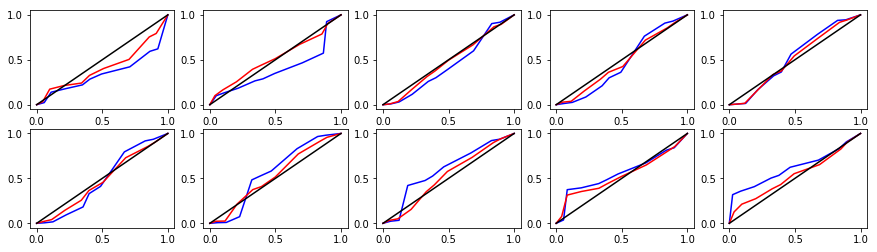

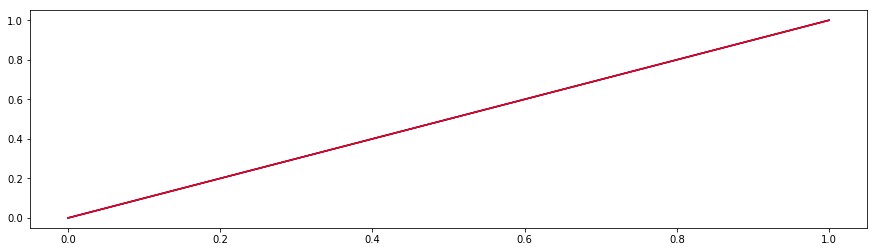

In [20]:
sgdClassifierBalanced = linear_model.SGDClassifier(loss="hinge", penalty='l2',
                alpha=0.0001, l1_ratio=0.15, fit_intercept=True,
                max_iter=1000, tol=1e-4, shuffle=True, verbose=1,
                epsilon=0.1, n_jobs=4, random_state=428, learning_rate='optimal',
                eta0=0.0, power_t=0.5, early_stopping=False, validation_fraction=0.1,
                n_iter_no_change=10, class_weight='balanced', warm_start=False,
                average=False)
sgdClassifierBalanced.fit(pca_train_x, pca_train_y)
produce_plots(sgdClassifierBalanced, pca_train_x, pca_train_y, pca_test_x, pca_test_y)